Import libraries

In [1]:
import ensembl_rest
from Bio import Entrez,SeqIO,AlignIO,SeqFeature, Align, pairwise2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import pickle
import pprint
import mygene
from itertools import chain
#from skbio import alignment
import requests
import pandas as pd
import biomart
import re
import random
from urllib import request
import json
from scipy.stats import zscore
from scipy import stats
from sklearn.cluster import KMeans

import the list of TFs

In [2]:
with open("TFs_Ensembl_v_1.01.txt", "r") as f:
    TFs = [line.strip() for line in f.readlines()]

In [3]:
with open("2018-07-11_tf_families_table_w_transfac.tsv") as f:
    TFs_df = pd.read_table(f)
TFs = TFs_df["ensg"].to_list()

get the sequences for the TFs

In [4]:
seqs = {}
for TF in TFs:
    try:
        isoforms = ensembl_rest.lookup(TF,
                                       params={'multiple_sequences': True,
                                               'type': 'protein',
                                               'expand':True
                                              }
                                      )
        seqs[TF] = {}
        for iso in isoforms['Transcript']:
            if iso['biotype']!="protein_coding":
                continue
            seq = ensembl_rest.sequence_id(iso['Translation']['id'])['seq']
            seqs[TF][iso['Translation']['id']] = {'seq': seq}
    except ensembl_rest.HTTPError as err:
        error_code = err.response.status_code
        error_message= err.response.json()['error']
        if(error_code==400) and ("not found" in error_message):
            print(TF + " not found")
        elif(error_code==400) and ("No sequences returned" in error_message):
            print(TF + " no protein sequences found")
        else:
            raise



ENSG00000259128 not found
ENSG00000259034 not found
ENSG00000259063 not found
ENSG00000258697 not found
ENSG00000277706 not found
ENSG00000215271 not found
ENSG00000278500 not found
ENSG00000269905 not found


Get some info about isoforms

Number of proteins with found isoforms: 1573
Average number of isoforms per gene: 4.868404322949777


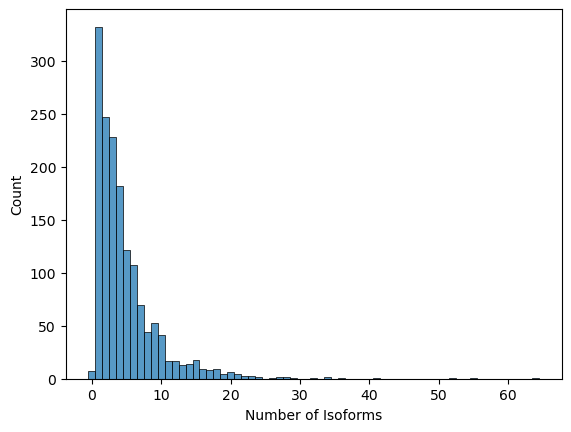

In [5]:
num_isoforms = np.array([len(isos) for isos in seqs.values()])
print("Number of proteins with found isoforms: " + str(len(seqs)))
aveisos = np.sum(num_isoforms)/len(seqs)
print("Average number of isoforms per gene: " + str(aveisos))
sns.histplot(num_isoforms, discrete=True).set(xlabel="Number of Isoforms");

Get and count the number of protein coding transcripts per human gene

Average number of isoforms per gene: 4.352397230256814
4.352397230256814
5.168844001519821
0.11338922373296334


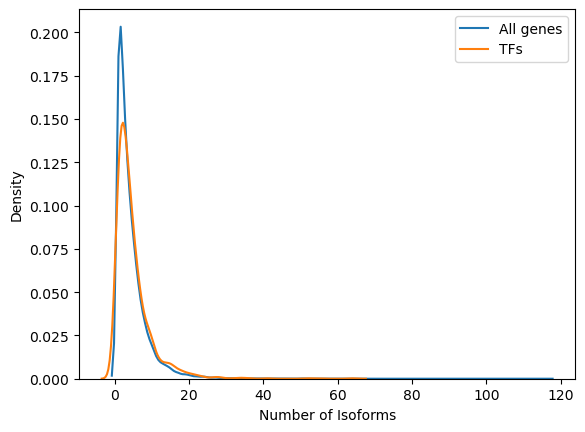

In [14]:
ensembl_rest.info_genome('homo sapiens', params={'expand':True})
all_genes_transcript_counts = {}

with open("all_human_transcripts.txt", "r") as f:
    for line in f.readlines():
        spltln = line.split("\t")
        if spltln[1] not in all_genes_transcript_counts:
            all_genes_transcript_counts[spltln[1]]=1
        else:
            all_genes_transcript_counts[spltln[1]]+=1
all_genes_transcript_counts_values = np.array(list(all_genes_transcript_counts.values()))
print("Average number of isoforms per gene: " + str(sum(all_genes_transcript_counts_values)/len(all_genes_transcript_counts_values)))
sns.kdeplot(np.array(all_genes_transcript_counts_values), label="All genes")
sns.kdeplot(num_isoforms, label="TFs").set(xlabel="Number of Isoforms")
plt.pyplot.legend();
print(np.mean(all_genes_transcript_counts_values))
print(np.std(num_isoforms))
print((np.mean(num_isoforms)-np.mean(all_genes_transcript_counts_values))/np.std(all_genes_transcript_counts_values))

Identify the domains in the isoforms

In [9]:
i=0
for gene_id in seqs:
    #if i==1:
    #    break
    #print(seqs[gene_id])
    for prot_id in seqs[gene_id]:
        results = ensembl_rest.overlap_translation(prot_id, 
                                                   type="domain")
        seqs[gene_id][prot_id]["domains"] = [res for res in results]
    i+=1

Get Uniprot IDs

In [3]:
mg = mygene.MyGeneInfo()
for gene_id in seqs:
    get_gene_result = mg.getgene(gene_id)
    if get_gene_result is not None and "uniprot" in get_gene_result:
        seqs[gene_id]["uniprot"] = get_gene_result["uniprot"]
#these are missing for some reason
seqs["ENSG00000106331"]["uniprot"] = {'Swiss-Prot':"O43316"}
seqs["ENSG00000185670"]["uniprot"] = {'Swiss-Prot':"Q9H5J0"}
seqs["ENSG00000225614"]["uniprot"] = {'Swiss-Prot':"Q96JG9"}
seqs["ENSG00000243660"]["uniprot"] = {'Swiss-Prot':"B1APH4"}
seqs["ENSG00000189144"]["uniprot"] = {'Swiss-Prot':"Q86YE8"}
seqs["ENSG00000258834"]["uniprot"] = {'Swiss-Prot':"Q9HBT8"}
seqs["ENSG00000255104"]["uniprot"] = {'Swiss-Prot':"P0CG31"}
seqs["ENSG00000249459"]["uniprot"] = {'Swiss-Prot':"P0CG31"}
seqs["ENSG00000175105"]["uniprot"] = {'Swiss-Prot':"Q8IZM8"}
seqs["ENSG00000160229"]["uniprot"] = {'Swiss-Prot':"Q6ZN08"}
seqs["ENSG00000135747"]["uniprot"] = {'Swiss-Prot':"Q9BS34"}
seqs["ENSG00000181450"]["uniprot"] = {'Swiss-Prot':"Q5SXM1"}
seqs["ENSG00000196826"]["uniprot"] = {'Swiss-Prot':"Q8N972"}
seqs["ENSG00000196081"]["uniprot"] = {'Swiss-Prot':"A8MTY0"}
seqs["ENSG00000196381"]["uniprot"] = {'Swiss-Prot':"Q8N8C0"}
seqs["ENSG00000224689"]["uniprot"] = {'Swiss-Prot':"P0C7V5"}
seqs["ENSG00000204532"]["uniprot"] = {'Swiss-Prot':"A6NGD5"}
seqs["ENSG00000267908"]["uniprot"] = {'Swiss-Prot':"P0CG00"}


In [40]:
mg = mygene.MyGeneInfo()
for gene_id in seqs:
    for prot_id in seqs[gene_id]:
        print(prot_id)
        get_gene_result = mg.query(f"q=ensembl.protein:{prot_id}")
        print(get_gene_result)
        if get_gene_result is not None and "uniprot" in get_gene_result:
            print(get_gene_result["uniprot"])
#these are missing for some reason
seqs["ENSG00000106331"]["uniprot"] = {'Swiss-Prot':"O43316"}
seqs["ENSG00000185670"]["uniprot"] = {'Swiss-Prot':"Q9H5J0"}
seqs["ENSG00000225614"]["uniprot"] = {'Swiss-Prot':"Q96JG9"}
seqs["ENSG00000243660"]["uniprot"] = {'Swiss-Prot':"B1APH4"}
seqs["ENSG00000189144"]["uniprot"] = {'Swiss-Prot':"Q86YE8"}
seqs["ENSG00000258834"]["uniprot"] = {'Swiss-Prot':"Q9HBT8"}
seqs["ENSG00000255104"]["uniprot"] = {'Swiss-Prot':"P0CG31"}
seqs["ENSG00000249459"]["uniprot"] = {'Swiss-Prot':"P0CG31"}
seqs["ENSG00000175105"]["uniprot"] = {'Swiss-Prot':"Q8IZM8"}
seqs["ENSG00000160229"]["uniprot"] = {'Swiss-Prot':"Q6ZN08"}
seqs["ENSG00000135747"]["uniprot"] = {'Swiss-Prot':"Q9BS34"}
seqs["ENSG00000181450"]["uniprot"] = {'Swiss-Prot':"Q5SXM1"}
seqs["ENSG00000196826"]["uniprot"] = {'Swiss-Prot':"Q8N972"}
seqs["ENSG00000196081"]["uniprot"] = {'Swiss-Prot':"A8MTY0"}
seqs["ENSG00000196381"]["uniprot"] = {'Swiss-Prot':"Q8N8C0"}
seqs["ENSG00000224689"]["uniprot"] = {'Swiss-Prot':"P0C7V5"}
seqs["ENSG00000204532"]["uniprot"] = {'Swiss-Prot':"A6NGD5"}
seqs["ENSG00000267908"]["uniprot"] = {'Swiss-Prot':"P0CG00"}


ENSP00000360662
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000483881
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000501294
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000493755
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000379346
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000379349
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000342905
{'took': 1, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000495540
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
uniprot
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000262198
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000453418
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000453275
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000468397
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000467370
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
uniprot
{'took

KeyboardInterrupt: 

In [4]:
with open("seqs.pickle", "wb") as f:
    pickle.dump(seqs, f)

In [19]:
with open("seqs.pickle", "rb") as f:
    seqs = pickle.load(f)

Get descriptions for manual curation of DNA-binding domains on Nov 27, 2023

In [27]:
interpro_superfamily_domains = pd.DataFrame(columns=["Name","Description"])
for gene_id in seqs:
    if len(seqs[gene_id])<=1:
        continue
    for prot_id in seqs[gene_id]:
        if not prot_id.startswith("ENS"):
            continue
        for domain in seqs[gene_id][prot_id]['domains']:
            if domain['interpro']=='' or domain['type']!='SuperFamily':
                continue
            #print(interpro_domains[domain['interpro']])
            if domain['interpro'] in interpro_superfamily_domains.index:
                continue
            interpro_url = f"https://www.ebi.ac.uk:443/interpro/api/entry/InterPro/{domain['interpro']}/?page_size=200"
            req = request.Request(interpro_url, headers = {"Accept": "application/json"})
            res = request.urlopen(req)
            json_res = json.loads(res.read().decode())
            #print(json_res)
            accession = json_res['metadata']['accession']
            name = json_res['metadata']['name']['name']
            description = ' '.join(json_res['metadata']['description'])
            #print([accession, name, description])
            interpro_superfamily_domains.loc[accession] = [name, description]
    #break
print(interpro_superfamily_domains)

                                                        Name  \
IPR009057                   Homeobox-like domain superfamily   
IPR036236                       Zinc finger C2H2 superfamily   
IPR036638    Helix-loop-helix DNA-binding domain superfamily   
IPR035965                             PAS domain superfamily   
IPR011011                         Zinc finger, FYVE/PHD-type   
...                                                      ...   
IPR036792  Aspartate carbamoyltransferase regulatory subu...   
IPR036875                 Zinc finger, CCHC-type superfamily   
IPR035896                               AN1-like Zinc finger   
IPR038765         Papain-like cysteine peptidase superfamily   
IPR008981                            F-MuLV receptor-binding   

                                                 Description  
IPR009057  <p>Homeobox domain (also known as homeodomain)...  
IPR036236  <p>C2H2-type (classical) zinc fingers (ZnF) we...  
IPR036638  <p>This domain is found in a nu

In [24]:
interpro_superfamily_domains.to_csv("interpro_superfamily_domains.tsv", sep="\t")

In [12]:
interpro_superfamily_domains_DBD = pd.read_csv("interpro_superfamily_domains_DBD.tsv", sep='\t', index_col=0)
print(interpro_superfamily_domains_DBD)

                                                        Name  \
IPR009057                   Homeobox-like domain superfamily   
IPR036236                       Zinc finger C2H2 superfamily   
IPR036638    Helix-loop-helix DNA-binding domain superfamily   
IPR035965                             PAS domain superfamily   
IPR011011                         Zinc finger, FYVE/PHD-type   
...                                                      ...   
IPR036792  Aspartate carbamoyltransferase regulatory subu...   
IPR036875                 Zinc finger, CCHC-type superfamily   
IPR035896                               AN1-like Zinc finger   
IPR038765         Papain-like cysteine peptidase superfamily   
IPR008981                            F-MuLV receptor-binding   

                                                 Description  DNA-binding  \
IPR009057  <p>Homeobox domain (also known as homeodomain)...         True   
IPR036236  <p>C2H2-type (classical) zinc fingers (ZnF) we...         True   


Interpro domain type counting and domain type classifying

In [28]:
ppi_domains = pd.read_csv("3did_pfam_pairs.txt", sep='\t',header=None)
print(ppi_domains.head())

for gene_id in seqs:
    if len(seqs[gene_id])<=1:
        continue
    for prot_id in seqs[gene_id]:
        if 'domains' not in seqs[gene_id][prot_id]: continue
        if 'Swiss-Prot' in seqs[gene_id]["uniprot"]:
            uniprot_id = seqs[gene_id]["uniprot"]['Swiss-Prot']
            if type(uniprot_id)!=str:
                uniprot_id = uniprot_id[0]
        else:
            #print(seqs[gene_id]["uniprot"])
            uniprot_id = seqs[gene_id]["uniprot"]['TrEMBL']
        if type(uniprot_id)==list:
            uniprot_id = uniprot_id[0]
        interpro_url = f"https://www.ebi.ac.uk:443/interpro/api/entry/InterPro/protein/UniProt/{uniprot_id}/?page_size=200"
        req = request.Request(interpro_url, headers = {"Accept": "application/json"})
        res = request.urlopen(req)
        json_res = json.loads(res.read().decode())
        #print(json_res['results'])
        interpro_domains = {domain['metadata']['accession']:domain 
                            for domain in json_res['results'] }
        ppi_locations = None
        for domain in interpro_domains:
            #print(interpro_domains[domain]['metadata']['member_databases'])
            if 'pfam' in interpro_domains[domain]['metadata']['member_databases']:
                pfam_id = list(interpro_domains[domain]['metadata']['member_databases']['pfam'].keys())[0]
                #print(pfam_id)
                if pfam_id in ppi_domains.values:
                    #print(f"PPI domain {pfam_id} in {gene_id}")
                    for epl in interpro_domains[domain]['proteins'][0]['entry_protein_locations']:
                        #print(epl['fragments'])
                        if ppi_locations == None:
                            ppi_locations = SeqFeature.FeatureLocation(start=epl['fragments'][0]['start'],
                                                                       end=epl['fragments'][0]['end'])
                        else:
                            ppi_locations += SeqFeature.FeatureLocation(start=epl['fragments'][0]['start'],
                                                                       end=epl['fragments'][0]['end'])
                    #print(html_res)
                else:
                    print(f"Not a PPI domain {pfam_id} in {gene_id}")
        #print(ppi_locations)
        for domain in seqs[gene_id][prot_id]['domains']:
            for interpro_id in interpro_domains:
                if domain['interpro']==interpro_id:
                    this_domain_locations = None
                    for epl in interpro_domains[interpro_id]['proteins'][0]['entry_protein_locations']:
                        #print(epl['fragments'])
                        if this_domain_locations == None:
                            this_domain_locations = SeqFeature.FeatureLocation(start=epl['fragments'][0]['start'],
                                                                       end=epl['fragments'][0]['end'])
                        else:
                            this_domain_locations += SeqFeature.FeatureLocation(start=epl['fragments'][0]['start'],
                                                                       end=epl['fragments'][0]['end'])
                    #print(this_domain_locations)
                    #print(ppi_locations)
                    if this_domain_locations == None or ppi_locations==None:
                        domain['PPI'] = False
                    elif sum([this_i in ppi_locations \
                                          for this_i in this_domain_locations])!=0:
                        domain['PPI'] = True
                    else:
                        domain['PPI'] = False
                    break

          0        1
0   PF10417  PF10417
1   PF10417  PF00578
2   PF10417  PF02195
3   PF10417  PF00085
4   PF12574  PF12574
Not a PPI domain PF19627 in ENSG00000101126
Not a PPI domain PF19627 in ENSG00000101126
Not a PPI domain PF19627 in ENSG00000101126
Not a PPI domain PF19627 in ENSG00000101126
Not a PPI domain PF19627 in ENSG00000101126
Not a PPI domain PF19627 in ENSG00000101126
Not a PPI domain PF19627 in ENSG00000101126
Not a PPI domain PF19627 in ENSG00000101126
Not a PPI domain PF19627 in ENSG00000101126
Not a PPI domain PF19627 in ENSG00000101544
Not a PPI domain PF19627 in ENSG00000101544
Not a PPI domain PF19627 in ENSG00000101544
Not a PPI domain PF19627 in ENSG00000101544
Not a PPI domain PF19627 in ENSG00000101544
Not a PPI domain PF19627 in ENSG00000101544
Not a PPI domain PF18875 in ENSG00000144218
Not a PPI domain PF18875 in ENSG00000144218
Not a PPI domain PF18875 in ENSG00000144218
Not a PPI domain PF18875 in ENSG00000144218
Not a PPI domain PF18875 in ENSG000001

Not a PPI domain PF03859 in ENSG00000171735
Not a PPI domain PF03859 in ENSG00000171735
Not a PPI domain PF03859 in ENSG00000171735
Not a PPI domain PF03859 in ENSG00000108509
Not a PPI domain PF03859 in ENSG00000108509
Not a PPI domain PF03859 in ENSG00000108509
Not a PPI domain PF03859 in ENSG00000108509
Not a PPI domain PF03859 in ENSG00000108509
Not a PPI domain PF03859 in ENSG00000108509
Not a PPI domain PF03859 in ENSG00000108509
Not a PPI domain PF04731 in ENSG00000113722
Not a PPI domain PF04731 in ENSG00000113722
Not a PPI domain PF04731 in ENSG00000165556
Not a PPI domain PF04731 in ENSG00000165556
Not a PPI domain PF04731 in ENSG00000131264
Not a PPI domain PF04731 in ENSG00000131264
Not a PPI domain PF03914 in ENSG00000115816
Not a PPI domain PF03914 in ENSG00000115816
Not a PPI domain PF03914 in ENSG00000115816
Not a PPI domain PF16367 in ENSG00000080802
Not a PPI domain PF16367 in ENSG00000080802
Not a PPI domain PF16367 in ENSG00000080802
Not a PPI domain PF16367 in ENSG

Not a PPI domain PF21255 in ENSG00000119772
Not a PPI domain PF21255 in ENSG00000119772
Not a PPI domain PF21255 in ENSG00000119772
Not a PPI domain PF21255 in ENSG00000119772
Not a PPI domain PF21255 in ENSG00000119772
Not a PPI domain PF21255 in ENSG00000119772
Not a PPI domain PF21255 in ENSG00000088305
Not a PPI domain PF21255 in ENSG00000088305
Not a PPI domain PF21255 in ENSG00000088305
Not a PPI domain PF21255 in ENSG00000088305
Not a PPI domain PF21255 in ENSG00000088305
Not a PPI domain PF21255 in ENSG00000088305
Not a PPI domain PF21255 in ENSG00000088305
Not a PPI domain PF21255 in ENSG00000088305
Not a PPI domain PF21255 in ENSG00000088305
Not a PPI domain PF21255 in ENSG00000142182
Not a PPI domain PF21255 in ENSG00000142182
Not a PPI domain PF21255 in ENSG00000142182
Not a PPI domain PF21255 in ENSG00000142182
Not a PPI domain PF16866 in ENSG00000133884
Not a PPI domain PF14051 in ENSG00000133884
Not a PPI domain PF16866 in ENSG00000133884
Not a PPI domain PF14051 in ENSG

Not a PPI domain PF16676 in ENSG00000150907
Not a PPI domain PF16675 in ENSG00000150907
Not a PPI domain PF16676 in ENSG00000118689
Not a PPI domain PF16675 in ENSG00000118689
Not a PPI domain PF16676 in ENSG00000118689
Not a PPI domain PF16675 in ENSG00000118689
Not a PPI domain PF16676 in ENSG00000118689
Not a PPI domain PF16675 in ENSG00000118689
Not a PPI domain PF16676 in ENSG00000118689
Not a PPI domain PF16675 in ENSG00000118689
Not a PPI domain PF16676 in ENSG00000184481
Not a PPI domain PF16676 in ENSG00000184481
Not a PPI domain PF16676 in ENSG00000184481
Not a PPI domain PF16676 in ENSG00000204060
Not a PPI domain PF16675 in ENSG00000204060
Not a PPI domain PF16676 in ENSG00000204060
Not a PPI domain PF16675 in ENSG00000204060
Not a PPI domain PF16676 in ENSG00000204060
Not a PPI domain PF16675 in ENSG00000204060
Not a PPI domain PF16159 in ENSG00000114861
Not a PPI domain PF16159 in ENSG00000114861
Not a PPI domain PF16159 in ENSG00000114861
Not a PPI domain PF16159 in ENSG

Not a PPI domain PF02178 in ENSG00000149948
Not a PPI domain PF02178 in ENSG00000149948
Not a PPI domain PF02178 in ENSG00000149948
Not a PPI domain PF02178 in ENSG00000149948
Not a PPI domain PF02178 in ENSG00000149948
Not a PPI domain PF02178 in ENSG00000149948
Not a PPI domain PF02178 in ENSG00000149948
Not a PPI domain PF18717 in ENSG00000113716
Not a PPI domain PF18717 in ENSG00000113716
Not a PPI domain PF18717 in ENSG00000113716
Not a PPI domain PF18717 in ENSG00000113716
Not a PPI domain PF13775 in ENSG00000100281
Not a PPI domain PF13775 in ENSG00000100281
Not a PPI domain PF13775 in ENSG00000100281
Not a PPI domain PF13775 in ENSG00000100281
Not a PPI domain PF04812 in ENSG00000135100
Not a PPI domain PF04813 in ENSG00000135100
Not a PPI domain PF04814 in ENSG00000135100
Not a PPI domain PF04812 in ENSG00000135100
Not a PPI domain PF04813 in ENSG00000135100
Not a PPI domain PF04814 in ENSG00000135100
Not a PPI domain PF04812 in ENSG00000135100
Not a PPI domain PF04813 in ENSG

Not a PPI domain PF01530 in ENSG00000136504
Not a PPI domain PF01530 in ENSG00000136504
Not a PPI domain PF01530 in ENSG00000136504
Not a PPI domain PF01530 in ENSG00000136504
Not a PPI domain PF01530 in ENSG00000136504
Not a PPI domain PF01530 in ENSG00000136504
Not a PPI domain PF01530 in ENSG00000136504
Not a PPI domain PF01530 in ENSG00000136504
Not a PPI domain PF01530 in ENSG00000136504
Not a PPI domain PF01530 in ENSG00000136504
Not a PPI domain PF01530 in ENSG00000136504
Not a PPI domain PF01530 in ENSG00000136504
Not a PPI domain PF01530 in ENSG00000136504
Not a PPI domain PF01530 in ENSG00000136504
Not a PPI domain PF01530 in ENSG00000136504
Not a PPI domain PF16866 in ENSG00000173120
Not a PPI domain PF17811 in ENSG00000173120
Not a PPI domain PF16866 in ENSG00000173120
Not a PPI domain PF17811 in ENSG00000173120
Not a PPI domain PF16866 in ENSG00000173120
Not a PPI domain PF17811 in ENSG00000173120
Not a PPI domain PF16866 in ENSG00000173120
Not a PPI domain PF17811 in ENSG

Not a PPI domain PF16833 in ENSG00000105610
Not a PPI domain PF16832 in ENSG00000105610
Not a PPI domain PF05965 in ENSG00000118058
Not a PPI domain PF16866 in ENSG00000118058
Not a PPI domain PF05965 in ENSG00000118058
Not a PPI domain PF16866 in ENSG00000118058
Not a PPI domain PF05965 in ENSG00000118058
Not a PPI domain PF16866 in ENSG00000118058
Not a PPI domain PF05965 in ENSG00000118058
Not a PPI domain PF16866 in ENSG00000118058
Not a PPI domain PF05965 in ENSG00000118058
Not a PPI domain PF16866 in ENSG00000118058
Not a PPI domain PF05965 in ENSG00000118058
Not a PPI domain PF16866 in ENSG00000118058
Not a PPI domain PF05965 in ENSG00000118058
Not a PPI domain PF16866 in ENSG00000118058
Not a PPI domain PF05965 in ENSG00000118058
Not a PPI domain PF16866 in ENSG00000118058
Not a PPI domain PF05965 in ENSG00000118058
Not a PPI domain PF16866 in ENSG00000118058
Not a PPI domain PF05965 in ENSG00000118058
Not a PPI domain PF16866 in ENSG00000118058
Not a PPI domain PF05965 in ENSG

Not a PPI domain PF16493 in ENSG00000105419
Not a PPI domain PF16493 in ENSG00000105419
Not a PPI domain PF16493 in ENSG00000105419
Not a PPI domain PF16493 in ENSG00000105419
Not a PPI domain PF16493 in ENSG00000105419
Not a PPI domain PF16493 in ENSG00000105419
Not a PPI domain PF16493 in ENSG00000105419
Not a PPI domain PF16493 in ENSG00000105419
Not a PPI domain PF16493 in ENSG00000105419
Not a PPI domain PF16493 in ENSG00000105419
Not a PPI domain PF16493 in ENSG00000105419
Not a PPI domain PF16059 in ENSG00000174197
Not a PPI domain PF16059 in ENSG00000174197
Not a PPI domain PF16059 in ENSG00000174197
Not a PPI domain PF16059 in ENSG00000174197
Not a PPI domain PF16059 in ENSG00000174197
Not a PPI domain PF16059 in ENSG00000174197
Not a PPI domain PF16059 in ENSG00000174197
Not a PPI domain PF16059 in ENSG00000174197
Not a PPI domain PF19426 in ENSG00000198160
Not a PPI domain PF19426 in ENSG00000198160
Not a PPI domain PF19426 in ENSG00000198160
Not a PPI domain PF19426 in ENSG

Not a PPI domain PF01530 in ENSG00000186487
Not a PPI domain PF08474 in ENSG00000186487
Not a PPI domain PF01530 in ENSG00000186487
Not a PPI domain PF08474 in ENSG00000186487
Not a PPI domain PF01530 in ENSG00000186487
Not a PPI domain PF08474 in ENSG00000186487
Not a PPI domain PF01530 in ENSG00000186487
Not a PPI domain PF08474 in ENSG00000186487
Not a PPI domain PF01530 in ENSG00000186487
Not a PPI domain PF08474 in ENSG00000186487
Not a PPI domain PF01530 in ENSG00000186487
Not a PPI domain PF08474 in ENSG00000186487
Not a PPI domain PF01530 in ENSG00000186487
Not a PPI domain PF08474 in ENSG00000186487
Not a PPI domain PF01530 in ENSG00000186487
Not a PPI domain PF08474 in ENSG00000186487
Not a PPI domain PF01530 in ENSG00000186487
Not a PPI domain PF08474 in ENSG00000186487
Not a PPI domain PF01530 in ENSG00000186487
Not a PPI domain PF08474 in ENSG00000186487
Not a PPI domain PF01530 in ENSG00000186487
Not a PPI domain PF08474 in ENSG00000186487
Not a PPI domain PF01530 in ENSG

Not a PPI domain PF00859 in ENSG00000008441
Not a PPI domain PF10524 in ENSG00000008441
Not a PPI domain PF00859 in ENSG00000008441
Not a PPI domain PF10524 in ENSG00000008441
Not a PPI domain PF00859 in ENSG00000008441
Not a PPI domain PF10524 in ENSG00000008441
Not a PPI domain PF00859 in ENSG00000008441
Not a PPI domain PF10524 in ENSG00000008441
Not a PPI domain PF00859 in ENSG00000008441
Not a PPI domain PF10524 in ENSG00000008441
Not a PPI domain PF00859 in ENSG00000008441
Not a PPI domain PF10524 in ENSG00000008441
Not a PPI domain PF00859 in ENSG00000008441
Not a PPI domain PF10524 in ENSG00000008441
Not a PPI domain PF00859 in ENSG00000008441
Not a PPI domain PF10524 in ENSG00000008441
Not a PPI domain PF00859 in ENSG00000008441
Not a PPI domain PF10524 in ENSG00000008441
Not a PPI domain PF00859 in ENSG00000008441
Not a PPI domain PF10524 in ENSG00000008441
Not a PPI domain PF00859 in ENSG00000008441
Not a PPI domain PF10524 in ENSG00000008441
Not a PPI domain PF00859 in ENSG

Not a PPI domain PF03792 in ENSG00000185630
Not a PPI domain PF03792 in ENSG00000185630
Not a PPI domain PF03792 in ENSG00000185630
Not a PPI domain PF03792 in ENSG00000185630
Not a PPI domain PF03792 in ENSG00000185630
Not a PPI domain PF03792 in ENSG00000185630
Not a PPI domain PF03792 in ENSG00000185630
Not a PPI domain PF03792 in ENSG00000185630
Not a PPI domain PF03792 in ENSG00000185630
Not a PPI domain PF03792 in ENSG00000185630
Not a PPI domain PF03792 in ENSG00000185630
Not a PPI domain PF03792 in ENSG00000204304
Not a PPI domain PF03792 in ENSG00000204304
Not a PPI domain PF03792 in ENSG00000167081
Not a PPI domain PF03792 in ENSG00000167081
Not a PPI domain PF03792 in ENSG00000167081
Not a PPI domain PF03792 in ENSG00000167081
Not a PPI domain PF03792 in ENSG00000167081
Not a PPI domain PF03792 in ENSG00000167081
Not a PPI domain PF03792 in ENSG00000167081
Not a PPI domain PF03792 in ENSG00000105717
Not a PPI domain PF03792 in ENSG00000105717
Not a PPI domain PF02161 in ENSG

Not a PPI domain PF21206 in ENSG00000056586
Not a PPI domain PF21206 in ENSG00000056586
Not a PPI domain PF20878 in ENSG00000089902
Not a PPI domain PF20878 in ENSG00000089902
Not a PPI domain PF20878 in ENSG00000167771
Not a PPI domain PF20878 in ENSG00000167771
Not a PPI domain PF20878 in ENSG00000117625
Not a PPI domain PF20878 in ENSG00000117625
Not a PPI domain PF20878 in ENSG00000117625
Not a PPI domain PF20878 in ENSG00000117625
Not a PPI domain PF20878 in ENSG00000117625
Not a PPI domain PF20878 in ENSG00000117625
Not a PPI domain PF20878 in ENSG00000117625
Not a PPI domain PF20878 in ENSG00000117625
Not a PPI domain PF20878 in ENSG00000117625
Not a PPI domain PF16180 in ENSG00000104856
Not a PPI domain PF16181 in ENSG00000104856
Not a PPI domain PF16180 in ENSG00000104856
Not a PPI domain PF16181 in ENSG00000104856
Not a PPI domain PF16180 in ENSG00000104856
Not a PPI domain PF16181 in ENSG00000104856
Not a PPI domain PF16180 in ENSG00000104856
Not a PPI domain PF16181 in ENSG

Not a PPI domain PF02376 in ENSG00000182568
Not a PPI domain PF16557 in ENSG00000182568
Not a PPI domain PF02376 in ENSG00000182568
Not a PPI domain PF16557 in ENSG00000182568
Not a PPI domain PF02376 in ENSG00000182568
Not a PPI domain PF16557 in ENSG00000182568
Not a PPI domain PF02376 in ENSG00000182568
Not a PPI domain PF16557 in ENSG00000182568
Not a PPI domain PF02376 in ENSG00000182568
Not a PPI domain PF16557 in ENSG00000182568
Not a PPI domain PF02376 in ENSG00000182568
Not a PPI domain PF16557 in ENSG00000182568
Not a PPI domain PF02376 in ENSG00000119042
Not a PPI domain PF16557 in ENSG00000119042
Not a PPI domain PF02376 in ENSG00000119042
Not a PPI domain PF16557 in ENSG00000119042
Not a PPI domain PF02376 in ENSG00000119042
Not a PPI domain PF16557 in ENSG00000119042
Not a PPI domain PF02376 in ENSG00000119042
Not a PPI domain PF16557 in ENSG00000119042
Not a PPI domain PF02376 in ENSG00000119042
Not a PPI domain PF16557 in ENSG00000119042
Not a PPI domain PF02376 in ENSG

Not a PPI domain PF12162 in ENSG00000115415
Not a PPI domain PF21354 in ENSG00000115415
Not a PPI domain PF12162 in ENSG00000115415
Not a PPI domain PF21354 in ENSG00000115415
Not a PPI domain PF12162 in ENSG00000115415
Not a PPI domain PF21354 in ENSG00000115415
Not a PPI domain PF12162 in ENSG00000115415
Not a PPI domain PF21354 in ENSG00000115415
Not a PPI domain PF12162 in ENSG00000115415
Not a PPI domain PF21354 in ENSG00000115415
Not a PPI domain PF12162 in ENSG00000115415
Not a PPI domain PF21354 in ENSG00000115415
Not a PPI domain PF12162 in ENSG00000115415
Not a PPI domain PF21354 in ENSG00000115415
Not a PPI domain PF12162 in ENSG00000115415
Not a PPI domain PF21354 in ENSG00000115415
Not a PPI domain PF12162 in ENSG00000115415
Not a PPI domain PF21354 in ENSG00000115415
Not a PPI domain PF12188 in ENSG00000170581
Not a PPI domain PF21354 in ENSG00000170581
Not a PPI domain PF12188 in ENSG00000170581
Not a PPI domain PF21354 in ENSG00000170581
Not a PPI domain PF12188 in ENSG

Not a PPI domain PF11851 in ENSG00000112561
Not a PPI domain PF15951 in ENSG00000112561
Not a PPI domain PF11851 in ENSG00000112561
Not a PPI domain PF15951 in ENSG00000112561
Not a PPI domain PF11851 in ENSG00000112561
Not a PPI domain PF15951 in ENSG00000112561
Not a PPI domain PF11851 in ENSG00000112561
Not a PPI domain PF15951 in ENSG00000112561
Not a PPI domain PF11851 in ENSG00000112561
Not a PPI domain PF15951 in ENSG00000112561
Not a PPI domain PF11851 in ENSG00000112561
Not a PPI domain PF15951 in ENSG00000112561
Not a PPI domain PF11851 in ENSG00000105967
Not a PPI domain PF11851 in ENSG00000105967
Not a PPI domain PF11851 in ENSG00000105967
Not a PPI domain PF11851 in ENSG00000105967
Not a PPI domain PF11851 in ENSG00000105967
Not a PPI domain PF11851 in ENSG00000105967
Not a PPI domain PF05485 in ENSG00000131931
Not a PPI domain PF05485 in ENSG00000131931
Not a PPI domain PF05485 in ENSG00000131931
Not a PPI domain PF05485 in ENSG00000131931
Not a PPI domain PF05485 in ENSG

Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG00000169554
Not a PPI domain PF05605 in ENSG

Not a PPI domain PF01352 in ENSG00000141946
Not a PPI domain PF01352 in ENSG00000106261
Not a PPI domain PF01352 in ENSG00000106261
Not a PPI domain PF01352 in ENSG00000106261
Not a PPI domain PF01352 in ENSG00000106261
Not a PPI domain PF01352 in ENSG00000106261
Not a PPI domain PF01352 in ENSG00000106261
Not a PPI domain PF01352 in ENSG00000155592
Not a PPI domain PF13837 in ENSG00000155592
Not a PPI domain PF01352 in ENSG00000155592
Not a PPI domain PF13837 in ENSG00000155592
Not a PPI domain PF01352 in ENSG00000189298
Not a PPI domain PF01352 in ENSG00000189298
Not a PPI domain PF01352 in ENSG00000189298
Not a PPI domain PF01352 in ENSG00000189298
Not a PPI domain PF01352 in ENSG00000187626
Not a PPI domain PF01352 in ENSG00000187626
Not a PPI domain PF01352 in ENSG00000196652
Not a PPI domain PF01352 in ENSG00000196652
Not a PPI domain PF01352 in ENSG00000196652
Not a PPI domain PF01352 in ENSG00000196652
Not a PPI domain PF01352 in ENSG00000196345
Not a PPI domain PF01352 in ENSG

Not a PPI domain PF01352 in ENSG00000136870
Not a PPI domain PF01352 in ENSG00000136870
Not a PPI domain PF01352 in ENSG00000136870
Not a PPI domain PF01352 in ENSG00000157429
Not a PPI domain PF01352 in ENSG00000157429
Not a PPI domain PF01352 in ENSG00000157429
Not a PPI domain PF01352 in ENSG00000157429
Not a PPI domain PF01352 in ENSG00000157429
Not a PPI domain PF01352 in ENSG00000157429
Not a PPI domain PF01352 in ENSG00000157429
Not a PPI domain PF01352 in ENSG00000157429
Not a PPI domain PF01352 in ENSG00000157429
Not a PPI domain PF01352 in ENSG00000157429
Not a PPI domain PF01352 in ENSG00000157429
Not a PPI domain PF01352 in ENSG00000005801
Not a PPI domain PF01352 in ENSG00000005801
Not a PPI domain PF01352 in ENSG00000005801
Not a PPI domain PF01352 in ENSG00000005801
Not a PPI domain PF01352 in ENSG00000005801
Not a PPI domain PF01352 in ENSG00000005801
Not a PPI domain PF01352 in ENSG00000005801
Not a PPI domain PF01352 in ENSG00000005801
Not a PPI domain PF01352 in ENSG

Not a PPI domain PF01352 in ENSG00000198105
Not a PPI domain PF01352 in ENSG00000198105
Not a PPI domain PF01352 in ENSG00000198105
Not a PPI domain PF01352 in ENSG00000198105
Not a PPI domain PF01352 in ENSG00000198105
Not a PPI domain PF01352 in ENSG00000198105
Not a PPI domain PF01352 in ENSG00000175395
Not a PPI domain PF01352 in ENSG00000175395
Not a PPI domain PF01352 in ENSG00000196150
Not a PPI domain PF01352 in ENSG00000196150
Not a PPI domain PF01352 in ENSG00000196150
Not a PPI domain PF01352 in ENSG00000196150
Not a PPI domain PF01352 in ENSG00000196150
Not a PPI domain PF01352 in ENSG00000196150
Not a PPI domain PF01352 in ENSG00000196150
Not a PPI domain PF01352 in ENSG00000198169
Not a PPI domain PF01352 in ENSG00000198169
Not a PPI domain PF01352 in ENSG00000198169
Not a PPI domain PF01352 in ENSG00000256771
Not a PPI domain PF01352 in ENSG00000256771
Not a PPI domain PF01352 in ENSG00000256771
Not a PPI domain PF01352 in ENSG00000256771
Not a PPI domain PF01352 in ENSG

Not a PPI domain PF01352 in ENSG00000182986
Not a PPI domain PF01352 in ENSG00000182986
Not a PPI domain PF01352 in ENSG00000182986
Not a PPI domain PF01352 in ENSG00000182986
Not a PPI domain PF01352 in ENSG00000182986
Not a PPI domain PF01352 in ENSG00000083812
Not a PPI domain PF01352 in ENSG00000083812
Not a PPI domain PF01352 in ENSG00000083812
Not a PPI domain PF01352 in ENSG00000083812
Not a PPI domain PF01352 in ENSG00000249471
Not a PPI domain PF01352 in ENSG00000249471
Not a PPI domain PF01352 in ENSG00000249471
Not a PPI domain PF01352 in ENSG00000249471
Not a PPI domain PF01352 in ENSG00000249471
Not a PPI domain PF01352 in ENSG00000249471
Not a PPI domain PF01352 in ENSG00000249471
Not a PPI domain PF04988 in ENSG00000162664
Not a PPI domain PF04988 in ENSG00000162664
Not a PPI domain PF04988 in ENSG00000162664
Not a PPI domain PF04988 in ENSG00000162664
Not a PPI domain PF01352 in ENSG00000130844
Not a PPI domain PF01352 in ENSG00000130844
Not a PPI domain PF01352 in ENSG

Not a PPI domain PF01352 in ENSG00000105136
Not a PPI domain PF01352 in ENSG00000197050
Not a PPI domain PF01352 in ENSG00000197050
Not a PPI domain PF01352 in ENSG00000197050
Not a PPI domain PF01352 in ENSG00000197050
Not a PPI domain PF01352 in ENSG00000197050
Not a PPI domain PF01352 in ENSG00000197050
Not a PPI domain PF01352 in ENSG00000197050
Not a PPI domain PF01352 in ENSG00000204947
Not a PPI domain PF01352 in ENSG00000204947
Not a PPI domain PF01352 in ENSG00000204947
Not a PPI domain PF01352 in ENSG00000130818
Not a PPI domain PF01352 in ENSG00000130818
Not a PPI domain PF01352 in ENSG00000130818
Not a PPI domain PF01352 in ENSG00000130818
Not a PPI domain PF01352 in ENSG00000130818
Not a PPI domain PF01352 in ENSG00000197013
Not a PPI domain PF01352 in ENSG00000197013
Not a PPI domain PF01352 in ENSG00000197013
Not a PPI domain PF01352 in ENSG00000197013
Not a PPI domain PF01352 in ENSG00000198521
Not a PPI domain PF01352 in ENSG00000198521
Not a PPI domain PF01352 in ENSG

Not a PPI domain PF01352 in ENSG00000103199
Not a PPI domain PF01352 in ENSG00000103199
Not a PPI domain PF01352 in ENSG00000103199
Not a PPI domain PF01352 in ENSG00000103199
Not a PPI domain PF01352 in ENSG00000103199
Not a PPI domain PF01352 in ENSG00000103199
Not a PPI domain PF01352 in ENSG00000103199
Not a PPI domain PF01352 in ENSG00000081665
Not a PPI domain PF01352 in ENSG00000081665
Not a PPI domain PF01352 in ENSG00000081665
Not a PPI domain PF01352 in ENSG00000081665
Not a PPI domain PF01352 in ENSG00000081665
Not a PPI domain PF01352 in ENSG00000081665
Not a PPI domain PF01352 in ENSG00000081665
Not a PPI domain PF01352 in ENSG00000081665
Not a PPI domain PF01352 in ENSG00000081665
Not a PPI domain PF01352 in ENSG00000081386
Not a PPI domain PF01352 in ENSG00000081386
Not a PPI domain PF01352 in ENSG00000081386
Not a PPI domain PF21367 in ENSG00000243943
Not a PPI domain PF21276 in ENSG00000243943
Not a PPI domain PF21367 in ENSG00000243943
Not a PPI domain PF21276 in ENSG

Not a PPI domain PF01352 in ENSG00000188321
Not a PPI domain PF01352 in ENSG00000188321
Not a PPI domain PF01352 in ENSG00000188321
Not a PPI domain PF01352 in ENSG00000188321
Not a PPI domain PF01352 in ENSG00000188321
Not a PPI domain PF01352 in ENSG00000188321
Not a PPI domain PF01352 in ENSG00000188321
Not a PPI domain PF01352 in ENSG00000270011
Not a PPI domain PF01352 in ENSG00000270011
Not a PPI domain PF01352 in ENSG00000270011
Not a PPI domain PF01352 in ENSG00000270011
Not a PPI domain PF01352 in ENSG00000198028
Not a PPI domain PF01352 in ENSG00000198028
Not a PPI domain PF01352 in ENSG00000171469
Not a PPI domain PF01352 in ENSG00000171469
Not a PPI domain PF01352 in ENSG00000171469
Not a PPI domain PF01352 in ENSG00000171469
Not a PPI domain PF01352 in ENSG00000171469
Not a PPI domain PF01352 in ENSG00000171469
Not a PPI domain PF01352 in ENSG00000171469
Not a PPI domain PF01352 in ENSG00000171466
Not a PPI domain PF01352 in ENSG00000171466
Not a PPI domain PF01352 in ENSG

Not a PPI domain PF01352 in ENSG00000153896
Not a PPI domain PF01352 in ENSG00000153896
Not a PPI domain PF01352 in ENSG00000153896
Not a PPI domain PF01352 in ENSG00000153896
Not a PPI domain PF01352 in ENSG00000196458
Not a PPI domain PF01352 in ENSG00000196458
Not a PPI domain PF01352 in ENSG00000196458
Not a PPI domain PF01352 in ENSG00000166704
Not a PPI domain PF01352 in ENSG00000166704
Not a PPI domain PF01352 in ENSG00000166704
Not a PPI domain PF01352 in ENSG00000166704
Not a PPI domain PF01352 in ENSG00000166704
Not a PPI domain PF01352 in ENSG00000166704
Not a PPI domain PF01352 in ENSG00000166704
Not a PPI domain PF01352 in ENSG00000198182
Not a PPI domain PF01352 in ENSG00000198182
Not a PPI domain PF01352 in ENSG00000198182
Not a PPI domain PF01352 in ENSG00000198182
Not a PPI domain PF01352 in ENSG00000198182
Not a PPI domain PF01352 in ENSG00000167554
Not a PPI domain PF01352 in ENSG00000167554
Not a PPI domain PF01352 in ENSG00000167554
Not a PPI domain PF01352 in ENSG

Not a PPI domain PF01352 in ENSG00000117010
Not a PPI domain PF01352 in ENSG00000117010
Not a PPI domain PF01352 in ENSG00000117010
Not a PPI domain PF01352 in ENSG00000117010
Not a PPI domain PF01352 in ENSG00000117010
Not a PPI domain PF16622 in ENSG00000143373
Not a PPI domain PF16622 in ENSG00000143373
Not a PPI domain PF16622 in ENSG00000143373
Not a PPI domain PF16622 in ENSG00000143373
Not a PPI domain PF16622 in ENSG00000143373
Not a PPI domain PF16622 in ENSG00000143373
Not a PPI domain PF01352 in ENSG00000229809
Not a PPI domain PF01352 in ENSG00000229809
Not a PPI domain PF01352 in ENSG00000229809
Not a PPI domain PF01352 in ENSG00000229809
Not a PPI domain PF01352 in ENSG00000229809
Not a PPI domain PF01352 in ENSG00000229809
Not a PPI domain PF01352 in ENSG00000156853
Not a PPI domain PF01352 in ENSG00000156853
Not a PPI domain PF01352 in ENSG00000198429
Not a PPI domain PF01352 in ENSG00000198429
Not a PPI domain PF01352 in ENSG00000198429
Not a PPI domain PF01352 in ENSG

Not a PPI domain PF01352 in ENSG00000196214
Not a PPI domain PF01352 in ENSG00000196214
Not a PPI domain PF01352 in ENSG00000196214
Not a PPI domain PF01352 in ENSG00000196214
Not a PPI domain PF01352 in ENSG00000196214
Not a PPI domain PF01352 in ENSG00000196214
Not a PPI domain PF01352 in ENSG00000196214
Not a PPI domain PF01352 in ENSG00000196214
Not a PPI domain PF01352 in ENSG00000196214
Not a PPI domain PF01352 in ENSG00000175691
Not a PPI domain PF01352 in ENSG00000175691
Not a PPI domain PF01352 in ENSG00000197128
Not a PPI domain PF01352 in ENSG00000197128
Not a PPI domain PF01352 in ENSG00000197128
Not a PPI domain PF01352 in ENSG00000197128
Not a PPI domain PF01352 in ENSG00000197128
Not a PPI domain PF01352 in ENSG00000197128
Not a PPI domain PF01352 in ENSG00000197128
Not a PPI domain PF01352 in ENSG00000197128
Not a PPI domain PF01352 in ENSG00000152439
Not a PPI domain PF01352 in ENSG00000152439
Not a PPI domain PF01352 in ENSG00000152439
Not a PPI domain PF01352 in ENSG

Not a PPI domain PF01352 in ENSG00000105750
Not a PPI domain PF01352 in ENSG00000105750
Not a PPI domain PF01352 in ENSG00000105750
Not a PPI domain PF01352 in ENSG00000105750
Not a PPI domain PF01352 in ENSG00000105750
Not a PPI domain PF01352 in ENSG00000105750
Not a PPI domain PF01352 in ENSG00000105750
Not a PPI domain PF01352 in ENSG00000105750
Not a PPI domain PF01352 in ENSG00000105750
Not a PPI domain PF01352 in ENSG00000105750
Not a PPI domain PF01352 in ENSG00000197385
Not a PPI domain PF01352 in ENSG00000197385
Not a PPI domain PF01352 in ENSG00000257446
Not a PPI domain PF01352 in ENSG00000257446
Not a PPI domain PF01352 in ENSG00000234284
Not a PPI domain PF01352 in ENSG00000234284
Not a PPI domain PF01352 in ENSG00000234284
Not a PPI domain PF01352 in ENSG00000234284
Not a PPI domain PF01352 in ENSG00000234284
Not a PPI domain PF01352 in ENSG00000221923
Not a PPI domain PF01352 in ENSG00000221923
Not a PPI domain PF01352 in ENSG00000221923
Not a PPI domain PF01352 in ENSG

In [27]:
res = request.urlopen(req)

Average domains per isoform: 2.2246386248209404
Proportion of isoforms with DNA-binding: 0.6328949081911708
Proportion of isoforms with PPI: 0.6679255111342622
Proportion of isoforms with histone interaction: 0.03333767417632504
Proportion of genes with DNA binding: 0.8944691671964399


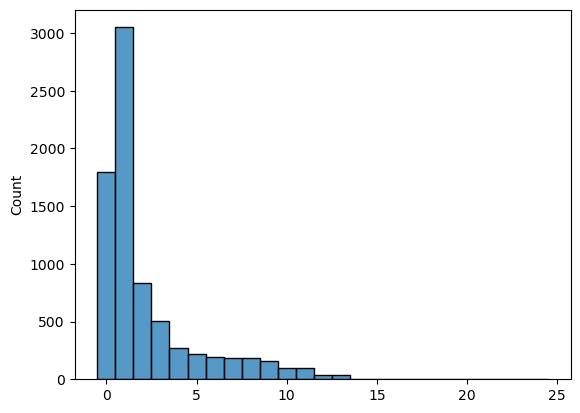

In [30]:
total_domains = 0
total_isoforms = 0
domain_type_counts = {}
isoforms_with_DNAbinding = 0
isoforms_with_PPI = 0
isoforms_with_xhistone = 0
genes_with_DNAbinding = 0
geneList_DNAbinding = []
domain_counts = []
for gene_id in seqs:
    if len(seqs[gene_id])<=1:
        continue
    if 'Swiss-Prot' in seqs[gene_id]["uniprot"]:
        uniprot_id = seqs[gene_id]["uniprot"]['Swiss-Prot']
        if type(uniprot_id)!=str:
            uniprot_id = uniprot_id[0]
    else:
        #print(seqs[gene_id]["uniprot"])
        uniprot_id = seqs[gene_id]["uniprot"]['TrEMBL']
    if type(uniprot_id)==list:
        uniprot_id = uniprot_id[0]
    interpro_url = f"https://www.ebi.ac.uk:443/interpro/api/entry/InterPro/protein/UniProt/{uniprot_id}/?page_size=200"
    req = request.Request(interpro_url, headers = {"Accept": "application/json"})
    res = request.urlopen(req)
    json_res = json.loads(res.read().decode())
    interpro_domains = {domain['metadata']['accession']:domain for domain in json_res['results'] 
                        if 'ssf' in domain['metadata']['member_databases']}
    for prot_id in seqs[gene_id]:
        if not prot_id.startswith("ENS"):
            continue
        total_isoforms+=1
        domain_counts.append(0)
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['interpro']=='' or domain['type']!='SuperFamily':
                continue
            total_domains+=1
            domain_counts[-1]+=1
            if domain['interpro'] in domain_type_counts:
                domain_type_counts[domain['interpro']]+=1
            else:
                domain_type_counts[domain['interpro']]=1
            #is_ppi = False
            #if domain['interpro'] in interpro_domains and \
            #   interpro_domains[domain['interpro']]['metadata']['go_terms'] is not None:
            #    for go_term in interpro_domains[domain['interpro']]['metadata']['go_terms']:
            #        if go_term['name']=='protein binding':
            #            is_ppi = True
            #domain['PPI'] = is_ppi
            if 'PPI' not in domain:
                domain['PPI'] = False
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['interpro']=='' or domain['type']!='SuperFamily':
                continue
            domain['DNA-binding'] = interpro_superfamily_domains_DBD.loc[domain['interpro'],"DNA-binding"]
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['interpro']=='' or domain['type']!='SuperFamily':
                continue
            domain['histone'] = interpro_superfamily_domains_DBD.loc[domain['interpro'],"Histone-interaction"]
        has_DNAbinding = False
        has_PPI = False
        has_histone = False
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['interpro']=='' or domain['type']!='SuperFamily':
                continue
            if domain['DNA-binding']:
                has_DNAbinding = True
            if domain['PPI']:
                has_PPI = True
            if domain['histone']:
                has_histone = True
        if has_DNAbinding:
            isoforms_with_DNAbinding += 1
        if has_PPI:
            isoforms_with_PPI += 1
        if has_histone:
            isoforms_with_histone +=1
    has_DNA = False
    for prot_id in seqs[gene_id]:
        if not prot_id.startswith("ENS"):
            continue
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['interpro']=='' or domain['type']!="SuperFamily":
                continue
            if domain["DNA-binding"]:
                has_DNA = True
                break
    if has_DNA:
        genes_with_DNAbinding += 1
        geneList_DNAbinding.append(gene_id)
print(f"Average domains per isoform: {total_domains/total_isoforms}")
sns.histplot(domain_counts, discrete=True);
#print(domain_type_counts)
print(f"Proportion of isoforms with DNA-binding: {isoforms_with_DNAbinding/total_isoforms}")
print(f"Proportion of isoforms with PPI: {isoforms_with_PPI/total_isoforms}")
print(f"Proportion of isoforms with histone interaction: {isoforms_with_histone/total_isoforms}")
print(f"Proportion of genes with DNA binding: {genes_with_DNAbinding/len(seqs)}")

In [68]:
print(total_isoforms)

7679


Dealing with only the genes with a DNA binding isoform

In [47]:
DNAbinding_seqs = {seq:seqs[seq] for seq in seqs 
                   if seq in geneList_DNAbinding}
len(DNAbinding_seqs)

1407

Get the refseq ids of each protein

In [5]:
server = biomart.BiomartServer('http://useast.ensembl.org/biomart')
mart = server.datasets['hsapiens_gene_ensembl']
#mart.show_filters()
attributes = ['refseq_peptide']
#for gene_id in DNAbinding_seqs:
for gene_id in DNAbinding_seqs:
    print(gene_id)
    for prot_id in DNAbinding_seqs[gene_id]:
        if not prot_id.startswith("ENS") or 'refseq_id' in DNAbinding_seqs[gene_id][prot_id]: continue
        response = mart.search({'attributes': attributes, 
                        'filters': {'ensembl_peptide_id': prot_id}
                       })
        data = response.raw.data.decode('ascii')
        print(prot_id)
        print(data.strip())
        DNAbinding_seqs[gene_id][prot_id]['refseq_id'] = data.strip()

ENSG00000101126
ENSG00000101544
ENSG00000139154
ENSG00000106546
ENSG00000063438
ENSG00000180318
ENSG00000156150
ENSG00000052850
ENSG00000169083
ENSG00000186103
ENSG00000117713
ENSG00000049618
ENSG00000189079
ENSG00000116017
ENSG00000179361
ENSG00000205143
ENSG00000032219
ENSG00000054267
ENSG00000196843
ENSG00000150347
ENSG00000143437
ENSG00000172379
ENSG00000133794
ENSG00000029153
ENSG00000004848
ENSG00000139352
ENSG00000183734
ENSG00000176009
ENSG00000187855
ENSG00000232237
ENSG00000123268
ENSG00000115966
ENSG00000162772
ENSG00000128272
ENSG00000169136
ENSG00000118217
ENSG00000213676
ENSG00000170653
ENSG00000172238
ENSG00000179774
ENSG00000168874
ENSG00000156273
ENSG00000112182
ENSG00000125492
ENSG00000143032
ENSG00000131668
ENSG00000043039
ENSG00000156127
ENSG00000168062
ENSG00000123685
ENSG00000114439
ENSG00000119866
ENSG00000127152
ENSG00000113916
ENSG00000161940
ENSG00000180535
ENSG00000205899
ENSG00000180828
ENSG00000125533
ENSG00000134107
ENSG00000123095
ENSG00000169594
ENSG0000

Remove redundancy in the overlapping domains in a gene from different isoforms

In [85]:
#this is based on SuperFamily and Pfam as first and second, respectively, and the rest sorted 
#by frequency in database
#sourcePriority = ['SuperFamily', 'Pfam', 'MobiDBLite', 'Seg', 'sifts', 'PANTHER', 
#                  'Gene3D', 'PRINTS', 'Smart', 'Prosite_profiles', 'CDD', 'Prosite_patterns', 
#                  'ncoils', 'alphafold', 'PIRSF', 'TIGRfam', 'TMHMM', 'SignalP']
#for gene_id in ["ENSG00000126456"]:
for gene_id in DNAbinding_seqs:
    print(gene_id)
    keeping_domains = []
    for classification in ["DNA-binding", "PPI"]:
        domain_queue = []
        for prot_id in DNAbinding_seqs[gene_id]:
            if not prot_id.startswith("ENS"):
                continue
            if "refseq_id" not in DNAbinding_seqs[gene_id][prot_id] or \
              DNAbinding_seqs[gene_id][prot_id]['refseq_id']=="":
                continue
            domain_queue += [domain for domain in DNAbinding_seqs[gene_id][prot_id]['domains'] 
                             if domain['type']=='SuperFamily' and \
                               domain['interpro']!='' and \
                               domain[classification]]
        #print("domain_queue:")
        #print(domain_queue)
        while len(domain_queue)>0:
            currDomain = domain_queue.pop()
            removeList = []
            for i, domain in enumerate(domain_queue):
                if (currDomain['start'] <= domain['start'] and 
                currDomain['end'] >= domain['start']) or \
                (currDomain['start'] <= domain['end'] and
                currDomain['end'] >= domain['end']) or \
                (currDomain['start'] >= domain['start'] and
                currDomain['end'] <= domain['end']):
                    if currDomain['end']-currDomain['start'] < domain['end']-domain['start']:
                        currDomain = domain
                    removeList.append(i)
            for i in removeList[-1::-1]:
                del domain_queue[i]
            keeping_domains.append(currDomain)
    #print("keeping_domains:")
    #print(keeping_domains)
    for prot_id in DNAbinding_seqs[gene_id]:
        if prot_id.startswith("ENS"):
            DNAbinding_seqs[gene_id][prot_id]['filtered_domains'] = \
              [domain for domain in keeping_domains if domain['seq_region_name']==prot_id]
#print(DNAbinding_seqs[gene_id]["ENSP00000366339"]['filtered_domains'])

ENSG00000101126
ENSG00000101544
ENSG00000139154
ENSG00000106546
ENSG00000063438
ENSG00000180318
ENSG00000156150
ENSG00000052850
ENSG00000169083
ENSG00000186103
ENSG00000117713
ENSG00000049618
ENSG00000189079
ENSG00000116017
ENSG00000179361
ENSG00000205143
ENSG00000032219
ENSG00000054267
ENSG00000196843
ENSG00000150347
ENSG00000143437
ENSG00000172379
ENSG00000133794
ENSG00000029153
ENSG00000004848
ENSG00000139352
ENSG00000183734
ENSG00000176009
ENSG00000187855
ENSG00000232237
ENSG00000123268
ENSG00000115966
ENSG00000162772
ENSG00000128272
ENSG00000169136
ENSG00000118217
ENSG00000213676
ENSG00000170653
ENSG00000172238
ENSG00000179774
ENSG00000168874
ENSG00000156273
ENSG00000112182
ENSG00000125492
ENSG00000143032
ENSG00000131668
ENSG00000043039
ENSG00000156127
ENSG00000168062
ENSG00000123685
ENSG00000114439
ENSG00000119866
ENSG00000127152
ENSG00000113916
ENSG00000161940
ENSG00000180535
ENSG00000205899
ENSG00000180828
ENSG00000125533
ENSG00000134107
ENSG00000123095
ENSG00000169594
ENSG0000

Get all isoforms of gene in fasta

In [28]:
gene_id = "ENSG00000126456"
prot_ids = list(DNAbinding_seqs[gene_id].keys())
print(prot_ids)
for prot_id in prot_ids:
    if not prot_id.startswith("ENS"): continue
    with open(gene_id + "/" + prot_id + ".fa", "w") as f:
        f.write(">" + prot_id + "\n")
        f.write(DNAbinding_seqs[gene_id][prot_id]['seq'] + "\n")

['ENSP00000366339', 'ENSP00000310127', 'ENSP00000470431', 'ENSP00000468911', 'ENSP00000471896', 'ENSP00000366344', 'ENSP00000469113', 'ENSP00000472601', 'ENSP00000470512', 'ENSP00000471358', 'ENSP00000472700', 'ENSP00000470069', 'ENSP00000472582', 'ENSP00000473128', 'ENSP00000472223', 'ENSP00000469067', 'ENSP00000471517', 'ENSP00000471402', 'ENSP00000473176', 'ENSP00000470140', 'ENSP00000400378', 'ENSP00000470905', 'uniprot']


Add the DNA binding sites for case-study

In [ ]:
gene_id = "ENSG00000126456"
prot_id = "ENSP00000471358"
seq = DNAbinding_seqs[gene_id][prot_id]['seq']
binding_site = SeqFeature.FeatureLocation(37,38) + \
               SeqFeature.FeatureLocation(39,42) + \
               SeqFeature.FeatureLocation(73,74) + \
               SeqFeature.FeatureLocation(76,78) + \
               SeqFeature.FeatureLocation(80,81) + \
               SeqFeature.FeatureLocation(85,86) + \
               SeqFeature.FeatureLocation(104,105)
DNAbinding_seqs[gene_id][prot_id]['binding_sites'] = [(binding_site, 'DNA')]
gene_id = "ENSG00000185507"
prot_id = "ENSP00000329411"
seq = DNAbinding_seqs[gene_id][prot_id]['seq']
binding_site = SeqFeature.FeatureLocation(56,57) + \
               SeqFeature.FeatureLocation(58,61) + \
               SeqFeature.FeatureLocation(101,102) + \
               SeqFeature.FeatureLocation(104,105) + \
               SeqFeature.FeatureLocation(108,109) + \
               SeqFeature.FeatureLocation(112,113) + \
               SeqFeature.FeatureLocation(132,133)
DNAbinding_seqs[gene_id][prot_id]['binding_sites'] = [(binding_site, 'DNA')]

print(binding_site.extract(seq))


Get "superisoform" based on CDS positions

In [87]:
mg = mygene.MyGeneInfo()

Entrez.email = "smadha@wpi.edu"
#irf3
#gene_id = "ENSG00000126456"
#irf7
#gene_id = "ENSG00000185507"
#nfkb
#gene_id = "ENSG00000109320"
#print(mg.getgene(gene_id)['genomic_pos'])
#for gene_id in ["ENSG00000126456"]:
for gene_id in DNAbinding_seqs:
    print(gene_id)
    #if 'superisoform' in DNAbinding_seqs[gene_id] and 'superdomains' in DNAbinding_seqs[gene_id]:
    #    continue
    gene_object = mg.getgene(gene_id)
    if gene_object is None:
        continue
    if type(gene_object) is list:
        gene_object = gene_object[0]
    if 'refseq' not in gene_object:
        continue
    if type(gene_object['genomic_pos']) is list:
        start_pos = gene_object['genomic_pos'][0]['start']
        end_pos = gene_object['genomic_pos'][0]['end']
        strand = gene_object['genomic_pos'][0]['strand']
    else:
        start_pos = gene_object['genomic_pos']['start']
        end_pos = gene_object['genomic_pos']['end']
        strand = gene_object['genomic_pos']['strand']
    handle = Entrez.efetch(db="nucleotide", 
                           id=gene_object['refseq']['genomic'][0],
                           seq_start=start_pos,
                           seq_stop=end_pos,
                           rettype="gb")
    record = SeqIO.read(handle, "gb")
    handle.close()
    reformed_exons = {}
    #print(mg.getgene(gene_id)['interpro'])
    symbol = gene_object["symbol"]

    for feature in record.features:
        if feature.type=="CDS" and symbol in feature.qualifiers['gene']:
            #print(feature)
            refseq_id = feature.qualifiers['protein_id'][0]
            for prot_id in DNAbinding_seqs[gene_id]:
                if "refseq_id" in DNAbinding_seqs[gene_id][prot_id] and \
                  DNAbinding_seqs[gene_id][prot_id]['refseq_id']!="" and \
                  re.search(DNAbinding_seqs[gene_id][prot_id]['refseq_id'], refseq_id) is not None:
                    #print(refseq_id)
                    #print(prot_id)
                    break
            these_domains = []
            if 'refseq_id' in DNAbinding_seqs[gene_id][prot_id] and \
              DNAbinding_seqs[gene_id][prot_id]['refseq_id']!="" and \
              re.search(DNAbinding_seqs[gene_id][prot_id]['refseq_id'], refseq_id):
                these_domains = DNAbinding_seqs[gene_id][prot_id]['filtered_domains']
            parts = enumerate(feature.location.parts)
            prepend_seq = ""
            exon_start = 0
            exon_end = 0
            #print(prot_id)
            #print(these_domains)
            for i, location in parts:
                exon_domains = {}
                tail_len = (len(prepend_seq)+len(location))%3
                if location.strand == 1:
                    this_location = SeqFeature.FeatureLocation(
                        location.start,
                        location.end-tail_len,
                        strand=location.strand)
                    next_location = SeqFeature.FeatureLocation(
                        location.end-tail_len, location.end, 
                        strand=location.strand)
                    this_seq = prepend_seq + this_location.extract(record)
                    exon_len = int(len(this_seq)/3)
                    exon_start = exon_end
                    exon_end = exon_start + exon_len
                    for domain in these_domains:
                        domain_start = None
                        domain_end = None
                        #domain in the exon
                        if domain['start'] > exon_start and \
                          domain['end'] < exon_end:
                            domain_start = domain['start']
                            domain_end = domain['end']
                        #domain starts in the exon, but ends after
                        elif domain['start'] > exon_start and \
                          domain['start'] < exon_end and \
                          domain['end'] > exon_end:
                            domain_start = domain['start']
                            domain_end = exon_end
                        #domain starts before exon, but ends in
                        elif domain['start'] < exon_start and \
                          domain['end'] > exon_start and \
                          domain['end'] < exon_end:
                            domain_start = exon_start
                            domain_end = domain['end']
                        #domain contains exon
                        elif domain['start'] < exon_start and \
                          domain['end'] > exon_end:
                            domain_start = exon_start
                            domain_end = exon_end
                        if domain_start is not None:
                            #print(domain)
                            #print(domain['start'], exon_start, domain_start, domain['start'] - exon_start)
                            #print(domain['end'], exon_end, domain_end, exon_end - domain['end'])
                            exon_domains[".".join([str(domain_start), 
                                                   str(domain_end),
                                                   str(max(domain['start'] - exon_start, 0)), 
                                                   str(max(exon_end - domain['end'], 0))])] = domain
                elif location.strand == -1:
                    this_location = SeqFeature.FeatureLocation(
                        location.start+tail_len,
                        location.end,
                        strand=location.strand)
                    next_location = SeqFeature.FeatureLocation(
                        location.start, location.start+tail_len, 
                        strand=location.strand)
                    this_seq =  prepend_seq + this_location.extract(record)
                    exon_len = int(len(this_seq)/3)
                    exon_start = exon_end
                    exon_end = exon_start + exon_len
                    for domain in these_domains:
                        domain_start = None
                        domain_end = None
                        #domain in the exon
                        if domain['start'] > exon_start and \
                          domain['end'] < exon_end:
                            domain_start = domain['start']
                            domain_end = domain['end']
                        #domain starts in the exon, but ends after
                        elif domain['start'] > exon_start and \
                          domain['start'] < exon_end and \
                          domain['end'] > exon_end:
                            domain_start = domain['start']
                            domain_end = exon_end
                        #domain starts before exon, but ends in
                        elif domain['start'] < exon_start and \
                          domain['end'] > exon_start and \
                          domain['end'] < exon_end:
                            domain_start = exon_start
                            domain_end = domain['end']
                        #domain contains exon
                        elif domain['start'] < exon_start and \
                          domain['end'] > exon_end:
                            domain_start = exon_start
                            domain_end = exon_end
                        if domain_start is not None:
                            #print(domain)
                            #print(domain['start'], exon_start, domain_start, domain['start'] - exon_start)
                            #print(domain['end'], exon_end, domain_end, exon_end - domain['end'])
                            exon_domains[".".join([str(domain_start).strip("<>"), 
                                                   str(domain_end).strip("<>"),
                                                   str(max(domain['start'] - exon_start, 0)).strip("<>"), 
                                                   str(max(exon_end - domain['end'], 0)).strip("<>")])] = domain
                exon_key = ".".join([str(location.start).strip("<>"), 
                                         str(location.end).strip("<>"),
                                         prepend_seq, 
                                         str(tail_len)])
                if not exon_key in reformed_exons:
                    reformed_exons[exon_key] = {'seq':this_seq.translate().seq, 'domains': exon_domains}
                else:
                    reformed_exons[exon_key]['domains'].update(exon_domains)
                prepend_seq = str(next_location.extract(record).seq)
                #if isinstance(location.start, SeqFeature.BeforePosition):
                    #print(location.start)
    #print(reformed_exons)
    tmp = [el.split(".") for el in list(reformed_exons.keys())]
    for el in tmp:
        el[0] = int(el[0])
        el[1] = int(el[1])
        el[3] = int(el[3])
    tmp.sort()
    for el in tmp:
        el[0] = str(el[0])
        el[1] = str(el[1])
        el[3] = str(el[3])
    tmp = [".".join(el) for el in tmp]
    superisoform = ""
    #print(tmp)
    if strand == -1:
        tmp = tmp[::-1]
    superdomains = {}
    for exon in tmp:
        if len(reformed_exons[exon]['domains'])>0:
            #print(reformed_exons[exon]['domains'])
            for domain in reformed_exons[exon]['domains']:
                domain_start = int(domain.split(".")[2]) + len(superisoform)
                domain_end = int(domain.split(".")[1]) - int(domain.split(".")[0]) + domain_start
                #print(reformed_exons[exon]['domains'][domain]['seq_region_name'], domain_start, domain_end)
                if str(reformed_exons[exon]['domains'][domain]) not in superdomains:
                    superdomains[str(reformed_exons[exon]['domains'][domain]['interpro'])] = \
                      SeqFeature.FeatureLocation(domain_start, domain_end)
                else:
                    superdomains[str(reformed_exons[exon]['domains'][domain]['interpro'])] += \
                      SeqFeature.FeatureLocation(domain_start, domain_end)
        superisoform += reformed_exons[exon]['seq']
        #print(exon)
        #print(reformed_exons[exon]['seq'])
    DNAbinding_seqs[gene_id]['superisoform'] = superisoform
    DNAbinding_seqs[gene_id]['superdomains'] = superdomains
    print(superisoform)
    print(superdomains)

ENSG00000101126
MHNAKPRPQLLHHDAQGCTFCTELIGGLVVMPCTTILRIWTPFPALLFGPHCQFTPDLSSCSSTFVAETEMLKFAKQETMFQLPVNNLGSLRKARKTVKKILSDIGLEYCKEHIEMFQLPVNNLGSLRKARKTVKKILSDIGLEYCKEHIEDFKQFEPNDFYLKNTTWEDVGLWDPSLTKNQDYRTKPFCCSACPFSSKFFSAYKSHFRNVHSEDFENRILLNCPYCTFNADKKTLETHIKIFHAPNASAPSSSLSTFKDKNKNDGLKPKQADSVEQAVYYCKKCTYRDPLYEIVRKHIYREHFQHVAAPYIAKAGEKSLNGAVPLGSNAREESSIHCKRCLFMPKSYEALVQHVIEDHERIGYQVTAMIGHTNVVVPRSKPLMLIAPKPQDKKSMGLPPRIGSLASGNVRSLPSQQMVNRLSIPKPNLNSTGVNMMSSVHLQQNNYGVKSVGQGYSVGQSMRLGLGGNAPVSIPQQSQSVKQLLPSGNGRSYGLGSEQRSQAPARYSLQSANASSLSSGQLKSPSLSQSQASRVLGQSSSKPAAAATGPPPGNTSSTQKWKICTICNELFPENVYSVHFEKEHKAEKVPAVANYIMKIHNFTSKCLYCNRYLPTDTLLNHMLIHGLSCPYCRSTFNDVEKMAAHMRMVHIDEEMGPKTDSTLSFDLTLQQGSHTNIHLLVTTYNLRDAPAESVAYHAQNNPPVPPKPQPKVQEKADIPVKSSPQAAVPYKKDVGKTLCPLCFSILKGPISDALAHHLRERHQVIQTVHPVEKKLTYKCIHCLGVYTSNMTASTITLHLVHCRGVGKTQNGQDKTNAPSRLNQSPSLAPVKRTYEQMEFPLLKKRKLDDDSDSPSFFEEKPEEPVVLALDPKGHEDDSYEARKSFLTKYFNKQPYPTRREIEKLAASLWLWKSDIASHFSNKRKKCVRDCEKYKPGVLLGFNMKELNKVKHEMDFDAEWLFENHDEKDSRVNASKTADKKLNLG

MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAASAAPPGASLLLLQQQQQQQQQQQQQQQQQQQQQQQETSPRQQQQQQGEDGSPQAHRRGPTGYLVLDEEQQPSQPQSALECHPERGCVPEPGAAVAASKGLPQQLPAPPDEDDSAAPSTLSLLGPTFPGLSSCSADLKDILSEASTMQLLQQQQQEAVSEGSSSGRAREASGAPTSSKDNYLGGTSTISDNAKELCKAVSVSMGLGVEALEHLSPGEQLRGDCMYAPLLGVPPAVRPTPCAPLAECKGSLLDDSAGKSTEDTAEYSPFKGGYTKGLEGESLGCSGSAAAGSSGTLELPSTLSLYKSGALDEAAAYQSRDYYNFPLALAGPPPPPPPPHPHARIKLENPLDYGSAWAAAAAQCRYGDLASLHGAGAAGPGSGSPSAAASSSWHTLFTAEEGQLYGPCGGGGGGGGGGGGGGGGGGGGGGGEAGAVAPYGYTRPPQGLAGQESDFTAPDVWYPGGMVSRVPYPSPTCVKSEMGPWMDSYSGPYGDMMILWLHSLETARDHVLPIDYYFPPQKTCLICGDEASGCHYGALTCGSCKVFFKRAAERLETARDHVLPIDYYFPPQKTCLICGDEASGCHYGALTCGSCKVFFKRAAERNTRRKRLWKLIIRSINSCICSPRETEVPVRQQK*GKQKYLCASRNDCTIDKFRRKNCPSCRLRKCYEAGMTLGAAVVVSERILRVFGVSEWLP*EKFRVGNCKHLKMTRP*ARKLKKLGNLKLQEEGEASSTTSPTEETTQKLTVSHIEGYECQPIFLNVLEAIEPGVVCAGHDNNQPDSFAALLSSLNELGERQLVHVVKWAKALPGFRNLHVDDQMAVIQYSWMGLMVFAMGWRSFTNVNSRMLYFAPDLVFNEYRMHKSRMYSQCVRMRHLSQEFGWLQITPQEFLCMKALLLFSIIPVDGLKNQKFFDELRMNYIKELDRIIACKRKNPTSCSRRFYQLTKLLDSVQPI

MKLQAVMETLLQRQQRARQELEARQQLPPDPPAAPPGRARAAPDEDREPESARMQRAQMAALAAMRAAAAGLGHPASPGGSEDGPPGSEEEDAAREGTPGSPGRGREGPGEEHFEDMASDEDMKPKWEEEEMEEDLGEDEEEEEEDYEDEEEEEDEEGLGPPGPASLGTTALFPRKAQPPQAFRGDGVPRVLGGQERPGPGPAHPGGAAHVAPQLQPPDHGDWTYEEQFKQMSHPTWLYELDGDPKRKEFLDDLFSFMQKRGTPVNRIPIMAKQVLDLFMLYVLVTEKGGLVEVINKKLWREITKGLNLPTSITSAAFTLRTQYMKYLYPYECEKRGLSNPNELQAAIDSNRREGRRQSFGGSLFAYSPGGAHGMLSSPKLPVSSLGLAASTNGSSITPAPKIKKEEDSAIPITVPGRLPVSLAGHPVVAAQAAAVQAAAAQAAVAAQAAALEQLREKLESAEPPEKKMALVADEQQRLMQRALQQNFLAMAAQLPMSIRINSQASESRQDSAVNLTGTNGSNSISMSVEINGIMYTGVLFAQPPAPTPTSAPNKGGGGGGGSSSNAGGRGGNTGTSGGQAGPAGLSTPSTSTSNNSLP*
{'IPR036431': FeatureLocation(ExactPosition(322), ExactPosition(351))}
ENSG00000179361
MEPLQQQQQQQQQQQKQPHLAPLQMDAREKQGQQMREAQFLYAQKLVTQPTLLSATAGRPSGSTPLGPLARVPPTAAVAQVFERGNMNSEPEEEDGGLEDEDGDDEVAEVAEKETQAASKYFHVQKVARQDPRVAPMSNLLPAPGLPPHGQQAKEDHTKDASKASPSVSTAGQPNWNLDEQLKQNGGLAWSDDADGGRGREISRDFAKLYELDGDPERKEFLDDLFVFMQKRGTPINRIPIMAKQILDLYMLYKLVTEKGGLVEIINKKIWREITKGLNLPTSITSAAFTLRTQYMKYLYAYECEKKALSSP

MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKRRSGMDFDDEDGEGPSKFSRENHSEIERRRRNKMTQYITELSDMVPTCSALARKPDKLTILRMAVSHMKSMRGTGNKSTDGAYKPSFLTEQELKHLILEAADGFLFVVAAETGRVIYVSDSVTPVLNQPQSEWFGSTLYEQVHPDDVEKLREQLCTSENSMTGRILDLKTGTVKKEGQQSSMRMCMGSRRSFICRMRCGNAPLDHLPLNRITTMRKRFRNGLGPVKEGEAQYAVVHCTGYIKAWPPAGMTIPEEDADVGQGSKYCLVAIGRLQVTSSPVCMDMNGMSVPTEFLSRHNSDGIITFVDPRCISVIGYQPQDLLGKDILEFCHPEDQSHLRESFQQVVKLKGQVLSVMYRFRTKNREWMLIRTSSFTFQNPYSDEIEYIICTNTNVKQLQQQQAELEVHQRDGLSSYDLSQVPVPNLPAGVHEAGKSVEKADAIFSQERDPRFAEMFAGISASEKKMMSSASAAGTQQIYSQGSPFPSGHSGKAFSSSVVHVPGVNDIQSSSSTGQNMSQISRQLNQSQVAWTGSRPPFPGQQIPSQSSKTQSSPFGIGTSHTYPADPSSYSPLSSPATSSPSGNAYSSLANRTPGFAESGQSSGQFQGRPSEVWSQWQSQHHGQQSGEQHSHQQPGQTEVFQDMLPMPGDPTQGTGNYNIEDFADLGMFPPFSE*
{'IPR036638': FeatureLocation(ExactPosition(136), ExactPosition(148))}
ENSG00000133794
MTAPVGHLEVMMNAKNVVLARVYTFGPKLNFSNVESWAFIDHPMADQRMDISSTISDFMSPGPTDLLSSSLGTSGVDCNRKRKGSSTDYMADQRMDISSTISDFMSPGPTDLLSSSLGTSGVDCNRKRKGSSTDYMSFLLKFTGRIWGAQWLEVRCPLGDAMINMINIESMDTDKDDPHGQESMDTDKDDPHGR

MKYGRRQTVCVQCPGLWTMGDDRPFVCNAPGCGQRFTNEDHLAVHKHKHEMTLKFGPARTDSVIIADQTPTPTRFLKNCEEDQTPTPTRFLKNCEEVGLFNELASSFEHEFKKAADEDEKKDQTPTPTRFLKNCEEVGLFNELASSFEHEFKKAADEDEKKARSRTVAKKLVDQTPTPTRFLKNCEEVGLFNELASSFEHEFKKAADEDEKKARSRTVAKKLVVFRPRLFLLCFGIIFLIG*AAAGPLDMSLPSTPDIKIKEEEPVEAAAGPLDMSLPSTPDIKIKEEEPVEVDSSPPDSPASSPCSPPLKEKEVTPKPVLISTPTPTIVRPGSLPLHLGYDPLHPTLPSPTSVITQAPPSNRQMGSPTGSLPLVMHLANGQTMPVLPGPPVQMPSVISLARPVSMVPNIPGIPGPPVNSSGSISPSGHPIPSEAKMRLKATLTHQVSSINGGCGMVVGTASTMVTARPEQSQILIQHPDAPSPAQPQVSPAQPTPSTGGRRRRTVDEDPDERRQRFLERNRAAASRCRQKRKLWVSSLEKKAEELTSQNIQLSNEVTLLRNEVAQLKQLLLAHKDCPVTALQKKTQGYLESPKESSEPTGSPAPVIQHSSATAPSNGLSVRSAAEAVATSVLTQMASQRTELSMPIQSHVIMTPQSQSAGR*
{'IPR036236': FeatureLocation(ExactPosition(34), ExactPosition(49))}
ENSG00000172238
MSRLLHAEEWAEVKELGDHHRQPQPHHLPQPPPPPQPPATLQAREHPVYPPELSLLDSTDPRAWLAPTLQGICTARAAQYLLHSPELGASEAAAPRDEVDGRGELVRRSSGGASSSKSPGPVKVREQLCKLKGGVVVDELGCSRQRAPSSKQVNGVQKQRRLAANARERRRMHGLNHAFDQLRNVIPSFNNDKKLSKYETLQMAQIYINALSELLQTPSGGEQPPPPPASCKSDHHHLRTAASYEGGAGNA

MSRRKQGNPQHLSQRELITPEADHVEAAILEEDEGLEIEEPSGLGLMVGGPDPDLLTCGQCQMNFPLGDILVFIEHKRKQCGGSLGACYDKALDKDSPPPSSRSELRKVSEPVEIGIQVTPDEDDHLLSPTKGICPKQENIAQADHVEAAILEEDEGLEIEEPSGLGLMVGGPDPDLLTCGQCQMNFPLGDILVFIEHKRKQCGGSLGACYDKALDKDSPPPSSRSELRKVSEPVEIGIQVTPDEDDHLLSPTKGICPKQENIAMVGGPDPDLLTCGQCQMNFPLGDILVFIEHKRKQCGGSLGACYDKALDKDSPPPSSRSELRKVSEPVEIGIQVTPDEDDHLLSPTKGICPKQENIAGPCRPAQLPAVAPIAASSHPHSSVITSPLRALGALPPCLPLPCCSARPVSGDGTQGEGQTEAPFGCQCQLSRPCRPAQLPAVAPIAASSHPHSSVITSPLRALGALPPCLPLPCCSARPVSGDGTQGEGQTEAPFGCQCQLSGKDEPSSYICTTCKQPFNSAWFLLQHAQNTHGFRIYLEPGPASSSLTPRLTIPPPLGPEAVAQSPLMNFLGDSNPFNLLRMTGPILRDHPGFGEGRLPGTPPLFSPPPRHHLDPHRLSAEEMGLVAQHPSAFDRVMRLNPMAIDSPAMDFSRRLRELAGNSSTPPPVSPGRGNPMHRLLNPFQPSPKSPFLSTPPLPPMPPGGTPPPQPPAKSKSCEFCGKTFKFQSNLIVHRRSHTGEKPYKCQLCDHACSQASKLKRHMKTHMHKAGSLAGRSDDGLSAASSPEPGTSELAGEGLKAADGDFRHHESDPSLGHEPEEEDEEEEEEEEELLLENESRPESSFSMDSELSRNRENGGGGVPGVPGAGGGAAKALADEKALVLGKVMENVGLGALPQYGELLADKQKRGAFLKRAAGGGDAGDDDDAGGCGDAGAGGAVNGRGGGFAPGTEPFPGLFPRKPAPLPSPGLNSAAKRIKVEKDLELPPAALIPSENVYSQW

MPRIMIKGGVWRNTEDEILKAAVMKYGKNQWSRIASLLHRKSAKQCKARWYEWLDPSIKKTEWSREEEEKLLHLAKLMPTQWRTIAPIIGRTAAQCLEHYEFLLDKAAQRDNEEETTDDPRKLKPGEIDPNPETKPARPDPIDMDEDELEMLSEARARLANTQGKKAKRKAREKQLEEAMCIYVYICTLTFIQSWIILYGFNEKSAVNLTEISRRLAALQKRRELRAAGIEIQKKRKRKRGVDYNAEIPFEKKPALGFYDTSEENYQALDADFRKLRQQDLDGELRLRLAALQKRRELRAAGIEIQKKRKRKRGVDYNAEIPFEKKPALGFYDTSEENYQALDADFRKLRQQDLDGELRSEKEGRDRKKDKQHLKRKKESDLPSAILQTSGVSEFTKKRSKLVLPAPQISDAELQEVVKVGQASEIARQTAEESGITNSASSTLLSEYNVTNNSVALRTPRTPASQDRILQEAQNLMALTNVDTPLKGGLNTPLHESDFSGVTPQRQVVQTPNTVLSTPFRTPSNGAEGLTPRSGTTPKPVINSTPGRTPLRDKLNINPEDGMADYSDPSYVKQMERESREHLRLGLLGLPAPKNDFEIVLPENAEKELEEREIDDTYIEDAADVDARKQAIRDAERVKEMKRMHKAVQKDLPRPSEVNETILRPLNVEPPLTDLQKSEELIKKEMITMLHYDLLHHPYEPSGNKKGKTVGFGTNNSEHITYLEHNPYEKFSKEELKKAQDVLVQEMEVVKQGMSHGELSSEAYNQVWEECYSQVLYLPGQSRYTRANLASKKDRIESLEKRLEINRGHMTTEAKRAAKMEKKMKILLGGYQSRAMGLMKQLNDLWDQIEQAHLELRTFEELKKHEDSAIPRRLECLKEDVQRQQEREKELQHRYADLLLEKETLKSKF*
{'IPR009057': FeatureLocation(ExactPosition(103), ExactPosition(112))}
ENSG00000113722
MY

MLFTVSCSKMSSIVDRDDSSIFDGLVEEDDKDKAKRVSRNKSEKKRRDQFNVLIKELGSMLPGNARKMDKSTVLQKSIDFLRKHKEITAQSDASEIRQDWKPTFLSNEEFTQLMLEALDGFFLAIMTDGSIIYVSESVTSLLEHLPSDLVDQSIFNFIPEGEHSEVYKILSTHLLESDSLTPEYLKSKNQLEFCCHMLRGTIDPKEPSTYEYVKFIGNFKSLNSVSSSAHNGFEGTIQRTHRPSYEDRVCFVATVRLATPQFIKEMCTVEEPNEEFTSRHSLEWKFLFLDHRAPPIIGYLPFEVLGTSGYDYYHVDDLENLAKCHEHLMQYGKGKSCYYRFLTKGQQWIWLQTHYYITYHQWNSRPEFIVCTHTVVSYAEVRAERRRELGIEESLPETAADKSQDSGSDNRINTVSLKEALERFDHSPTPSASSRSSRKSSHTAVSDPSSTPTKIPTDTSTPPRQHLPAHEKMVQRRSSFSSQSINSQSVGSSLTQPVMSQATNLPIPQGMSQFQFSAQLGAMQHLKDQLEQRTRMIEANIHRQQEELRKIQEQLQMVHGQGLQMFLQQSNPGLNFGSVQLSSGNSSNIQQLAPINMQGQVVPTNQIQSGMNTGHIGTTQHMIQQQTLQSTSTQSQQNVLSGHSQQTSLPSQTQSTLTAPLYNTMVISQPAAGSMVQIPSSMPQNSTQSAAVTTFTQDRQIRFSQGQQLVTKLVTAPVACGAVMVPSTMLMGQVVTAYPTFATQQQQSQTLSVTQQQQQQSSQEQQLTSVQQPSQAQLTQPPQQFLQTSRLLHGNPSTQLILSAAFPLQQSTFPQSHHQQHQSQQQQQLSRHRTDSLPDPSKVQPQ*
{'IPR036638': FeatureLocation(ExactPosition(85), ExactPosition(104))}
ENSG00000118260
MTMESGAENQQSGDAAVTEAENQQMTVQAQPQIATLAQVSMPAAHATSSAPTVTLVQLPNGQTVQV

MAATEISVLSEQFTKIKELELMPEKGLKEEEKDGVCREKDHRSPSELEAERTSGAFQDSVLEEEVELVLAPSEESEKYILTLQTVHFTSEAVELQDMSLLSIQQQEGVQVVVQQPGPGLLWLEEGPRQSLQQCVAISIQQELYSPQEMEVLQFHALEENVMVASEDSKLAVSLAETTGLIKLEEEQEKNQLLAERTKEQLFFVETMSGDERSDEIVLTVSNSNVEEQEDQPTAGQADAEKAKSTKNQRKTKMSGDERSDEIVLTVSNSNVEEQEDQPTAGQADAEKAKSTKNQRKTKGAKGTFHCDVCMFTSSRMSSFNRHMKTHTSEKPHLCHLCLKTFRTVTLLRNHVNTHTMFTSSRMSSFNRHMKTHTSEKPHLCHLCLKTFRTVTLLRNHVNTHTGTRPYKCNDCNMAFVTSGELVRHRRYKHTHEKPFKCSMCKYASVEGTRPYKCNDCNMAFVTSGELVRHRRYKHTHEKPFKCSMCKYASVEVKPFLDLKLHGILVEAAVQVTPSVTNSRICYKQAFYYSYKIYAGNNMHSLL*ASKLKRHVRSHTGERPFQCCQCSYASRDTYKLKRHMRTHSGEKPYECHICHTRFTQSGTMKIHILQKHGENVPKYQCPHCATIIARKSDLGVHMRNLHAYSAAELKCRYCSAVFHERYALIQHQKTHKNEKRFKCKHCSYACKQRVHMRNLHAYSAAELKCRYCSAVFHERYALIQHQKTHKNEKRFKCKHCSYACKQERHMTAHIRTHTGEKPFTCLSCNKCFRQKQLLNAHFRKYHDANFIPTVYKCSKCGKGFSRWVLY*ITSKWSGLKPQTFIT*ILWVGNSEVAELGGPGSGPLLRLQSGCPPGLHHPKAGLGPEDPLPGQLRHTTAGTGLSSLLQGPLCRAA*INLHRHSEKCGSGEAKSAASGKGRRTRKRKQTILKEATKGQKEAAKGWKEAANGDGVISAHRNLCLLGSSDSHASVSGAGITDARHHAWLIVLLFLVEMGFYHVSHS*E

MTGVFDSLVADMHSTQIAASSTYHQHQQPPSGGGAGPGGNSSSSSSLHKPQESPTLPVSTATDSSYYTNQQHPAGGGGGGGSPYAHMGSYQYQASGLNNVPYSAKSSYDLGYTAAYTSYAPYGTSSSPANNEPEKEDLEPEIRIVNGKPKKVRKPRTIYSSFQLAALQRRFQKTQYLALPERAELAASLGLTQTQVKIWFQNRRSKFKKMWKSGEIPSEQHPGASASPPCASPPVSAPASWDFGVPQRMAGGGGPGSGGSGAGSSGSSPSSAASAFLGNYPWYHQTSGSASHLQATAPLLHPTQTPQPHHHHHHHGGGGAPVSAGTIF*
{'IPR009057': FeatureLocation(ExactPosition(195), ExactPosition(210))}
ENSG00000064195
MSGSFDRKLSSILTDISSSLSCHAGSKDSPTLPESSVTDLGYYSAPQHDYYSGQPYGQTVNPYTYHHQFNLNGLAGTGAYSPKSEYTYGASYRQYGAYREQPLPAQDPVSVKEEPEAEVRMVNGKPKKVRKPRTIYSSYQLAALQRRFQKAQYLALPERAELAAQLGLTQTQVKIWFQNRRSKFKKLYKNGEVPLEHSPNNSDSMACNSPPSPALWDTSSHSTPAPARSQLPPPLPYSASPSYLDDPTNSWYHAQNLSGPHLQQQPPQPATLHHASPGPPPNPGAVY*
{'IPR009057': FeatureLocation(ExactPosition(172), ExactPosition(187))}
ENSG00000108813
MTSLPCPLPGRDASKAVFPDLAPVPSVAAAYPLGLSPTTAASPNLSYSRPYGHLLSYPYTEPANPGDSYLSCQQPAALSQPLCGPAEHPQELEAMKLSVLPPRSLLAPYTVLCCPPDSEKPRLSPEPSERRPQAPAKKLRKPRTIYSSLQLQHLNQRFQHTQYLALPERAQLAAQLGLTQTQDSEKPRLSPEPSERRPQAPAKKLRK

MLLLPSAADGRGTAITHALTSASTLCQVEPVGRWFEAFVKRRNRNASASFQELEDKKELSEESEDEELQLEEFPMLKTLDPKDWKMLKTLDPKDWKNQDHYAVLGLGHVRYKATQRQIKAAHKAMVLKHHPDKRKAAGEPIKEGDNDYFTCITKAYEMLSDPVKRRAFNSVDPTFDNSVPSKSEAKDNFFEVFTPVFERNSMLSDPVKRRAFNSVDPTFDNSVPSKSEAKDNFFEVFTPVFERNSRWSNKKNVPKLGDMNSSFEDVDIFYSFMNSSFEDVDIFYSFWYNFDSWREFSYLDEEEKEKAECRDERRWIEKQNRATRAQRKKEEMNRIRTLVDNAYSCDPRIKKFKEEEKAKKEAEKKAKAEAKRKEQEAKEKQRQAELEAARLAKEKEEEEVRQQALLAKKEKDIQKKAIKKERQKLRNSCKTWNHFSDNEAERVKMMEEVEKLCDRLELASLQCLNETLTSCTKEVGKAALEKQIEEINEQIRKEKEEAEARMRQASKNTEKSTGGGGNGSKNWSEDDLQLLIKAVNLFPAGTNSRWEVIANYMNIHSSSGVKRTAKDVIGKAKSLQKLDPHQKDDINKKAFDKFKKEHGVVPQADNATPSERFEGPYTDFTPWTTEEQKLLEQALKTYPVNTPERWEKIAEAVPGRTKKDCMKRYKELVEMVKAKKAAQEQVLNASRAKK*
{}
ENSG00000133884
MAAVVENVVKLLGEQYYKDAMEQCHNYNARLCAERSVRLPFLDSQTGVAQSNCYIWMEKRHRGPMEQCHNYNARLCAERSVRLPFLDSQTGVAQSNCYIWMEKRHRGPGLASGQLYSYPARRWRKKRRAHPPEDPRLSFPSIKPDTDQTLKKEGLISQDGSSLEALLRTDPLEKRGAPDPRVDDDSLGEFPVTNSRARKRILEPDDFLDDLDDEDYEEDTPKRRGKGKSKGKGVGSARKKLDASILEDRDKPYACDNSFKQKHTSKAPQRICGKRYKNRPGLSYHYAHS

MAAAKAEMQLMSPLQISDPFGSFPHSPTMDNYPKLEEMMLLSNGAPQFLGAAGAPEGSGSNSSSSSSGGGGGGGGGSNSSSSSSTFNPQADTGEQPYEHLTAESFPDISLNNEKVLVETSYPSQTTRLPPITYTGRFSLEPAPNSGNTLWPEPLFSLVSGLVSMTNPPASSSSAPSPAASSASASQSPPLSCAVPSNDSSPIYSAAPTFPTPNTDIFPEPQSQAFPGSAGTALQYPPPAYPAAKGGFQVPMIPDYLFPQQQGDLGLGTPDQKPFQGLESRTQQPSLTPLSTIKAFATQSGSQDLKALNTSYQSQLIKPSRMRKYPNRPSKTPPHERPYACPVESCDRRFSRSDELTRHIRIHTGQKPFQCRICMRNFSRSDHLTTHIRTHTGEKPFACDICGRKFARSDERKRHTKIHLRQKDKKADKSVVASSATSSLSSYPSPVATSYPSPVTTSYPSPATTSYPSPVPTSFSSPGSSTYPSPVHSGFPSPSVATTYSSVPPAFPAQVSSFPSSAVTNSFSASTGLSDMTATFSPRTIEIC*
{'IPR036236': FeatureLocation(ExactPosition(362), ExactPosition(414))}
ENSG00000122877
MRVGLPSEASSCPWSARGPRDPPERRRSGLAHVMMTAKAVDKIPVTLSGFVHQLSDNIYPVEDLAATSVTIFPNAELGGPFDQMNGVAGLSDNIYPVEDLAATSVTIFPNAELGGPFDQMNGVAGMNGVAGDGMINIDMTGEKRSLDLPYPSSFAPVSAPRNQTFTYMGKFSIDPQYPGASCYPEGIINIVSAGILQGVTSPASTTASSSVTSASPNPLATGPLGVCTMSQTQPDLDHLYSPPPPPPPYSGCAGDLYQDPSAFLSAATTSTSSSLAYPPPPSYPSPKPATDPGLFPMIPDYPGFFPSQCQRDLHGTAGPDRKPFPCPLDTLRVPPPLTPLSTIRNFTLGGPSAGVTGPGASGGSEGPR

MDSAITLWQFLLQLLQKPQNKHMICWTSNDGQFKLLQAEEVARLWGIRKNKPNMNYDKLSRALRYYYVKNIIKKVNGQKFVYKFVSYPEILNMDPMTVGRIEGDCESLNFSEVSSSSKDVENGGKDKPPQPGAKTSSRNDYIHSGLYSSFTLNSLNSSNVKLFKLIKTENPAEKLAEKKSPQEPTPSVIKFVTTPSKKPPVEPVAATISIGPSISPSSEETIQALETLVSPKLPSLEAPTSASNVMTAFATTPPISSIPPLQEPPRTPSPPLSSHPDIDTDIDSVASQPMELPENLSLEPKDQDSVLLEKDKVNNSSRSKKPKGLELAPTLVITSSDPSPLGILSPSLPTASLTPAFFSQNIIKKVNGQKFVYKFVSYPEILNMDPMTVGRIEGDCESLNFSEVSSSSKDVENGGKDKPPQPGAKTSSRNDYIHSGLYSSFTLNSLNSSNVKLFKLIKTENPAEKLAEKKSPQEPTPSVIKFVTTPSKKPPVEPVAATISIGPSISPSSEETIQALETLVSPKLPSLEAPTSASNVMTAFATTPPISSIPPLQEPPRTPSPPLSSHPDIDTDIDSVASQPMELPENLSLEPKDQDSVLLEKDKVNNSSRSKKPKGLELAPTLVITSSDPSPLGILSPSLPTASLTPAFFSQVACSLFMVSPLLSFICPFKQIQNLYTQVCFLLLRFVLERLCVTVM*TPIILTPSPLLSSIHFWSTLSPVAPLSPARLQGANTLFQFPSVLNSHGPFTLSGLDGPSTPGPFSPDLQKT*
{'IPR036390': FeatureLocation(ExactPosition(360), ExactPosition(446))}
ENSG00000156030
MNLQAQPKAQNKRKRCLFGGQEPAPKEQPPPLQPPQQSIRVKEEQYLGHEGPGGAVSTSQPVELPPPSSLALLNSVVYGPERTSAAMLSQQVASVKWPNSVMAPGRGPERGGGGGVSDSSWQQQPGQPPPHSTWNCHSLSLYS

MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVDSHHEYPAMTFYSPAVMNYSIPSNVTNLEGGPGRQTTSPNVLWPTPGHLSPLVVHRQLSHLYAEPQKSPWCEARSLEHTLPVNRETLKRKVSGNRCASPVTGPGSKRDAHFCAVCSDYASGYHYGVWSCEGCKAFFKRSIQGHNDYICPATNQCTIDKNRRKSCQACRLRKCYEVGMVKCGSRRERCGYRLVRRQRSADEQLHCAGKAKRSGGHAPRVRELLLDALSPEQLVLTLLEAEPPHVLISRPSAPFTEASMMMSLTKLADKELVHMISWAKKIPGFVELSLFDQVRLLESCWMEVLMMGLMWRSIDHPGKLIFAPDLVLDGMRGNA*RDEGKCVEGILEIFDMLLATTSRFRELKLQHKEYLCVKAMILLNSGMYPLVTATQDADSSRKLAHLLNAVTDALVWVIAKSGISSQQQSMRLANLLMLLSHVRHASMYPLVTATQDADSSRKLAHLLNAVTDALVWVIAKSGISSQQQSMRLANLLMLLSHVRHASNKGMEHLLNMKCKNVVPVYDLLLEMLNAHVLRGCKSSITGSECSPAEDSKSKEGSQNPQSQ*RSCVYK*RWGEKQFIHLKLS*RAEKASQTLTSFGMKMETLLPEATMEQ*
{'IPR035500': FeatureLocation(ExactPosition(535), ExactPosition(565))}
ENSG00000173153
MGLSVQVTSAMSSQVVGIEPLYIKAEPASPDSPKGSSETETEPPVALAPGPAPTRCLPGHKEEEDGEGAGPGEQGGGKLVLSSLPKRLCLVCGDVASGYHYGVASCEACKAFFKRTIQMSSQVVGIEPLYIKAEPASPDSPKGSSETETEPPVALAPGPAPTRCLPGHKEEEDGEGAGPGEQGGGKLVLSSLPKRLCLVCGDVASGYHYGVASCEACKAFFKRTIQMGRGLGLASRAVGSWCSAPCPSASAWSVGTWPPATTMVW

MERRMKAGYLDQQVPYTFSSKSPGNGSLREALIGPLGKLMDPGSLPPLDSEMDPGSLPPLDSEDLFQDLSHFQETWLAEAQVPDSDEQFVPDFHSENLAFHSPTTRIKKEPQSPRTDPALSCSRKPPLPYHHGEQCLYSPFHSPTTRIKKEPQSPRTDPALSCSRKPPLPYHHGEQCLYSSAYDPPRQIAIKSPAPGALGQSPLQPFPRAEQRNFLRSSGTSQPHPGHGYLGEHMGTSGNISSVFQQPLDICHSFTSQGGGREPLPAPYQHQLSEPCPPYPQQSFKQEYHDPLYEQAGQPAVDQGGVNGHRYPGAGVVIKQEQTDFAYDSDVTGCASMYLHTEGFSGPSPDVTGCASMYLHTEGFSGPSPGDGAMMYLHTEGFSGPSPGDGAMGYGYEKPLRPFPDDVCVVPEKFEGDIKQEGVGAFREGPPYQRRGALQLWQFLVALLDDPTNAHFIAWTGRGMEFKLIEPEEVARLWGIQKNRPAMNYDKLSRSLRYYYEKGIMQKVAGERYVYKFVCEPEALFSLAFPDNQRPALKAEFDRPVSEEDTVPLSHLDESPAYLPELAGPAQPFGPKGGYSY*
{'IPR036390': FeatureLocation(ExactPosition(508), ExactPosition(576))}
ENSG00000244405
MDGFYDQQVPFMVPGKSRSEECRGRPVIDRKRKFLDTDLAHDSEELFQDLSQLQEAWLAEAQVPDDEQFVPDFQSDNLVLHAPPPTKIKRELHSPSSELSSCSHEQALGANYGEKCLYNYCAYDRKPPSGFKPLTPPTTPLSPTHQNPLFPPPQATLPTSGHAPAAGPVQGVGPAPAPHSLPEPGPQQQTFAVPRPPHQPLQMPKMMPENQYPSEQRFQRQLSEPCHPFPPQPGVPGDNRPSYHRQMSEPIVPAAPPPPQGFKQEYHDPLYEHGVPGMPGPPAHGFQSPMGIKQEPRDYCVDSEVPNCQSSYMRGGYFSSSHEGFSYEK

MFRDFGEPGPSSGNGGGYGGPAQPPAAAQAAQQKFHLVPSINTMSGSQELQWMVQPHFLGPSSYPRPLTYPQYSPPQPRPGVIRALGPPPGVRRRPCEQISPEEEERRRVRRERNKLAAAKCRNRRKELTDFLQAPGGRGAPPSKARAEQAGCGQVQEPEEGTDRLPAGGD*ETDKLEDEKSGLQREIEELQKQKERLELVLEAHRPICKIPEGAKEGDTGSTSGTSSPPAPCRPVPCISLSPGPVLEPEALHTPTLMTTPSLTPFTPSLVFTYPSTPEPCASAHRKSSSSSGDPSSDPLGSPTLLAL*
{'IPR046347': FeatureLocation(ExactPosition(172), ExactPosition(202))}
ENSG00000075426
MYQDYPGNFDTSSRGSSGSPAHAESYSSGGGGQQKFRVDMPGSGSAFIPTINAITTSQDLQWMVQPTVITSMSNPYPRSHPYSPLPGLASVPGHMALPRPGVIKTIGTTVGRRRRDEQMPGSGSAFIPTINAITTSQDLQWMVQPTVITSMSNPYPRSHPYSPLPGLASVPGHMALPRPGVIKTIGTTVGRRRRDEQLSPEEEEKRRIRRERNKLAAAKCRNRRRELTEKLQAEASQKLMTFVRPLRQTETVFHSGICCPLLNEALAIGPWQVAVPHIPLFPWQETEELEEEKSGLQKEIAELQKEKEKLEFMLVAHGPVCKISPEERRSPPAPGLQPMRSGGGSVGAVVVKQEPLEEDSPSSSSAGLDKAQRSVIKPISIAGGFYGEEPLHTPIVVTSTPAVTPGTSNLVFTYPSVLEQESPASPSESCSKAHRRSSSSGDQSSDSLNSPTLLAL*RDRGAGGGEVRPAEGDC*ETEELEEEKSGLQKEIAELQKEKEKLEFMLVAHGPVCKISPEERRSPPAPGLQPMRSGGGSVGAVVVKQEPLEEDSPSSSSAGLDKAQRSVIKPISIAGGFYGEEPLHTPIVVTSTPAVTPGTSNLVF

MNLPRAERPRSTPQRSLRDSDGEDGKIDVLGEEEDEDEVEDEEEEARQQFLEQSLQPGLQVARWGGVALPREHIEGGGGPSDPSEFGTKFRAPPRSAAASEDARQPAKPPYSYIALITMAILQNPHKRLTLSGICAFISGRFPYYRRKFPAWQNSIRHNLSLNDCFVKIPREPGHPGKGNYWSLDPASQDMFDNGSFLRRRKRFKRHQLTPGAHLPHPFPLPAAHAALHNPHPGPLLGAPAPPQPVPGAYPNTAPGRRPYALLHPHPLRYLLLSARVYAGAPKKAEGADLATPAPFPCCSPHLVLSLGRRARVWRRHREADASLSALRVLCKGSGERVQGLRRVCPRPRGATATCSSDHQACCIPKPLPLCCKCPPPLLLGQFCSNSSSIRRTAPTAALPPRARCWAGTCRPRRRC*
{'IPR036390': FeatureLocation(ExactPosition(107), ExactPosition(202))}
ENSG00000204779
MNLPRAERPRSTPQRSLRDSDGEDGKIDVLGEEEDEDEVEDEEEEARQQFLEQSLQPGLQVARWGGVALPREHIEGGGGPSDPSEFGTKFRAPPRSAAASEDARQPAKPPYSYIALITMAILQNPHKRLTLSGICAFISGRFPYYRRKFPAWQNSIRHNLSLNDCFVKIPREPGHPGKGNYWSLDPASQDMFDNGSFLRRRKRFKRHQLTPGAHLPHPFPLPAAHAALHNPHPGPLLGAPAPPQPVPGAYPNTAPGRCPYALLHPHPLRYLLLSAPVYAGAPKKAEGADLATPAPFPCCSPHLVLSLGRRARVWRRHREADASLSALRVLCKGSGERVQGLRRVCPRPRGATATCSSDHQACCIPKPLPLCCKCPPPLLLGQFCSNSSSIRRTAPTAALPPRARCWAGTCRPRRRC*
{'IPR036390': FeatureLocation(ExactPosition(107), ExactPosition(202))}
ENSG00

MAAAAAALSGAGTPPAGGGAGGGGAGGGGSPPGGWAVARLEGREFEYLMKKRSVTIGRNSSQGSVDVSMGHSSFISRRHLEIFTPPGGGGHGGAAPELPPAQPRPDAGGDFYLRCLGKNGVFVDGVFQRRGAPPLQLPRVCTFRFPSTNIKITFTALSSEKREKQEASESPVKAVQPHISPLTINIPDTMAHLISPLPSPTGTISAANSCPSSPRGAGSSGYKVGRVMPSDLNLMADNSQPENEKEASGGDSPKDDSKPPYSYAQLIVQAITMAPDKQLTLNGIYTHITKNYPYYRTADKGWQNSIRHNLSLNRYFIKVPRSQEEPGKGSFWRIDPASESKLIEQAFRKRRPRGVPCFRTPLGPLSSRSAPASPNHAGVLSAHSSGAQTPESLSREGSPAPLEPEPGAAQPKLAVIQEARFAQSAPGHLCPVSQS*GSPLSSQPVLITVQRQLPQAIKPVTYTVATPVTTSTSQPPVVQTVHVVHQIPAVSVTSVAGLAPANTYTVSGQAVVTPAAVLAPPKAEAQENGDHREVKVKVEPIPAIGHATLGTASRIIQTAQTTPVQTVTIVQQAPLGQHQLPIKTVTQNGTHVASVPTAVHGQVNNGPLGLRRPPCASSDWSCLS*AAASPLHMLATHASASASLPTKRHNGDQPEQPELKRIKTEDGEGIVIALSVDTPPAAVREKGVQN*
{'IPR008984': FeatureLocation(ExactPosition(28), ExactPosition(132)), 'IPR036390': FeatureLocation(ExactPosition(303), ExactPosition(352))}
ENSG00000176678
MSHLFDPRLPALAASPMLYLYGPERPGLPLAFAPAAALAASGRAETPQKPPYSYIALIAMAIQDAPEQRVTLNGIYQFIMDRFPFYHDNRQGWQNSIRHNLSLNDCFVKVPREKGRPGKGSYWTLDPRCLDMFENGNYRRRKRKPKPGPGAP

MDPGNENSATEAAAIIDLDPDFEPQSRPRSCTWPLPRPEIANQPSEPPEVEPDLGEKMDPGNENSATEAAAIIDLDPDFEPQSRPRSCTWPLPRPEIANQPSEPPEVEPDLGEKVHTEGRSEPILLPSRLPEPAGGPQPGILGAVTGPRKGGSRRNAWGNQSYAELISQAIESAPEKRLTLAQIYEWMVRTVPYFKDKGDSNSSAGWKAIESAPEKRLTLAQIYEWMVRTVPYFKDKGDSNSSAGWKNSIRHNLSLHSKFIKVHNEATGKSSWWMLNPEGGKSGKAPRRRAASMDSSSKLLRGRSKAPKKKPSVLPAPPEGATPTSPVGHFAKWSGSPCSRNREEADMWTTFRPRSSSNASSVSTRLSPLRPESEVLAEEIPASVSSYAGGVPPTLNEGLELLDGLNLTSSHSLLSRSGLSGFSLQHPGVTGPLHTYSSSLFSPAEGPLSAGEGCFSSSQALEALLTSDTPPPPADVLMTQVDPILSQAPTLLLLGGLPSSSKLATGVGLCPKPLEAPGPSSLVPTLSMIAPPPVMASAPIPKALGTPVLTPPTEAASQDRMPQDLDLDMYMENLECDMDNIISDLMDEGEGLDFNFEPDP*
{'IPR036390': FeatureLocation(ExactPosition(247), ExactPosition(279))}
ENSG00000204060
MAAKLRAHQVDVDPDFAPQSRPRSCTWPLPQPDLAGDEDGALGAGVAEGAEDCGPERRATAPAMAPAPPLGAEVGPLRKAKSSRRNAWGNLSYADLITKAIESAPDKRLTLSQIYDWMVRYVPYFKDKGDSNSSAGWKNSIRHNLSLHTRFIRVQNEGTGKSSWWMLNPEGGKTGKTPRRRAVSMDNGAKFLRIKGKASKKKQLQAPERSPDDSSPSAPAPGPVPAAAKWAASPASHASDDYEAWADFRGGGRPLLGEAAELEDDEALEALAPSSPLMYPSPASALSPALGSRCPGELPRLAELGGPLGL

MPAAAVQEAVGVCSYGMQLSWDINDPQMPQELALFDQFREWPDGYVRFIYSSDEKKAQRHLSGWAMRNTNNHNGHILKKSCLGVVVCTQACTLPDGSRLQLRPAICDKARLKQQKKACPNCHSALELIPCRGHSGYPVTNFWRLDGNAIFFQAKGVHDHPRPESKSETEARRSAIKRQMASFYQPQKKRIRESEAEENQDSSGHFSNIPPLENPEDFDIVTETSFPIPGQPCPSFPKSDVYKATCDLATFQGDKMPPFQKYSSPRIYLPRPPCSYELANPGYTNSSPYPTLYKDSTSIPNDTDWVHLNTLQCNVNSYSSYERSFDFTNKQHGWKPALGKPSLVERTNHGQFQAMATRPYYNPELPCRYLTTPPPGAPALQTVITTTTKVSYQAYQPPAMKYSDSVREVKSLSSCNYAPEDTGMSVYPEPWGPPVTVTRAASPSGPPPMKIAGDCRAIRPTVAIPHEPVSSRTDEAETWDVCLSGLGSAVSYSDRVGPFFTYNNEDF*
{'IPR036115': FeatureLocation(ExactPosition(152), ExactPosition(174))}
ENSG00000162676
MPRSFLVKSKKAHSYHQPRSPGPDYSLRLENVPAPSRADSTSNAGGAKAEPRDRLSPESQLTEAPDRASASPDSCEGSVCERSSEFEDFWRPPSPSASPASEKSMCPSLDEAQPFPLPFKPYSWSGLAGSDLRHLVQSYRPCGALERGAGLGLFCEPAPEPGHPAALYGPKRAAGGAGAGAPGSCSAGAGATAGPGLGLYGDFGSAAAGLYERPTAAAGLLYPERGHGLHADKGAGVKVESELLCTRLLLGGGSYKCIKCSKVFSTPHGLEVHVRRSHSGTRPFACEMCGKTFGHAVSLEQHKAVHSQERSFDCKICGKSFKRSSTLSTHLLIHSDTRPYPCQYCGKRFHQKSDMKKHTFIHTGEKPHKCQVCGKAFSQSSNLITHSRKHTGFKPFGCDLCGKGF

MDGLFLNFFQACFSLPSAMSGSGLRPSPEAKQMTAPGFLYSLQNMNGRSCSMSLHRTSGTPQGPRMVSGHHIPAIRAHSGTPGPSPCGSTSSPTMASLANNLHLKMPSGGGMAPQNNVAESRIHLPALSPRRQMLTNGKPRFQVTQAGGMSGSHTLKPKQQEFGSPFPPNPGKGALGFGPQCKSIGKGSCNNLVVTSSPMMVQRLGLISPPASQVSTACNQISPSLQRAMNAANLNIPPSDTRALGFGPQCKSIGKGSCNNLVVTSSPMMVQRLGLISPPASQVSTACNQISPSLQRAMNAANLNIPPSDTMMVQRLGLISPPASQVSTACNQISPSLQRAMNAANLNIPPSDTRSLISRESLASTTLSLTESQSASSMKQEWSQGYRALPSLSNHGSQNGLDLGDLLSLPPGTSMSSNSVSNSLPSYLFGTESSHSPYPSPRHSSTRSHSARSKKRALSLSPLSDGIGIDFNTIIRTSPTSLVAYINGSRASPANLSPQPEVYGHFLGVRGSCIPQPRPVPGSQKGVLVAPGGLALPAYGEDGALEHERMQQLEHGGLQPGLVNHMVVQHGLPGPDSQSAGLFKTERLEEFPGSTVDLPPAPPLPPLPPPPGPPPPYHAHAHLHHPELGPHAQQLALPQATLDDDGEMDGIGGKHCCRWIDCSALYDQQEELVRHIEKVHIDQRKGEDFTCFWAGCPRRYKPFNARYKLLIHMRVHSGEKPNKCTVFLVEIFTCLKPLIGKHPRNR*AA*TAISVPAEPVGPD*FEGCEKAFSRLENLKIHLRSHTGEKPYLCQHPGCQKAFSNSSDRAKHQRTHLDTKPYACQIPGCTKRYTDPSSLRKHVKAHSSKEQQARKKLRSSTELHPDLLTDCLTVQSLQPATSPRDAAAEGTVGRSPGPGPDLYSAPIFSSNYSSRSGTAAGAVPPPHPVSHPSPGHNVQGSPHNPSSQLPPLTAVDAGAERFAPSAPSPHHISPRRVPAPSSILQRTQPPYTQQPSGSHL

MNLRSVFTVEQQRILQRYYENGMTNQSKNCFQLILQCAQETKLDFSVVRTWVGNKRRKMSSKNSESGTATTGTSLSAPDITVRNVVNIARPSSQQSSWTSANNDVIVTGIYSPASSSSRQGTNKHTDTQITEAHKIPIQKTATKNDTEFQLHIPVQRQVAHCKNASLLLGEKTIILSRQTSVLNAGNSVFNHAKKNYGNSSVQASEMTVPQKPSVCHRPCKIEPVGIQRSYKPEHTGPALHNLCGQKPTIRDPYCRTQNLEIREVFSLAVSDYPQRILGGNAPQKPSSAEGNCLSIAMETGDAEDEYAREEELASMRAQIPSYSRFYESGSSLRAENQSTTLPGPGRNMPNSQMVNIRDMSDNVLYQNRNYHLTPRTSLHTASSTMYSNTNPLRSNFSPHFASSNQLRLSQNQNNYQMSSKNSESGTATTGTSLSAPDITVRNVVNIARPSSQQSSWTSANNDVIVTGIYSPASSSSRQGTNKHTDTQITEAHKIPIQKTATKNDTEFQLHIPVQRQVAHCKNASLLLGEKTIILSRQTSVLNAGNSVFNHAKKNYGNSSVQASEMTVPQKPSVCHRPCKIEPVGIQRSYKPEHTGPALHNLCGQKPTIRDPYCRTQNLEIREVFSLAVSDYPQRILGGNAPQKPSSAEGNCLSIAMETGDAEDEYAREEELASMRAQIPSYSRFYESGSSLRAENQSTTLPGPGRNMPNSQMVNIRDMSDNVLYQNRNYHLTPRTSLHTASSTMYSNTNPLRSNFSPHFASSNQLRLSQNQNNYQISGNLTVPWITGCSRKRALLFCLIISGHSKTSTDLFYCINNRILSNYIFL*LQDRTQFSDRDLATLKKYWDNGMTSLGSVCREKIEAVATELNVDCEIVRTWIGNRRRKYRLMGIEVPPPRGGPADFSEQPESGSLSALTPGEEAGPEVGEDNDRNDEVSICLSEGSSQEEPNEVVPNDARAHKEEDHHAVTTDNVKIEIIDDEESDMISNSEVEQVNSFLDYK

MKRPCEETTSESDMDETIDVGSENNYSGQSTSSVIRLNSPTTTSQIMARKKRRGMARKKRRGIIEKRRRDRINNSLSELRRLVPTAFEKQGSAKLEKAEILQMTVDHLKMLQATGGKGYFDAHALAMDFMSIGFRECLTEVARYLSSVEGLDSSDPLRVRLVSHLSTCATQREAAAMTSSMAHHHHPLHPHHWAAAFHHLPAALLQPNGLHASESTPCRLSTTSEVPPAHGSALLTATFAHADSALRMPSTGSVAPCVPPLSTSLLSLSATVHAAAAAATAAAHSFPLSFAGAFPMLPPNAAAAVAAATAISPPLSVSATSSPQQTSSGTNNKPYRPWGTEVGAF*
{'IPR036638': FeatureLocation(ExactPosition(90), ExactPosition(113))}
ENSG00000163909
MKRPKEPSGSDGESDGPIDVGQEGQLSQMARPLSTPSSSQMQARKKHRGMARPLSTPSSSQMQARKKHRGIIEKRRRDRINSSLSELRRLVPTAFEKQGSSKLEKAEVLQMTVDHLKMLHATGGTGFFDARALAVDFRSIGFRECLTEVIRYLGVLEGPSSRADPVRIRLLSHLNSYAAEMEPSPTPTGPLAFPAWPWSFFHSCPGLPALSNQLAILGRVPSPVLPGVSSPAYPIPALRTAPLRRATGIILPARRNVLPSRGASSTRRARPLERPATPVPVAPSSRAARSSHIAPLLQSSSPTPPGPTGSAAYVAVPTPNSSSPGPAGRPAGAMLYHSWVSEITEIGAF*
{'IPR036638': FeatureLocation(ExactPosition(98), ExactPosition(120))}
ENSG00000132005
MATQAYTELQAAPPPSQPPQAPPQAQPQPPPPPPPAAPQPPQPPTAAATPQPQYVTELQSPQPQAQPPGGQKQYVTELPAVPAPSQPTGAPTPSPAPQQYIVVTVSEGAMRASETVSEASPGSTASQTGV

MPRTKQIHPRNLRMLSWVPWRRVTGLHGVALPHGLMADKIEEAQKELNGAEVSKKEILQAGVKGTSESLKGVKRKKIVAENHLKKIPKSPLRNPLQAKHKQNTEESSFAVLHSASESHKKQNYIPVKNGKQFTKQNGETPGIIAEASKSEESVSPKKPLFLQQPSELRRWRSEGADPAKFSDLDEQCDSSSLSSKTRTDNSECISSHCGTTSPSYTNTAFDVLLKAMEPELSTLSQKGSPCAIKTEKLRPNKTARSPPKLKNSSMDAPNQTSQELVAESQSSCTSYTVHMSAAQKNEQGAMQSASHLYHQHEHFVPKSNQHNQQLPGCSGFTGSLTNLQNQENAKLEQVYNIAVTSSVGLTSPSSRSQVTPQNQQMDSASPLSISPANSTQSPPMPIYNSTHVASVVNQSVEQMCNLLLKDQKPKKQGKYICEYCNRACAKPSVLLKHIRSHTGERPYPCVTCGFSFKTKSNLYKHKKSHAHTIKLGLVLQPDAGGLFLSHESPKALSIHSDVEDSGESEEEGATDERQHDLGAMELQPVHIIKRMSNAETLLKSSFTPSSPENVIGDFLLQDRSAESQAVTELPKVVVHHVTVSPLRTDSPKAMDPKPELSSAQKQKDLQVTNVQPLSANMSQGGVSRLETNENSHQKGDMNPLEGKQDSHVGTVHAQLQRQQATDYSQEQQGKLLSPRSLGSTDSGYFSRSESADQTVSPPTPFARRLPSTEQDSGRSNGPSAALVTTSTPSALPTGEKALLLPGQMRPPLATKTLEERISKLISDNEALVDDKQLDSVKPRRTSLSRRGSIDSPKSYIFKDSFQFDLKPVGRRTSSSSDIPKSPFTPTEKSKQVFLLSVPSLDCLPITRSNSMPTTGYSAVPANIIPPPHPLRGSQSFDDKIGAFYDDVFVSGPNAPVPQSGHPRTLVRQAAIEDSSANESHVLGTGQSLDESHQGCHAAGEAMSVRSKALAQGPHIEKKKSHQGRGTMFECETCRNRYRKLENFEN

MLPHLMGARPHPNLLGSRCQHPKMGIGCSGDFCDIPDPNCGALERTALHFVGRVFPPRPLLFLFTSPDLSSETLPFSRKSTQETRKMATGLLRAKKEMATGLLRAKKEMRVNHTVSTMLPTCMVHRQTMSCSGAGGITAFVAFRDVAVYFTQEEWRLLSPAQRTLHREVMLETYNHLVSLEEWRLLSPAQRTLHREVMLETYNHLVSLMLETYNHLVSLEIPSSKPKLIAQLERGEAPWREERKCPLDLCPMSTGPLSDGALLCCQAGIQWCYIGSLQPLPPGFKQFPCLSLLSSWDYRCTPPHLANFLYFSRDGVSPCWPGWSQSPDLVIHPPQPPKVLGLQA*AESKPEIQLSPSCPLIFSSQQALSQHVWLSHLSQLFSSLWAGNPLHLGKHYPEDQKQQQDPFCFSGKAEWIQEGEDSRLLFGRVSKNGTSKALSSPPEEQQPAQSKEDNTVVDIGSSPERRADLEETDKVLHGLEVSGFGEIKYEEFGPGFIKESNLLSLQKTQTGETPYMYTEWGDSFGSMSVLIKNPRTHSGGKPYVCRECGRGFTWKSNLITHQRTHSGEKPYVCKDCGRGFTWKSNLFTHQRTHSGLKPYVCKECGQSFSLKSNLITHQRAHTGEKPYVCRECGRGFRQHSHLVRHKRTHSGEKPYICRECEQGFSQKSHLIRHLRTHTGEKPYVCTECGRHFSWKSNLKTHQRTHSGVKPYVCLECGQCFSLKSNLNKHQRSHTGEKPFVCTECGRGFTRKSTLSTHQRTHSGEKPFVCAECGRGFNDKSTLISHQRTHSGEKPFMCRECGRRFRQKPNLFRHKRAHSGAFVCRECGQGFCAKLTLIKHQRAHAGGKPHVCRECGQGFSRQSHLIRHQRTHSGEKPYICRKCGRGFSRKSNLIRHQRTHSG*ESKPEIQLSPSCPLIFSSQQALSQHVWLSHLSQLFSSLWAGNPLHLGKHYPEDQKQQQDPFCFSGKAEWIQEGEDSRLLFGRVSKNGTSKALSSPPEE

MVSKLTSLQQELLSALLSSGVTKEVLVQALEELLPSPNFGVKLETLPLSPGSGAEPDTKPVFHTLTNGHAKGRLSGDEGSEDGDDYDTPPILKELQALNTEEAAEQRAEVDRMLSEDPWRAAKMIKGYMQQHNIPQREVVDVTGLNQSHLSQHLNKGTPMKTQKRAALYTWYVRKQREILRQFNQTVQSSGNMTDKSSQDQLLFLFPEFSQQSHGPGQSDDACSEPTNKKMRRNRFKWGPASQQILYQAYDRQKNPSKEEREALVEECNQFSQQSHGPGQSDDACSEPTNKKMRRNRFKWGPASQQILYQAYDRQKNPSKEEREALVEECNRAECLQRGVSPSKAHGLGSNLVTEVRVYNWFANRRKEEAFRQKLAMDAYSSNQTHSLNPLLSHGSPHHQPSSSPPNKLSGTVCC*GVLWMETEMSGRSSSLSTTLQPGELEGLHPYL*GVRYSQQGNNEITSSSTISHHGNSAMVTSQSVLQQVSPASLDPGHNLLSPDGKMISVSGGGLPPVSTLTNIHSLSHHNPQQSQNLIMTPLSGVMAIAQSLNTSQAQSVPVINSVAGSLAALQPVQFSQQLHSPHQQPLMQQSPGSHMAQQPFMAAVTQLQNSHMYAHKQEPPQYSHTSRFPSAMVVTDTSSISTLTNMSSSKQCPLQAW*MSSTSLVMPTHHLLRAQQQGPCFPHHHPLGSCHGKAQ*
{'IPR010982': FeatureLocation(ExactPosition(181), ExactPosition(184)), 'IPR023219': FeatureLocation(ExactPosition(1), ExactPosition(32)), 'IPR009057': FeatureLocation(ExactPosition(331), ExactPosition(380))}
ENSG00000101076
MVSVNAPLGAPVESSYMSDWGQGFPQDPPMRLSKTLVDMDMADYSAALDPAYTTLEFENVQVLTMGNMILLPLRLARL

MAPPALPTPRRAPVSCRSSRLATWPALKARVQLGARRARGSRSPARPGRSGSFSGNWRLPRPECQIRALLGPWRPNKAGGGGGGGVGASASGPLPQLGGTLGGCWGLLRVERLGCGWLRRRSPSLGRGSGAWQSAPARTQRPAARRCPRPSGRPHRRGDLSPAARSGARCEYILCLPVLPSSVAKMQKATYYDNAAAALFGGYSSYPGSNGFGFDVPPQPPFQAATHLEGDYQRSACSLQSLGNAAPHAKSKELNGSCMRPGLAPEPLSAPPGSPPPSAAPTSATSNSSNGGGPSKSGPPKCGPGTNSTLTKQIFPWMKESRQTSKLKNNSPGTAATHLEGDYQRSACSLQSLGNAAPHAKSKELNGSCMRPGLAPEPLSAPPGSPPPSAAPTSATSNSSNGGGPSKSGPPKCGPGTNSTLTKQIFPWMKESRQTSKLKNNSPGTMRPGLAPEPLSAPPGSPPPSAAPTSATSNSSNGGGPSKSGPPKCGPGTNSTLTKQIFPWMKESRQTSKLKNNSPGTMKESRQTSKLKNNSPGTAEGCGGGGGGGGGGGSGGSGGGGGGGGGGDKSPPGSAASKRARTAYTSAQLVELEKEFHFNRYLCRPRRVEMANLLNLSERQIKIWFQNRRMKYKKDQKAKGLASSSGGPSPAGSPPQPMQSTAGFMNALHSMTPSYESPSPPAFGKAHQNAYALPSNYQPPLKGCGAPQKYPPTPAPEYEPHVLQANGGAYGTPTMQGSPVYVGGGGYADPLPPPAGPSLYGLNHLSHHPSGNLDYNGAPPMAPSQHHGPCEPHPTYTDLSSHHAPPPQGRIQEAPKLTHL*EGCGGGGGGGGGGGSGGSGGGGGGGGGGDKSPPGSAASKRARTAYTSAQLVELEKEFHFNRYLCRPRRVEMANLLNLSERQIKIWFQNRRMKYKKDQKAKGLASSSGGPSPAGSPPQPMQSTAGFMNALHSMTPSYESPSPPAFGKAHQNAYALPSNYQPPLKGCGAPQKYPPTPAPEY

MSRAGSWDMDGLRADGGGAGGAPASSSSSSVAAAAASGQCRGFLSAPVFAGTHSGRAAAAAAAAAAAAAAASGFAYPGTSERTGSSSSSSSSAVVAARPEAPPAKECPAPTPAAAAAAPPSAPALGYGYHFGNGYYSCRMSHGVGLQQNALKSSPHASLGGFPVEKYMDVSGLASSSVPANEVPARAKEVSFYQGYTSPYQHVPGYIDMVSTFGSGEPRHEAYISMEGYQSWTLANGWNSQVYCTKDQPQGSHFWKSSFPGMWL*ISRTCASTEEGGRRECLTPNCSLKNWRTSMPLTNSLTRTSGGVSRLLRTYLRDK*PFGFRTEE*RTRKLSPSSKILSPGDVALNQPDMCVYRRGRKKRVPYTKLQLKELENEYAINKFINKDKRRRISAATNLSERQVTIWFQNRRVKDKKIVSKLKDTVS*
{'IPR009057': FeatureLocation(ExactPosition(344), ExactPosition(416))}
ENSG00000128652
MLFEQGQQALELPECTMQKAAYYENPGLFGGYGYSKTTDTYGYSTPHQPYPPPAAASSLDTDYPGSACSIQSSAPLRAPAHKGAELNGSCMRPGTGNSQGGGGGSQPPGLNSEQQPPQPPPPPPTLPPSSPTNPGGGVPAKKPKGGPNASSSSATISKQIFPWMKESRQNSKQKNSCATAGESCEDKSPPGPASKRVRTAYTSAQLVELEKEFHFNRYLCRPRRVEMANLLNLTERQIKIWFQNRRMKYKKDQKAKGILHSPASQSPERSPPLGGAAGHVAYSGQLPPVPGLAYDAPSPPAFAKSQPNMYGLAAYTAPLSSCLPQQKRYAAPEFEPHPMASNGGGFASANLQGSPVYVGGNFVESMAPASGPVFNLGHLSHPSSASVDYSCAAQIPGNHHHGPCDPHPTYTDLSAHHSSQGRLPEAPKLTHL*
{'IPR009057': FeatureLocation(ExactPosition(185), E

MKALSPVRGCYEAVCCLSERSLAIARGRGKGPAAEEPLSLLDDMNHCYSRLRELVPGVPRGTQLSQVEILQRVIDYILDLQVVLAEPAPGPPDGPHLPIQTAELTPELVISNDKRSFCH*
{'IPR036638': FeatureLocation(ExactPosition(42), ExactPosition(86))}
ENSG00000172201
MKAVSPVRPSGRKAPSGCGGGELALRCLAEHGHSLGGSAAAAAAAAAARCKAAEAAADEPALCLQCDMNDCYSRLRRLVPTIPPNKKVSKVEILQHVIDYILDLQLALETHPALLRQPPPPAPPHHPAGTCPAAPPRTPLTALNTDPAGAVNKQGDSILCR*
{'IPR036638': FeatureLocation(ExactPosition(67), ExactPosition(128))}
ENSG00000185811
MQPCLIT*GPWMLMRVKTCPKFQDNLRTMDADEGQDMSQVSMDADEGQDMSQVSGRKAPL*AILQMRAMSPCRSPRTSPPPREDSKAPRVTESWGKESPPVSDTPDEGDEPMPIPEDLSTTSGGQQSSKSDRVVLHMGLMTLGISMQ*FPNLSLVTYGADDFRDFHAIIPKSFSVTYGADDFRDFHAIIPKSFSRKYMPCFWKTKACLHLLSCKYRTCMFLHQPPRYIKYSLFYSLDTYHIIFGYLYHKVQNEGLGSCAVSWEHGSGVTVRVGVTVALMGLLLRRCCWTALRLLL*LLEL*PVMLK*RLRVMKRMGVPVK*MGKNVRRIYECLMPRERK*MAPTGTKAARLCRELEAFDFLTEN*SVISVGSFASGPMCSWFTKEATLPSNVKVETQSDEENGRACEMNGEECAEDLRMLDASGEKMNGSHRDQGSSALSGVGGIRLPNGKLKCDICGIICIGPNVLMVHKRSHTASNVKVETQSDEENGRACEMNGEECAEDLRMLDASGEKMNGSHRDQGSSALSGVGGIRLPNGKLKCDICG

MNLEGGGRGGEFGMSAVSCGNGKLRQWLIDQIDSGKYPGLVWENEEKSIFRIPWKHAGKQDYNREEDAALFKAWALFKGKFREGIDKPDPPTWKTRLRCALNKSNDFEELVERSQLDISDPYKVYRIVPEGAKKGAKQLTLEDPQMSMSHPYTMTTPYPSLPAQQVHNYMMPPLDRSWRDYVPDQPHPEIPYQCPMTFGPRGHHWQGPACENVHNYMMPPLDRSWRDYVPDQPHPEIPYQCPMTFGPRGHHWQGPACENGCQVTGTFYACAPPESQAPGVPTEPSIRSAEALAFSDCRLHICLYYREILVKELTTSSPEGCRISHGHTYDASNLDQVLFPYPEDNGQRKNIEKLLSHLERGVVLWMAPDGLYAKRLCQSRIYWDGPLALCNDRPNKLERDQTCKLFDTQQFLSELQAFAHHGRSLPRFQVTLCFGEEFPDPQRQRKLITAHVEPLLARQLYYFAQQNSGHFLRGYDLPEHISNPEDYHRSIRHSSIQE*
{'IPR036390': FeatureLocation(ExactPosition(72), ExactPosition(129)), 'IPR008984': FeatureLocation(ExactPosition(451), ExactPosition(489))}
ENSG00000128604
MNQSIPVAPTPPRRVRLKPWLVAQVNSCQYPGLQWVNGEKKLFCIPWRHATRHGPSQDGDNTIFKAWAKETGKYTEGVDEADPAKWKANLRCALNKSRDFRLIYDGPRDMPPQPYKIYEVCSNGPAPTDSQPPEDYSFGAGEEEEEEEELQRMLPSLSLTDAVQSGPHMTPYSLLKEDVKWPPDAVQSGPHMTPYSLLKEDVKWPPTLQPPTLRPPTLQPPTLQPPVVLGPPAPDPSPLAPPPGNPAGFRELLSEVLEPGPLPASLPPAGEQLLPDLLISPHMLPEDVKWPPEDVKWPPTLQPPTLRPPTLQPPTLQPPVVLGPPAPDPSPLAPPPGNPAGFRE

MSFPHFGHPYRGASQFLASASSSTTCCESTQRSVSDVASGSTPAPALCCAPYDSRLLGSARPELGAALGIYGAPYAAAAAAQSYPGYLPYSPEPPSLYGALNPQYEFKEAAGSFTSSLAQPGAYYPYERTLGQYQYERYGAVELSGAGRRKNATRETTSTLKAWLNEHRKNPYPTKGEKIMLAIITKMTLTQVSTWFANARRRLKKENKMTWAPKNKGGEERKAEGGEEDSLGCLTADTKEVTASQEARGLRLSDLEDLEEEEEEEEEAEDEEVVATAGDRLTEFRKGAQSLPGPCAAAREGRLERRECGLAAPRFSFNDPSGSEEADFLSAETGSPRLTMHYPCLEKPRIWSLAHTATASAVEGAPPARPRPRSPECRMIPGQPPASARRLSVPRDSACDESSCIPKAFGNPKFALQGLPLNCAPCPRRSEPVVQCQYPSGAEAG*G*
{'IPR009057': FeatureLocation(ExactPosition(148), ExactPosition(213))}
ENSG00000016082
MGDMGDPPKKKRLISLCVGCGNQIHDQYILRVSPDLEWHAACLKCAECNQYLDESCTCFVRDGKTYCKRDYIMEPIKIVPRLYGIKCAKCSIGFSKNDFVMRARSKVYHIECFRCVACSRQLIPGDEFALREDGLFCRADHDVVERASLGAGDPLSPLHPARPLQMAWLYGIKCAKCSIGFSKNDFVMRARSKVYHIECFRCVACSRQLIPGDEFALREDGLFCRADHDVVERASLGAGDPLSPLHPARPLQMAAEPISARQPALRPHVHKQPEKTTRVRTVLNEKQLHTLRTCYAANPRPDALMKEQLVEMTGLSPRVIRVWFQNKRCKDKKRSIMMKQLQQQQPNDKTNIQGMTGTPMVAASPERHDGGLQANPVEVQSYQPPWKVLSDFALQSDIDQPAFQQLVNFSEGGPGSNSTGSEVASMSSQLPDTPNSMVASPIEA*
{'IPR009057': Fea

MVKLANPLYTEWILEAIQKIKKQKQRPSEERICHAVSTSHGLDKKTVSEQLELSVQDGSVLKVTNKGLASYKDPDNPGRFSSVKPGTFPKSAKGSRGSCNDLRNVDWNKLLRRAIEGLEEPNGSSLKNIEKYLRSQSDLTSTTNNPAFQQRLRLGAKRAVNNGRLLKDGPQYRVNYGSLDGKGAPQYPSAFPSSLPPVSLLPHEKDQMAKGHLSIPVHSHPRSHLSAFYPMRKTPRADPIPICSFCLGTKESNREKKPEELLSCADCGSSSPVLIPFQYVASVWGLKNQIVKRNQKNSSLVQIVAVVGHPSCLKFCPELTTNVKALRWQCIECKTCSACRVQGRNADNMLFCDSCDRGFHMECCDPPLSRMPKGMWICQVCRPKKKGRKLLHEKAAQIKRRYAKPIGRPKNKLKQRLLSVTSDEGSMNAFTGRGSPLSVTSDEGSMNAFTGRGSPGRGQKTKVCTTPSSGHAASGKDSSSRLAVTDPTRPGATTKITTTSTYISASTLKVNKKTKGLIDGLTKFFTPSPDGRRSRGEIIDFSKHYRPRKKVSQKQSCTSHVLATLSVTSDEGSMNAFTGRGSPGRGQKTKVCTTPSSGHAASGKDSSSRLAVTDPTRPGATTKITTTSTYISASTLKVNKKTKGLIDGLTKFFTPSPDGRRSRGEIIDFSKHYRPRKKVSQKQSCTSHVLATGTTQKLKPPPSSLPPPTPISGQSPSSQKSSTATSSPSPQSSSSQCSVPSLSSLTTNSQLKALFDGLSHIYTTQGQSRKKGHPSYAPPKRMRRKTELSSTAKSKAHFFGKRDIRSRFISHSSSSSWGMARGSIFKAIAHFKRTTFLKKHRMLGRLKYKVTPQMGTPSPGKGSLTDGRIKPDQDDDTEIKINIKQESADVNVIGNKDVVTEEDLDVFKQAQELSWEKIECESGVEDCGRYPSVIEFGKYEIQTWYSSPYPQEYARLPKLYLCEFCLKYMKSKNILLRHSKKCGWFHPPANEIYRRKDLSV

MEPGCDEFLPPPECPVFEPSWAEFQDPLGYIAKIRPIAEKSGICKIRPPADWQPPFAVEVDNFRFTPRVQRLNELEAQTRVKLNYLDQIAKFWEIQGSSLKIPNVERKILDLYSLSKIVIEEGGYEAICKDRRWARVAQRLHYPPGKNIGSLLRSHYERIIYPYEMFQSGANHVQCNTHPFDNEVKDKEYKPHSIPLRQSVQPSKFSSYSRRAKRLQPDPEPTEEDIEKHPELKKLQIYGPGPKMMGLGLMAKDKDKTVHKKVTCPPTVTVKDEQSGGGNVSSTLLKQHLSLEPCTKTTMQLRKNHSSAQFIDSYICQVCSRGDEDDKLLFCDGCDDNYHIFCLLPPLPEIPRGIWRCPKCILAECKQPPEAFGFEQATQEYSLQSFGEMADSFKSDYFNMPVHMVPTELVEKEFWRLVSSIEEDVTVEYGADIHSKEFGSGFPVSNSKQNLSPEEKRQSLTVLTRLISSFWAQAVLPPWPPKVLGLQEYATSGWNLNVMPVLDQSVLCHINADISGMKVPWLYVGMVFSAFCWHIEDHWSYSINYLHWGEPKTWYGVPSLAAEHLEEVMKMLTPELFDSQPDLLHQLVTLMNPNTLMSHGVPVVRTNQCAGEFVITFPRAYHSGFNQGYNFAEAVNFCTADWLPAGRQCIEHYRRLRRYCVFSHEELICKMAAFPETLDLNLAVAVHKEMFIMVQEERRLRKALLEKLSLQGRHGG*GVTEAEREAFELLPDDERQCIKCKTTCFLSALACYDCPDGLVCLSHINDLCKCSSSRQYLRYRYTLDELPTMLHKLKIRAESFDTWANKVRVALEVEDGRKRRYRYTLDELPTMLHKLKIRAESFDTWANKVRVALEVEDGRKRSE*SFEELRALESEARERRFPNSELLQRLKNCLSEVEACIAQVLGLVSGQVARMDTPQLTLTELRVLLEQMGSLPCAMHQIGDVKVLSWKWRRYVFPYHLCVYSMQGNILPD*DVLEQVEAYQAEAREALATLPSSPG

MRQPPGESDMAVSDALLPSFSTFASGPAGREKTLRQAGAPNNRWREELSHMKRLPPVLPGRPYDLAAATVATDLESGGAGAACGGSNLAPLPRRETEEFNDLLDLDFILSNSLTHPPESVAATVSSSASASSSSSPSSSGPASAPSTCSFTYPIRAGNDPGVAPGGTGGGLLYGRESAPPPTAPFNLADINDVSPSGGFVAELLRPELDPVYIPPQQPQPPGGGLMGKFVLKASLSAPGSEYGSPSVISVSKGSPDGSHPVVVAPYNGGPPRTCPKIKQEAVSSCTHLGAGPPLSNGHRPAAHDFPLGRQLPSRTTPTLGLEEVLSSRDCHPALPLPPGFHPHPGPNYPSFLPDQMQPQVPPLHYQRWREELSHMKRLPPVLPGRPYDLAAATVATDLESGGAGAACGGSNLAPLPRRETEEFNDLLDLDFILSNSLTHPPESVAATVSSSASASSSSSPSSSGPASAPSTCSFTYPIRAGNDPGVAPGGTGGGLLYGRESAPPPTAPFNLADINDVSPSGGFVAELLRPELDPVYIPPQQPQPPGGGLMGKFVLKASLSAPGSEYGSPSVISVSKGSPDGSHPVVVAPYNGGPPRTCPKIKQEAVSSCTHLGAGPPLSNGHRPAAHDFPLGRQLPSRTTPTLGLEEVLSSRDCHPALPLPPGFHPHPGPNYPSFLPDQMQPQVPPLHYQGQSRGFVARAGEPCVCWPHFGTHGMMLTPPSSPLELMPPGSCMPEEPKPKRGRRSWPRKRTATHTCDYAGCGKTYTKSSHLKAHLRTHTELMPPGSCMPEEPKPKRGRRSWPRKRTATHTCDYAGCGKTYTKSSHLKAHLRTHTGEKPYHCDWDGCGWKFARSDELTRHYRKHTGHRPFQCQKCDRAFSRSDHLALHMKRHF*
{}
ENSG00000102554
MATRVLSMSARLGPVPQPPAPQDEPVFAQLKPVLGAANPARDAALFPGEELKHAHHRPQAQPAPAQAPQPAQPPATGPRLPPEDLVQ

MDKGRERMAAAAAAAAAAAAAAQCRSPRCAAERRGFRRELDSWRHRLMHCVGFESILEGLYGPRLRRDLSLFEDCEPEELTDWSMDEKCSFCNLQREAVSMDEKCSFCNLQREAVSDCIPSLDSSQSTPTEELSSQGQSNTDKIECQAENYLNALFRKKDLPQNCDPNIPLVAQELMKKMIRQFAIEYISKSGKTQENRNGSIGPSIVCKSIQMNQAENSLQEEQEGPLDLTVNRMQEQNTQQMKKMIRQFAIEYISKSGKTQENRNGSIGPSIVCKSIQMNQAENSLQEEQEGPLDLTVNRMQEQNTQQELSAGAPVFSPSKPFSEEYLPVHKTHSQCSAPLTYHMRYISSVNCLHNLYF*GDGVLDLSTKKTSIKSEESSICDPSSENSVAGDYTETERTMWKEVLSLQMVCSQKL*GRLHRNREDYVERSAEFADGLLSKALKDIQSGALDINKAGILYGIPQKTLLLHLEALPAGKPASFKNKTRDFHDSYSYKDSKETCAVLQKVALWARAQAERTEKSKLNLLETSEIKFPTASTYLHQLTLQKMVTQFKEKNESLQYETSNPTVQLKIPQLRVSSVSKSQPDGSGLLDVMYQVSKTSSVLEGSALQKLKNILPKQNKIECSGPVTHSSVDSYFLHGDLSPLCLNSKNGTVDGTSENTEDGLDRKDSKQPRKKRGRYRQYDHEIMEEAIAMVMSGKMSVSKAQGIYGVPHSTLEYKVKERSGTLKTPPKKKLRLPDTGLYNMTDSGTGSCKNSSKPV*GSTVDAKSEEATKMEKRKSALNKVLESLCIHHQQQVLAMLKFLVQEQNAASLCCCNTSCVVSSESQKPLIEDDLCGLFCSCEYRLAERGCLQNEKQSPGLEPLPVCIKDLHCLSCQTVTVEHVKPVVNRGIADSYNSHRCCSGLLPNIHSTKSAFRSPLLSKEVCDLSVTLKDACRSRSPSPPPLSPIETEGFEKLKDVISEISALENNKLEANINQPPSLTPAEISSNKSDHQDK

MDIATGPESLERCFPRGQTDCAKMLDGIKMEEHALRPGPATLGVLLGSDCPHPAVCEGCQRPISDRFLMRVNESSWHEECLQCAACQQALTTSCYFRDRKLYCKQDYQQLFAAKCSGCMEKIAPTEFVMRALECVYHLGCFCCCVCERQLRKGDEFVLKEGQLLCKGDYEKEKDLLSSVSPDESDSVKSEDEDGDMKPAKGQGSQSKGSGDDGKDPRRPKRPRTILTTQQRRAFKASFEVSSKPCRKVRETLAAETGLSVRVVQVWFQNQRAKMKKLARRHQQQQEQQNSQRLGQMKKLARRHQQQQEQQNSQRLGQGEPGPGQGLGQEVLSSRMEGMMASYTPLAPPQQQIVAMEQSPYGSSDPFQQGLTPPQMPEVLSSRMEGMMASYTPLAPPQQQIVAMEQSPYGSSDPFQQGLTPPQMPGDHMNPYGNDSIFHDIDSDTSLTSLSDCFLGSSDVGSLQARVGNPIDRLYSMQSSYFAS*
{'IPR009057': FeatureLocation(ExactPosition(295), ExactPosition(299))}
ENSG00000145220
MVFFTCNACGESVKKIQVEKHVSVCRNCECLSCIDCGKDFWGDDYKNHVKCISEDQKYGGKGYEGKTHKGDIKQQAWIQKISELIKRPNVSPKVRELLEQISAFDNVPRKKAKFQNWMKNSLKVHNESILDQVWNIFSEASNSEPVNKEQDQRPLHPVANPHAEISTKVPASKVKDAVEQQGEVKKNKRERKEERQKKRKREKKELKLENHQENSRNQKPKKRKKGQEADLEAGGEEVPEANGSAGKRSKKKKQRKDSASEEEARVGAGKRKRRHSEVETDSKKKKMKLPEHPEGGEPEDDEAPAKGKFNWKGTIKAILKQAPDNEITIKKLRKKVLAQYYTVTDEHHRSEEELLVIFNKKISKNPTFKLLKDKVKLVK*
{'IPR036236': FeatureLocation(ExactPosition(40)

MGRKKIQISRILDQRNRQVTFTKRKFGLMKKAYELSVLCDCEIALIIFNSANRLFQYASTDMDRVLLKYTEYSEPHESRTNTDILETLKRRGIGLDGPELEPDEGPEEPGEKFRRLAGEGGDPALPRPRLYPAAPAMPSPDVVYGALPPPGCDPSGLGEALPAQSRPSPFRPAAPKAGPPGLVHPLFSPSHLTSKTPPPLYLPTEGRRSDLPGGLAGPRGGLNTSRSLYSGLQNPCSTATPGPPLGSFPFLPGGPPEYGLGDPPPPPGLLQPPTLAPWQPSRGDGPPAVSSQPSGGRSLGEEGPPTRGASPPTPPVSIKSERLSPAPGGPGDFPKTFPYPLLLARSLAEPLRPGPALRRLPLADGWPR*VGAEAWARRVPQPAAPPRRPPQSASSLSASLRPPGAPATFLRPSPIPCSSPGPWQSLCGLGPPCAGCPWPTAGPGRRSPGGTSPERSPGTARARGDPTSLQASSEKTQQ*
{}
ENSG00000081189
MGRKKIQITRIMDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALIIFNSTNKLFQYASTDMDKVLLKYTEYNEPHESRTNSDIVETLRKKGLNGCDSPDPDADDSTLRKKGLNGCDSPDPDADDSVGHSPESEDKYRKINEDIDLMISRQRLCMISRQRLCALNKKENKGCESPDPDSSYALTPRTEEKYKKINEEFDNMIKSHKIPAVPPPNFEMPVSIPVSSHNSLVYSNPVSSLGNPNLLPLAHPSLQRNSMSPGVTHRPPSAGNTMPVSIPVSSHNSLVYSNPVSSLGNPNLLPLAHPSLQRNSMSPGVTHRPPSAGNTGGLMGGDLTSGAGTSAGNGYGNPRNSPGLLVSPGNLNKNMQAKSPPPMNLGMNNRKPDLRVLIPPGSKNTMPSVSEDVDLLLNQRINNSQSAQSLATPVVSVATPTLPGQGMGGYPSAISTTYGTEYSLSSADLSSLSGFNTASALHLGSVTGWQQQHLHNMPPSALSQLGPYHHPF

MDGASSGGGGSSEGGGGSSGSGYGVVARFSQCLAEFRTWLRTNWLRFNADKTDVMLMLKMCIRCLCLIGLQTVCGLFSCQITMCIRCLCLIGLQTVCGLFSCQITMFMFNWFTDCLWTLFLSNYQTVCGLFSCQITMAEPSVESSSPSHLLNLQVQKWMKGLTAHESTMKGLTAHESTGGSATSDDHEFDPSADMLVHDFDDERTLEEEEMMEGETNFSSEIEDLARGGSATSDDHEFDPSADMLVHDFDDERTLEEEEMMEGETNFSSEIEDLARVNNM*MLVHDFDDERTLEEEEMMEGETNFSSEIEDLAREGDMPIHELLSLYGYGSTVRLPEEDEEEEEEEEEGEDDEDADNDDNSGCSGENKMPIHELLSLYGYGSTVRLPEEDEEEEEEEEEGEDDEDADNDDNSGCSGENKEENIKDSSGQEDETQSSNDDPSQSVASQDAQEIIRPRRCKYFDTNSEVEEESEEDEDYIPSEDWKKEIMVGSMFQAEIPVGICRYKENEKVYENDDQLLWDPEYLPEDKVIIFLKDASRRTGDEKGVEAIPEGSHIKDNEQALYELVKCNFDTEEALRRLRFNVKAAREELSVWTEEECRNFEQGLKAYGKDFHLIQANKGPNKVSW*VRTRSVGECVAFYYMWKKSERYDFFAQQTRFGKKKYNLHPGVTDYMDRLLDESESAASSRAPSPPPTASNSSNSQSEKEDGTVSTANQNGVSSNGPGVSSNGPGEILNKEEVKVEGLHINGPTGVSSNGPGEILNKEEVKVEGLHINGPTGGNKKPLHADMDTNGYETDNLTTDPKLAHMTARNENDFDEKSERPAKRRRVNSNGKESPGSSEFFQEAVSHGKFEELENTDD*GILQMLLPVHFSAISSRANAFLK*
{'IPR009057': FeatureLocation(ExactPosition(627), ExactPosition(650))}
ENSG00000105556
MAEMERDNASSLGRQSPRVVSCLEHSLC

MEKSKNFRIDALLAVDPPRAASAQSAPLALVTSLAAAASGTGGGGGGGGASGGTSGSCSPASSEPPAAPADRLRAESPSPPRLLAAHCALLPKPGFLGAGGGGGGTGGGHGGPHHHAHPGAAAAAAAAAAAAAAGGLALGLHPGGAQGGAGLPAQAALYGHPVYGYSAAAAAAALAGQHPALSYSYPQVQGAHPAHPADPIKLGAGTFQLDQWLRASTAGMILPKMPDFNMGGLSTVGACPGILGAQQSQAQSNLLGKCRRPRTAFTSQQLLELEHQFKLNKYLSRPKRFEVATSLMLTETQAQAQSNLLGKCRRPRTAFTSQQLLELEHQFKLNKYLSRPKRFEVATSLMLTETQVKIWFQNRRMKWKRSKKAKEQAAQEAEKQKGGGGGAGKGGAEEPGAEELLGPPAPGDKGSGRRLRDLRDSDPEEDEDEDDEDHFPYSNGASVHAASSDCSSEDDSPPPRPSHQPAPQ*
{'IPR009057': FeatureLocation(ExactPosition(356), ExactPosition(372))}
ENSG00000178860
MSTGSVSDPEEMELRGLQREYPVPASKRPPLRGVERSYASPSDNSSAEEEDPDGEEERCALGTAGSAEGCKRKRPRVAGGGGAGGSAGGGGKKPLPAKGSAAECKQSQRNAANARERARMRVLSKAFSRLKTSLPWVPPDTKLSKLDTLRLASSYIAHLRQLLQEDRYENGYVHPVNLTWPFVVSGRPDSDTKEVSAANRLCGTTA*
{'IPR036638': FeatureLocation(ExactPosition(178), ExactPosition(182))}
ENSG00000151379
MDNLRETFLSLEDGLGSSDSPGLLSSWDWKDRAGPFELNQASPSQSLSPAPSLESYSSSPCPAVAGLPCEHGGASSGGSEGCSVGGASGLVEVDYNMLAFQPTHLQGGGGPKAQKGTKVRMSVQRRRKASEREKLRMRTLADA

MSRRTRCEDLDELHYQDTDSDVPEQRDSKCKVKWTHEEDEQLRALVRQFGQQDWKFLASHFPNRTDQQCQYRWLRVLNPDLVKGPWTKEEDQKVIELVKKYGTKQWTLIAKHLKGRLGKQCRERWHNHLNPEVKKSCWTEEEDRIICEAHKVLGNRWAEIAKMLPGRTDNAVKNHWNSTIKRKVDTGGFLSESKDCKPPVYLLLELEDKDGLQSAQPTEGQGSLLTNWPSVPPTIKEEENSEEELAAATTSKEQEPIGTDLDAVRTPEPLEEFPKREDQEGSPPETSLPYKWVVEAANLLIPAVGSSLSEALDLIESDPDAWCDLSKFDLPEEPSAEDSINNSLVQLQASHQQQVLPPRQPSALVPSVTEYRLDGHTISDLSRSSRGELIPISPSTEVGGSGIGTPPSVLKRQRKRRVALSPVTENSTSLSFLDSCNSLTPKSTPVKTLPFSPSQFLNFWNKQDTLELESPSLTSTPVCSQKVVVTTPLHRDKTPLHQKHAAFVTPDQKYSMDNTPHTPTPFKNALEKYGPLKPLPQTPHLEEDLKEVLRSEAGIELIIEDDIRPEKQKRKPGLRRSPIKKVRKSLALDIVDEDVKLMMSTLPKSLSLPTTAPSNSSSLTLSGIKEDNSLLNQGFLQAKPEKAAVAQKPRSHFTTPAPMSSAWKTVACGGTRDQLFMQEKARQLLGRLKPSHTSRTLILS*
{'IPR009057': FeatureLocation(ExactPosition(166), ExactPosition(176))}
ENSG00000136997
LDFFRVVENQQPPATMPLNVSFTNRNYDLDYDSVQPYFYCDEEENFYQQQQQSELQPPAPSEDIWKKFELLPTPPLSPSRRSGLCSPSYVAVTPFSLRGDNDGGGGSFSTADQLEMVTELLGGDMVNQSFICDPDDETFIKNIIIQDCMWSGFSAAAKLVSEKLASYQAARKDSGSPNPARGHSVCSTSSLYLQDLSAAASECIDPSVVFP

MPTHGFEAGSMGRSGQMILRCHPLHKRRFLPKAAAAEGTARGGEGRHWPQIPDLVPSMRPAVLGSPDRAPPEDEGPVMVKLEDSEEEGEAALWDPGPEAARLRFRCFRYEEATGPQEALAQLRELCRQWLRPEVRSKEQMLELLVLEQFLGALPPEIQARVQGQRPGSPEEAAALVDGLRREPGGPRRWRGRHWPQIPDLVPSMRPAVLGSPDRAPPEDEGPVMVKLEDSEEEGEAALWDPGPEAARLRFRCFRYEEATGPQEALAQLRELCRQWLRPEVRSKEQMLELLVLEQFLGALPPEIQARVQGQRPGSPEEAAALVDGLRREPGGPRRWMRPAVLGSPDRAPPEDEGPVMVKLEDSEEEGEAALWDPGPEAARLRFRCFRYEEATGPQEALAQLRELCRQWLRPEVRSKEQMLELLVLEQFLGALPPEIQARVQGQRPGSPEEAAALVDGLRREPGGPRRWVTVQVQGQEVLSEKMEPSSFQPLPETEPPTPEPGPKTPPRTMQESPLGLQVKEESEVTEDSDFLESGPLAATQESVPTLLPEEAQRCGTVLDQIFPHSKTGPEGPSWREHPRALWHEEAGGIFSPGAGAGAAPALGAGWLGAAVAMYVARCSANAATC*GFALQLGSISAGPGSVSPHLHVPWDLGMAGLSGQIQSPSREGGFAHALLLPSDLRSEQDPTDEDPCRGVGPALITTRWRSPRGRSRGRPSTGGGVVRGGRCDVCGKVFSQRSNLLRHQKIHTGERPFVCSECGRSFSRSSHLLRHQLTHTEERPFVCGDCGQGFVRSARLEEHRRVHTGEQPFRCAECGQSFRQRSNLLQHQRIHGDPPGPGAKPPAPPGAPEPPGPFPCSECRESFARRAVLLEHQAVHTGDKSFGCVECGERFGRRSVLLQHRRVHSGERPFACAECGQSFRQRSNLTQHRRIHTGERPFACAECGKAFRQRPTLTQHLRVHTGEKPFACPECGQRFSQRLKLTRHQRTHTGEKPYHCGECG

MSGSTQPVAQTWRATEPRYPPHSLSYPVQIARTHTDVGLLEYQHHSRDYASHLSPGSIIQPQRRRPSLLSEFQPGNERSQELHLRPESHSYLPELGKSEMEFIESKRPRLELLPDPLLRPSPLLATGQPAGSEDLTKDRSLTGKLEPVSPPSPPHTDPELELVPPRLSKEELIQNMDRVDREITMVEQQISKLKKKQQQLEEEAAKPPEPEKPVSPPPIESKHRSLVQIIYDENRKKAEAAHRILEGLGPQVELPLYNQPSDTRQYHENIKINQAMRKKLILYFKRRNHARKQWEQKFCQRYDQLMEAWEKKVERIENNPRRRAKESKVREYYEKQFPEIRKQRELQERMQSRVGQRGSGLSMSAARSEHEVSEIIDGLSEQERVGQRGSGLSMSAARSEHEVSEIIDGLSEQENLEKQMRQLAVIPPMLYDADQQRIKFINMNGLMADPMKVYKDRQVMNMWSEQEKETFREKFMQHPKNFGLIASFLERKTVAECVLYYYLTKKNENYKSLVRRSYRRRGKSQQQQQQQQQQQQQQQQQPMPRSSQEEKDEKEKEKEAEKEEEKPEVENDKEDLLKEKTDDTSGEDNDEKEAVASKGRKTANSQGRRKGRITRSMANEANSEEAITPQQSAELASMELNESSRWTEEEMETAKKGLLEHGRNWSAIARMVGSKTVSQCKNFYFNYKKRQNLDEILQQHKLKMEKERNARRKKKKAPAAASEEAAFPPVVEDEEMEASGVSGNEEEMVEEAEALHASGNEVPRGECSGPATVNNSSDTESIPSPHTEAAKDTGQNGPKPPATLGADGPPPGPPTPPPEDIPAPTEPTPASEATGAPTPPPAPPSPSAPPPVVPKEEKEEETAAAPPVEEGEEQKPPAAEELAVDTGKAEEPVKSECTEEAEEGPAKGKDAEAAEATAEGALKAEKKEGGSGRATTAKSSGAPQDSDSSATCSADEVDEAEGGDKNRLLSPRPSLLTPTGDPRANASPQKPLDLKQLKQR

MQREAAFRLGHCHPLRIMGSVDQMNAPERQPQPDGGDAPGHEPGGSPQDELDFSILFDYEYLNPNEEEPNAHKVASPPSGPAYPDDVLDYGLKPYSPLASLSGEPPGRFGEPDRVGPQKFLSAAKPAGASGLSPRIEITPSHELIQAVGPLRMRDAGLLVEQPPLAGVAASPRFTLPVPGFEGYREPLCLSPASSGSSASFISDTFSPYTSPCVSPNNGGPDDLCPQFQNIPAHYSPRTSPIMSPRTSLAEDSCLGRHSPVPRPASRSSSPGAKRRHSCAEALVALPPGASPQRSRSPSPQPSSHVAPQDHGSPAGYPPVAGSAVIMDALNSLATDSPCGIPPKMWKTSPDPSPVSAAPSKAGLPRHIYPAVEFLGPCEQGERRNSAPESILLVPPTWPKPLVPAIPICMSPRTSLAEDSCLGRHSPVPRPASRSSSPGAKRRHSCAEALVALPPGASPQRSRSPSPQPSSHVAPQDHGSPAGYPPVAGSAVIMDALNSLATDSPCGIPPKMWKTSPDPSPVSAAPSKAGLPRHIYPAVEFLGPCEQGERRNSAPESILLVPPTWPKPLVPAIPICSIPVTASLPPLEWPLSSQSGSYELRIEVQPKPHHRAHYETEGSRGAVKAPTGGHPVVQLHGYMENKPLGLQIFIGTADERILKPHAFYQVHRITGKTVTTTSYEKIVGNTKVLEIPLEPKNNMRATIDCAGILKLRNADIELRKGETDIGRKNTRVRLVFRVHIPESSGRIVSLQTASNPIECSQRSAHELPMVERQDTDSCLVYGGQQMILTGQNFTSESKVVFTEKTTDGQQIWEMEATVDKDKSQPNMLFVEIPEYRNKHIRTPVKVNFYVINGKRKRSQPQHFTYHPVPAIKTEPTDEYDPTLICSPTHGGLGSQPYYPQHPMVAESPSCLVATMAPCQQFRTGLSSPDARYQQQNPAAVLYQRSKSLSPSLLGYQQPALMAAPLSLADAHRSVLVHAGSQGQSSALLHPSPTNQQASPV

MESCYNPGLDGIIEYDDFKLNSSIVEPKEPAPETADGPYLVIVEQPKQRGFRFRYGCEGPSHGGLPGASSEKGRKTYPTVKICNYEGPAKIEVDLVTHSDPPRAHAHSLVGKQCSELGICAVSVGPKDMTAQFNNLGVLHVTKKNMMGTMIQKLQRQRLRSRPQGLTEAEQRELEQEAKELKKVMDLSIVRLRFSAFLRASDGSFSLPLKPVISQPIHDSKSPGASNLKISRMDKTAGSVRGGDEVYLLCDKVQKDDIEVRFYEDDENGWQAFGDFSPTDVHKQYAIVFRTPPYHKMKIERPVTVFLQLKRKRGGDVSDSKQFTYYPLVEDKEEVQRKRRKALPTFSQPFGGGSHMGGGSGGAAGGYGGAGGGGSLGFFPSSLAYSPYQSGAGPMGCYPGGGGGAQMAATVPSRDSGEEAAEPSAPSRTPQCEPQAPEMLQRAREYNARLFGLAQRSARALLDYGVTADARALLAGQRHLLTAQDENGDTPLHLAIIHGQTSVIEQIVYVIHHAQDLGVVNLTNHLHQTPLHLAVITGQTSVVSFLLRVGADPALLDRHGDSAMHLALRAGAGAPELLRALLQSGAPAVPQLLHMPDFEGLYPVHLAVRARSPECLDLLVDSGAEVEATERQGGRTALHLATEMEELGLVTHLVTKLRANVNARTFAGNTPLHLAAGLGYPTLTRLLLKAGADIHAENEEPLCPLPSPPTSDSDSDSEGPEKDTRSSFRGHTPLDLTCSTKVKTLLLNAAQNTMEPPLTPPSPAGPGLSLGDTALQNLEQLLDGPEAQGSWAELAERLGLRSLVDTYRQTTSPSGSLLRSYELAGGDLAGLLEALSDMGLEEGVRLLRGPETRDKLPSTAEVKEDSAYGSQSVEQEAEKLGPPPEPPGGLCHGHPQPQVH*EVKEDSAYGSQSVEQEAEKLGPPPEPPGGLCHGHPQPQVH*
{'IPR008967': FeatureLocation(ExactPosition(220), ExactPo

MLAVGAMEGTRQSAFLLSSPPLAALHSMAEMKTPLYPAAYPPLPAGPPSSSSSSSSSSSPSPPLGTHNPGGLKPPATGGLSSLGSPPQQLSAATPHGINDILSRPSMPVASGAALPSASPSGSSSSSSSSASASSASAAAAAAAAAAAAASSPAGLLAGLPRFSSLSPPPPPPGLYFSPSAAAVAAVGRYPKPLAELPGRTPIFWPGVMQSPPWRDARLACTPHQGSILLDKDGKRKHTRPTFSGQQIFALEKTFEQTKYLAGPERARLAYSLGMTESQVKVWFQNRRTKWRKKHAAEMATAKKKQDSETERLKGASENEEEDDDYNKPLDPNSDDEKITQLLKKHKSSSGGGGGLLLHASEPESSS*
{'IPR009057': FeatureLocation(ExactPosition(281), ExactPosition(294))}
ENSG00000148826
MDTNRPGAFVLSSAPLAALHNMAEMKTSLFPYALQGPAGFKAPALGGLGAQLPLGTPHGISDILGRPVGAAGGGLLGGLPRLNGLASSAGVYFGPAAAVARGYPKPLAELPGRPPIFWPGVVQGAPWRDPRLAGPAPAGGVLDKDGKKKHSRPTFSGQQIFALEKTFEQTKYLAGPERARLAYSLGMTESQVKVWFQNRRTKWRKRHAVEMASAKKKQDSDAEKLKVGGSDAEDDDEYNRPLDPNSDDEKITRLLKKHKPSNLALVSPCGGGAGDAL*
{'IPR009057': FeatureLocation(ExactPosition(193), ExactPosition(206))}
ENSG00000165066
MESNLQGTFLLNNTPLAQFPEMKAPVCQYSVQNSFYKLSPPGLGPQLAAGTPHGITDILSRPVAAPNNSLLSGYPHVAGFGGLSSQGVYYSPQVGNFSKAGNEYPTRTRNCWADTGQDWRGGRQCSNTPDPLSDSIHKKKHTRPTFTGHQIFALEKTFEQTKYLAGPERARLAYSLGM

MSSPTTSSLDTPLPGNGPPQPGAPSSSPTVKEEGPEPWPGGPDPDVPGTDEASSACSTDWVIPDPEEEPERKRKKGPAPKMLGHELCRVCGDKASGFHYNVLSCEGCKGFFRRSVVRGGARRYACRGGGTCQMDAFMRRKCQQCRLRKCKEAGMREQGVLSEEQIRKKKIRKQQQESQSQSQSPVGPQGSSSSASGPGASPGGSEAGSQGSGEGEGVQLTAAQELMIQQLVAAQLQCNKRSFSDQPKVTCVLSEEQIRKKKIRKQQQESQSQSQSPVGPQGSSSSASGPGASPGGSEAGSQGSGEGEGVQLTAAQELMIQQLVAAQLQCNKRSFSDQPKVTPWPLGADPQSRDARQQRFAHFTELAIISVQEIVDFAKQVPGFLQLGREDQIALLKASTIEIMLLETARRYNHETECITFLKDFTYSKDDFHRAGLQVEFINPIFEFSRAMRRLGLDDAEYALLIAINIFSADRPNVQEPGRVEALQQPYVEALLSYTRIKRPQDQLRFPRMLMKLVSLRTLSSVHSEQVFALRLQDKKLPPLLSEIWDVHE*
{'IPR035500': FeatureLocation(ExactPosition(504), ExactPosition(551))}
ENSG00000025434
MQQTSWNPLGGTCKQPPGRTMSLWLGAPVPDIPPHSAVELWKPGAQDASSQAQGGSSCILREEARMPHSAGGTAGVGLEAAEPTALLTRAEPPSEPTDSAVELWKPGAQDASSQAQGGSSCILREEARMPHSAGGTAGVGLEAAEPTALLTRAEPPSEPTMPHSAGGTAGVGLEAAEPTALLTRAEPPSEPTEIRPQKRKKGPAPKMLGNELCSVCGDKASGFHYNVLSCEGCKGFFRRSVIKGAHYICHSGGHCPMDTYMRRKCQECRLRKCRQAGMREEGVLSEEQIRLKKLKRQEEEQAHATSLPPRASSPPQILPQLSPEQLGMIEKLVAAQQQCNRRSFSDRLRVTCVLSEEQI

METKGYHSLPEGLDMERRWGQVSQAVERSSLGPTERTDENNYMEIVNVSCVSGAIPNNSTQGSSKEKQELLPCLQQDNNRPGILTSDIKTELESKELSATVAESMGLYMDSVRDADYSYEQQNQQGSMSPAKIYQNVEQLVKFYKGNGHRPSTLSCVNTPLRSFMSDSGSSVNGGVMRAVVKSPIMCHEKSPSVCSPLNMTSSVCSPAGINSVSSTTASFGSFPVHSPITQGTPLTCSPNVENRGSRSHSPAHASNVGSPLSSPLSSMKSSISSPPSHCSVKSPVSSPNNVTLRSSVSSPANINNSRCSVSSPSNTNNRSTLSSPAASTVGSICSPVNNAFSYTASGTSAGSSTLRDVVPSPDTQEKGAQEVPFPKTEEVESAISNGVTGQLNIVQYIKPEPDGAFSSSCLGGNSKINSDSSFSVPIKQESTKHSCSGTSFKGNPTVNPFPFMDGSYFSFMDDKDYYSLSGILGPPVPGFDGNCEGSGFPVGIKQEPDDGSYYPEASIPSSAIVGVNSGGQSFHYRIGAQGTISLSRSARDQSFQHLSSFPPVNTLVESWKSHGDLSSRRSDGYPVLEYIPENVSSSTLRSVSTGSSRPSKICLVCGDEASGCHYGVVTCGSCKVFFKRAVESSTLRSVSTGSSRPSKICLVCGDEASGCHYGVVTCGSCKVFFKRAVEGKCSWQHNYLCAGRNDCIIDKIRRKNCPACRLQKCLQAGMNLGGQHNYLCAGRNDCIIDKIRRKNCPACRLQKCLQAGMNLGARKSKKLGKLKGIHEEQPQQQQPPPPPPPPQSPEEGTTYIAPAKEPSVNTALVPQLSTISRALTPSPVMVLENIEPEIVYAGYDSSKPDTAENLLSTLNRLAGKQMIQVVKWAKVLPGFKNLPLEDQITLIQYSWMCLSSFALSWRSYKHTNSQFLYFAPDLVFNELLARVREG*EEKMHQSAMYELCQGMHQISLQFVRLQLTFEEYTIMKVLLLLSTIPKDGLKSQAAFEEMRTNYI

MNSDSSSVSSRASSPDMDEMYLRDHHHRHHHHQESRLNSVSSTQGDMMQKMPGESLSRAGAKAAGESSKYKIKKQLSEQDLQQLRLKINGRERKRMHDLNLAMDGLREVMPYAHGPSVRKLSKIATLLLARNYILMLTSSLEEMKRLVGEIYGGHHSAFHCGTVGHSAGHPAHAANSVHPVHPILGGALSSGNASSPLSAASLPAIGTIRPPHSLLKAPSTPPALQLGSGFQHWAGLPCPCTICQMPPPPHLSALSTANMARLSAESKDLLK*
{'IPR036638': FeatureLocation(ExactPosition(83), ExactPosition(160))}
ENSG00000169856
MNAQLTMEAIGELHGVSHEPVPAPADLLGGSPHARSSVAHRGSHLPPAHPRSMGMASLLDGGSGGGDYHHHHRAPEHSLAGPLHPTMTMACETPPGMSMPTTYTTLTPLQPLPPISTVSDKFPHHHHHHHHHHHPHHHQRLAGNVSGSFTLMRDERGLASMNNLYTPYHKDVAGMGQSLSPLSSSGLGSIHNSQQGLPHYAHPGAAMPTDKMLTPNGFEAHHPAMLGRHGEQHLTPTSAGMVPINGLPPHHPHAHLNAQGHGQLLGTAREPNPSVTGAQVSNGSNSGQMEEINTKEVAQRITTELKRYSIPQAIFAQRVLCRSQGTLSDLLRNPKPWSKLKSGRETFRRMWKWLQEPEFQRMSALRLAACKRKEQEHGKDRGNTPKKPRLVFTDVQRRTLHAIFKENKRPSKELQITISQQLGLELSTVSNFFMNARRRSLDKWQDEGSSNSGNSSSSSSTCTKA*
{'IPR010982': FeatureLocation(ExactPosition(368), ExactPosition(373)), 'IPR009057': FeatureLocation(ExactPosition(385), ExactPosition(456))}
ENSG00000119547
MKAAYTAYRCLTKDLE

MTTLAGAVPRMMRPGPGQNYPRSGFPLEVSTPLGQGRVNQLGGVFINGRPLPNHIRHKIVEMAHHGIRPCVISRQLRVSHGCVSKILCRYQETGSIRPGAIGGSKPKQVTTPDVEKKIEEYKRENPGMFSWEIRDKLLKDAVCDRNTVPSVTTPDVEKKIEEYKRENPGMFSWEIRDKLLKDAVCDRNTVPSVSSISRILRSKFGKGEEEEADLERKEAEESEKKAKHSIDGILSERVSSISRILRSKFGKGEEEEADLERKEAEESEKKAKHSIDGILSERGKRWRLGRRTCWVTWRASAS*GKALVSGVSSH*ASAPQSDEGSDIDSEPDLPLKRKQRRSRTTFTAEQLEELERAFERTHYPDIYTREELAQRAKLTEARVQVWFSNRRARWRKQAGANQLMAFNHLIPGGFPPTAMPTLPTYQLSETSYQPTSIPQAVSDPSSTVHRPQPLPPSTVHQSTIPSNPDSSSAYCLPSTRHGFSSYTDSFVPPSGPSNPMNPTIGNGLSPQVMGLLTNHGGVPHQPQTDYALSPLTGGLEPTTTVSASCSQRLDHMKSLDSLPTSQSYCPPTYSTTGYSMDPVTGYQYGQYGQVMGLLTNHGGVPHQPQTDYALSPLTGGLEPTTTVSASCSQRLDHMKSLDSLPTSQSYCPPTYSTTGYSMDPVTGYQYGQYGQSKPWTF*SAFHYLKPDIVPFIISSQISSAFHYLKPDIA*VPFIISSQISRK*LGFKSF*AWFQILLNTFDKSSGEEEDLEQ*
{'IPR009057': FeatureLocation(ExactPosition(384), ExactPosition(405))}
ENSG00000106331
MHQDGISSMNQLGGLFVNGRPLPLDTRQQIVRLAVSGMRPCDISRILKVSNGCVSKILGRYYRTGVLEPKGIGGSKPRLATPPVVARIAQLKGECPALFAWEIQRQLCAEGLCTQDKTPSVSSINRVLRALQEDQGLPCTRLRSPAVLAPAVLTP

MDERLLGPPPPGGGRGGLGLVSGEPGGPGEPPGGGDPGGGSGGVPGGRGKQDIGDILQQIMTITDQSLDEAQAKKHALNCHRMKPALFSVLCEIKEKTGLSIRSSQEEEPVDPQLMRLDNMLLAEGVAGPEKGGGSAAAAAAAAASGGGVSPDNSIEHSDYRSKLAQIRHIYHSELEKYEQMRLDNMLLAEGVAGPEKGGGSAAAAAAAAASGGGVSPDNSIEHSDYRSKLAQIRHIYHSELEKYEQACNEFTTHVMNLLREQSRTRPVAPKEMERMVSIIHRKFSAIQMQLKQSTCEAVMILRSRFLDARRKRRNFSKQATEVLNEYFYSHLSNPYPSEEAKEELAKKCGITVSQVSNWFGNKRIRYKKNIGKFQEEANIYAVKTAVSVTQGGHSRTSSPTPPSSAGSGGSFNLSGSGDMFLGMPGLNGDSYSASQVESLRHSMGPGGYGDNLGGGQMYSPREMRANGSWQEAVTPSSVTSPTEGPGSVHSDTSN*
{'IPR009057': FeatureLocation(ExactPosition(356), ExactPosition(378))}
ENSG00000167081
MDDQSRMLQTLAGVNLAGHSVQGGMALPPPPHGHEGADGDGRKQDIGDILHQIMTITDQSLDEAQAKKHALNCHRMKPALFSVLCEIKEKTMKPALFSVLCEIKEKTMSSFKLFFNNSWIWSLSYFTSTQGLSIRGAQEEDPPDPQLMRLDNMLLAEGVSGPEKGGGSAAAAAAAAASGGSSDNSIEHSDYRAKLTQIRQIYHTELEKYEQMRLDNMLLAEGVSGPEKGGGSAAAAAAAAASGGSSDNSIEHSDYRAKLTQIRQIYHTELEKYEQACNEFTTHVMNLLREQSRTRPISPKEIERMVGIIHRKFSSIQMQLKQSTCEAVMILRSRFLDAMNLLREQSRTRPISPKEIERMVGIIHRKFSSIQMQLKQSTCEAVMILRSRFLDARRKRRNFSKQATEILNEYFYSHL

MMQHASPAPALTMMATQNVPPPPYQDSPQMSRPHPTRTAHMTATAQPPSKAQAVHISAPSAAASTPVPSAPIDPQAQLEADKRAVYRHPLFPLLTLLFEKCEQATQGSECITSASFDVDIENFVHQQEQEHKPFFSDDPELDNLMVKAIQVLRIHLLELEKVNELCKDFCNRYITCLKTKMHSDNLLRNDLGGPYSPNQPSINLHSQDLLQNSPNSMSGVSNNPQGIVVPASALQQGNIAMTTVNSQVVSNSPNSMSGVSNNPQGIVVPASALQQGNIAMTTVNSQVVSGGALYQPVTMVTSQGQVVTQAIPQGAIQIQNTQVNLDLTSLLDNEDKKSKNKRGVLPKHATNIMRSWLFQHLMHPYPTEDEKRQIAAQTNLTLLQVNNWFINARRRILQPMLDASNPDPAPKAKKIKSQHRPTQRFWPNSIAAGVLQQQGGAPGTNPDGSINLDNLQSLSSDSATMAMQQAMMAAHDDSLDGTEEEDEDEMEEEEEEELEEEVDELQTTNVSDLGLEHSDSLE*
{}
ENSG00000181690
MATVIPGDLSEVRDTQKVPSGKRKRGETKPRKNFPCQLCDKAFNSVEKLKVHSYSHTGERPYKCIQQDCTKAFVSKYKLQRHMATHSPEKTHKCNYCEKMFHRKDHLKNHLHTHDPNKETFKCEECGKNYNTKLGFKRHLALHAATSGDLTCKVCLQTFESTGVLLEHLKSHAGKSSGGVKEKKHQCEHCDRRFYTRKDVRRHMVVHTGRKDFLCQYCAQRFGRKDHLTRHMKKSHNQELLKVKTEPVDFLDPFTCNVSVPIKDELLPVMSLPSSELLSKPFTNTLQLNLYNTPFQSMQSSGSAHQMITTLPLGMTCPIDMDTVHPSHHLSFKYPFSSTSYAISIPEKEQPLKGEIESYLMELQGGVPSSSQDSQASSSSKLGLDPQIGSLDDGAGDLSLSKSSISISDPLNTPALDFSQLFNFIPLNGPPYNPLSVGSLGMSYSQEEAHSSVSQLP

MATAASNHYSLLTSSASIVHAEPPGGMQQGAGGYREAQSLVQGDYGALQSNGHPLSHAHQWITALSHGGGGGGGGGGGGGGGGGGGGGDGSPWSTSPLGQPDIKPSVVVQQGGRGDELHGPGALQQQHQQQQQQQQQQQQQQQQQQQQQRPPHLVHHAANHHPGPGAWRSAAAAAHLPPSMGASNGGLLYSQPSFTVNGMLGAGGQPAGLHHHGLRDAHDEPHHADHHPHPHSHPHQQPPPPPPPQGPPGHPGAHHDPHSDEDTPTSDDLEQFAKQFKQRRIKLGFTQADVGLALGTLYGNVFSQTTICRFEALQLSFKNMCKLKPLLNKWLEEADSSSGSPTSIDKIAAQGRKRKKRTSIEVSVKGALESHFLKCPKPSAQEITSLADSLQLEKEVVRVWFCNRRQKEKRMTPPGGTLPGAEDVYGGSRDTPPHHGVQTPVQ*
{'IPR010982': FeatureLocation(ExactPosition(263), ExactPosition(336)), 'IPR009057': FeatureLocation(ExactPosition(339), ExactPosition(412))}
ENSG00000198914
MATAASNPYLPGNSLLAAGSIVHSDAAGAGGGGGGGGGGGGGGAGGGGGGMQPGSAAVTSGAYRGDPSSVKMVQSDFMQGAMAASNGGHMLSHAHQWVTALPHAAAAAAAAAAAAVEASSPWSGSAVGMAGSPQQPPQPPPPPPQGPDVKGGAGRDDLHAGTALHHRGPPHLGPPPPPPHQGHPGGWGAAAAAAAAAAAAAAAAHLPSMAGGQQPPPQSLLYSQPGGFTVNGMLSAPPGPGGGGGGAGGGAQSLVHPGLVRGDTPELAEHHHHHHHHAHPHPPHPHHAQGPPHHGGGGGGAGPGLNSHDPHSDEDTPTSDDLEQFAKQFKQRRIKLGFTQADVGLALGTLYGNVFSQTTICRFEALQLSFKNMCKLKPLLNKWLEEADSSTGSPTSID

MGETLGDSPIDPESDSFTDTLSANISQEMTMVDTEMPFWPTNFGISSVDLSVMEDHSHSFDIKPFTTVDFSSISTPHYEDIPFTRTDPVVADYKYDLKLQEYQMTMVDTEMPFWPTNFGISSVDLSVMEDHSHSFDIKPFTTVDFSSISTPHYEDIPFTRTDPVVADYKYDLKLQEYQMVDTEMPFWPTNFGISSVDLSVMEDHSHSFDIKPFTTVDFSSISTPHYEDIPFTRTDPVVADYKYDLKLQEYQSAIKVEPASPPYYSEKTQLYNKPHEEPSNSLMAIECRVCGDKASGFHYGVHACEGCKGFFRRTIRLKLIYDRCDLNCRIHKKSRNKCQYCRFQKCLAVGMSHNMTDVILTVGSTKKVEINVSTVGFRNALQWGCLIMAIRFGRMPQAEKEKLLAEISSDIDQLNPESADLRALAKHAIRFGRMPQAEKEKLLAEISSDIDQLNPESADLRALAKHLYDSYIKSFPLTKAKARAILTGKTTDKSAIRFGRMPQAEKEKLLAEISSDIDQLNPESADLRALAKHLYDSYIKSFPLTKAKARAILTGKTTDKSVSSLLLSSLGEAGSCFGFLFL*PFVIYDMNSLMMGEDKIKFKHITPLQEQSKEVAIRIFQGCQFRSVEAVQEITEYAKSIPGFVNLDLNDQVTLLKYGVHEIIYTMLASLMNKDGVLISEGQGFMTREFLKSLRKPFGDFMEPKFEFAVKFNALELDDSDLAIFIAVIILSGTAQVC*LPPRFAECEAH*DRPGLLNVKPIEDIQDNLLQALELQLKLNHPESSQLFAKLLQKMTDLRQIVTEHVQLLQVIKKTETDMSLHPLLQEIYKDLY*
{'IPR035500': FeatureLocation(ExactPosition(751), ExactPosition(831))}
ENSG00000057657
MLDICLEKRVGTTLMTPGILGHWTVCPEHFSAMRGKARDCSEAAPKCNSSTVRFQGLAEGTKGTMKMDMEDADMTLWT

MNQMVNTTEPVAATETLAEVPEHVLRGLPEEVRLFPSAVDKTRIGVWATKPILKGKKFGPFVGDKKKRSQVKNNVYMWEMWEVYYPNLGWMCIDATDPEKGNWLRYVNWACSGEEQNLFPLEINRAIYYKTLKPIAPGEELLVWYNGEDNPEIAAAIEEERASARSKRSSPKSRKGKKKSQENKNKGNKIQDIQLKTSEPDFTSANMRDSAEMRDSAEGPKEDEEKPSASALEQPATLQEVASQEVPPELATPAPAWEPQPEPDERLEAAACEVNDLGEEEEEEEEEDEEEEEDDDDDELEDEGEEEASMPNENSVKEPEIRCDEKPEDLLEEPKTTSEETLEDCSEVTPAMQIPRTKEEANGDVFETFMFPCQHCERKFTTKQGLERHMHIHISTVNHAFKCKYCGKAFGTQINRRRHERRHEAGLKRKPSQTLQPSEDLADGKASGENVASKDDSSPPSLGPDCLIMNSEKASQDTINSSVVEENGEVKELHPCKYCKKVFGTHTNMRRHQRRVHERHLIPKGVRRKGGLEEPQPPAEQAQATQNVYVPSTEPEEEGEADDVYIMDISSNISENLNYYIDGKIQTNNNTSNCDVIEMESASADLYGINCLLTPVTVEITQNIKTTQVPVTEDLPKEPLGSTNSEAKKRRTASPPALPKIKAETDSDPMVPSCSLSLPLSISTTEAVSFHKEKSVYLSSKLKQLLQTQDKLTPAGISATEIAKLGPVCVSAPASMLPVTSSRFKRRTSSPPSSPQHSPALRDFGKPSDGKAAWTDAGLTSKKSKLESHSDSPAWSLSGRDERETVSPPCFDEYKMSKEWTASSAFSSVCNQQPLDLSSGVKQKAEGTGKTPVQWESVLDLSVHKKHCSDSEGKEFKESHSVQPTCSAVKKRKPTTCMLQKVLLNEYNGIDLPVENPADGTRSPSPCKSLEAQPDPDLGPGSGFPAPTVESTPDVCPSSPALQTPSLSSGQLPPLLIPTDPSSPPPCPPVLTVATPPPPL

MTSSYGHVLERQPALGGRLDSPGNLDTLQAKKNFSVSHLLDLEEAGDMVAAQADENVGEAGRSLLESPGLTSGSDTPQQDMVAAQADENVGEAGRSLLESPGLTSGSDTPQQDNDQLNSEEKKKRKQRRNRTTFNSSQLQALERVFERTHYPDAFVREDLARRVNLTEARVQVWFQNRRAKFRRNERAMLANKNASLLKSYSGDVTAVEQPIVPRPAPRPTDYLSWGTASPYRSSSLPRCCLHEGLHNGF*SAMATYSATCANNSPAQGINMANSIANLRLKAKEYSLQRNQVPTVN*
{'IPR009057': FeatureLocation(ExactPosition(172), ExactPosition(190))}
ENSG00000167157
MDSAAAAFALDKPALGPGPPPPPPALGPGDCAQARKNFSVSHLLDLEEVAAAGRLAARPGARAEAREGAAREPSGGSSGSEAAPQDMGPLHRETGPERSGHRLKVTELGCGEGECPSPGRGSAAKRKKKQRRNRTTFNSSQLQALERVFERTHYPDAFVREELARRVNLSEARVQVWFQNRRAKFRRNERAMLASRSASLLKSYSQEAAIEQPVAPRPTALSPDYLSWTASSPYSTVPPYSPGSSGPATPGVNMANSIASLRLKAKEFSLHHSQVPTVN*
{'IPR009057': FeatureLocation(ExactPosition(175), ExactPosition(193))}
ENSG00000168267
MDAVLLEHFPGGLDAFPSSYFDEDDFFTDQSSRDPLEDGDELLADEQAEVEFLSHQLHEYCYRDGACLLLQPAPPAAPLALAPPSSGGLGEPDDGGGGGYCCETGAPPGGFPYSPGSPPSCLAYPCAGAAVLSPGARLRGLSGAAAAAARRRRRVRSEAELQQLRQAANVRERRRMQSINDAFEGLRSHIPTLPYEKRLSKVDTLRLAIGYINFLSELVQADLPLRGGGAGGCGGPGGGGRLGGDS

MASGAYNPYIEIIEQPRQRGMRFRYKCEGRSAGSIPGEHSTDNNRTYPSIQIMNYYGKGKVRITLVTKNDPYKPHPHDLVGKDCRDGYYEAEFGQERRPLMLCFQNLGIRCVKKKEVKEAIITRIKAGINPFNFFQNLGIRCVKKKEVKEAIITRIKAGINPFNVPEKQLNDIEDCDLNVVRLCFQVFLPDEHGNLTTALPPVVSNPIYDNRAPNTAELRICRVNKNCGSVRGGDEIFLLCDKVQKDDIEVRFVLNDWEAKGIFSQADVHRQVAIVFKTPPYCKAITEPVTVKMQLRRPSDQEVSESMDFRYLPDEKDTYGNKAKKQKTTLLFQKLCQDHVETGFRHVDQDGLELLTSGDPPTLASQSAGITVNFPERPRPGLLGSIGEGRYFKKEPNLFSHDAVVREMPTGVSSQAESYYPSPGPISSGLSHHASMAPLPSSSWSSVAHPTPRSGNTNPLSSFSTRTLPSNSQGIPPFLRIPVGNDLNASNACIYNNADDIVGMEASSMPSADLYGISDPNMLSNCSVNMMTTSSDSMGETDNPRLLSMNLENPSCNSVLDPRDLRQLHQMSSSSMSAGANSNTTVFVSQSDAFEGSDFSCADNSMINESGPSNSTNPNSHGFVQDSQYSGIGSMQNEQLSDSFPYEFFQV*
{'IPR008967': FeatureLocation(ExactPosition(211), ExactPosition(221))}
ENSG00000173039
MDELFPLIFPAEPAQASGPYVEIIEQPKQRGMRFRYKCEGRSAGSIPGERSTDTTKTHPTIKMRFRYKCEGRSAGSIPGERSTDTTKTHPTIKVWMSGPLYFGQINGYTGPGTVRISLVTKDPPHRPHPHELVGKDCRDGFYEAELCPDRCIHINGYTGPGTVRISLVTKDPPHRPHPHELVGKDCRDGFYEAELCPDRCIHMASMRLSSARTAASTSFQNLGIQCVKKRDLEQAISQRIQTNNNPFQVPIEEQRGDYD

MAEDEPDAKSPKTGGRAPPGGAEAGEPTTLLQRLRGTISKAVQNKVEGILQDVQKFSDNDKLYLYLQLPSGPTTGDKSSEPSTLSNEEYMYAYRWIRNHLEEHTDTCLPKQSVYDAYRKYCESLACCRPLSTANFGKIIREIFPDIKARRLGGRGQSRKYCESLACCRPLSTANFGKIIREIFPDIKARRLGGRGQSKYCYSGIRRKTLVSMPPLPGLDLKGSESMPPLPGLDLKGSESPEMGPEVTPAPRDELVEAACALTCDWAERILKRSFSSIVEVARFLLQQHLISARSAHAHVLKAMGLAEEDEHAPRERSSKPKNGLENPEGGAHKKPERLAQPPKDLEARTGAGPLARGERKKSVVESSAPGANNLQVNALVARLPLLLPRAPRSLIPPIPVSPPILAPRLSSGALKVATLPLSSRAGAPPAAVPIINMILPTVPALPGPGPGPGRAPPGGLTQPRGTENREVGIGGDQGPHDKGVKRTAEVPVSEASGQAPPAKAAKQDIEDTASDAKRKRGRPRKKSGGSGERNSTPLKSAAAMESAQSSRLPWETWGSGGEGNSAGGAERPGPMGEAEKGAVLAQGQGDGTVSKGGRGPGSQHTKEAEDKIPLVPSKVSVIKGSRSQKEAFPLAKGEVDTAPQGNKDLKEHVLQSSLSQEHKDPKATPP*
{}
ENSG00000185002
MAKVPELEDTFLQAQPAPQLSPGIQEDCCVQLLGKGLLVYPEETVYLAAEGQPGGEQGGGEKGEDPELPGAVKSEMHLNNGNFSSEEEDADNHDSKTKAADQYLSQKKTITQIVKDKKKQTQLTLQMLEENYIVCEGVCLPRCILYAHYLDFCRKEKLEPACAATFGKWLEENYIVCEGVCLPRCILYAHYLDFCRKEKLEPACAATFGKTIRQKFPLLTTRRLGTRGHSKYHYYGIGIKESSAYYHSVYSGKGLTRFSGSKLKNEGGFTRKYSLSSKTGTLLPEFPSAQHLVYQGCISKDKVDTLIMM

MESAPAAPDPAASEPGSSGADAAAGSRETPLNQESARKSEPPAPVRRQSYSSTSRMADVLLEGAVSSSKWETEAIRTTHAVLLKKPPGWKSGISVTKKTHTMNEGAPGDSDLETEARVPWSIMGHCLRTGQARMSATPTPAGEGARSSSTCSSLSRLFWSQLEHINWDGATAKNFINLREFFSFLLPALRKMKFREGTAIMRVTVAPQTKPVFSTNELAHLSPPSAPASQRESGVGLRASCPTEWGQKVVRGAFRGALRAEKRPAATMMYFVIAAMKRDELFGILQILHQCILSSGDAFVLTGVCCSWRQNGKPPYSQKEDKEVQTGYMNSQIEIIPCKICGDKSSGIHYGVITCEGCKAQIEIIPCKICGDKSSGIHYGVITCEGCKGFFRRSQQSNATYSCPRQKNCLIDRTSRNRCQHCRLQKCLAVGMSRDMSRDAVKFGRMSKKQRDSLYAEVQKHRMQQQQRDHQQQPGEAEPLTPTYNISANGLTELHDDLSNYIDGHTPEGSKADSAVSSFYLDIQPSPDQSGLDINGIKPEPICDYTPASGFFPYCSFTNGETSPTVSMAELMSKKQRDSLYAEVQKHRMQQQQRDHQQQPGEAEPLTPTYNISANGLTELHDDLSNYIDGHTPEGSKADSAVSSFYLDIQPSPDQSGLDINGIKPEPICDYTPASGFFPYCSFTNGETSPTVSMAELEHLAQNISKSHLETCQYLREELQQITWQTFLQEEIENYQNKQREVMWQLCAIKITEAIQYVVEFAKRIDGFMELCQNDQIVLLKAGSLEVVFIRMCRAFDSQNNTVYFDGKYASPDVFKSLGCEDFISFVFEFGKSLCSMHLTEDEIALFSAFVLMSADRSWLQEKVKIEKLQQKIQLALQHVLQKNHREDGILTKLICKVSTLRALCGRHTEKLMAFKAIYPDIVRLHFPPLYKELFTSEFEPAMQIDG*
{'IPR035500': FeatureLocation(ExactPosition(893), E

MSRRKQRKPQQLISDCEGPSASENMAHESERSSRLGVPCGEPAELGGDASEEDHPQVCAKCCAQFTDPTEFLAHQNACSTDPPVMVIIGGQENPNNSSASSEPRPEGHNNPQVMDTEHSNPPDSGSSVPTDPTWGPERRGEESSGHFLVAATGDASEEDHPQVCAKCCAQFTDPTEFLAHQNACSTDPPVMVIIGGQENPNNSSASSEPRPEGHNNPQVMDTEHSNPPDSGSSVPTDPTWGPERRGEESSGHFLVAATGTAAGGGGGLILASPKLGATPLPPESTPAPPPPPPPPPPPGVGSGHLNIPLILEELRVLQQRQIHQMQMTEQICRQVLLLGSLGQTVGAPASPSELPGTGTASSTKPLLPLFSPIKPVQTSKTLASSSSSSSSSSGAETPKQAFFHLYHPLGSQHPFSAGGVGRSHKPTPAPSPALPGSTDQLIASPHLAFPSTTGLLAAQCLGAARGLEATASPGLLKPKNGSGELSYGEVMGPLEKPGGRHKCRFCAKVFGSDSALQIHLRSHTGERPYKCNVCGNRFTTRGNLKVHFHRHREKYPHVQMNPHPVPEHLDYVITSSGLPYGMSVPPEKAEEEAATPGGGVERKPLVASTTALSATESLTLLSTSAGTATAPGLPAFNKFVLMKAVEPKNKADENTPPGSEGSAISGVAESSTATRMQLSKLVTSLPSWALLTNHFKSTGSFPFPYVLEPLGASPSETSKLQQLVEKIDRQGAVAVTSAASGAPTTSAPAPSSSASSGPNQCVICLRVLSCPRALRLHYGQHGGERPFKCKVCGRAFSTRGNLRAHFVGHKASPAARAQNSCPICQKKFTNAVTLQQHVRMHLGGQIPNGGTALPEGGGAAQENGSEQSTVSGARSFPQQQSQQPSPEEELSEEEEEEDEEEEEDVTDEDSLAGRGSESGGEKAISVRGDSEEASGAEEEVGTVAAAATAGKEMDSNEKTTQQSSLPPPPPPDSLDQPQPMEQGSSGVLGGKEEGGKPERS

MPRSFLVKKVKLDAFSSADLESAYGRARSDLGAPLHDKGYLSDYVGPSSVYDGDAEAALLKGPSPEPMYAAAVRGELGPAAAGSAPPPTPRPELATAAGGYINGDAAVSEGYAADAFFITDGRSRRKASNAGAAAAPSTASAAAPDGDAGGGGGAGGRSLGSGPGGRGGTRAGAGTEARAGPGAAGAGGRHACGECGKTYATSSNLSRHKQTHRSLDSQLARRCPTCGKVYVSMPAMAMHLLTHDLRHKCGVCGKAFSRPWLLQGHMRSHTGEKPFGCAHCGKAFADRSNLRAHMQTHSAFKHFQCKRCKKSFALKSYLNKHYESACFKGGAGGPAAPAPPQLSPVQA*MYAAAVRGELGPAAAGSAPPPTPRPELATAAGGYINGDAAVSEGYAADAFFITDGRSRRKASNAGAAAAPSTASAAAPDGDAGGGGGAGGRSLGSGPGGRGGTRAGAGTEARAGPGAAGAGGRHACGECGKTYATSSNLSRHKQTHRSLDSQLARRCPTCGKVYVSMPAMAMHLLTHDLRHKCGVCGKAFSRPWLLQGHMRSHTGEKPFGCAHCGKAFADRSNLRAHMQTHSAFKHFQCKRCKKSFALKSYLNKHYESACFKGGAGGPAAPAPPQLSPVQA*
{'IPR036236': FeatureLocation(ExactPosition(191), ExactPosition(244))}
ENSG00000215397
MPRSFLVKKIKGDGFQCSGVPAPTYHPLETAYVLPGARGPPGDNGYAPHRLPPSSYDADQKPGLELAPAEPAYPPAAPEEYSDPESPQSSLSARYFRGEAAVTDSYSMDAFFISDGRSRRRRGGGGGDAGGSGDAGGAGGRAGRAGAQAGGGHRHACAECGKTYATSSNLSRHKQTHRSLDSQLARKCPTCGKAYVSMPALAMHLLTHNLRHKCGVCGKAFSRPWLLQGHMRSHTGEKPFGCAHCGKAFADRSNLRAHMQTHSAFKHYRCRQCDKSFALKS

MNVTSLFSFTSPAVKRLLGWKQGDEEEKWAEKAVDALVKKLKKKKGAMEELEKALSCPGQPSNCVTIPRSLDGRLQVSHRKGLPHVIYCRVWRWPDLQSHHELKPLECCEFPFGSKQKEVCINPYHYKRVESPVLPPVLVPRHSEYNPQHSLLAQFRNLGQNEPHMPLNATFPDSFQQPNSHPFPHSPNSSYPNSPGSSSSTYPHSPTSSDPGSPFQMPADTPPPAYLPPEDPMTQDGSQPMDTNMMAPPLPSEINRGDVQAVAYEEPKHWCSIVYYELNNRVGEAFHASSTSVLVDGFTDPSNNKNRFCLGLLSNVNRNSTIENTRRHIGKGVHLYYVGGEVYAECLSDSSIFVQSRNCNYHHGFHPTTVCKIPSGCSLKIFNNQEFAQLLAQSVNHGFETVYELTKMCTIRMSFVKGWGAEYHRQDVTSTPCWIEIHLHGPLQWLDKVLTQMGSPHNPISSVS*
{'IPR036578': FeatureLocation(ExactPosition(13), ExactPosition(131)), 'IPR008984': FeatureLocation(ExactPosition(418), ExactPosition(456))}
ENSG00000175387
MSSILPFTPPVVKRLLGWKKSAGGSGGAGGGEQNGQEEKWCEKAVKSLVKKLKKTGRLDELEKAITTQNCNTKCVTIPSTCSEIWGLSTPNTIDQWDTTGLYSFSEQTRSLDGRLQVSHRKGLPHVIYCRLWRWPDLHSHHELKAIENCEYAFNLKKDEVCVNPYHYQRVETPVLPPVLVPRHTEILTELPPLDDYTHSIPENTNFPAGIEPQSNYIPETPPPGYISEDGETSDQQLNQSMDTDDTLLEAIIFFFACDGQLLL*GSPAELSPTTLSPVNHSLDLQPVTYSEPAFWCSIAYYELNQRVGETFHASQPSLTVDGFTDPSNSERFCLGLLSNVNRNATVEMTRRHIGRGVRLYYIGGEVFAECLSDSAIF

MAVRKKDGGPNVKYYEAADTVTQFDNVRLWLGKNYKKYIQAEPPTNKSLSSLVVQLLQFQEEVFGKHVSNAPLTKLPIKCFLDFKAGGSLCHILAAAYKFKSDQGWRRYDFQNPSRMDRNVEMFMTIEKSLVQNNCLSRPNIFLCPEIEPKLLGKLKDIIKRHQGTVTEDKNNASHVVYPVPGNLEEEEWVRPVMKRDKQVLLHWGYYPDSYDTWIPASEIEASVEDAPTPEKPRKVHAKWILDTDTFNEWMNEEDYEVNDDKNPVSRRKKISAKTLTDEVNSPDSDRRDKKGGNYKKRKRSPSPSPTPEAKKKNAKKGPSTPYTKSKRGHREEEQEDLTKDMDEPSPVPNVEEVTLPKTVNTKKDSESAPVKGGTMTDLDEQEDESMETTGKDEDENSTGNKGEQTKNPDLHEDNVTEQTHHIIIPSYAAWFDYNSVHAIERRALPEFFNGKNKSKTPEIYLAYRNFMIDTYRLNPQEYLTSTACRRNLAGDVCAIMRVHAFLEQWGLINYQVDAESRPTPMGPPPTSHFHVLADTPSGLVPLQPKTPQGRQVDADTKAGRKGKELDDLVPETAKGKPELQTSASQQMLNFPDKGKEKPTDMQNFGLRTDMYTKKNVPSKTSASQQMLNFPDKGKEKPTDMQNFGLRTDMYTKKNVPSKSKAAASATREWTEQETLLLLEALEMYKDDWNKVSEHVGSRTQDECILHFLRLPIEDPYLEDSEASLGPLAYQPIPFSQSGNPVMSTVAFLASVVDPRVASAAAKSALRSSPK*EEFSKMKEEVPTALVEAHVRKVEEAAKVTGKADPAFGLESSGIAGTTSDEPERIEESGNDEARVEGQATDEKKEPKEPREGGGAIEEEAKEKTSEAPKKDEEKGKEGDSEKESEKSDGDPIVDPEKEKEPKEGQEEVLKEVVESEGERKTKVERDIGEGNLSTAAAAALAAAAVKAKHLAAVEERKIKSLVALLVETQMKKLEIKLRHFEELETIMDREREALEYQR

MSKPSDHIKRPMNAFMVWSRGQRRKMAQENPKMHNSEISKRLGAEWKLLSEAEKRPYIDEAKRLRAQHMKEHPDYKYRPRRKPKNLLKKDRYVFPLPYLGDTDPLKAAGLPVGASDGLLSAPEKARAFLPPASAPYSLLDPAQFSSSAIQKMGEVPHTLATGALPYASTLGYQNGAFGSLSCPSQHTHTHPSPTNPGYVVPCNCTAWSASTLQPPVAYILFPGMTKTGIDPYSSAHATAM*
{'IPR036910': FeatureLocation(ExactPosition(3), ExactPosition(95))}
ENSG00000129194
MALPGSSQDQAWSLEPPAATAAASSSSGPQEREGAGSPAAPGTLPLEKVKRPMNAFMVWSSAQRRQMAQQNPKMHNSEISKRLGAQWKLLDEDEKRPFVEEAKRLRARHLRDYPDYKYRPRRKAKSSGAGPSRCGQGRGNLASGGPLWGPGYATTQPSRGFGYRPPSYSTAYLPGSYGSSHCKLEAPSPCSLPQSDPRLQGELLPTYTHYLPPGSPTPYNPPLAGAPMPLTHL*
{'IPR036910': FeatureLocation(ExactPosition(45), ExactPosition(121))}
ENSG00000164736
MSSPDAGYASDDQSQTQSALPAVMAGLGPCPWAESLSPIGDMKVKGEAPANSGAPAGAAGRAKGESRIRRPMNAFMVWAKDERKRLAQQNPDLHNAELSKMLGKSWKALTLAEKRPFVEEAERLRVQHMQDHPNYKYRPRRRKQVKRLKRVEGGFLHGLAEPQAAALGPEGGRVAMDGLGLQFPEQGFPAGPPLLPPHMGGHYRDCQSLGAPPLDGYPLPTPDTSPLDGVDPDPAFFAAPMPGDCPAAGTYSYAQVSDYAGPPEPPAGPMHPRLGPEPAGPSIPGLLAPPSALHVYYGAMGSPGAGGGRGFQMQPQHQHQHQHQHHPPGPGQPSPPPEALPCRDGTDPSQPAE

MSDQDHSMDEMTAVVKIEKGVGGNNGGNGNGGGAFSQARSSSTGSSSSTGGGGQMDEMTAVVKIEKGVGGNNGGNGNGGGAFSQARSSSTGSSSSTGGGGQESQPSPLALLAATCSRIESPNENSNNSQGPSQSGGTGELDLTATQLSQGANGWQIISSSSGATPTSKEQSGSSTNGSNGSESSKNRTVSGGQYVVAAAPNLQNQQVLTGLPGVMPNIQYQVIPQFQTVDGQQLQFAATGAQVQQDGSGQIQIIPGANQQIITNRGSGGNIIAAMPNLLQQAVPLQGLANNVLSGQTQYVTNVPVALNGNITLLPVNSVSAATLTPSSQAVTISSSGSQESGSQPVTSGTTISSASLVSSQASSSSFFTNANSYSTTTTTSNMGIMNFTTSGSSGTNSQGQTPQRVSGLQGSDALNIQQNQTSGGSLQAGQQKEGEQNQQTQQQQILIQPQLVQGGQALQALQAAPLSGQTFTTQAISQETLQNLQLQAVPNSGPIIIRTPTVGPNGQVSWQTLQLQNLQVQNPQAQTITLAPMQGVSLGQTSSSNTTLTPIASAASIPAGTVTVNAAQLSSMPGLQTINLSALGTSGIQVHPIQGLPLAIANAPGANGWQIISSSSGATPTSKEQSGSSTNGSNGSESSKNRTVSGGQYVVAAAPNLQNQQVLTGLPGVMPNIQYQVIPQFQTVDGQQLQFAATGAQVQQDGSGQIQIIPGANQQIITNRGSGGNIIAAMPNLLQQAVPLQGLANNVLSGQTQYVTNVPVALNGNITLLPVNSVSAATLTPSSQAVTISSSGSQESGSQPVTSGTTISSASLVSSQASSSSFFTNANSYSTTTTTSNMGIMNFTTSGSSGTNSQGQTPQRVSGLQGSDALNIQQNQTSGGSLQAGQQKEGEQNQQTQQQQILIQPQLVQGGQALQALQAAPLSGQTFTTQAISQETLQNLQLQAVPNSGPIIIRTPTVGPNGQVSWQTLQLQNLQVQNPQAQTITLAPMQGVSLGQTSS

MATSILGEEPRFGTTPLAMLAATCNKIGNTSPLTTLPESSAFAKGGFHPWKRSSSSCNLGSSLSGFAVATGGRGSGGLAGGSGAANSAFCLASTSPTSSAFSSDYGGLFSNSAAAAAAAAGVSPQEAGGQSAFISKVHTTAADGLYPRVGMAHPYESWYKSGFHSTLAAGEVTNGAASSWWDVHSSPGSWLEVQNPAGGLQSSLHSGAPQASLHSQLGTYNPDFSSLTHSAFSSTGLGSSAAAASHLLSTSQHLLAQDGFKPVLPSYSDSSAAVAAAAASAMISGAAAAAAGGSSARSARRYSGRATCDCPNCQEAERLGPAGASLRRKGLHSCHIPGCGKVYGKTSHLKAHLRWHTGERPFVCNWLFCGKRFTRSDELQRHLRTHTGEKRFACPVCNKRFMRSDHLSKHIKTHNGGGGGKKGSDSDTDASNLETPRSESPDLILHDSGVSAARAAAAAAAAAAAAAAAASAGGKEAASGPNDS*
{'IPR036236': FeatureLocation(ExactPosition(346), ExactPosition(390))}
ENSG00000124664
MSPCFTAEEAEAKRIGQGASGRSSRAPVTSVCSHALNDPAGQGCGEQETQETSRPLSCGKLGDTAASPNSSGMGSASPGLSSVSPSHLLLPPDTVSRTGLEKAAAGAVGLERRDWSPSPPATPEQGLSAFYLSYFDMLYPEDSSWAAKAPGASSREEPPEEPEQCPVIDSQAPAGSLDLVPGGLTLEEHSLEQVQSMVVGEVLKDIETACKLLNITAMGSASPGLSSVSPSHLLLPPDTVSRTGLEKAAAGAVGLERRDWSPSPPATPEQGLSAFYLSYFDMLYPEDSSWAAKAPGASSREEPPEEPEQCPVIDSQAPAGSLDLVPGGLTLEEHSLEQVQSMVVGEVLKDIETACKLLNITADPMDWSPSNVQKWLLWTEHQYRLPPMGKAFQELAGKELCAMSEEQFRQRSPLGGDVLHAHLDIWK

MWMSQWYELQQLDSKFLEQVHQLYDDSFPMEIRQYLAQWLEKQDMSQWYELQQLDSKFLEQVHQLYDDSFPMEIRQYLAQWLEKQDCSRMKCVNVKSPREHAANDVSFATIRFHDLLSQLDDQYSRFSLENNFLLQHNIRKSKRNLQWEHAANDVSFATIRFHDLLSQLDDQYSRFSLENNFLLQHNIRKSKRNLQDNFQEDPIQMSMIIYSCLKEERKILENAQRFNQAQSGNIQSTVMLDKQKELDSKVRNVKDKVMCIEHEIKSLEDLQDEYDFKCKTLQNRSMKSRAWKIYKMNMTSNAKPCRTEEHETNGVAKSDQKQEQLLLKKMYLMLDNKRKEVVHKIIELLNVTELTQNALINDELVEWKRRQQSACIGGPPNACLDQLQNWFTIVAESLQQVRQQLKKLEELEQKYTYEHDPITKNKQVLWDRTFSLFQQLIQCSFVVERQPCMPTHPQRPLVLKTGVQFTVKLSSFVVERQPCMPTHPQRPLVLKTGVQFTVKLRLLVKLQELNYNLKVKVLFDRDVNERNTVKKDVNERNTVKGFRKFNILGTHTKVMNMEESTNGSLAAEFRHLKFRKFNILGTHTKVMNMEESTNGSLAAEFRHLGKFNILGTHTKVMNMEESTNGSLAAEFRHLQLKEQKNAGTRTNEGPLIVTEELHSLSFETQLCQPGLVIDLETTSLPVVVISNVSQLPSGWASILWYNMLVAEPRNLSFFLTPPCARWAQLSEVLSWQFSSVTKRGLNVDQLNMLGEKLLGPNASPDGLIPWTRFCKENINDKNFPFWLWIESILELIKKHLLPLWNDGCIMGFISKERERALLKDQQPGTFLLRFSESSREGAITFTWVERSQNGGEPDFHAVEPYTKKELSAVTFPDIIRNYKEPDFHAVEPYTKKELSAVTFPDIIRNYKVMAAENIPENPLKYLYPNIDKDHAFGKYYSRPKEAYTMCLFLAPEPMELDGPKGTGYIKTELISVSEAPEPMELDGPKGTGYIKTELI

MAELGKKYCVYCLAEVSPLRFRCTECQDIELCPECFSAGAEIGHHRRYHGYQLVDGGRFTLWGPEAEGGWTSREEQLLLDAIEQFGFGNWEDMAAHVGASRTPQEVMEHYVSMYIHGNLGKACIPDTIPNRVTDHTCPSGGPLSPSLTTPLPPLDISVAEQQQLGYMPLRDDYEIEYDQDAETLISGLSVNYDDDDVEIELKRAHVDMYVRKLKERQRRKNIARDYNLVPAFLGKDKKEKEKALKRKITKEEKELRLKLRPLYQFMSCKEFDDLFENMHKEKMLRAKIRELQRYRRNGITKMEESAEYEAARHKREKRKENKNLAGSKRGKEDGKDSEFAAIENLPGFELLSDREKVLCSSLNLSPARYVTVKTIIIKDHLQKRQGIPSKSRLPSYLDKVLKKRILNFLTESGWISRDAS*
{'IPR009057': FeatureLocation(ExactPosition(90), ExactPosition(118))}
ENSG00000147133
MSDTDSDEDSAGGGPFSLAGFLFGNINGAGQLEGESVLDDECKKHLAGLGALGLGSLITELTANEELTGTDGALVNDEGWVRSTEDAVDYSDINEVAEDESRRYQQTMGSLQPLCHSMGSLQPLCHSDYDEDDYDADCEDIDCKLMPPPPPPPGPMKKDKDQDSITGVSENGEGIILPSIIAPSSLASEKVDFSSSSDSESEMGPQEATQAESEDGKLTLPLAGIMQHDATKLLPSVTELFPEFRPGKEKVDFSSSSDSESEMGPQEATQAESEDGKLTLPLAGIMQHDATKLLPSVTELFPEFRPGKVLRFLRLFGPGKNVPSVWRSARRKRKKKHRELIQEEQIQEVECSVESEVSQKSLWNYDYAPPPPPEQCLSDDEITMMAPVESKFSQSTGDIDKVTDTKPRVAEWRYGPARLWYDMLGVPEDGSGFDYGFKLRKTEHEPVIKSRMIEEFRKLEENNGTDLLADENFLMVTQLHWEDDIIWDGEDV

MREPALAASAMAYHPFHAPRPADFPMSAFLAAAQPSFFPALALPPGALAKPLPDPGLAGAAAAAAAAAAAAEAGLHVSALGPHPPAAHLRSLKSLEPEDEVEDDPKVTLEAKELWDQFHKLGTEMVITKSGRRMFPPFKVRVSGLDKKAKYILLMDIVAADDCRYKFHNSRWMVAGKADPEMPKRMYIHPDSPATGEQWMAKPVAFHKLKLTNNISDKHGFTILNSMHKYQPRFHIVRANDILKLPYSTFRTYVFPETDFIAVTAYQNDKITQLKIDNNPFAKGFRDTGNGRREKRKQLTLPSLRLYEEHCKPERDGAESDASSCDPPPAREPPTSPGAAPSPLRLHRARAEEKSCAADSDPEPERLSEERAGAPLGRSPAPDSASPTRLTEPERARERRSPERGKEPAESGGDGPFGLRSLEKERAEARRKDEGRKEAAEGKEQGLAPLVVQTDSASPLGAGHLPGLAFSSHLHGQQFFGPLGAGQPLFLHPGQFTMGPGAFSAMGMGHLLASVAGGGNGGGGGPGTAAGLDAGGLGPAASAASTAAPFPFHLSQHMLASQGIPMPTFGGLFPYPYTYMAAAAAAASALPATSAAAAAAAAAGSLSRSPFLGSARPRLRFSPYQIPVTIPPSTSLLTTGLASEGSKAAGGNSREPSPLPELALRKVGAPSRGALSPSGSAKEAANELQSIQRLVSGLESQRALSPGRESPK*
{'IPR008967': FeatureLocation(ExactPosition(270), ExactPosition(287))}
ENSG00000164532
MEFTASPKPQLSSRANAFSIAALMSSGGSKEKEATENTIKPLEQFVEKSSCAQPLGELTSLDAHGEFGGGSGSSPSSSSLCTEPLIPTTPIIPSEEMAKIACSLETKELWDKFHELGTEMIITKSGRRMFPTIRVSFSGVDPEAKYIVLMDIVPVDNKRYRYAYHRSSWLVAGKADPPLPARLYVHPDSPFTGEQLLKQ

MPQLDSGGGGAGGGDDLGAPDELLAFQDEGEEQDDKSRDSAAGPERDLAELKSSLVNESEGAAGGAGIPGVPGAGAGARGEAEALGREHAAQRLFPDKLPEPLEDGLKAPECTSGMYKETVYSAFNLLMHYPPPSGAGQHPQPQPPLGLKAPECTSGMYKETVYSAFNLLMHYPPPSGAGQHPQPQPPLVSGPRSQCRPVLAASLTMYKETVYSAFNLLMHYPPPSGAGQHPQPQPPLMQHVGIMHKANQPPHGVPQLSLYEHFNSPHPTPAPADISQKQSTRPISPPTVSPNSLSTNISTAHIPPLHLRTSARSKFTGLCRPLTSLASTP*VHRPLQTPDLSGFYSLTSGSMGQLPHTVSWPSPPLYPLSPSCGYRQHFPAPTAAPGAPYPRFTHPSLMLGSGVPGHPAAIPHPAIVPPSGKQELQPFDRNWFTHPSLMLGSGVPGHPAAIPHPAIVPPSGKQELQPFDRNLKTQAESKAEKEAKKPTIKKPLNAFMLYMKEMRAKVIAECTLKESAAINQILGRRWHALSREEQAKYYELARKERQLHMQLYPGWSARDNYGKKKRRSREKHQESTTDPGSPKKCRARFGLNQQTDWCGPCDPGSPKKCRARFGLNQQTDWCGPCRWVCPHHRSPFALSCFPDSAHVPLGLQPTPLAPQPTSILSRLGAQAS*ETNWPRELKDGNGQESLSMSSSSSPA*SPA*AQLEDWDGWARKP*R*DNSLHYS*GGKRNAFGTYPEKAAAPAPFLPMTVL*
{}
ENSG00000152284
MPQLGGGGGGGGGGSGGGGGSSAGAAGGGDDLGANDELIPFQDEGGEEQEPSSDSASAQRDLDEVKSSLVNESENQSSSSDSEAERRPQPVRDTFQKPRDYFAEVRRPQDSAFFKGPPYPGYPFLMIPDLSSPYLSNGPLSPGGARTYLQMKWPLLDVPSSATVKDTRSPSPAHLSNKVPVVQHPHHMHPLTPLITYSNDHFSPGSPPTHLSPEIDPKTAGIP

MLQALTGLQFQLKEQLGEKERRLQISQEISAHRTEFHMQFSYKPVLHRLVPARPQIYSSQLPSFTRMIFLPESEVPAHLESSARPQLQKAQRQKVNSFMTLDHQIINPTLKWSQPAVPSGGPLVQHAHTTLDSDAGLTENPLTKLLAIGKEDDNAQWHMTLDHQIINPTLKWSQPAVPSGGPLVQHAHTTLDSDAGLTENPLTKLLAIGKEDDNAQWHMEDVIEDIIGMESSFKEEGADSPLLMQRTMMMKEKEKTIAIVKVIDTSKLKLLSGSILDVYSGEQGISPINMGLTSASCPSSLPMKREITMGLTSASCPSSLPMKREITETDTRALAKERQKKDNHNLVERRRRYNINYRIKELGTLIPKSNDIERRRRYNINYRIKELGTLIPKSNDPDMRWNKGTILKASVEYIKWLQKEQQRARELEHRQKKLEQANRRLLLRIQPDMRWNKGTILKASVEYIKWLQKEQQRARELEHRQKKLEQANRRLLLRIQVFIRM*ELEIQARTHGLPTLASLGTVDLGAHVTKQQSHPEQNSVDYCQQLTVSQGPSPELCDQAIAFSDPLSYFTDLSFSAALKEEQRLDGMLLDDTISPFGTDPLLSATSPAVSKESSRRSSFSSDDGDEL*
{'IPR036638': FeatureLocation(ExactPosition(396), ExactPosition(427))}
ENSG00000177426
MTCSGKSCALARSSLTSSQMAAAHSGRMKGKKSIVAASGSETEDEDSMDIPLDLSSSAGSGKRRRRGNLPKESVQILRDWLYEHRYNAYPSEQEKALLSQQTHLSTLQGIVAASGSETEDEDSMDIPLDLSSSAGSGKRRRRGNLPKESVQILRDWLYEHRYNAYPSEQEKALLSQQTHLSTLQMDIPLDLSSSAGSGKRRRRGNLPKESVQILRDWLYEHRYNAYPSEQEKALLSQQTHLSTLQVCNWFINARRRLLPDMLRKDGKDPNQFTISRRGAKISE

MNFETSRCATLQYCPDPYIQFRRNPSSFLLERKLLPIHHVPEHTDK*IPQSRGFPAYLGFSGTRFVETPAHFSWKESYYRSTMSQSTQTNEFLSPEVFQHIWDFLEAYMFSSAH*LELCG*TIRRWCDKQD*D*HGLYPHAGLGPE*PHVQPICSVQPIDLNFVDEPSEDGATNKIEISMDCIRMQDSDLSDPMWMLYLENNAQTQFSEPQYTNLGLLNSMDQQIQNGSSSTSPYNTDHAQNSVTAPSPYAQPSSTFDALSPSPAIPSNTDYPGPHSFDVSFQQSSTAKSATWTATVHEPGAPEQHGPADSERLLVHQSL*HRPRAEQRHGALALRTAQLHLRCSLSITRHPLQHRLPRPAQFRRVLPAVEHRQVGHLDYSTELKKLYCQIAKTCPIQIKVMTPPPQGAVIRAMPVYKKAEHVTEVVKRCPNHELSREFNEVFH*TEETLLPNCKDMPHPDQGDDPTSSGSCYPRHACLQKS*ARHGGGEAVPQP*AEP*IQRGQIAPPSHLIRVEGNSHAQYVEDPITGRQSVLVPYEPPQGTDCPS*SFDSSRGEQPCPVCRRSHHRKTECAGTL*ATPVGTEFTTVLYNFMCNSSCVGGMNRRPILIIVTLETRGWH*IHDSLVQFHV*QQLCWRDEPPSNFNHCYSGNQRDGQVLGRRCFEARICACPGRDRKADEDSIRKQQVSDSTKNGDWASPGPTLL*GPDLCLPRKRQEGG*R*HQKAASFGQYKER*WYEADGQVLGRRCFEARICACPGRDRKADEDSIRKQQVSDSTKNGDGTKRPFRQNTHGIQMTSIKKRRSPDDELLYLPPVSSEHTWYPDDIHQETKIPR**TVILTAFRQNTHGIQMTSIKKRRSPDDELLYLPVRGRETYEMLLKIKESLELMQYLPQHTIETYRQQQQQQHQHLLQKSEGP*DL*NAVEDQRVPGTHAVPSSAHN*NVQATATAAAPALTSETHLLSACFRNELVEPRRETPKQSDVFFRHSKPPNRSVYP

MMDGRLLEHPHAQFGGSLGGVVGFPYPLGHHHVYELAGHQLQSAAAAASVPFSIDGLLGGSCAAAASVVNPTPLLPAACGVGGDGQPFKLSDSGDPDKESPGCKRRRTRTNFTGWQLEELEKAFNESHYPDVFMREALALRLDLVESRVQVWFQNRRAKWRKKENTKKGPGRPAHNSHPTTCSGEPMDPEEIARKELEKMEKKKRKHEKKLLKSQGRHLHSPGGLSLHSAPSSDSDSGGGGLSPEPPEPPPPAAKGPGAHASGAAGTAPAPPGEPPAPGTCDPAFYPSQRSGAGPQPRPGRPADKDAASCGPGAAVAAVERGAAGLPKASPFSVESLLSDSPPRRKAASNAAAAAAAGLDFAPGLPCAPRTLIGKGHFLLYPITQPLGFLVPQAALKGGAGLEPAPKDAPPAPAVPPAPPAQASFGAFSGPGGAPDSAFARRSPDAVASPGAPAPAPAPFRDLASAAATEGGGGDCADAGTAGPAPPPPAPSPRPGPRPPSPAEEPATCGVPEPGAAAGPSPPEGEELDMD*
{'IPR009057': FeatureLocation(ExactPosition(150), ExactPosition(164))}
ENSG00000158773
MKGQQKTAETEEGTVQIQEGAVATGEDPTSVAIASIQSAATFPDPNVKYVFRTENGGQVMYRVIQVSEGQLDGQTEGTGAISGYPATQSMTQMYRVIQVSEGQLDGQTEGTGAISGYPATQSMTQAVIQGAFTSDDAVDTEGTAAETHYTYFPSTAVGDGAGGTTSGSTAAVVTTQGSEALLGQATPPGTGQFFVMMSPQEVLQGGSQRSIAPRTHPYSPKSEAPRTTRDEKRRAQHNEVERRRRDKINNWIVQLSKIIPDCSMESTKSGQSKGGILSKACDYIQELRQSNHRLSEELQGLDQLQLDNDVLRQQVEDLKNKNLLLRAQLRHHGLEVVIKNDSN*
{'IPR036638': FeatureLocation(Exact

LDFLLLQDPASTCVPEPASQHTLRSGPGCLQQPEQQGVRDPGGIWAKLGAAEASAERLQGRRSRGASGSEPQQMGSDVRDLNALLPAVPSLGGGGGCALPVSGAAQWAPVLDFAPPGASAYGSLGGPAPPPAPPPPPPPPPHSFIKQEPSWGGAEPHEEQCLSAFTVHFSGQFTGTAGACRYGPFGPPPPSQASSGQARMFPNAPYLPSCLESQPAIRNQMEKGYSTVTFDGTPSYGHTPSHHAAQFPNHSFKHEDPMGQQGSLMGQQGSLGEQQYSVPPPVYGCHTPTDSCTGSQALLLRTPYSSDNLYQMTSQLECMTWNQMNLGATLKGVAAGSSSSVKWTEGQSGHSTGYESDNHTTPILCGAQYRIHTHGVFRGIQNHSTGYESDNHTTPILCGAQYRIHTHGVFRGIQNTGYESDNHTTPILCGAQYRIHTHGVFRGIQDVRRVPGVAPTLVRSASETSEKRPFMCAYPGCNKRYFKLSHLQMHSRKHTMCAYPGCNKRYFKLSHLQMHSRKHTGEKPYQCDFKDCERRFSRSDQLKRHQRRHTGVKPFQCKTCQRKFSRSDHLKTHTRTHTGVKPFQCKTCQRKFSRSDHLKTHTRTHTGKTGEKPFSCRWPSCQKKFARSDELVRHHNMHQRNMTKLQLAL*SEKPFSCRWPSCQKKFARSDELVRHHNMHQRNMTKLQLAL*
{'IPR036236': FeatureLocation(ExactPosition(550), ExactPosition(564))}
ENSG00000100219
MVVVAAAPNPADGTPKVLLLSGQPASAAGAPAGQALPLMVPAQRGASPEAASGGLPQARKRQRLTHLSPEEKALRMRAPVFQALLLCGRRLVVQPLNSDMRKLKNRVAAQTARDRKKARMSELEQQVVDLEEENQKLLLENQLLREKTHGLVVENQELRQRLGMDALVAEEEAEAKGNEVRPVAGSAESGNEVRPVAGSAESAALRLRAPLQQVQAQLSPL

MSSEESYRAILRYLTNEREPYAPGTEGNVKRKIRKAAACYVVRGGTLYYQRRQRHRKTFAELEVVLQPERRRDLIEAAHLGPGGTHHTRHQTWHYLSKTYWWRMSHGAQLDIRNSECFNNLSPNDVKNAFGNCVALYIRRKGILKQVKDYIKQCSKCQEKLDRSRPISDVSEMLEELGLDLESGEESNESEDDLSNFTSSPTTASKPAKKKPVSKHELVFVDTKGVVKRSSPKHCQAVLKQLNEQRLSNQFCDVTLLIEGEEYKAHKSVLSANSEYFRDLFIEKGAVSSHEAVVDLSGFCKASFLPLLEFAYTSVLSFDFCSMADVAILARHLFMSEVLEICESVHKLMEEKQLTVYKKGEVQTVASTQDLRVQNGGTAPPVASSEGTTTSLPTELGDCEIVLLVNGELPEAEQNGEVGRQPEPQVSSEAESALSSVGCIADSHPEMESVDLITKNNQTELETSNNRENNTVSNIHPKLSKENVISSSPEDSGMGNDISAEDICAEDIPKHRQKVDQPLKDQENLVASTAKTDFGPDDDTYRSRLRQRSVNEGAYIRLHKGMEKKLQKRKAVPKSAVQQMADVAILARHLFMSEVLEICESVHKLMEEKQLTVYKKGEVQTVASTQDLRVQNGGTAPPVASSEGTTTSLPTELGDCEIVLLVNGELPEAEQNGEVGRQPEPQVSSEAESALSSVGCIADSHPEMESVDLITKNNQTELETSNNRENNTVSNIHPKLSKENVISSSPEDSGMGNDISAEDICAEDIPKHRQKVDQPLKDQENLVASTAKTDFGPDDDTYRSRLRQRSVNEGAYIRLHKGMEKKLQKRKAVPKSAVQQVAQKLVQRGKKMKQPKRDAKENTEEASHKCGECGMVFQRRYALIMHKLKHERARDYKCPLCKKQFQYSASLRAHLIRHTRKDAPSSSSSNSTSNEASGTSSEKGRTKREFICSICGRTLPKLYSLRIHMLKHTGVKPHACQVCGKTFIYKHGLKLHQSLHQSQK

MEPSPLSPSGAALPLPLSLAPPPLPLPAAAVVHVSFPEVTSALLESLNQQRLQGQLCDVSIRVQGREFRAHRAVLAASSPYFHDQVLLKGMTSISLPSVMDPGAFETVLASAYTGRLSMAAADIVNFLTVGSVLQMWHIVDKCTELLREGRASATTTITTAAATSVTVPGAGVPSGSGGTVAPATMGSARSHASSRASENQSPSSSNYFSPRESTDFSSSSQEAFAASAVGSGERRGGGPVFPAPVVGSGGATSGKLLLEADELCDDGGDGRGAVVPGAGLRRPTYTPPSIMPQKHWVYVKRGGNCPAPTPLVPQDPDLEEEEEEEDLVLTCEDDEDEELGGSSRVPVGGGPEATLSISDVRTLSEPPDKGEEQVNFCESSNDFGPYEGGGPVAGLDDSGGPTPSSYAPSHPPRPLLPLDMQGNQILVFPSSSSSSSSQAPGQPPGNQAEHGAVTVGGTSVGSLGVPGSVGGVPGGTGSGDGNKIFLCHCGKAFSHKSMRDRHVNMHLNLRPFDCPVCNKKFKMKHHLTEHMKTHTGLKPYECGVCAKKFMWRDSFMRHRGHCERRHRLGGVGAVPGPGTPTGPSLPSKRESPGVGGGSGDEASAATPPSSRRVWSPPRVHKVEMGFGGGGGAN*
{'IPR036236': FeatureLocation(ExactPosition(507), ExactPosition(559))}
ENSG00000112365
MAETSPEPSGQLVVHSDAHSDTVLASFEDQRKKGFLCDITLIVENVHFRAHKALLAASSEYFSMMFAEEGEIGQSIYMLEGMVADTFGILLEFIYTGYLHASEKSTEQILATAQFLKVYDLVKAYTDFQNNHSSPKPTTLNTAGAPVVVISNKKNDPPKRKRGRPKKVNTLQEEKSELAAEEEIQLRVNNSVQNRQNFVVKGDSGVLNEQIAAKEKEESEPTCEPSREEEMPVEKDENYDPKTEDGQASQSRYSKRRIWRSVKLKDYKLVGDQEDHG

MGMRIKLQSTNHPNNLLKELNKCRLSETMCDVTIVVGSRSFPAHKAVLACAAGYFQNLFLNTGLDAARTYVVDFITPANFEKVLSFVYTSELFTDLINVGVIYEVAERLGMEDLLQACHSTFPDLESTARAKPLTSTSESHSGTLSCPSAEPAHPLGELRGGGDYLGADRNYVLPSDAGGSYKEEEKNVASDANHSLHLPQPPPPPPKTEDHDTPAPFTSIPSMMTQPLLGTVSTGIQTSTSSCQPYKVQSNGDFSKNSFLTPDNAVDITTGTNSCLSNSEHSKDPGFGQMDELQLEDLGDDDLQFEDPAEDIGTTEEVIELSDDSEDELAFGENDNRENKAMPCQVCKKVLEPNIQLIRQHARDHVDLLTGNCKVCETHFQDRNSRVTHVLSHIGIFLFSCDMCETKFFTQWQLTLHRRDGIFENNIIVHPNDPLPGKLGLFSGAASPELKCAACGKVLAKDFHVVRGHILDHLNLKGQACSVCDQRHLNLCSLMWHTLSHLGISVFSCSVCANSFVDWHLLEKHMAVHQSLEDALFHCRLCSQSFKSEAAYRYHVSQHKCNSGLDARPGFGLQHPALQKRKLPAEEFLGEELALQGQPGNSKYSCKVCGKRFAHTSEFNYHRRIHTGEKPYQCKVCHKFFRGRSTIKCHLKTHSGALMYRCTVCGHYSSTLNLMSKHVGVHKGSLPPDFTIEQTFMYIIHSKEADKNPDS*
{'IPR036236': FeatureLocation(ExactPosition(502), ExactPosition(556))}
ENSG00000174282
MPPPAEVTDPSHAPAVLRQLNEQRLRGLFCDVTLIAGDTKFPAHRSVLAASSPFFREALLTSAPLPLPPATGGAAPNPATTTAASSSSSSSSSSSSSSSSASSSSSSSSSSPPPASPPASSPPRVLELPGVPAAAFSDVLNFIYSARLALPGGGGDGAAVAEIGALGRRLGISRLQGLGEGGDAWVPPTPAPMATSQPE

MDGSFVQHSVRVLQELNKQREKGQYCDATLDVGGLVFKAHWSVLACCSHFFQSLYGDGSGGSVVLPAGFAEIFGLLLDFFYTGHLALTSGNRDQVLLAARELRVPEAVELCQSFKPKTSVGQAAGGQSGLGPPASQNVNSHVKEPAGLEEEEVSRTLGLVPRDQEPRGSHSPQRPQLHSPAQSEGPSSLCGKLKQALKPCPLEDKKPEDCKVPPRPLEAEGAQLQGGSNEMWEVVVQVEDDGDGDYMSEPEAVLTRRKSNVIRKPCAAEPALSAGSLAAEPAENRKGTAVPVECPTCHKKFLSKYYLKVHNRKHTGEKPFECPKCGKCYFRKENLLEHEARNCMNRSEQMNRSEQRPHPPQADSSQQQAEARAEAAVIGRGPR*ADSSQQQAEARAEAAVIGRGPR*VFTCSVCQETFRRRMELRVHMVSHTGEMPYKMELRVHMVSHTGEMPYKCSSCSQQFMQKKDLQSHMIKLHGAPKPHACPTCAKCFLSRTELQLHEAFKHRGEKLFVCEECGHRASSRNGLQMHIKAKHRNERPHVCEFCSHAFTQKANLNMHLRTHTGEKPFQCHLCGKTFRTQASLDKHNRTHTGERPFSCEFCEQRFTEKGPLLRHVASRHQEGRPHFCQICGKTFKAWTSTTAPTPGKGPSVASSVNSASLRRGPS*AVEQLRVHVRRHKGVRKFECTECGYKFTRQAHLRRHMEIHDRVENYNPRQRKLRNLIIEDEKMVVVALQPPAELEVGSAEVIVESLAQGGLASQLPGQRLCAEESFTGPGVLEPSLIITAAVPEDCDT*
{}
ENSG00000168826
MDPVATHSCHLLQQLHEQRIQGLLCDCMLVVKGVCFKAHKNVLAAFSQYFRSLFQNSSSQKNDVFHLDVKNVSGIGQILDFMYTSHLDLNQDNIQVMLDTAQCLQVQNVLSLCHTFLKSATVVQPPGMPCNSTLSLQSTLTPDATCVISENYPPHLLQECSADAQQNKTLDESHPHASPSVNRH

MADGPRCKRRKQANPRRNNMKMATCAVTNYNTVVETNSDSDDEDKLHIVEEESVTDAADCEGVPEDDLPTDQTVLPGRSSEREGNAKNCWEDDTGKEGQEILGPEAQADEAGCTRKEGQEILGPEAQADEAGCTGKEGQEILGPEAQADEAGCTIKDDECESDAENEQNHDPNVEEFLQQQDTAVIFPEAPEEDQRQGTPEASGHDENVKDDECESDAENEQNHDPNVEEFLQQQDTAVIFPEAPEEDQRQGTPEASGHDENRTPDAFSQLLTCPYCDRGYKRFTSLKEHIKYRHEKNEDNFSCSLCSYTFAYRTQLERHMTSHKSGRDQGTPDAFSQLLTCPYCDRGYKRFTSLKEHIKYRHEKNEDNFSCSLCSYTFAYRTQLERHMTSHKSGRDQMTSHKSGRDQRHVTQSGCNRKFKCTECGKAFKYKHHLKEHLRIHSGEKPYECPNCKKRFSHSGSYSSHISSKKCISLIPVNGRPRTGLKTSQCSSPSLSASPGSPTRPQIRQKIENKPLQEQLSVNQIKTEPVDYEFKPIVVASGINCSTPLQNGVFTGGGPLQATSSPQGMVQAVVLPTVGLVSPISINLSDIQNVLKVAVDGNVIRQVLENNQANLASKEQETINASPIQQGGHSVISAISLPLVDQDGTTKIIINYSLEQPSQLQVVPQNLKKENPVATNSCKSEKLPEDLTVKSEKDKSFEGGVNDSTCLLCDDCPGDINALPELKHYDLKQPTQPPPLPAAEAEKPESSVSSATGDGNLSPSQPPLKNLLSLLKAYYALNAQPSAEELSKIADSVNLPLDVVKKWFEKMQAGQISVQSSEPSSPEPGKVNIPAKNNDQPQSANANEPQDSTVNLQSPLKMTNSPVLPVGSTTNGSRSSTPSPSPLNLSSSRNTQGYLYTAEGAQEEPQVEPLDLSLPKQQGELLERSTITSVYQNSVYSVQEEPLNLSCAKKEPQKDSCVTDSEPVVNVIPPSANPINIAIPTVTAQLPTIVAIADQ

METCDSPPISRQENGQSTSKLCGTTQLDNEVPEKVAGMEPDRENSSTDDNLKTDERKSEALLGFSVENAAATQVTSAKEIPCNECATSFPSLQKYMEHHCPNARLPVLKDDNESEISELEDSDVENLTGEIVYQPDGSAYIIEDSKESGQNAQTGANSKLFSTAMFLDSLASAGEKSDQSASAPMSFYPQIINTFHIASSLGKPFTADQAFPNTSALAGVGPVLHSFRVYDLRHKREKDYLTSDGSAKNSCVSKDVPNNVDLSKFDGCVSDGKRKPVLMCFLCKLSFGYIRSFVTHAVHDHRMTLNDEEQKLLSNKCVSAIIQGIGKDKEPLISFLEPKKSTSVYPHFSTTNLIGPDPTFRGLWSAFHVENGDSLPAGFAFLKGSASTSSSAEQPLGITQMPKAEVNLGGLSSLVVNTPITSVSLSHSSSESSKMSESKDQENNCERPKESNVLHPNGECPVKSEPTEPGDEDEEDAYSNELDDEEVLGELTDSIGNKDFPLLNQSISPLSSSVLKFIEKGTSSSSATVSDDTEKKKQTAAVRASGSVASNYGISGKDFADASASKDSATAAHPSEIARGDEDSSATPHQHGFTPSTPGTPGPGGDGSPGSGIECPKCDTVLGSSRSLGGHMTMMHSRNSCKTLKCPKCNWHYKYQQTLEAHMKEKHPEPGGSCVYCKTGQPHPRLARGESYTCGYKPFRCEVCNYSTTTKGNLSIHMQSDKHLNNVQNLQNGNGEQVFGHSAPAPNTSLSGCGTPSPSKPKQKPTWRCEVCDYETNVARNLRIHMTSEKHMHNMMLLQQNMKQIQHNLHLGLAPAEAELYQYYLAQNIGLTGMKLENPADPQLMINPFQLDPATAAALAPGLVNNELPPEIRLASGQLMGDDLSLLTAGELSPYISDPALKLFQCAVCNKFTSDSLEALSVHVSSERSLPEEEWRAVIGDIYQCKLCNYNTQLKANFQLHCKTDKHMQKYQLVAHIKEGGKSNEWRLKCIAIGNPVHLK

MGTENKEVIPKEEISEESEPHGSLLEKFPKVVYQGHEFGAGCEEDMLEGHSRESMEEVIEQMSPQERDFPSGLMIFKKSPSSEKDRENNESERGCSPSPNLVTHQGDTTEGVSAFATSGQNFLEILESNKTQRSSVGEKPHTCKECGKAFNQNSHLIQHMRVHSGEKPFECKECGKTFGTNSSLRRHLRIHAGEKPFACNECGKAFIQSSHLIHHHRIHTGERPYKCEECGKAFSQNSALILHQRIHTGEKPYECNECGKTFRVSSQLIQHQRIHTEERYHECNECGKAFKHSSGLIRHQKIHTGEKPYLCNECGKGFGQSSELIRHQRIHTGDKPYECNECGKTFGQNSEIIRHIRIHTGEKPYVCKECGKAFRGNSELLRHERIHTGEKPYECFECGKAFRRTSHLIVHQRIHTGEKPHQCNECARTFWDNSELLLHQKIHIGEKPYECSECEKTFSQHSQLIIHQRIHTGEKPYECQECQKTFSRSSHLLRHQSVHCME*
{'IPR036236': FeatureLocation(ExactPosition(345), ExactPosition(402))}
ENSG00000120784
MARDLVMFRDVAVDFSQEEWECLNSYQRNLYRDVILENYSNLVSLAGCSISKPDVITLLEQGKEPWMVVRDEKRRWTLGCSISKPDVITLLEQGKEPWMVVRDEKRRWTLDLESRYDTKKLFQGKDIYEMNLSQWKVMERIKSCGLEEQESPHEVCFRQVTKTTSEKMPTYRKLTSLPLYQKSHNREKPYECGECGKAFRVRQQLTFHQRIHTGEKPYECKECGKAFRQCAHLSRHQRIHTSDKLYECKKCGKIFTCGSDLRVHQRIHIGEKPYECKECGKAFRVRGQLNLHQRIHTGEKPYECKECGKAFRQYAHLTRHQRLNIAEKCYECKECGQAFLCSTGLRLHHKLHTGEKPYECKECGKAFRVRQQLTLHQRIHTGEKPYDCKECGKTFSRGYHLTLHQRIHT

MSRRKQSNPRQIKMDAGPTVQGGPTRSSRAARAGGGLSPGAGGSRWERDTGSAALLWQEWNPWAWWRPRVTAVPSETWRPERRCSWWVPATWSKRPRHLKPRALPAQRSLGDMEAREEVQLVGASHMEQKATAPEAPSPPSAGSLGDMEAREEVQLVGASHMEQKATAPEAPSPPSAMLTHPHRCRPPHPQEAPRSWKDRNQNPGPRRKSRAVPGAGQDVNSPPPLPPPTSPGGPKELEGQEPEPRPTEEEPGSPWSGPMHMSTHQELPSGESLLSRAHPRGLARWARVATSWSRWCRMGRGAYGPDSASPRACPGARSMGVSRPEPHPPGRRSDELEPVVQDGQRRIRARLSLATGLSWGPFHGSVQTRASSPRQAEPSPALTLLLVDEACWLRTLPQALTEAEANTEIHRKRAQP*PCCWWTRPAG*GRCPRP*LRPRPTQRSTGRMTHSGAGSPSRCLRGDS*ACSSRPSPTAPPATL*RRSQQSPRARPLHTTSSSCPSRPGWPPSLPPQ*STDDALWCRVTKPVPAGGLLSVLLTAEPHSTPGHPVKKEPAEPTCPAPAHDLQLLPQQAGMASILATAVINKTSSPARTVASGTAASATCRRTCSTTAPAARAPAPRPQPPQTRSPKRPTPTSASAPSPSAARAAPAPAPWRSTCAATAKDVFPCKDCGIWYRSERNLQAHLLYYCASRQGTGSPAAAATDEKPKETYPNERVCPFPQCRKSCPSASSLEIHMRSHSESGPSCA*SACRPSPPRPTASGTSRCTRTR*AGERPFVCLICLSAFTTKANCERHLKVHTDTLSVSATAVASSPPQGTSSTATWSPTTWSASLAPRVRSTRQGPDTQQPSCPQGVCHSCGFISTTRDILYSHLVTNHMVCQPGSKGEIYSPGAGHPATKLPPTVWAASSSSTRPCKAPWPPRTWAWRPPHRQDWTERPWPRPPTERPERSLWPRMEAAASPRRPPGASRWRRWRSRRRPPSWAPESLGPRPRRGRRRR

MASKRKSTTPCMIPVKTVVLQDASMEAQPAETLPEGPQQDLPPEASAASSEAAQNPSSTDGSTLANGHRSTLDGYLYSCKYCDFRSHDMTQFVGHMNSEHTDFNKDPTFVCSGCSFLAKTPEGLSLHNATCHSGEASFVWNVAKPDNHVVVEQSIPESTSTPDLAGEPSAEGADGQAEIIITKTPIMKIMKGKAEAKKIHTLKENVPSQPVGEALPKLSTGEMEVREGDHSFINGAVPVSQASASSAKNPHAANGPLIGTVPVLPAGIAQFLSLQQQPPVHAQHHVHQPLPTAKALPKVMIPLSSIPTYNAAMDSNSFLKNSFHKFPYPTKAELCYLTVVTKYPEEQLKIWFTAQRLKQGISWSPEEIEDARKKMFNTVIQSVPQPTITVLNTPLVASAGNVQHLIQAALPGHVVGQPEGTGGGLLVTQPLMANGLQATSSPLPLTVTSVPKQPGVAPINTVCSNTTSAVKVVNAAQSLLTACPSITSQAFLDASIYKNKKSHEQLSALKGSFCRNQFPGQSEVEHLTKVTGLSTREVRKWFSDRRYHCRNLKGSRAMIPGDHSSIIIDSVPEVSFSPSSKVPEVTCIPTTATLATHPSAKRQSWHQTPDFTPTKYKERAPEQLRALESSFAQNPLPLDEELDRLRSETKMTRREIDSWFSERRKKVNAEETKKAEENASQEEEEAAEDEGGEEDLASELRVSGENGSLEMPSSHILAERKVSPIKINLKNLRVTEANGRNEIPGLGACDPEDDESNKLAEQLPGKVSCKKTAQQRHLLRQLFVQTQWPSNQDYDSIMAQTGLPRPEVVRWFGDSRYALKNGQLKWYEDYKRGNFPPGLLVIAPGNRELLQDYYMTHKMLYEEDLQNLCDKTQMSSQQMASKRKSTTPCMIPVKTVVLQDASMEAQPAETLPEGPQQDLPPEASAASSEAAQNPSSTDGSTLANGHRSTLDGYLYSCKYCDFRSHDMTQFVGHMNSEHTDFNKDPTFVCSGCSFLAKTPE

MAVALDSQIDAPLEVEGCLIMKVEKDPEWASEPILEGSDSSETFRKCFRQFCYEDVTGPHEAFSKLWELCCRWLKPEMRSKEQILELLVIEQFLTILPEKIQAWAQKQCPQSGEEAVALVVHLEKETGRLRQQVSSPVHREKHSPLGAAWEVADFQPEQVETQPRAVSREEPGSLHSGHQEQLNRKRERRPLPKNARPSPWVPALADEWNTLDQEVTTTRLPAGSQMEYPRSGSDNHTASCWVPVSLQEPVKDVHVARGFSYRKSVHQIPAQRDLYRDFRKENVGNVVSLEPVKDVHVARGFSYRKSVHQIPAQRDLYRDFRKENVGNVVSLGSAVSTSNKITRLEQRKEPWTLGLHSSNKRSILRSNYVKEKSVHAIQVPARSAGKTWREQQQWGLEDEKIAGVHWSYEETKTFLAILKESRFYETLQACPRNSQVYGAVAEWLRECGFLRTPEQCRTKFKSLQKSYRKVRNGHMLEPCAFFEDMDALLNPAARAPSTDKPKEMIPVPRLKRIAISAKEHISLVEEEEAAEDSDDDEIGIEFIRKSEIHGAPVLFQNLSGVHWGYEETKTFLDILRETRFYEALQACHRKSKLYGAVAEQLRECGFLRTPEQCRTKFKSLQKSYRKVKNGHVLESCAFYKEMDALINSRASAPSPSTPEEVPSPSRQERGGIEVEPQEPTGWEPEETSQEAVIEDSCSERMSEEEIVQEPEFQGPPGLLQSPNDFEIGSSIKEDPTQIVYKDMEQHRALIEKSKRVVSQSTDPSKYRKRECISGRQWENLQGIRQGKPMSQPRDLGKAVVHQRPFVGKRPYRLLKYGESFGRSTRLMCRMTHHKENPYKCGVCGKCFGRSRSLIRHQRIHTGEKPFKCLDCGKSFNDSSNFGAHQRIHTGEKPYRCGECGKCFSQSSSLIIHQRTHTGEKPYQCGECGKSFTNSSHFSAHRRVHTGENPYKCVDCEKSFNNCTRFREHRRIHTGEKPYGCAQCGKRFSKSSVLTKHREV

MMHHHAQMPRSGPTLESCLTELIRRDQSFGWCLSGVVANNSRIPQGDKWEKKEPLTFKDVAIEFSLEEWQCLDTAQRDLYRNVLLENYRNLVFLGIAVSKPYLITCLEQKKEPWNIKRHEMVAKPPMVAKPPVMSFHFAQDLWPEQNIKDSFQKVTLRRYGKCEYENLQLRKGCKHVDECTGHKGGHNTVNQCLTATPSKIFQCNKYVKVFDKFSNSNRYKRRHTGNKHFKCKECSKSFCVLSQLTQHRRIHTRVNSYKCEECGKAFNWFSTLTKHKRIHTGEKPYKCEECGKAFNQSSQLTRHKIIHTEEKPNKCEECGKAFKQASHLTIHKIIHTGEKPYKYEECGKVFSQSSHLTTQKILHTGENLYKCKECGKAFNLFSNLTNHKRIHAGEKPYKCKECGRAFNISSNLNKQEKIHTGGKLNKCEECDKAFNRSLKLTAHKKILMEEKPYKCEECGKVFNQFSTLTRHKIIHTGEKPYKCKECGKAFNQSSNLTEHKKIHTAEKSYKCEECGKAFNQHSNLINHRKIYSGEKPYKCEECGKAFNRSSTLTRHKKIHTGEKPYKCEECDRAFSQSSNLTEHKKIHTGEKPYKCEECGKAFNRFSTLTKHKRIHTGEKPYKCEECGKAFNQSYQLTRHKIVHTKEKLNKCEEFGKAFKQSSHRTIHKIIHTGEKPYKCEEHGKVFNQSSNLTTQKIIHTGENLYKFEEHGKAFNLFSNITNHKIIYTGEKPHKCEECGKAYNRFSNLTIHKRIHTGEKPYQCAECGKAFNCSSTLNRHKIIHTGEKPYKCKECGKAFNLSSTLTAHKKIHTGEKPYKCEECGKAFNQSSNLTTHKKIHTSEKPYKCEECGKSFNQFSSLNIHKIIHTGEKPYKCGDYGRAFNLSSNLTTHKKIHTGEKPYKCEYGKT*
{'IPR036236': FeatureLocation(ExactPosition(798), ExactPosition(855))}
ENSG00000062370
MG

MTLVTAGGAWTGPGCWHEVKDEESSSEQSISIAVSHVNTSKAGLPAQTALPCDICGPILKDILHLDEHQGTHHGLKLHTCGACGRQFWFSANLHQYQKCYSIEQPLRRDKSEASIVKNCTVSKEPHPSEKPFTCKEEQKNFQATLGGCQQKAIHSKRKTHRSTESGDAFHGEQMHYKCSECGKAFSRKDTLVQHQRIHSGEKPYECSECGKAFSRKATLVQHQRIHTGERPYECSECGKTFSRKDNLTQHKRIHTGEMPYKCNECGKYFSHHSNLIVHQRVHNGARPYKCSDCGKVFRHKSTLVQHESIHTGENPYDCSDCGKSFGHKYTLIKHQRIHTESKPFECIECGKFFSRSSDYIAHQRVHTGERPFVCSKCGKDFIRTSHLVRHQRVHTGERPYECSECGKAYSLSSHLNRHQKVHTAGRL*
{'IPR036236': FeatureLocation(ExactPosition(212), ExactPosition(269))}
ENSG00000176293
MELGSRRRSVGCRCRGLCLAVRRMTPGVRVSTDPEQVTFEDVVVGFSQEEWGQLKPAQRTLYRDVMLDTFRLLVSVMLDTFRLLVSVGHWLPKPNVISLLEQEAELWAVESRLPQGVYPGHWLPKPNVISLLEQEAELWAVESRLPQGVYPGEMGALRGREKPVHACFLVSPSASAL*EIKGHFQFLLLSDLETRPKVKLSVLKQGISEEISNSVILVERFLWDGLWYCRGEDTEGHWEWSCESLESLAVPVAFTPVKTPVLEQWQRNGFGENISLNPDLPHQPMTPERQSPHTWGTRGKREKPDLNVLQKTCVKEKPYKCQECGKAFSHSSALIEHHRTHTGERPYECHECLKGFRNSSALTKHQRIHTGEKPYKCTQCGRTFNQIAPLIQHQRTHTGEKPYECSECGKSFSFRSSFSQHERTHTGEKPYECSECGKAFRQSIHLTQHLRIHTGEKPYQCGECGKAFSHSSSLTKHQRIHTGE

MVVGRRNCWKIFSEKMLLAQINRDSQGMTEFPGGGMEAQHVTLCLTEAVTVAMLLAQINRDSQGMTEFPGGGMEAQHVTLCLTEAVTVADGDNLENMEGVSLQAVTLADGSTAYIQHNSKDAKLIDGQVIQLEDGSAAYVQHVPIPKSTGDSLRLEDGQAVQLEDGTTAFIHHTSKRDSLRLEDGQAVQLEDGTTAFIHHTSKDSYDQSALQAVQLEDGTTAYIHHAVQVPQSDTILAIQADGTVAGLHTGDATIDPDTISALEQYAAKVSIDGSESVAGTGMIGENEQEKKMQMIGENEQEKKMQIVLQGHATRVTAKSQQSGEKAFRCEYDGCGKLYTTAHHLKVHERSHTGDRPYQCEHAGCGKAFATGYGLKSHVRTHTGEKPYRCSEDNCTKSFKTSGDLQKHIRTHTGERPFKCPFEGCGRSFTTSNIRKVHVRTHTGERPYYCTEPGCGRAFASATNYKNHVRIHTGEKPYVCTVPGCDKRFTEYSSLYKHHVVHTHSKPYNCNHCGKTYKQISTLAMHKRTAHNDTEPIEEEQEAFFEPPPGQGEDVLKGSQITYVTGVEGDDVVSTQVATVTQSGLSQQVTLISQDGTQHVNISQADMQAIGNTITMVTQDGTPITVPAHDAVISSAGTHSVAMVTAEGTEGEQVAIVAQDLAAFHTASSEMGHQQHSHHLVTTETRPLTLVATSNGTQIAVQLGEQPSLEEAIRIASRIQQGETPGLDD*
{'IPR036236': FeatureLocation(ExactPosition(473), ExactPosition(517))}
ENSG00000167635
MSHLSQQRIYSGENPFACKVCGKVFSHKSNLTEHEHFHTREKPFECNECGKAFSQKQYVIKHQNTHTGEKLFECNECGKSFSQKENLLTHQKIHTGEKPFECKDCGKAFIQKSNLIRHQRTHTGEKPFVCKECGKTFSGKSNLTEHEKIHIGEKPFKCSECGTAFGQKKYLIKHQNIHTGEK

MNLTEMLMDAGQDYMVFEDVAIHFSQEEWGILNDVQRHLHSDVMLENFALLSSVGCWHGAKDEEAPSKQCVSVGVSQVTTLKPALSTQKAQPCETCSSLLKDILHLAEHDGTHPKRTAKLYLHQKEHLREKLTRSDEGRPSFVNDSVHLAKRNLTCMQGGKDFTGDSDLQQQALHSGWKPHRDTHGVEAFQSGQNNYSCTQCGKDFCHQHTLFEHQKIHTEERPYECSECGKLFRYNSDLIKHQRNHTGERPYKCSECGKAFSLKYNVVQHQKIHTGERPYECSECGKAFLRKSHLLQHQRIHTRPRPYVCSECGKAFLTQAHLVGHQKIHTGERPYGCNECGKYFMYSSALIRHQKVHTGERPFYCCECGKFFMDSCTLIIHQRVHTGEKPYECNECGKFFRYRSTLIRHQKVHTGEKPYECSECGKFFMDTSTLIIHQRVHTGEKPYECNKCGKFFRYCFTLNRHQRVHSGERPYECSECGKFFVDSCTLKSHQRVHTGERPFECSICGKSFRCRSTLDTHQRIHTGERPYECSECGKFFRHNSNHIRHRRNHFGERSFECTECGRVFSQNSHLIRHQKVHTRERTYKCSKCGKFFMDSSTLISHERVHTGEKPYECSECGKVFRYNSSLIKHRRIHTGERPYQCSECGRVFNQNSHLIQHQKVHTR*
{'IPR036236': FeatureLocation(ExactPosition(513), ExactPosition(570))}
ENSG00000103343
MAAKMEITLSSNTEASSKQERHIIAKLEEKRGPPLQKNCPDPELCRQSFRRFCYQEVSGPQEALSQLRQLCRQWLQPELHTKEQILELLVMEQFLTILPPEIQARVRHRCPMSSKEIVTLVEDFHRASKKPKQWVAVCMQGQKVLLEKTGSQLGEQELPDFQPQTPRRDLRESSPAEPSQAGAYDRLSPHHWEKSPLLQEPTPKLAGTVAVCMQGQKVLLEKTGSQLGEQELPDFQPQTPRR


{}
ENSG00000005801
MMAGAQTLLTFRDVAIEFSLEEWKCLDLAQQNLYRDVMLENYRNLFSVGLTVCKPGLITCLEQRKEPWNVKRQEAADGHPGIFFVVTMEII*EMGFHHATQACLELLGSSDLPASASQSAGITEMGFHHATQACLELLGSSDLPASASQSAGITGVNHRAQPGLNVSVDKFTALCSPGVLQTVKWFLEFRCIFSLAMSSHFTQDLLPEQGIQDAFPKRILRGYGNCGLDNLYLRKDWESLDECKLQKDYNGLNQCSSTTHSKIFQYNKYVKIFDNFSNLHRRNISNTGEKPFKCQECGKSFQMLSFLTEHQKIHTGKKFQKCGECGKTFIQCSHFTEPENIDTGEKPYKCQECNNVIKTCSVLTKNRIYAGGEHYRCEEFGKVFNQCSHLTEHEHGTEEKPCKYEECSSVFISCSSLSNQQMILAGEKLSKCETWYKGFNHSPNPSKHQRNEIGGKPFKCEECDSIFKWFSDLTKHKRIHTGEKPYKCDECGKAYTQSSHLSEHRRIHTGEKPYQCEECGKVFRTCSSLSNHKRTHSEEKPYTCEECGNIFKQLSDLTKHKKTHTGEKPYKCDECGKNFTQSSNLIVHKRIHTGEKPYKCEECGRVFMWFSDITKHKKTHTGEKPYKCDECGKNFTQSSNLIVHKRIHTGEKPYKCEKCGKAFTQFSHLTVHESIHT*
{'IPR036236': FeatureLocation(ExactPosition(300), ExactPosition(354))}
ENSG00000186448
MTRENVAHNALRQEGLVKGKDDTWKWGTSFQGSSSSVWETSHLHFRQLRYHETSGPQEALSRLRELCRRWLRPEARTKAQILELLVLEQFLSILPGEIRTWVQLHHPGSGEEAVALVEELQKDLDGPAIQVPVLVKDQDTLQKVVSAPGTTLPPVLPGSHIAAEICPHPPTDLVAFNLQDPQHDSPAPEASALSQEENPRNQLMALMLLTAQPQ

MALQPGVCSCIPHPSSSVLPFCSFPRSTHPDASPATTGDPSGRLKVQVLGPRLKPTNPEPQARGMAAPLEAQDQAPGEGEGLLIVKVEDSSWEQESAQHEDGRDSEACRQRFRQFCYGDVHGPHEAFSQLWELCCRWLRPELRTKEQILELLVLEQFLTVLPGEIQGWVREQHPGSGEEAVALVEDLQKQPVKAWRQMAAPLEAQDQAPGEGEGLLIVKVEDSSWEQESAQHEDGRDSEACRQRFRQFCYGDVHGPHEAFSQLWELCCRWLRPELRTKEQILELLVLEQFLTVLPGEIQGWVREQHPGSGEEAVALVEDLQKQPVKAWRQDVPSEEAEPEAAGRGSQATGPPPTVGARRRPSVPQEQHSHSAQPPALLKEGRPGETTDTCFVSGVHGPVALGDIPFYFSREEWGTLDPAQRDLFWDIKRENSRNTTLALAPEPRGTEEVASFPLQVLGSKAKVRSPCCRRWCRWCQARQAAT*GFGLKGQSEKSLLQEMVPVVPGQTGSDVTVSWSPEEAEAWESENRPRAALGPVVGARRGRPPTRRRQFRDLAAEKPHSCGQCGKRFRWGSDLARHQRTHTGEKPHKCPECDKSFRSSSDLVRHQGVHTGEKPFSCSECGKSFSRSAYLADHQRIHTGEKPFGCSDCGKSFSLRSYLLDHRRVHTGERPFGCGECDKSFKQRAHLIAHQSLHAKMAQPVG*
{}
ENSG00000149050
MPPFYMGGVEIPGFFSKKTLQGGHVGELHKCHVSLIFDQMAVTFEDVTIIFTWEEWKFLDSSQKRLYREVMWENYTNVMSVMAVTFEDVTIIFTWEEWKFLDSSQKRLYREVMWENYTNVMSVENWNESYKSQEEKFRYLEYENFSYWQGWWNAGAQMYENQNYGETVQGTDSKDLTQQDRSQCQEWLILSTQVPGYGNYELTFESKSLRNLKYKNFMPWQSLETKTTQDYGREIYMSGSHGFQGGRYRLGISRKNLSMEKEQKLIVQHSYIPVEEA

MNMFKEAVTFKDVAVAFTEEELGLLGPAQRKLYRDVMVENFRNLLSVMVENFRNLLSVGHPPFKQDVSPIERNEQLWIMTTATRRQGNLDTLLVKALLLYDLAQT*GEKNQSKLITVQDRESEEELSCWQIWQQIANDLTRCQDSMINNSQCHKQGDFPYQVGTELSIQISEDENYIVNKADGPNNTGNPEFPILRTQDSWRKTFLTESQRLNRDQQISIKNKLCQCKKGVDPIGWISHHDGHRVHKSEKSYRPNDYEKDNMKILTFDHNSMIHTGQKSYQCNECKKPFSDLSSFDLHQQLQSGEKSLTCVERGKGFCYSPVLPVHQKVHVGEKLKCDECGKEFSQGAHLQTHQKVHVIEKPYKCKQCGKGFSRRSALNVHCKVHTAEKPYNCEECGRAFSQASHLQDHQRLHTGEKPFKCDACGKSFSRNSHLQSHQRVHTGEKPYKCEECGKGFICSSNLYIHQRVHTGEKPYKCEECGKGFSRPSSLQAHQGVHTGEKSYICTVCGKGFTLSSNLQAHQRVHTGEKPYKCNECGKSFRRNSHYQVHLVVHTGEKPYKCEICGKGFSQSSYLQIHQKAHSIEKPFKCEECGQGFNQSSRLQIHQLIHTGEKPYKCEECGKGFSRRADLKIHCRIHTGEKPYNCEECGKVFRQASNLLAHQRVHSGEKPFKCEECGKSFGRSAHLQAHQKVHTGDKPYKCDECGKGFKWSLNLDMHQRVHTGEKPYKCGECGKYFSQASSLQLHQSVHTGEKPYKCDVCGKVFSRSSQLQSHQRVHTGEKPYKCEICGKSFSWRSNLTVHHRIHVGDKSYKSNRGGKNIRESTQEKKSIK*
{'IPR036236': FeatureLocation(ExactPosition(317), ExactPosition(372))}
ENSG00000131115
MPSQNYDLPQKKQEKMTKFQEAVTFKDVAVVFSREELRLLDLTQRKLYRDVMVENFKNLVAVMVENFKNLVAVGHLPFQP

MTTFKEGLTFKDVAVVFTEEELGLLDPVQRNLYQDVMLENFRNLLSVGHHPFKHDVFLLEKEKKLDIMKTATQRKGKSEKEKKLDIMKTATQRKGKSADKIQSEVETVPEAGRHEELYWGQIWKQIASDLIKYEDSMISISRFPRQGDLSCQVRAGLYTTHTGQKFYQCDEYKKSFTDVFNFDLHQQLHSGEKSHTCDECGKSFCYISALHIHQRVHMGEKCYKCDVCGKEFSQSSHLQTHQRVHTVEKPFKCVECGKGFSRRSTLTVHCKLHSGEKPYNCEECGRAFIHASHLQEHQRIHTGEKPFKCDTCGKNFRRRSALNNHCMVHTGEKPYKCEDCGKCFTCSSNLRIHQRVHTGEKPYKCEECGKCFIQPSQFQAHRRIHTGEKPYVCKVCGKGFIYSSSFQAHQGVHTGEKPYKCNECGKSFRMKIHYQVHLVVHTGEKPYKCEVCGKAFRQSSYLKIHLKAHSVQKPFKCEECGQGFNQSSRLQIHQLIHTGEKPYKCEECGKGFSRRADLKIHCRIHTGEKPYNCEECGKVFSQASHLLTHQRVHSGEKPFKCEECGKSFSRSAHLQAHQKVHTGEKPYKCGECGKGFKWSLNLDMHQRVHTGEKPYTCGECGKHFSQASSLQLHQSVHTGEKPYKCDVCGKVFSRSSQLQYHRRVHTGEKPYKCEICGKRFSWRSNLVSHHKIHAAGTFYENDENSKNIRELSEGGSSTR*
{'IPR036236': FeatureLocation(ExactPosition(165), ExactPosition(217))}
ENSG00000159917
MTKFQEAVTFKDVAVAFTEEELGLLDSAQRKLYRDVMLENFRNLVSVGHQSFKPDMISQLEREEKLWMKELQTQRGHQSFKPDMISQLEREEKLWMKELQTQRGKHSGDRNQNEMATLHKAGLRCFSLGELSCWQIKRHIASKLARSQDSMINIEGKSSQFPKHHDSPCQVGAGESIQASVDDNCLVNHIGD

MGPLQFRDVAIEFSLEEWHCLDTAQRNLYRDVMLENYRNLVFLGIVVSKPDLVTCLEQGKKPLTMERHEMIAKPPMERHEMIAKPPVMSSHFAQDLWPENIQNSFQIGMLRRYEECRHDNLQLKKGCKSVGEHKVHKGGYNGLNQCLTTTQKEIFQCDKYGKVFHKFSNSNTYKTRHTGINLFKCIICGKAFKRSSTLTTHKKIHTGEKPYRCEECGKAFNQSANLTTHKRIHTGEKPYRCEECGKAFKQSSNLTTHKKIHTGEKPYKCEECGKAFNRSTDLTTHKIVHTGEKPYKCEECGKAFKHPSHVTTHKKIHTRGKPYNCEECGKSFKHCSNLTIHKRIHTGEKPYKCEECGKAFHLSSHLTTHKILHTGEKPYRCRECGKAFNHSTTLFSHEKIHTGEKPYKCDECGKTFTWPSILSKHKRTHTGEKPYKCEECGKSFTASSTLTTHKRIHTGEKPYKCEECGKAFNWSSDLNKHKKIHIERKPYIVKNVTDLLNVPPLLISIR*MSSHFAQDLWPENIQNSFQIGMLRRYEECRHDNLQLKKGCKSVGEHKVHKGGYNGLNQCLTTTQKEIFQCDKYGKVFHKFSNSNTYKTRHTGINLFKCIICGKAFKRSSTLTTHKKIHTGEKPYRCEECGKAFNQSANLTTHKRIHTGEKPYRCEECGKAFKQSSNLTTHKKIHTGEKPYKCEECGKAFNRSTDLTTHKIVHTGEKPYKCEECGKAFKHPSHVTTHKKIHTRGKPYNCEECGKSFKHCSNLTIHKRIHTGEKPYKCEECGKAFHLSSHLTTHKILHTGEKPYRCRECGKAFNHSTTLFSHEKIHTGEKPYKCDECGKTFTWPSILSKHKRTHTGEKPYKCEECGKSFTASSTLTTHKRIHTGEKPYKCEECGKAFNWSSDLNKHKKIHIERKPYIVKNVTDLLNVPPLLISIR*
{'IPR036236': FeatureLocation(ExactPosition(643), ExactPosition(

MGLLTFRDVAVEFSLEEWEHLEPAQKNLYQDVMLENYRNLVSLMLENYRNLVSLGLVVSKPDLITFLEQRKEPWNVKSEETVAIQPDVFSHYNKDLLTEHCTEASFQKVISRRHGSCDLENLHLRKRWKREECEGHNGCYDEKTFKYDQFDESSVESLFHQQILSSCAKSYNFDQYRKVFTHSSLLNQQEEIDIWGKHHIYDKTSVLFRQVSTLNSYRNVFIGEKNYHCNNSEKTLNQSSSPKNHQENYFLEKQYKCKEFEEVFLQSMHGQEKQEQSYKCNKCVEVCTQSLKHIQHQTIHIRENSYSYNKYDKDLSQSSNLRKQIIHNEEKPYKCEKCGDSLNHSLHLTQHQIIPTEEKPCKWKECGKVFNLNCSLYLTKQQQIDTGENLYKCKACSKSFTRSSNLIVHQRIHTGEKPYKCKECGKAFRCSSYLTKHKRIHTGEKPYKCKECGKAFNRSSCLTQHQTTHTGEKLYKCKVCSKSYARSSNLIMHQRVHTGEKPYKCKECGKVFSRSSCLTQHRKIHTGENLYKCKVCAKPFTCFSNLIVHERIHTGEKPYKCKECGKAFPYSSHLIRHHRIHTGEKPYKCKACSKSFSDSSGLTVHRRTHTGEKPYTCKECGKAFSYSSDVIQHRRIHTGQRPYKCEECGKAFNYRSYLTTHQRSHTGERPYKCEECGKAFNSRSYLTTHRRRHTGERPYKCDECGKAFSYRSYLTTHRRSHSGERPYKCEECGKAFNSRSYLIAHQRSHTREKL*
{'IPR036236': FeatureLocation(ExactPosition(208), ExactPosition(264))}
ENSG00000090612
MATRVRTASIWVPPLQERNSSWDRIRKLQGQESILGQGTPGLQPLPGTPRQKQKSRRIEKVLEWLFISQEQPKITKSWGPLSFMDVFVDFTWEEWQLLDPAQKCLYRSVMLENYSNLVSLMDVFVDFTWEEWQLLDPAQKCLYRSVMLENYSNLVSL

MEQSCEEEKEPEPQKNIQETKQVDDEDAELIFVGVEHVNEDAELIFVGVTSNSKPVVSNILNRVTPGSWSRRKKYDHLRKDTARKLQPKSHETVTSEAVTVLPASQLESRSTDSPIIIEPLSKPDYRNSSPQVVPNNSSELPSPLITFTDSLHHPVSTALSVGGINESPRVSKQLSTFEVNSINPKRAKLRDGIIEGNSSASFPSDTFHTMNTQQSTPSNNVHTSLSHVQNGAPFPAAFPKDNIHFKPINTNLDRANELAKTDILSLTSQNKTFDPKKENPIVLLSDFYYGQHKGEGQPEQKTHTTFKCLSCVKVLKNVKFMNHVKHHLEFEKQRNDSWENHTTCQHCHRQFPTPFQLQCHIENVHTAQEPSTVCKICELSFETDQVLLQHMKDHHKPGEMPYVCQVCHYRSSVFADVETHFRTCHENTKNLLCPFCLKIFKTATPYMCHYRGHWGKSAHQCSKCRLQFLTFKEKMEHKTQCHQMFKKPKQLEGLPPETKVTIQVSLEPLQPGSVDVASITVSTSDSEPSLPRSKSKISKKSH*
{'IPR036236': FeatureLocation(ExactPosition(426), ExactPosition(478))}
ENSG00000056277
MDDDKPFQPKNISKMAELFMECEEEELEPWQKKVEETQDEDDDELIFVGEISSSKPAISNILNRGHSSSSSKGIKSEPHSPGIPEIFRTASQRCRDPPSNPVAASPRFHLVSKSSQSSVTVENASKPDFTKNSQVGSDNSSILLFDSTQESLPPSQDIPAIFREGMKNTSYVLKHPSTSKVNSVTPKKPKTSEDVPQINPSTSLPLIGSPPVTSSQVMLSKGTNTSSPYDAGADYLRACPKCNVQFNLLDPLKYHMKHCCPDMITKFLGVIVKSERPCDEDKTDSETGKLIMLVNEFYYGRHEGVTEKEPKTYTTFKCFSCSKVLKNNIRFMNHMKHHLELEKQNNESWENHTTCQHCYRQYPTPFQL

SDAEARSRLSRGAGVSGPGFSGPGWNVQLLAGTLCALRGREVAEPEDPLPLGTEPATQAPVPASPLLPVALGPLRLPVGRVPATMLASSKRMNSSSRSQILLRWKSDKAQSGPYNVEKEILTSRFLRDTETCRQNFRNFPYPDLAGPRKALSQLRELCLKWLRPEIHSKEQILELLVLEQFLTILPGEVRTWVKSQYPESSEEAVTLVEDLTQILEEEAPQNSTLSQDTPEEDPRGKHAFQTGWLNDLVTKESMTFKDVAVDITQEDWELMRPVQKELYKTVTLQNYWNMVSLMTFKDVAVDITQEDWELMRPVQKELYKTVTLQNYWNMVSLGLTVYRPTVIPILEEPWMVIKEILEGPSPEWETKAQACTPVEDMSKLTKEETHTIKLEDSYDYDDRLERRGKGGFWKIHTDERGFSLKSVLSQEYDPTEECLSKYDIYRNNFEKHSNLIVQFDTQLDNKTSVYNEGRATFNHVSYGIVHRKILPGEKPYKCNVCGKKFRKYPSLLKHQSTHAKEKSYECEECGKEFRHISSLIAHQRMHTGEKPYECHQCGKAFSQRAHLTIHQRIHTGEKPYKCDDCGKDFSQRAHLTIHQRTHTGEKPYKCLECGKTFSHSSSLINHQRVHTGEKPYICNECGKTFSQSTHLLQHQKIHTGKKPYKCNECWKVFSQSTYLIRHQRIHSGEKCYKCNECGKAFAHSSTLIQHQTTHTGEKSYICNICGKAFSQSANLTQHHRTHTGEKPYKCSVCGKAFSQSVHLTQHQRIHNGEKPFKCNICGKAYRQGANLTQHQRIHTGEKPYKCNECGKAFIYSSSLNQHQRTHTGERPYKCNECDKDFSQRTCLIQHQRIHTGEKPYACRICGKTFTQSTNLIQHQRVHTGAKHRN*
{}
ENSG00000188994
MADEEAEQERLSCGEGGCVAELQRLGERLQELELQLRESRVPAVEAATDYCQQLCQTLLEYAEKWKTSEDPLPLLEVYTVAIQSYVKARPYLTS

MQEMQEVRRGGSVIHHKEEEGEMQEVRRGGSVIHHKEEEGEVSPRKKESSVVLLDESSGPPSQLLWTRQDTQLPQESALLPAPYPAFTKDGSQGNLPQADITLMSQAQMSQAQDSRSILFQESVTFEDVAVNFTNREWQCLTYAQRHLYKDVMLENYGNMVSLESVTFEDVAVNFTNREWQCLTYAQRHLYKDVMLENYGNMVSLMLENYGNMVSLGFPFPKPPLISHLEREVDPCVQDPQDRESLSCSYPVSADKMWPENEKASSQQEIFENGEAYWMKFNSLLKVDSRDPKVREVCVQDVKLENQWETSIREKLREEKEGSEEVTCKKGKNQKVLSKNLNPNSKHSQCNKVLIAQKLHECARCGKNFSWHSDLILHEQIHSGEKPHVCNECGKAFKTRNQLSMHRIIHTGEKPFNCTQCGKAFNSRSALCRHKKTHSGEKPHECRDCGKAFKTRNRLCMHQLIHTGEKPYKCNCCGKAFQFKHSLTIHGRIHTGEKPYECEECGKAFSGSSDLTKHIRIHTGERPYECSKCGRAFSRSSDLSKHKRIHTREKHYGCPQCGKDFSIKAELTKHRRIHTEEKRYRCEECGKAFRHNCKRRAHEREHTGEKPYQCRDCGKTFQDKHCLTIHQRIHTGEKPYKCLECGKAFSGKSNLTNHRRIHTGEKPHKCEVCGMAFHHSSVLRQHKRIHTGEKPYTCSECGTSFRQGSALIGHKRVHTGEKPYECEECGKAFRVSSNLTGHKKRKHQVWSTHELDGSRKSLSPVTVSQTSVVSILTSA*
{}
ENSG00000205903
MAALHTTPDSPAAQLERAEDGSECDPDQEEEEEEEEKGEEVQEVEEEEEEIVVEEEEEGVAEVVQDAQVEAVAEVEVEADVEEEDVKEVLAEEECPALGTQERLSRGGDAKSPVLQEKGLQASRAPATPRDEDLEEEEEEEEDEDEDDLLTAGCQELVTFEDVAVYFSLEEWERLEADQRGLYQEVMQENYGILVSLGYP

MESVTFEDVAVEFIQEWALLDSARRSLCKYRMLDQCRTLASRGTPPCKPSCVSQLGQRAEPKATERGILRATGVAWESQLKPEELPSMQDLLEEASSRDMQMGPGLFLRMQLVPSIEERETPLTREDRPALQEPPWSLGCTMQLVPSIEERETPLTREDRPALQEPPWSLGCTGLKAAMQIQRVVIPVPTLGHRNPWVARDSMQIQRVVIPVPTLGHRNPWVARDSAVPARDPAWLQEDKVEEEAMAPGLPTACSQMAPGLPTACSQEPVTFADVAVVFTPEEWVFLDSTQRSLYRDVMLENYRNLASVMLENYRNLASVADQLCKPNALSYLEERGEQWTTDRGVLSDTCAEPQCQPQEAIPSQDTFTEILSIDVKGGRISVNLIRPLVFTFSFIDRSNLSLEKNSINIMNLRNLLTALNHFSSTREFMLERHPVNVKRLEIPSSRVPT*EQPQPGEKLYKYNELEKPFNSIEPLFQYQRIHAGEASCECQEIRNSFFQSAHLIVPEKIRSGDKSYACNKCEKSFRYSSDLIRHEKTHTAEKCFDCQECGQAFKYSSNLRRHMRTHTGEKPFECSQCGKTFTRNFNLILHQRNHTGEKPYECKDCGKAFNQPSSLRSHVRTHTGEKPFECSQCGKAFREHSSLKTHLRTHTREKPYECNQCGKPFRTSTHLNVHKRIHTGEKLYECATCGQVLSRLSTLKSHMRTHTGEKPYVCQECGRAFSEPSSLRKHARTHSGKKPYACQECGRAFGQSSHLIVHVRTHSAGRPYQCNQCEKAFRHSSSLTVHKRTHVGRETIRNGSLPLSMSHPYCGPLAN*PPN*
{}
ENSG00000198185
MIPFAILPYPALLSTLLALSQENMKMKKFQMKMKKFQMENEKEMNSPSFLYSVHYFKMCVFLHLLSYIKDTSFIPGPDCELHPRGMAATGPCSEAPVQGCDAGELQQLGLCIPVSFQDLTVNFTQEEWQQLDPAQRLLYRDVMLENYSNLVSVMAATGP

MLLLLSDQLLLTALRKPNPQAMAALFLSAPPQMAALFLSAPPQAEVTFEDVAVYLSREEWGRLGPAQRGLYRDVMLETYGNLVSLGVGPAGPKPGVISQLERGDEPWVLDVQGTSGKEHLRVNSPALGTRTEYKELTSQETFGEEDPQGSEPVEACDHISKSEGSLEKLVEQRGPRAVTLTNGESSRESGGNLRLLSRPVPDQRPHKCDICEQSFEQRSYLNNHKRVHRSKKTNTVRNSGEIFSANLVVKEDQKIPTGKKLHYCSYCGKTFRYSANLVKHQRLHTEEKPYKCDECGKAFSQSCEFINHRRMHSGEIPYRCDECGKTFTRRPNLMKHQRIHTGEKPYKCGECGKHFSAYSSLIYHQRIHTGEKPYKCNDCGKAFSDGSILIRHRRTHTGEKPFECKECGKGFTQSSNLIQHQRIHTGEKPYKCNECEKAFIQKTKLVEHQRSHTGEKPYECNDCGKVFSQSTHLIQHQRIHTGEKPYKCSECGKAFHNSSRLIHHQRLHHGEKPYRCSDCKKAFSQSTYLIQHRRIHTGEKPYKCSECGKAFRHSSNMCQHQRIHLREDFSM*
{'IPR036236': FeatureLocation(ExactPosition(243), ExactPosition(299))}
ENSG00000131061
MAQAIFEALEGMDNQTVLAVQSLLDGQGAVPDPTGQSVNAPPAIQPLMAKEQSLIRQARVSMRPLLSSHWDDEDVFLCGKCKKQFNSLPAFMTHKREQCQGNAPALATVSLATNSIYPPSAAPTAVQQAPTPANRQISTYITVPPSPLIQTLVQGNILVSDDVLMSAMSAFTSLDQPMPQGPPPVQSSLNMHSVPSYLTQPPPPPPPPPPLPPPPPPQPPPPPPQSLGPPGRPNPGGNGVVEVYSAAAPLAGSGTVEIQALGMQPYPPLEVPNQCVEPPVYPTPTVYSPGKQGFKPKGPNPAAPMTSATGGTVATFDSPATLKTRRAKVPNQCVEPPVYP

MSRSSPSGKGHSDGRASI*QPLLLAPSSHHAQPRMAEPRFNNPYFWPPPPTMPSQMAEPRFNNPYFWPPPPTMPSQLDNLVLINKIKEQLMAEKIRPPHLPPTSASSQQPLLVPPAPAESSQAVMSLPKLQQVPGLHPQAVPQPDVALHARPATSTVTAGQPGSD*QDQGAADGREDQAASPAAHVGLVAAAVASAAGTRREQPGRHVAAQAAAGAGAASTGGAAARRGAARTAGHQHRHRSGAVHPDPVCEHF*VKRGRGHGHGYQHPVHTHHHQPEPPHRLVPHPHLRDHQPPSPGLHQDNPGPRPAWPPQVRTRPQKDQGGEPGGSACPCSPLSHPGLGRDCQGGQDVQGLGLSTRTPSVSTSESSAGAGTGTGTSTPSTPTTTSQSRLIASSPTLISGITSPPLLDSIKTIQGHGLLGPPKSERGRKKIKAENPGGPPVLVVPYPILASGETAKEGKTYV*GMPTDLFHQVRDADPLQVAHRGQAPQVPALLQVLCQRLLPGPAPAHPPGRQALPLLLL**VLPAALPPPAAHQRCKVCPLTFFTKSEMQIHSKSHTEAKPHKCPHCSKSFANASYLAQHLRIHLGVKPYHCSYCDKSFRQLSHLQQHTNPHRRQTLQVPTSWLREGFHSALQPPRIHTGDRPYKCPHPGCEKAFTQLSNLQSHQRQHNKDKPYKCPNCYRAYSDSASLQIHLSAHAIKHAKAYCCSMCGRAYTSVSPAPAQQGQALQVSQLLPGLFGLRFFADPPLGPRHQARQGLLLQHVWAGLHLIHLSAHAIKHAKAYCCSMCGRAYTSETYLMKHMSKHTVVEHLVSHHSPQRTESPGIPVRISLI*GDLPDEAHVQTHGGGAPGEPSLAPEDGVPRHPGANLSHL
{'IPR036236': FeatureLocation(ExactPosition(666), ExactPosition(686))}
ENSG00000178175
MQKEMKMIKDEDVHFDLAVKKTPSFPHCLQPVASRGK

MAVESGVISTLIPQDPPEQELILVKVEDNFSWDEKFKQNGSTQSCQELFRQQFRKFCYQETPGPREALSRLQELCYQWLMPELHTKEQILELLVLEQFLSILPEELQIWVQQHNPESGEEAVTLLEDLEREFDDPGQQMAVESGVISTLIPQDPPEQELILVKVEDNFSWDEKFKQNGSTQSCQELFRQQFRKFCYQETPGPREALSRLQELCYQWLMPELHTKEQILELLVLEQFLSILPEELQIWVQQHNPESGEEAVTLLEDLEREFDDPGQQVGTEKSDVGKGIYSLEHVMVPASPQGPAVPWKDLTCLRASQESTDIHLQPLKTQLKSWKPCLSPKSDCENSETATKEGISEEKSQGLPQEPSFRGIDCENSETATKEGISEEKSQGLPQEPSFRGISEHESNLVWKQGSATGEKLRSPSQGGSFSQVIFTNKSLGKRDLYDEAERCLILTTDSIMCQKVPPEERPYRCDVCGHSFKQHSSLTQHQRIHTGEKPYKCNQCGKAFSLRSYLIIHQRIHSGEKAYECSECGKAFNQSSALIRHRKIHTGEKACKCNECGKAFSQSSYLIIHQRIHTGEKPYECNECGKTFSQSSKLIRHQRIHTGERPYECNECGKAFRQSSELITHQRIHSGEKPYECSECGKAFSLSSNLIRHQRIHSGEEPYQCNECGKTFKRSSALVQHQRIHSGDEAYICNECGKAFRHRSVLMRHQRVHTIK*MCQKVPPEERPYRCDVCGHSFKQHSSLTQHQRIHTGEKPYKCNQCGKAFSLRSYLIIHQRIHSGEKAYECSECGKAFNQSSALIRHRKIHTGEKACKCNECGKAFSQSSYLIIHQRIHTGEKPYECNECGKTFSQSSKLIRHQRIHTGERPYECNECGKAFRQSSELITHQRIHSGEKPYECSECGKAFSLSSNLIRHQRIHSGEEPYQCNECGKTFKRSSALVQHQRIHSGDEAYICNECGKAFRHRSVLMRHQRVHTIK*KLSRPPKASSAIRWEC

MSRVDTALKIPVHSTPMTPSLSLSEPTCNRDKGLDQKTSIQACVLPVPGPSLLLPQGLHVGCASAGTRWPLSCIIDFQRLLAHEEETQKRRAKESGMAFTQSIDFQRLLAHEEETQKRRAKESGMAFTQMAFTQMDGDGLTFRDVAIEFSQDEWKCLNSTQRTLYRDVMLENYRNLVSLMPELYTEDFIQGCDVGELQEPGLPMLENYRNLVSLDPSVIASLLIQAKG*MFHSFYKREILFLTRVLSYVGAQERALDHRKPSTSSKKTKRVGMDQRCENGVLSYVGAQERALDHRKPSTSSKKTKRVGMDQRCENEYYPMWEHRKEPWTIESQVRVARKPKGWEWIKGVKTMWEHRKEPWTIESQVRVARKPKGWEWIKGVKTDGVSLLLPRLECNGAISAHCNLRLPDSNDSPASASRVAGITGLECNGAISAHCNLRLPDSNDSPASASRVAGITRLECNGAISAHCNLRLPDSNDSPASASRVAGITDLSRNCVIKELAPQQEGNPGEVFHTVTLEQHEKHDIEEFCFREIKKKIHDFDCQWRDDERNCNKVTTAPKENLTCRRDQRDRRGIGNKSIKHQLGLSFLPHPHELQQFQAEGKIYECNHVEKSVNHGSSVSPPQIISSTIKTHVSNKYGTDFICSSLLTQEQKSCIREKPYRYIECDKALNHGSHMTVRQVSHSGEKGYKCDLCGKVFSQKSNLARHWRVHTGEKPYKCNECDRSFSRNSCLALHRRVHTGEKPYKCYECDKVFSRNSCLALHQKTHIGEKPYTCKECGKAFSVRSTLTNHQVIHSGKKPYKCNECGKVFSQTSSLATHQRIHTGEKPYKCNECGKVFSQTSSLARHWRIHTGEKPYKCNECGKVFSYNSHLASHRRVHTGEKPYKCNECGKAFSVHSNLTTHQVIHTGEKPYKCNQCGKGFSVHSSLTTHQVIHTGEKPYKCNECGKSFSVRPNLTRHQIIHTGKKPYKCSDCGKSFSVRPNLFRHQIIHTKEKPYKRN

MSRRKQAKPRSVKGKLPGEGWILPCKRRKTWMHKKRMHKKRMEFFKSPFYRCGNKDSKSPLPKVTQQATGGVYDQRGLAHPILTSADWSLEGSEKRSHFNPYLPGELCLILRMSTCFCRAIGSISMNVVTCEEVAQCVLTTRAIGSISMNVVTCEEVAQCVLTTMNVVTCEEVAQCVLTTMDEKLEALGLFPGLLISRIPVEEGEASDFSLAWDSSVTAAGGLEGEPECDQKTSRALEDRNSVTSQEERNEDDEDMEDESIYTCDHCQQDFESLADLTDHRAHRCPGMEDESIYTCDHCQQDFESLADLTDHRAHRCPGDGDDDPQLSWVASSPSSKDVASPTQMIGDGCDLGLGEEEGGTGLPYPCQFCDKSFIRLSYLKRHEQIHSDKLPFKCTYCSRLFKHKRSRDRHIKLHTGDKKYHCHECEAAFSRSDHLKIHLKTHSSSKPFKCTVCKRGFSSTSSLQSHMQAHKKNKEHLAKSEKEAKKDDFMCDYCEDTFSQTEELEKHVLTRHPQLSEKADLQCIHCPEVFVDENTLLAHIHQAHANQKHKCPMCPEQFSSVEGVYCHLDSHRQPDSSNHSVSPDPVLGSVASMSSATPDSSASVERGSTPDSTLKPLRGQKKMRDDGQGWTKVVYSCPYCSKRDFNSLAVLEIHLKTIHADKPQQSHTCQICLDSMPTLYNLNEHVRKLHKNHAYPVMQFGNISAFHCNYCPEMFADINSLQEHIRVSHCGPNANPSDGNNAFFCNQCSMGFLTESSLTEHIQQAHCSVGSAKLESPVVQPTQSFMEVYSCPYCTNSPIFGSILKLTKHIKENHKNIPLAHSKKSKAEQSPVSSDVEVSSPKRQRLSASANSISNGEYPCNQCDLKFSNFESFQTHLKLHLELLLRKQACPQCKEDFDSQESLLQHLTVHYMTTSTHYVCESCDKQFSSVDDLQKHLLDMHTFVLYHCTLCQEVFDSKVSIQVHLAVKHSNEKKMYRCTACNWDFRKEADLQVHVKHSH

MMWKLLKEAGIMRPVQMLVLSILLYTCEMFQDSVAFEDVAVTFTQEEWALLDPSQKNLCRDVMQETFRNLASIMFQDSVAFEDVAVTFTQEEWALLDPSQKNLCRDVMQETFRNLASIDSVAFEDVAVTFTQEEWALLDPSQKNLCRDVMQETFRNLASIMQETFRNLASIGKKWKPQNIYVEYENLRRNLRIVGERLFESKEGHQHGEILTQVPDDMLKKTTTGVKSCESSVYGEVGSAHSSLNRHIRDDTGHKAYEYQEYGQKPYKCKYCKKPFNCLSSVQTHERAHSGRKLYVCEECGKTFISHSNLQRHRIMHRGDGPYKCKFCGKALMFLSLYLIHKRTHTGEKPYQCKQCGKAFSHSSSLRIHERTHTGEKPYKCNECGKAFHSSTCLHAHKRTHTGEKPYECKQCGKAFSSSHSFQIHERTHTGEKPYECKECGKAFKCPSSVRRHERTHSRKKPYECKHCGKVLSYLTSFQNHLGMHTGEISHKCKICGKAFYSPSSLQTHEKTHTGEKPYKCNQCGKAFNSSSSFRYHERTHTGEKPYECKQCGKAFRSASLLQTHGRTHTGEKPYACKECGKPFSNFSFFQIHERMHREEKPYECKGYGKTFSLPSLFHRHERTHTGGKTYECKQCGRSFNCSSSFRYHGRTHTGEKPYECKQCGKAFRSASQLQIHGRTHTGEKPYECKQCGKAFGSASHLQMHGRTHTGEKPYECKQCGKSFGCASRLQMHGRTHTGEKPYKCKQCGKAFGCPSNLRRHGRTHTGEKPYKCNQCGKVFRCSSQLQVHGRAHCIDTP*
{'IPR036236': FeatureLocation(ExactPosition(265), ExactPosition(317))}
ENSG00000125945
MAATLLMAGSQAPVTFEDMAMYLTREEWRPLDAAQRDLYRDVMQENYGNVVSLMAMYLTREEWRPLDAAQRDLYRDVMQENYGNVVSLDFEIRSENEVNPKQEISEDVQFGTT

MLAAGNLGENTGHRGSREMMIVFGGEDRSDLFLPDSQTNEERKQYDSVAFEDVAVNFTQEEWALLGPSQKSLYRDVMWETIRNLDCIMWETIRNLDCIGMKWEDTNIEDQHRNPRRSLMKWEDTNIEDQHRNPRRSLRCHIIERFSESRQPDSTVNEKPPGVDPCKSSVCGEIMGCSFLNCYITFDAGHKPDECQEYGEKPHTHKQCGTAFNYHHSFQTQERPHTGKKRYDCKECGKTFSSSGNLRRHIIVQRGGGPYICKLCGKAFFWPSLFRMHERTHTGEKPYECKQCCKAFPIYSSYLRHERTHTGEKPYECKHCSKAFPDYSSYVRHERTHTGEKPYKCKRCGRAFSVSSSLRIHERTHTGEKPYECKQCGKAFHHLGSFQRHMIRHTGDGPHKCKICGKGFDCPSSLQSHERTHTGEKPYECKQCGKALSHHSSFRSHMIMHTGDGPHKCKVCGKAFIYPSVFQGHERTHTGEKPYECKECGKAFRISSSLRRHETTHTGEKPYKCKCGKAFIDFYSFQNHETTHTGEKPYECKECGKAFSCFTYLSQHRRTHMAEKPYECKTCKKAFSHFGNLKVHERIHTGEKPYECKECRKAFSWLTCLLRHERIHTGKKSYECQQCGKAFTRSRFLRGHEKTHTGEKMHECKECGKALSSLSSLHRHKRTHWRDTL*
{'IPR036236': FeatureLocation(ExactPosition(238), ExactPosition(295))}
ENSG00000180855
MASVALEDVAVNFTREEWALLGPCQKNLYKDVMQETIRNLDCVVMKWKDQNIEDQYRYPRKNLRCRMLERFVESKDGTQCGETSSQIQDSIVTKNTLPGVGPCESSMRGEKVMGHSSLNCYIRVGAGHKPHEYHECGEKPDTHKQRGKAFSYHNSFQTHERLHTGKKPYDCKECGKSFSSLGNLQRHMAVQRGDGPYKCKLCGKAFFWPSLLHMHERTHTGEKPYECKQCSKAFS

MKFPTPHPGLPPSSLSPENRILPALSQVLWPDPQEELLWVTMRETLEALSSLMRETLEALSSLGFSVGQPEMAPQSEPREGSHNAQEQMSSSREERALGVCSGHEAPTPEEGAHTEQAEAPCRGQACSAQKAQPVGTCPGEEWMIRKVKVEDEDQEAEEEVEWPQHLSLLPSPFPAPDLGHLAAAYKLEPGAPGALSGLALSGWGPMPEKPYGCGECERRFRDQLTLRLHQRLHRGEGPCACPDCGRSFTQRAHMLLHQRSHRGERPFPCSECDKRFSKKAHLTRHLRTHTGERPYPCAECGKRFSQKIHLGSHQKTHTGERPFPCTECEKRFRKKTHLIRHQRIHTGERPYQCAQCARSFTHKQHLVRHQRVHQTAGPARPSPDSSASPHSTAPSPTPSFPGPKPFACSDCGLSFGWKKNLATHQCLHRSEGRPFGCDECALGATVDAPAAKPLASAPGGPGCGPGSDPVVPQRAPSGERSFFCPDCGRGFSHGQHLARHPRVHTGERPFACTQCDRRFGSRPNLVAHSRAHSGARPFACAQCGRRFSRKSHLGRHQAVHTGSRPHACAVCARSFSSKTNLVRHQAIHTGSRPFSCPQCGKSFSRKTHLVRHQLIHGEAAHAAPDAALAAPAWSAPPEVAPPPLFF*VSRGPCHETAWGEQGDLGCCPKVWPPRDTCFLPAVSASAQHTQLGPPRTETQRTLAGNR*
{'IPR036236': FeatureLocation(ExactPosition(210), ExactPosition(262))}
ENSG00000204604
MALPQMHCQLTVDQDWSSCQWESRINMHEGLLTFRDVAIEFSQEEWKCLDPAQRTLYRDVMLENYRNLVSLMLENYRNLVSLEFWSVIPAKVQWCHLRSLQPPLPRFKQFSCLSLPSTWDYRYLFQMHVEDVVVNRARQYRSDPHRDIAQTSKSSHWRILFP*DISSKCMLKTLSSTGQGNTEVIHTGTLHRQASHHIGEFCFH

MERAVEPWGPDLHRPEEREPQRGARTGLGSENVISQPNEFEHTPQEDDLGFKEEDLAPDHEVGNASLKPEGIQNWDDLWVQREGLGKPQPRDRGPRLLGEPRWGQASSDRAAVCGECGKSFRQMSDLVKHQRTHTGEKPYKCGVCGKGFGDSSARIKHQRTHSGEKPYRARPPAQGPPKIPRSRIPAGERPTICGECGKSFRQSSDLVKHQRTHTGEKPYKCGICGKGFGDSSARIKHQRTHRGEQPPRPVVPRRQPSRAATAATQGPKAQDKPYICTDCGKRFVLSCSLLSHQRSHLGPKPFGCDVCGKEFARGSDLVKHLRVHTGEKPYLCPECGKGFADSSARVKHLRTHSGERPHACPECDRTFSLSSTLLRHRLTHMEPQDFSFPGYPLPALIPSPPPPPLGTSPPLTPRSPSHSGEPFGLPGLEPEPGGPQAGEPPPPLAGDKPHKCPECGKGFRRSSDLVKHHRVHTGEKPYLCPECGKGFADSSARVKHLRTHRGERARPPPPSTLLRPHNPPGPVPMAPRPRVRAQPSGPSQPHVCGFCGKEFPRSSDLVKHRRTHTGEKPYKCAECGKGFGDSSARIKHQRGHLVLTPFGIGDGRARPLKQEAATGLE*MSDLVKHQRTHTGEKPYKCGVCGKGFGDSSARIKHQRTHSGEKPYRARPPAQGPPKIPRSRIPAGERPTICGECGKSFRQSSDLVKHQRTHTGEKPYKCGICGKGFGDSSARIKHQRTHRGEQPPRPVVPRRQPSRAATAATQGPKAQDKPYICTDCGKRFVLSCSLLSHQRSHLGPKPFGCDVCGKEFARGSDLVKHLRVHTGEKPYLCPECGKGFADSSARVKHLRTHSGERPHACPECDRTFSLSSTLLRHRLTHMEPQDFSFPGYPLPALIPSPPPPPLGTSPPLTPRSPSHSGEPFGLPGLEPEPGGPQAGEPPPPLAGDKPHKCPECGKGFRRSSDLVKHHRVHTGEKPYLCPECGKGFADSSARVKHLRTHRGE

MLENYRNLVFVGIAASKPDLITCLEQGKEPWNVKRHEMVAEPPVVCSYFARDLWPKQGKKNYFQKVILRRYKKCGCENLQLRKYCKSMDECKVHKECYNGLNQCLTTTQNKIFQCDKYVKVFHKFSNSNRHTIRHTGKKSFKCKECEKSFCMLSHLAQHKRIHSGEKPYKCKECGKAYNETSNLSTHKRIHTGKKPYKCEECGKAFNRLSHLTTHKIIHTGKKPYKCEECGKAFNQSANLTTHKRIHTGEKPYKCEECGRAFSQSSTLTAHKIIHAGEKPYKCEECGKAFSQSSTLTTHKIIHTGEKFYKCEECGKAFSQLSHLTTHKRIHSGEKPYKCEECGKAFKQSSTLTTHKRIHAGEKFYKCEVCSKAFSRFSHLTTHKRIHTGEKPYKCEECGKAFNLSSQLTTHKIIHTGEKPYKCEECGKAFNQSSTLSKHKVIHTGEKPYKYEECGKAFNQSSHLTTHKMIHTGEKPYKCEECGKAFNNSSILNRHKMIHTGEKLYKPESCNNACDNIAKISKYKRNCAGEK*
{'IPR036236': FeatureLocation(ExactPosition(121), ExactPosition(178))}
ENSG00000196268
MPGPPESLDMGPLTFRDVAIEFSLEEWQCLDTAQQDLYRKVMLENYRNLVFLMLENYRNLVFLAGIAVSKPDLVTCLEQGKDPWNMKGHSTVVKPPGIAVSKPDLVTCLEQGKDPWNMKGHSTVVKPPVETGFHRFSQDGLYLLTS*VICSHFAEDFCPGPGIKDSFQKVILREYVKCGHKDLQLRKGCKSMNECNVHKEGYNELNQYLTTTQSKIFQCDKYVKVFHKLLNSNRHNTKHTGKKPFKCKKCGKSFCMLLHLCQHKRIHIRENSYRCEECGKAFIWFSTLTRHRRVHTGEKSYKYECGKSFNQDSNLTTHKRIHTGQKPYKCEECGTSFYQFSYLTRHKLIHTREKPYKCEQYGKTFNQSSTLTGHKIIHNG

MSSRLGAVPATSGPTTFKQQRSTRIVGAKNSRTQCSIKDNSFQYTIPHDDSLSGSSSASSCEPVSDFPASFRKSTYWMKMRRIKPAATSHVENRTQCSIKDNSFQYTIPHDDSLSGSSSASSCEPVSDFPASFRKSTYWMKMRRIKPAATSHVEMKMRRIKPAATSHVEGSGGVSAKGKRKPRQEEDEDYREFPQKKHKLYGRKQRPKTQPNPKSQARRIRKEPPVYAAGSLEEQWYLEIVDKGSVSCPTCQAVGRKTIEGLKKHMENCKQEMFTCHHCGKQLRSLAGMKYHVMANHNSLPILKAGDEIDEPSERERLRTVLKRLGKLRCMRESCSSSFTSIMGYLYHVRKCGKGAAELEKMTLKCHHCGKPYRSKAGLAYHLRSEHGPISFFPESGQPECLKEMNLESKSGGRVQRRSAKIAVYHLQELASAELAKEWPKRKVLQDLVPDDRKLKYTRPGLPTFSQEVLHKWKTDIKKYHRIQCPNQGCEAVYSSVSGLKAHLGSCTLGNFVAGKYKCLLCQKEFVSESGVKYHINSVHAEDWFVVNPTTTKSFEKLMKIKQRQQEEEKRRQQHRSRRSLRRRQQPGIELPETELSLRVGKDQRRNNEELVVSASCKEPEQEPVPAQFQKVKPPKTNHKRGRK*
{'IPR036236': FeatureLocation(ExactPosition(517), ExactPosition(541))}
ENSG00000196700
MCAARRAACAARTQRPAPRAPRPGPARPGRSPAGRRRLQKNWKWGLSRHLHPRPPGSSGAGMTHAGPVSFQKLQMTHAGPVSFQKLQKMTDPFCVGGRRLPGSSKSGPGKDGSRKEVRLPMLHDPPKMMTDPFCVGGRRLPGSSKSGPGKDGSRKEVRLPMLHDPPKMGMPVVRGGQTVPGQAPLCFDPGSPASDKTEGKKKGRPKAENQALRDIPLSLMNDWKDEFKAHSRVKCPNSGCWLEFPSIYGLKYHYQRCQGGAISDRLA

MELLTFRDVAIEFSPEEWKCLDPAQQNLYRDVMLENYRNLVSLAVYSYYNQGILPEQGIQDSFKKATLGRYGSCGLENICLWKNWESIGEGEGQKECYNLCSQYLTTSHNKHLTVKGDKEYRIFQKKPQFLSAAPTEPCIPMNKYQHKFLKSVFCNKNQINFNHDSNISKHHSTHFLENYYNCNECEKVFYQSSKLIFPENIHIQKKPYNSNECGETSDPFSKLTQHQRIYIGESSQRCNKKCIIVFSQSHLKGHKIINTGEKSVKYKERGKAFTRGLHLGHQKIHTGEKPYKCKKCDKAFNKSSHLAQHQRIHTGEKPFKCKECGKAFNRGSYLTQHQRIHTGERAFKCEECGKAFNRGSYLTQHQRIHTGEKPFRCKECGKAFNRSSYVTQHQRMHTGEKPFKCKECGKAFNRASHLTQHQRIHTGEKHFKCKECGKAFNRGSHLTRHQRIHTGEKSFKCEECGKAFIWGSHLTQHQRVHTGEKFFKCKECGKAFTRSSHLTQHQRIHTGEKPFKCKECGKAFNRRSTLTQHQIIHTR*
{'IPR036236': FeatureLocation(ExactPosition(162), ExactPosition(216))}
ENSG00000198795
MSRRKQAKPRSLKDPNCKLEDKTEDGEALDCKKRPEDGEELEDEAVHSCDSCLQVFESLSDITEHKINQCQLTDGVDVEDDPTCSWPASSPSSKDQTSPSHGEGCDFGEEEGGPGLPYPCQFCDKSFSRLSYLKHHEQSHSDKLPFKCTYCSRLFKHKRSRDRHIKLHTGDKKYHCSECDAAFSRSDHLKIHLKTHTSNKPYKCAICRRGFLSSSSLHGHMQVHERNKDGSQSGSRMEDWKMKDTQKCSQCEEGFDFPEDLQKHIAECHPECSPNEDRAALQCVYCHELFVEETSLMNHMEQVHSGEKKNSCSICSESFHTVEELYSHMDSHQQPESCNHSNSPSLVTVGYTSVSSTTPDSNLSVDSSTMV

MHLSICSSTHPSVHPPTQLSVYQMCPQMFSRLYKKKKIKCFSKMWKEATCQGPLKQIRRKDNDTANTEGQSLSRNTHLNWLMWKEATCQGPLKQIRRKDNDTANTEGQSLSRNTHLNWLKHLLKLMTMGDMKTPDFDDLLAAFDIPDMVDPKAAIESGHDDHESHMKQNAHGEDDSHAPSSSDVGVSVIVKNVRNIDSSEGGEKDGHNPTGNGLHNGFLTASSLDSYSKDGAKSLKGDVPASEVTLKDSTFSQFSPISSAEEFDDDEKIEVDDPPDKEDMRSSFRSNVLTGSAPQQDYDKLKALGGENSSKTGLSTSGNVEKNKAVKRETEASSINLSVYEPFKVRKAEDKLKESSDKVLENRVLDGKLSSEKNDTSLPSVAPSKTKSSSKLSSCIAAIAALSAKKAASDSCKEPVANSRESSPLPKEVNDSPRAADKSPESQNLIDGTKKPSLKQPDSPRSISSENSSKGSPSSPAGSTPAIPKVRIKTIKTSSGEIKRTVTRVLPEVDLDSGKKPSEQTASVMASVTSLLSSPASAAVLSSPPRAPLQSAVVTNAVSPAELTPKQVTIKPVATAFLPVSAVKTAGSQVINLKLANNTTVKATVISAASVQSASSAIIKAANAIQQQTVVVPASSLANAKLVPKTVHLANLNLLPQGAQATSELRQVLTKPQQQIKQAIINAAASQPPKKVSRVQVVSSLQSSVVEAFNKVLSSVNPVPVYIPNLSPPANAGITLPTRGYKCLECGDSFALEKSLTQHYDRRSVRIEVTCNHCTKNLVFYNKCSLLSHARGHKEKGVVMQCSHLILKPVPADQMIVSPSSNTSTSTSTLQSPVGAGTHTVTKIQSGITGTVISAPSSTPITPAMPLDEDPSKLCRHSLKCLECNEVFQDETSLATHFQQAADTSGQEHLLKLMTMGDMKTPDFDDLLAAFDIPDMVDPKAAIESGHDDHESHMKQNAHGEDDSHAPSSSDVGVSVIVKNVRNIDSSEGGEKDGHNPTGN

MAASAQVSVTFEDVAVTFTQEEWGQLDAAQRTLYQEVMLETCGLLMSLGCPLFKPELIYQLDHRQELWMATKDLSQSSYPGDNTKPKTTEPTFSHLALPEEVLLQEQLTQGASKNSQLGQSKDQDGPSEMQEVHLKIGIGPQRGKLLEKMSSERDGLGSDDGVCTKITQKQVSTEGDLYECDSHGPVTDALIREEKNSYKCEECGKVFKKNALLVQHERIHTQVKPYECTECGKTFSKSTHLLQHLIIHTGEKPYKCMECGKAFNRRSHLTRHQRIHSGEKPYKCSECGKAFTHRSTFVLHHRSHTGEKPFVCKECGKAFRDRPGFIRHYIIHTGEKPYECIECGKAFNRRSYLTWHQQIHTGVKPFECNECGKAFCESADLIQHYIIHTGEKPYKCMECGKAFNRRSHLKQHQRIHTGEKPYECSECGKAFTHCSTFVLHKRTHTGEKPYECKECGKAFSDRADLIRHFSIHTGEKPYECVECGKAFNRSSHLTRHQQIHTGEKPYECIQCGKAFCRSANLIRHSIIHTGEKPYECSECGKAFNRGSSLTHHQRIHTGRNPTIVTDVGRPFMTAQTSVNIQELLLGKEFLNITTEENLW*
{'IPR036236': FeatureLocation(ExactPosition(198), ExactPosition(249))}
ENSG00000198131
MLRLCVPGQSESPAPQHLQEMMLVEEVSQAFEGKDWSSEDLCPLHSGLFRCREEMEARSMLVPPQMEARSMLVPPQASVCFEDVAMAFTQEEWEQLDLAQRTLYREASVCFEDVAMAFTQEEWEQLDLAQRTLYREVTLETWEHIVSLMAFTQEEWEQLDLAQRTLYREVTLETWEHIVSLGLFLSKSDVISQLEQEEDLCRAEQEAPRGLFLSKSDVISQLEQEEDLCRAEQEAPRGKSRPCGEQLNV*AGARRGPVQGRAGGPPAGARRGPVQGRAGGPPR*RRSFALVAQTGVQWHNLGSPQPPPPRF

MDTVVFEDVVVDFTLEEWALLNPAQRKLYRDVMLETFKHLASVDNEAQLKASGSISQQDTSGEKLSLKQKIEKFTRKNIWASLLGKNWEEHSVKDKHNTKERHLSRNPRVERPCKSSKGNKRGRTFRKTRNCNRHLRKNCCTSVRRYECSQCGKLFTHSSSLIRHKRAHSGQKLYKCKECGKAFSRPSYLQTHEKTHSGEKPYACQSCGKTFLRSHSLTEHVRTHTGEKPYECGQCGKGFSCPKSFRAHVMMHAGGRPYECKHCGKAFRCQKSFRVHMIMHAGGRPYECKQCGKAYCWATSFQRHVRIHNGEKPYKCGKCGKAFGWPSSLHKHARTHAKKKPVSGGSVGKSSARPRPSTDVKSQTREKVYKCETCGKTYGWSSSLHKHERKHTGEKPVNAASVGKPSGGLCSSKNVRTQIGQKPSKCEKCGKAFSCPKAFQGHVRSHTGKKSCTSK*RNPRVERPCKSSKGNKRGRTFRKTRNCNRHLRKNCCTSVRRYECSQCGKLFTHSSSLIRHKRAHSGQKLYKCKECGKAFSRPSYLQTHEKTHSGEKPYACQSCGKTFLRSHSLTEHVRTHTGEKPYECGQCGKGFSCPKSFRAHVMMHAGGRPYECKHCGKAFRCQKSFRVHMIMHAGGRPYECKQCGKAYCWATSFQRHVRIHNGEKPYKCGKCGKAFGWPSSLHKHARTHAKKKPVSGGSVGKSSARPRPSTDVKSQTREKVYKCETCGKTYGWSSSLHKHERKHTGEKPVNAASVGKPSGGLCSSKNVRTQIGQKPSKCEKCGKAFSCPKAFQGHVRSHTGKKSCTSK*
{'IPR036236': FeatureLocation(ExactPosition(285), ExactPosition(337))}
ENSG00000130544
MAAVVLPPTAALSSLFPASQREGHTEGGELVNELLKSWLKASQREGHTEGGELVNELLKSWLKGLVTFEDVAVEFTQEEWALLDPAQRTLYRDVMLENCRNLA

MAQESVMFSDVSVDFSQEEWECLNDDQRDLYRDVMLENYSNLVSMAGHSISKPNVISYLEQGKEPWLADRELTRGQWPGHSISKPNVISYLEQGKEPWLADRELTRGQWPMLECSGVISAHCNLRLPGSSNSSASASRVSGTTVLESRCETKKLFLKKEIYEIESTQWEIMEKLTRRDFQCSSFRDDWECNRQFKKELGSQGGHFNQLVFTHEDLPTLSHHPSFTLQQIINSKKKFCASKEYRKTFRHGSQFATHEIIHTIEKPYECKECGKSFRHPSRLTHHQKIHTGKKPFECKECGKTFICGSDLTRHHRIHTGEKPYECKECGKAFSSGSNFTRHQRIHTGEKPYECKECGKAFSSGSNFTQHQRIHTGEKPYECKECGNAFSQSSQLIKHQRIHTGEKPYECKECEKAFRSGSDLTRHQRIHTGEKPYECKICGKAYSQSSQLISHHRIHTSEKPYEYRECGKNFNYDPQLIQHQNLYW*MEKLTRRDFQCSSFRDDWECNRQFKKELGSQGGHFNQLVFTHEDLPTLSHHPSFTLQQIINSKKKFCASKEYRKTFRHGSQFATHEIIHTIEKPYECKECGKSFRHPSRLTHHQKIHTGKKPFECKECGKTFICGSDLTRHHRIHTGEKPYECKECGKAFSSGSNFTRHQRIHTGEKPYECKECGKAFSSGSNFTQHQRIHTGEKPYECKECGNAFSQSSQLIKHQRIHTGEKPYECKECEKAFRSGSDLTRHQRIHTGEKPYECKICGKAYSQSSQLISHHRIHTSEKPYEYRECGKNFNYDPQLIQHQNLYW*
{'IPR036236': FeatureLocation(ExactPosition(588), ExactPosition(645))}
ENSG00000189042
MGSSPSAKMAQGSVSFNDVTVDFTQEEWQHLDHAQKTLYMDVMLENYCHLISVMDVMLENYCHLISVGIRGDEFLFVSRMNDCVFTYPVQMNDCVFTYPVQGCHMTKPDVIL

MPRATWANSKERSWAESERGPRDTGNGGSKAERHIQEIETGRGGDRAKAHRRQRMRLRGTERASLGPGRRLGDSRGTDMPGARAQGLAAAMTEESEETVLYIEHRYVCSECNQLYGSLEEVLMHQNSHVPQQHFELVGVADPGVTVATDTASGTGLYQTLVQESQYQCLECGQLLMSPSQLLEHQELHLKMMAPQEAVPAEPSPKAPPLSSSTIHYECVDCKALFASQELWLNHRQTHLRATPTKAPAPVVLGSPVVLGPPVGQARVAVEHSYRKAEEGGEGATVPSAAATTTEVVTEVELLLYKCSECSQLFQLPADFLEHQATHFPAPVPESQEPALQQEVQASSPAEVPVSQPDPLPASDHSYELRNGEAIGRDRRGRRARRNNSGEAGGAATQELFCSACDQLFLSPHQLQQHLRSHREGVFKCPLCSRVFPSPSSLDQHLGDHSSESHFLCVDCGLAFGTEALLLAHRRAHTPNPLHSCPCGKTFVNLTKFLYHRRTHGVGGVPLPTTPVPPEEPVIGFPEPAPAETGEPEAPEPPVSEETSAGPAAPGTYRCLLCSREFGKALQLTRHQRFVHRLERRHKCSICGKMFKKKSHVRNHLRTHTGERPFPCPDCSKPFNSPANLARHRLTHTGERPYRCGDCGKAFTQSSTLRQHRLVHAQHFPYRCQECGVRFHRPYRLLMHRYHHTGEYPYKCRECPRSFLLRRLLEVHQLVVHAGRQPHRCPSCGAAFPSSLRLREHRCAAAAAQAPRRFECGTCGKKVGSAARLQAHEAAHAAAGPGEVLAKEPPAPRAPRATRAPVASPAALGSTATASPAAPARRRGLECSECKKLFSTETSLQVHRRIHTGERPYPCPDCGKAFRQSTHLKDHRRLHTGERPFACEVCGKAFAISMRLAEHRRIHTGERPYSCPDCGKSYRSFSNLWKHRKTHQQQHQAAVRQQLAEAEAAVGLAVMETAVEALPLVEAIEIYPLAEAEGVQISG*MTEESEETVLYIE

MAGEAEAQLDPSLQGLVMFEDVTVYFSREEWGLLNVTQKGLYRDVMLENFALVSSLGLVMFEDVTVYFSREEWGLLNVTQKGLYRDVMLENFALVSSLMFEDVTVYFSREEWGLLNVTQKGLYRDVMLENFALVSSLMLENFALVSSLGLAPSRSPVFTQLEDDEQSWVPSWVDVTPVSRAEARRGFGLGPACSCLSGLRLLIALLCICAELSTVGDSVRVLKCAHILKQMVCVEWRMREPILSI*DGLCRVEDERAHPEHLKSYRVIQHQDTHSEGKPRRHTEHGAAFPPGSSCGQQQEVHVAEKLFKCSDCGKVFLKAFALLDHLITHSEERPFRCPTGRSAFKKSAHINPRKIHTGETAHVCNECGKAFSYPSKLRKHQKVHTGIKPFKCSDCGKTFNRKDALVLHQRIHTGERPYECSKCGKTFSVLSTLIRHRKVHIGERPYECTECGKFFKYNNSFILHQRVHTGERPFECKQCGKGYVTRSGLYQHWKVHTGERPYECSLCGKTFTTRSYRNRHQQFHTEERSYECTECGKAFKHSSTLLQHKKVHTPERRQEDRAHGKVVSC*
{'IPR036236': FeatureLocation(ExactPosition(357), ExactPosition(409))}
ENSG00000196967
MPANWTSPQKSSALAPEDHGSSYEGSVSFRDVAIDFSREEWRHLDPSQRNLYRDVMLETYSHLLSVMLETYSHLLSVGYQVPEAEVVMLEQGKEPWALQGERPRQSCPGEKLWDHNQCRKILSYKQVSSQPQKMYPGEKAYECAKFEKIFTQKSQLKVHLKVLAGEKLYVCIECGKAFVQKPEFIIHQKTHMREKPFKCNECGKSFFQVSSLFRHQRIHTGEKLYECSQCGKGFSYNSDLSIHEKIHTGERHHECTDCGKAFTQKSTLKMHQKIHTGERSYICIECGQAFIQKTHLIAHRRIHTGEKPYECSNCGKSFISKSQLQVHQRVHTRVKPYICTE

MASMPPTPEAQGPILFEDLAVYFSQEECVTLHPAQRSLSKDGTKESLEDAALMGEEGKPEINQQLSLESMELDELALEKYPIAAPLVPYPEKSSEDGVGNPEAKILSGTPTYKRRVISLLVTIENHTPLVELSEYLGTNTLSEILDSPWEGAKNVYKCPECDQNFSDHSYLVLHQKIHSGEKKHKCGDCGKIFNHRANLRTHRRIHTGEKPYKCAKCSASFRQHSHLSRHMNSHVKEKPYTCSICGRGFMWLPGLAQHQKSHSAENTYESTNCDKHFNEKPNLALPEETFVSGPQYQHTKCMKSFRQSLYPALSEKSHDEDSERCSDDGDNFFSFSKFKPLQCPDCDMTFPCFSELISHQNIHTEERPHKCKTCEESFALDSELACHQKSHMLAEPFKCTVCGKTFKSNLHLITHKRTHIKNTT*
{'IPR036236': FeatureLocation(ExactPosition(155), ExactPosition(206))}
ENSG00000153896
MAAPALALVSFEDVVVTFTGEEWGHLDLAQRTLYQEVMLETCRLLVSLMLETCRLLVSLGHPVPKPELIYLLEHGQELWTVKRGLSQSTCAGEKAKPKITEPTASQLAFSEESSFQELLAQRSSRDSRLGQARDEEKLIKIQEGNLRPGTNPHKEICPEKLSYKHDDLEPDDSLGLRVLQERVTPQDALHECDSQGPGKDPMTDARNNPYTCTECGKGFSKKWALVRHQQIHAGVKPYECNECGKACRYMADVIRHMRLHTGEKPYKCIECGKAFKRRFHLTEHQRIHTGDKPYECKECGKAFTHRSSFIQHNMTHTREKPFLCKECGKAFYYSSSFAQHMRIHTGKKLYECGECGKAFTHRSTFIQHNVTHTGEKPFLCKECGKTFCLNSSFTQHMRIHTGEKPYECGECGKAFTHRSTFIRHKRTHTGEKPFECKECGKAFCDSSSLIQHMRIHTGEKPYECSECGKAFTHHSVFIRHNRTHSGQ

MIKSQESLTLEDVAVEFTWEEWQLLGPAQKDLYRDVMLENYSNLVSVMLENYSNLVSVGYQASKPDALFKLEQGEPWTVENEIHSQICPEIKKVDNHLQMHSQKQRCLKRVEQCHKHNAFGNIIHQRKSDFPLRQNHDTFDLHGKILKSNLSLVNQNKRYEIKNSVGVNGDGKSFLHAKHEQFHNEMNFPEGGNSVNTNSQFIKHQRTQNIDKPHVCTECGKAFLKKSRLIYHQRVHTGEKPHGCSICGKAFSRKSGLTEHQRNHTGEKPYECTECDKAFRWKSQLNAHQKIHTGEKSYICSDCGKGFIKKSRLINHQRVHTGEKPHGCSLCGKAFSKRSRLTEHQRTHTGEKPYECTECDKAFRWKSQLNAHQKAHTGEKSYICRDCGKGFIQKGNLIVHQRIHTGEKPYICNECGKGFIQKGNLLIHRRTHTGEKPYVCNECGKGFSQKTCLISHQRFHTGKTPFVCTECGKSCSHKSGLINHQRIHTGEKPYTCSDCGKAFRDKSCLNRHRRTHTGERPYGCSDCGKAFSHLSCLVYHKGMLHAREKCVGSVKLENPCSESHSLSHTRDLIQDKDSVNMVTLQMPSVAAQTSLTNSAFQAESKVAIVSQPVARSSVSADSRICTE*
{'IPR036236': FeatureLocation(ExactPosition(251), ExactPosition(308))}
ENSG00000142556
MIKTQESLTLEDVAVEFSWEEWQLLDTAQKNLYRDVMVENYNHLVSLGYQTSKPDVLSKLAHGQEPWTTDAKIQNKNCPGIGKVDSHLQEHSPNQRLLKSVQQCNGQNTLRNIVHLSKTHFPIVQNHDTFDLYRKNLKSSLSLINQKRRHGINNPVEFIGGEKTLLHGKHERTHTKTRFSENAKCIHTKFQVFKHQRTQKIEKPHACIECEQTFLRKSQLIYHENICIQENPGSGQCEKLSRSVLFTKHLKTNTTDKICIPNEYRKGSTVKSSLITHQQTHTE

MSLQDSTLSREGKPEGEIMAAVFFSVGRLSPEVTQPDEDLHLQAEETQLSPEVTQPDEDLHLQAEETQLVKESVTFKDVAIDFTLEEWRLMDPTQRNLHKDVMLENYRNLVSLGLAVSKPDMISHLENGKGPWVTVREISRIPYPDMEPKPATKKATRTKAISEDLSQEAILEKLTENGLWDSRMEGLWKWNDRILRLQNNQENHLSQRIIPLKKTPTSQRGFRFESILIPEPGIATEELHSRCQTQEENFTENLNLITDTHLGKIICKEMKGSKAIRQTSELTLGKKSNNKEKPYKCSTCEKAFHYRSLLIQHQRTHTKEKPYECNECGKTFSQPSYLSQHKKIHTGEKPYKCNECGKAFIASSSLMVHQRIHTKEKPYQCNVCGKSFSQCARLNQHQRIQTGEKPYKCSECGKAFSDKSKLARHQETHNGEKPYKCDDCGKAFRNKSYLSVHQKTHTEEKPYQCNECGKSFKNTTIFNVHQRIHTGEKPFRCNECGKAYRSNSSLIVHIRTHTGEKPYECNECGKAFNRIANFTEHQRIHTGEKPYKCNECGKAFINYSCLTVHHRMHTGEKPYKCTECGKAFMRSSSLIIHQRIHTEEKPYLCNECGESFRIKSHLTVHQRIHTGEKPYKCTDCERAFTKMVNLKEHQKIHTGVKPYKCYDCGKSFRTKSYLIVHQRTHTGEKPYKCNECEKAFTNTSQLTVHQRRHTGEKPYKCNECGKVFTSNSGFNTHQRTHTGEKPFKCNDCGKAFSQMVHVTEHQKIHSGEKPYKCDVCGKAFRRGSYLTVHWRTHTGEKPYTCKECGKGCITLSQLTLHQRIHTGERPYKCEECGKAFRTNSDFTVHLRMHTGEKPYKCNECGKAFRSSSSLTVHQRIHQRETQLI*
{'IPR036236': FeatureLocation(ExactPosition(294), ExactPosition(346))}
ENSG00000257591
MDSVVFEDVDVNFTQEEWALLDPSQK

MEDTPPSLSCSDCQRHFPSLPELSRHRELLHPSPNQDSEEADSIPRPYRCQQCGRGYRHPGSLVNHRRTHETGLFPCTTCGKDFSNPMALKSHMRTHAPEGRRRHRPPRPKEATPHLQGETVSTDSWGQRLGSSEGWENQTKHTEETPDCESVPDPRAASGTWEDLPTRQREGLASHPGPEDGADGWGPSTNSARAPPLPIPASSLLSNLEQYLAESVVNFTGGQEPTQSPPAEEERRYKCSQCGKTYKHAGSLTNHRQSHTLGIYPCAICFKEFSNLMALKNHSRLHAQYRPYHCPHCPRVFRLPRELLEHQQSHEGERQEPRWEEKGMPTTNGHTDESSQDQLPSAQMLNGSAELSTSGELEDSGLEEYRPFRCGDCGRTYRHAGSLINHRKSHQTGVYPCSLCSKQLFNAAALKNHVRAHHRPRQGVGENGQPSVPPAPLLLAETTHKEEEDPTTTLDHRPYKCSECGRAYRHRGSLVNHRHSHRTGEYQCSLCPRKYPNLMALRNHVRVHCKAARRSADIGAEGAPSHLKVELPPDPVEAEAAPHTDQDHVCKHEEEATDITPAADKTAAHICSICGLLFEDAESLERHGLTHGAGEKENSRTETTMSPPRAFACRDCGKSYRHSGSLINHRQTHQTGDFSCGACAKHFHTMAAMKNHLRRHSRRRSRRHRKRAGGASGGREAKLLAAESWTRELEDNEGLESPQDPSGESPHGAEGNLESDGDCLQAESEGDKCGLERDETHFQGDKESGGTGEGLERKDASLLDNLDIPGEEGGGTHFCDSLTGVDEDQKPATGQPNSSSHSANAVTGWQAGAAHTCSDCGHSFPHATGLLSHRPCHPPGIYQCSLCPKEFDSLPALRSHFQNHRPGEATSAQPFLCCLCGMIFPGRAGYRLHRRQAHSSSGMTEGSEEEGEEEGVAEAAPARSPPLQLSEAELLNQLQREVEALDSAGYGHICGCCGQTYDDLGSLERHHQSQSSGTTADKAPSPLGVAGDAM

MEEIPAQEAAGSPRVQFQSLETQSECLSPEPQFVQDTDMEQGLTGAPPVPQVPALPREGSPGDQAAALLTARYQMIFILWPWCYSVLIPQSSQDVLFQEFVTFEDVAVHLTREEWGYLDPVQRDLYREVMLENYGNVVSLEFVTFEDVAVHLTREEWGYLDPVQRDLYREVMLENYGNVVSLGILLRLPTTRIHSVNSCPALSHTQASAFSGETLAVLTAGISKRWPKYRLPIDIARPCSETPFPRL*GFPISKPDGISQLEQDLQVFDLETKTREVLRDDCSDGETREENKLLIPKQKISEEVHSYKVRVGRLKHDITQVPETREVYKSEDRLERLQEILRKFLYLEREFRQITISKETFTSEKNNECHEPEKSFSLDSTIDADQRVLRIQNTDDNDKYDMSFNQNSASGKHEHLNLTEDFQSSECKESLMDLSHLNKWESIPNTEKSYKCDVCGKIFHQSSALTRHQRIHTREKPYKCKECEKSFSQSSSLSRHKRIHTREKPYKCEASDKSCEASDKSCSPSSGIIQHKKIHTRAKSYKCSSCERVFSRSVHLTQHQKIHKEMPCKCTVCGSDFCHTSYLLEHQRVHHEEKAYEYDEYGLAYIKQQGIHFREKPYTCSECGKDFRLNSHLIQHQRIHTGEKAHECNECGKAFSQTSCLIQHHKMHRKEKSYECNEYEGSFSHSSDLILQQEVLTRQKAFDCDVWEKNSSQRAHLVQHQSIHTKENS*MSFNQNSASGKHEHLNLTEDFQSSECKESLMDLSHLNKWESIPNTEKSYKCDVCGKIFHQSSALTRHQRIHTREKPYKCKECEKSFSQSSSLSRHKRIHTREKPYKCEASDKSCEASDKSCSPSSGIIQHKKIHTRAKSYKCSSCERVFSRSVHLTQHQKIHKEMPCKCTVCGSDFCHTSYLLEHQRVHHEEKAYEYDEYGLAYIKQQGIHFREKPYTCSECGKDFRLNSHLIQHQRIHTGEKAHECNECGKAFSQTSCLIQHHKMHRKE

MLSPVSRDASDALQGRKCLRPRSRRLPLPAAVRAHGPMAELTDSARGCVVFEDVFVYFSREEWELLDDAQRLLYHDVMLENFALLASLMLENFALLASLGIAFSRSRAVMKLERGEEPWVYDQVDMTSATEREAQRGLRPMKLERGEEPWVYDQVDMTSATEREAQRGLRPGCWHGVEDEEVSSEQSIFVAGVSEVRTLMAELESHPCDICGPILKDTLHLAKYHGGKARQKPYLCGACGKQFWFSTDFDQHQNQPNGGKLFPRKEGRDSVKSCRVHVPEKTLTCGKGRRDFSATSGLLQHQASLSSMKPHKSTKLVSGFLMGQRYHRCGECGKAFTRKDTLARHQRIHTGERPYECNECGKFFSQSYDLFKHQTVHTGERPYECSECGKFFRQISGLIEHRRVHTGERLYQCGKCGKFFSSKSNLIRHQEVHTGARPYVCSECGKEFSRKHTLVLHQRTHTGERPYECSECGKAFSQSSHLNVHWRIHSSDYECSRCGKAFSCISKLIQHQKVHSGEKPYECSKCGKAFTQRPNLIRHWKVHTGERPYVCSECGREFIRKQTLVLHQRVHAGEKL*
{}
ENSG00000171161
MFATSGAVAAGKPYSCSECGKSFCYSSVLLRHERAHGGDGRFRCLECGERCARAADLRAHRRTHAGQTLYICSECGQSFRHSGRLDLHLGAHRQRCRTCPCRTCGRRFPHLPALLLHRRRQHLPERPRRCPLCARTFRQSALLFHQARAHPLGTTSDPAAPPHRCAQCPRAFRSGAGLRSHARIHVSRSPTRPRVSDAHQCGVCGKCFGKSSTLTRHLQTHSGEKPFKCPECGKGFLESATLVRHQRTHTGEKPYACGDCGRCFSESSTLLRHRRSHQGERPHACATCGKGFGQRSDLVVHQRIHTGEKPFACPECGRRFSDRSDLTKHRRTHTGEKPYRCELCGKRFTCVSNLNVHRRNHAGHKPHKCPECSKAFSVASKLALHRKTHLGERPAECAECGKC

MEAKMEAKAGNGDMKEESAAQLGCCHRPMALGGTGGSLSPSLDFQLFRGDQGNGDMKEESAAQLGCCHRPMALGGTGGSLSPSLDFQLFRGDQMKEESAAQLGCCHRPMALGGTGGSLSPSLDFQLFRGDQVFSACRPLPDMVDAHGPSCASWLCPLPLAPGRSALLACLQDLDLNLCTPQPAPLGTDLQGLQEDALSMKHEPPGLQASSTDDKKFTVKYPQNKDKLGKQPERAGEGAPCPAFSSHNSSSPPPLQNRKSPSPLAFCPCPPVNSISKELPFLLHAFYPGYPLLLPPPHLFTYGALPSDQCPHLLMLPQDPSYPTMAMPSLLMMVNELGHPSARWETLLPYPGAFQASGQALPSQARNPGAGAAPTDSPGLERGGMASPAKRVPLSSQTGTAALPYPLKKKNGKILYECNICGKSFGQLSNLKARNPGAGAAPTDSPGLERGGMASPAKRVPLSSQTGTAALPYPLKKKNGKILYECNICGKSFGQLSNLKVHLRVHSGERPFQCALCQKSFTQLAHLQKHHLVHTGERPHKCSIPWVPGRNHWKSFQAWREREVCHKRFSSSSNLKTHLRLHSGARPFQCSVCRSRFTQHIHLKLHHRLHAPQPCGLVHTQLPLASLACLAQWHQGALDLMAVASEKHMGYDIDEVKVSSTSQGKARAVSLSSAGTPLVMGQDQNN*
{}
ENSG00000117010
MISFQESVTFQDVAVDFTAEEWQLLDCAERTLYWDVMLENYRNLISVGCPITKTKVILKVEQGQEPWMVEGANPHESSPESDYPLVDEPGKHRESKDNFLKSVLLTFNKILTMERIHHYNMSTSLNPMRKKSYKSFEKCLPPNLDLLKYNRSYTVENAYECSECGKAFKKKFHFIRHEKNHTRKKPFECNDCGKAYSRKAHLATHQKIHNGERPFVCNDCGKAFMHKAQLVVHQRLHTGEKPYECSQCGKTFTWNSSFNQHVKSHTLEKSFECKECGKTFRYSSSLYKHSRFHT

MEEERKTAELQKNRIQDSVVFEDVAVDFTQEEWALLDLAQRNLYRDVMLENFQNLASLGYPLHTPHLISQWEQEEDLQTVKRELIQGIFMGEHREGFETQLKTNESVASQDICGEKISNEQKIVRFKRNDSWFSSLHENQESCGIDYQNKSHERHLRNHMVENIYECYEENQDGQTFSQVPNLDSLKRNTEVKSCECHECGKAFVDHSSLKSHIRSHTGSKPYQCKECGKAFHFLACFKKHMKTPTEEKPYECKECTKAFSCSSFFRAHMKIHIGKTNYECKECGKGFSCSSSLTEHKRIHSGDKPYECKECGKAFSCSSSLSKHKRIHSGDKPYECKECGKAFSSSSHLIIHIRIHTGEKPYECKECGKAFSESSKLTVHGRTHTGEKPYKCKECGKAYNCPSSLSIHMRKHTGEKPYECLECGKAFYLPTSLNTHVKNQSREKPYECKECGKAFSCPSSFRAHVRDHTGKIQYECKECGKTFSRSSSLTEHLRTHSGEKPYECKECGKAFISSSHLTVHIRTHTGEKPYECKKCGKAFIYPSALRIHMRTHTGEKPYECKECGKAFRHSSYLTVHARMHTGEKPFECLECGKAFSCPSSFRRHVRSHTGEKPYECKECGKAFVCPAYFRRHVKTHTRENI*
{'IPR036236': FeatureLocation(ExactPosition(427), ExactPosition(484))}
ENSG00000147789
MMRQRQKGAGTQGFLGCWCVSFQEVVTFGDVAVHFSREEWQCLDPGQRALYREVMLENHSSVAGLKGAGTQGFLGCWCVSFQEVVTFGDVAVHFSREEWQCLDPGQRALYREVMLENHSSVAGLGFLGCWCVSFQEVVTFGDVAVHFSREEWQCLDPGQRALYREVMLENHSSVAGLEVVTFGDVAVHFSREEWQCLDPGQRALYREVMLENHSSVAGLAGFLVFKPELISRLEQGEEPWVLDLQGAEGTEAPRTSKTGFLVFKPELIS

RCPPS*PSRDGGLHGLRDTDGRRGGAVLGSGRRAWPGLRK*ALWSYHKRRGLLPGPGARAFRGSHGRARATRPRRLPAGLQREGLGGAGGGGGAGGGGSL*EAHPAEDAATCAVGAQGQVREGGGGGTGGL*GFCAR*RQGRRASRSPRRGGQWRLRRPGAEQRRQDDRPQRLQPQAPDAPASAPNPEAGAERGPI*PSLPGPGPGWLPRAQHGAAWARGLAHRVWVRATPPGPPE*PRGPQHGVPGACQAGTGLRVAGGQ*VRG*HGGFDRGTPQEGPAGSAGHQRAD*RLLSGGGGRPPEALAVPHVREVLHVQVQPGDAHPGPQRHQATLVPTLQQALQAAQPPADAPADAPGHPAPQVPGMPQGLHADQPPQAPHAAALGGQALQLPLLRPRLRLPQRAQGPRSEA*EWPLPCLRRVRPGLLHPDPAQAPPGLPPGPHPLPVPRV*QVLPLPQPVAEPHAQAPERATLRVH*MRHGVQPDSPPQAALPHPQMEGFMDSGTQTDAVVVLSLAQAAVLGLVSENELFGATISAEAFYPDLGPELSGAAMGEPEPPGPDVYQLACNGRALEEPAEEEVLEVEAACEKHTRRKTRPPVRLVPKVKFEKVEEEEQEVYEVSVPGDDKDAGPAEAPAEAASGGCDALVQSSAVKMIDLSAFSRKPRTLRHLPRTPRPELNVAPYDPHFPAPARDGFPEPSMALPGPEALPTECGFEPPHLAPLSDPEAPSMESPEPVKPEQGFVWQEASEFEADTAGSTVERHKKAQLDRLDINVQIDDSYLVEAGDRQKRWQCRMCEKSYTSKYNLVTHILGHNGIKPHSCPHCSKLFKQPSHLQTHLLTHQGTRPHKCQVCHKAFTQTSHLKRHMLLHSEVKPYSCHFCGRGFAYPSELKAHEVKHESGRCHVCVECGLDFSTLTQLKRHLASHQGPTLYQCLECDKSFHYRSQLQNHMLKHQNVRPFVCTECGMEFSQIHHLKQHSLTHKGVKEFKCEVCGREFTLQAN

MGPLTFMDVAIEFSVEEWQCLDTAQQNLYRNVMLENYRNLVFLMDVAIEFSVEEWQCLDTAQQNLYRNVMLENYRNLVFLGIAVSKPDLITCLEQGKEPWNMERHEMVAKPPMERHEMVAKPPGMCCYFAQDLRPEQSIKASLQRIILRKYEKCGHHNLQLKKGYKSVDEYKVHKGSYNGFNQCLTTTQSKIFQCDKYVKDFHKFSNSNRHKTEKNPFKCKECGKSFCVLSHLTQHKRIHTTVNSYKLEECGKAFNVSSTLSQHKRIHTGQKHYKCEECGIAFNKSSHLNTHKIIHTGEKSYKREECGKAFNISSHLTTHKIIHTGENAYKCKECGKAFNQSSTLTRHKIIHAGEKPYICEHCGRAFNQSSNLTKHKRIHTGDKPYKCEECGKAFNVSSTLTQHKRIHTGEKPYKCEECGKAFNVSSTLTQHKRIHTGEKPYKCEECGKAFNTSSHLTTHKRIHTGEKPYKCEECGKAFNQFSQLTTHKIIHTGEKPYKCKECGKAFKRSSNLTEHRIIHTGEKPYKCEECGKAFNLSSHLTTHKKIHTGEKPYKCKECGKAFNQSSTLARHKIIHAGEKPYKCEECGKAFYQYSNLTQHKIIHTGEKPYKCEECGKAFNWSSTLTKHKVIHTGEKPYKCKECGKAFNQCSNLTTHKKIHAVEKSDK*
{'IPR036236': FeatureLocation(ExactPosition(394), ExactPosition(451))}
ENSG00000213967
MGLLTFRDVAIEFSLEEWQCLDTAQKNLYRNVMLENYRNLAFLGIAVSKPDLIICLEKEKEPWNMKRDEMVDEPPGIAVSKPDLIICLEKEKEPWNMKRDEMVDEPPGR*DGVSLCHPGWSAVA*GICPHFAQDIWPEQGVEDSFQKVILRRFEKCGHENLQLRKGCKSVDECKVHKEGYNGLNQCFTTTQGKASQCGKYLKVFYKFINLNRYKIRHTRKKPFKCKNCVKSFCMFSHKTQHKSI

MAQASLLACEGLAGVSLVPTAASKKMMLSQIASKQAENGERAGSPDVLRCSSQGHRKDSDKSRSRKDDDSLSEASHSKKTVKKVVVVEQNGSFQVKIPKNFVCEHCFGAFRSSYHLKRHILIHTGEKPFECDICDMRFIQKYHLERHKRVHSGEKPYQCERCHQCFSRTDRLLRHKRMCQGCQSKTSDGQFSL*
{'IPR036236': FeatureLocation(ExactPosition(164), ExactPosition(175))}
ENSG00000181220
MAEAVAAPISPWTMAATIQAMERKIESQAARLLSLEGRTGMAEKKLADCEKTAVEFGNQLEGKWAVLGTLLQEYGLLQRRLENVENLLRNRNFWILRLPPGSKGESPKMAATIQAMERKIESQAARLLSLEGRTGMAEKKLADCEKTAVEFGNQLEGKWAVLGTLLQEYGLLQRRLENVENLLRNRNFWILRLPPGSKGESPKVPVTFDDVAVYFSEQEWGKLEDWQKELYKHVMRGNYETLVSLEWGKLEDWQKELYKHVMRGNYETLVSLDYAISKPEVLSQIEQGKEPCNWRRPGPKIPDVPVDPSPGSGPPVPAPDLLMQIKQEGELQLQEQQALGVEAWAAGQPDIGEEPWGLSQLDSGAGDISTDATSGVHSNFSTTIPPTSWQTDLPPHHPSSACSDGTLKLNTAASTEADVKIVIKTEVQEEEVVATPVHPTDLEAHGTLFGPGQATRFFPSPAQEGAWESQGSSFPSQDPVLGLREPARPERDMGELSPAVAQEETPPGDWLFGGVRWGWNFRCKPPVGLNPRTGPEGLPYSSPDNGEAILDPSQAPRPFNEPCKYPGRTKGFGHKPGLKKHPAAPPGGRPFTCATCGKSFQLQVSLSAHQRSCGAPDGSGPGTGGGGSGSGGGGGGSGGGSARDGSALRCGECGRCFTRPAHLIRHRMLHTGERPFPCTECEKRFTERSKLIDHYRTHTGVRPFTCTVCGKSFIRKDH

MALPQGLLTFRDVAIEFSQEEWKCLDPAQRTLYRDVMLENYRNLVSLDISSKCMMKEFSSTAQGNREVFHAGTSQRHESHHNGDFCFQDIDKDIHDIEFQWQEDERNGHEALMTKIKKLTGSTERYDQNYAGNKPVKYQLGFSFHSHLPELHIFHTEEKIDNQVVKSIHDASLVSTAQRISCRPETHISNDYGNNFLNSSLFTQKQEVHMREKSFQCNDSGKAYNCSSLLRKHQLIHLGEKQYKCDICGKVFNSKRYVARHRRCHTGEKPYKCNECGKTFSQTYYLTCHRRLHTGEKPYKCEECDKAFHFKSKLQIHRRIHTGEKPYKCNECGKTFSQKSYLTCHRRLHTGEKPYKCNECGKTFSRKSHFTCHHRVHTGEKPYKCNECSKTFSHKSSLTYHRRLHTEEKPYKCNECGKTFNQQLTLNICRLHSGEKPYKCEECDKAYSFKSNLEIHQKIHTEENPYKCNECGKTFSRTSSLTYHHRLHTGQKPYKCEDCDEAFSFKSNLERHRRIYTGEKLHV*MMKEFSSTAQGNREVFHAGTSQRHESHHNGDFCFQDIDKDIHDIEFQWQEDERNGHEALMTKIKKLTGSTERYDQNYAGNKPVKYQLGFSFHSHLPELHIFHTEEKIDNQVVKSIHDASLVSTAQRISCRPETHISNDYGNNFLNSSLFTQKQEVHMREKSFQCNDSGKAYNCSSLLRKHQLIHLGEKQYKCDICGKVFNSKRYVARHRRCHTGEKPYKCNECGKTFSQTYYLTCHRRLHTGEKPYKCEECDKAFHFKSKLQIHRRIHTGEKPYKCNECGKTFSQKSYLTCHRRLHTGEKPYKCNECGKTFSRKSHFTCHHRVHTGEKPYKCNECSKTFSHKSSLTYHRRLHTEEKPYKCNECGKTFNQQLTLNICRLHSGEKPYKCEECDKAYSFKSNLEIHQKIHTEENPYKCNECGKTFSRTSSLTYHHRLHTGQKPYKCEDCDEAFSFKSNLERHRRIYTGEKLHV*
{'IP

MAAAALRPPAQGTVTFEDVAVNFSQEEWSLLSEAQRCLYHDVMLENLTLISSLGCWYGAKDETPSKQTLSIQQESPLRTHWTGGCWYGAKDETPSKQTLSIQQESPLRTHWTGVCTKKVHLWGMCGPLLGDILHQGTQHNQKLNGFGAYEKKLDDDANHHQDQKQHIGEKSYRSNAKGTSFVKNCKFHMSHEPFIFHEVGKDFLSSLRLLQQEDIHTSGKSNFETKHGIPLQGGKTHYICGESTIPFSNKHSLVLHQRLLPREGPYVCSDSGKFTSKSNSFNNHQGVRTGKRPYQCGQCDESFWYKAHLTEHQRVHTGERPYECGECDKSFSHKHSLVDHQRVHTGERPYECDECGKSFSHKRSLVHHQRVHTGERPYQCGECGKSFNHKCNLIQHQRVHTGERPFECTACGKLFRSNSHLKEHQRVHTGERPYECKECRKSFRYKSHLTEHQRVHTGERPYECRECGKCFHQKGSLIQHQQIHSGERPHECGECGKCFHQKGSLIRHQQIHSGERPHECGECGKCFRQKGNLIKHQRVHTGERHHEC*GNDVTLKLRLEYTGMVIPHCGLKLLGSSDPPASASRVPEISPGNLRIFYRDRVLLFYPD*
{}
ENSG00000196453
MAEAAPAPVRAARARTDARPRGPGDGLRVPGSAARPGISVQQLDMENQRSSPLSFPSVPQEETLRQAPAGLPRETLFQSRVLPPKEIPSLSPTIPRQGSLPQTSSAPKQETSGRMPHVLQKGPSLLCSAASEQETSLQGPLASQEGTQYPPPAAAEQEVSLLSHSPHHQEAPVHSPEAPEKDPLTLSPTVPETDMDPLLQSPVSQKDTPFQISSAVQKEQPLPTAEITRLAVWAAVQAVERKLEAQAMRLLTLEGRTGTNEKKIADCEKTAVEFANHLESKWVVLGTLLQEYGLLQRRLENMENLLKNRNFWILRLPPGSNGEVPKMENQRSSPLSFPSVPQEETLRQAPAGLPRETLFQSRVLPPKEIPS

MFPPARGKMELLSFEDVAMYFTREEWGHLNWGQKDLYRDVMLENYRNMVLLELLSFEDVAMYFTREEWGHLNWGQKDLYRDVMLENYRNMVLLGRTRLEDWALSVF*MYFTREEWGHLNWGQKDLYRDVMLENYRNMVLLVYFQFDAAIPLC*MLQYHCAERLWHIHLGCNCTLGYISKSEMTTAKGFQFPKPEMICQLENWDEQWILDLPRTGNRKASGSACPGSEARHKMKKLTPKQKFSEDLESYKISVVMQESAEKLSEKLHKCKEFVDSCRLTFPTSGDEYSRGFLQNLNLIQDQNAQTRWKQGRYDEDGKPFNQRSLLLGHERILTRAKSYECSECGKVIRRKAWFDQHQRIHFLENPFECKVCGQAFRQRSALTVHKQCHLQNKPYRCHDCGKCFRQLAYLVEHKRIHTKEKPYKCSKCEKTFSQNSTLIRHQVIHSGEKRHKCLECGKAFGRHSTLLCHQQIHSKPNTHKCSECGQSFGRNVDLIQHQRIHTKEEFFQCGECGKTFSFKRNLFRHQVIHTGSQPYQCVICGKSFKWHTSFIKHQGTHKGQIST*MKKLTPKQKFSEDLESYKISVVMQESAEKLSEKLHKCKEFVDSCRLTFPTSGDEYSRGFLQNLNLIQDQNAQTRWKQGRYDEDGKPFNQRSLLLGHERILTRAKSYECSECGKVIRRKAWFDQHQRIHFLENPFECKVCGQAFRQRSALTVHKQCHLQNKPYRCHDCGKCFRQLAYLVEHKRIHTKEKPYKCSKCEKTFSQNSTLIRHQVIHSGEKRHKCLECGKAFGRHSTLLCHQQIHSKPNTHKCSECGQSFGRNVDLIQHQRIHTKEEFFQCGECGKTFSFKRNLFRHQVIHTGSQPYQCVICGKSFKWHTSFIKHQGTHKGQIST*
{}
ENSG00000196152
MLEEGVLPSPGPALPQEENTGEEGMAAGLLTAGPRMAAGLLTAGPRGSTFFSSVTVAFAQERWRCLVSTPRDRFKEGIPGKSRSLVL

MAMALTDPAQVSVTFDDVAVTFTQEEWGQLDLAQRTLYQEVMLENCGLLVSLGCPVPRPELIYHLEHGQEPWTRKEDLSQGTCPGDKGKPKSTEPTTCELALSEGISFWGQLTQGASGDSQLGQPKDQDGFSEMQGERLRPGLDSQKEKLPGKMSPKHDGLGTADSVCSRIIQDRVSLGDDVHDCDSHGSGKNPVIQEEENIFKCNECEKVFNKKRLLARHERIHSGVKPYECTECGKTFSKSTYLLQHHMVHTGEKPYKCMECGKAFNRKSHLTQHQRIHSGEKPYKCSECGKAFTHRSTFVLHNRSHTGEKPFVCKECGKAFRDRPGFIRHYIIHSGENPYECFECGKVFKHRSYLMWHQQTHTGEKPYECSECGKAFCESAALIHHYVIHTGEKPFECLECGKAFNHRSYLKRHQRIHTGEKPYVCSECGKAFTHCSTFILHKRAHTGEKPFECKECGKAFSNRADLIRHFSIHTGEKPYECMECGKAFNRRSGLTRHQRIHSGEKPYECIECGKTFCWSTNLIRHSIIHTGEKPYECSECGKAFSRSSSLTQHQRMHTGRNPISVTDVGRPFTSGQTSVNIQELLLGKNFLNVTTEENLLQEEASYMASDRTYQRETPQVSSL*MQGERLRPGLDSQKEKLPGKMSPKHDGLGTADSVCSRIIQDRVSLGDDVHDCDSHGSGKNPVIQEEENIFKCNECEKVFNKKRLLARHERIHSGVKPYECTECGKTFSKSTYLLQHHMVHTGEKPYKCMECGKAFNRKSHLTQHQRIHSGEKPYKCSECGKAFTHRSTFVLHNRSHTGEKPFVCKECGKAFRDRPGFIRHYIIHSGENPYECFECGKVFKHRSYLMWHQQTHTGEKPYECSECGKAFCESAALIHHYVIHTGEKPFECLECGKAFNHRSYLKRHQRIHTGEKPYVCSECGKAFTHCSTFILHKRAHTGEKPFECKECGKAFSNRADLIRHFSIHTGEKPYECMECGKAFNRRSGLTRHQRIH

MTGKGLGEDTEDRWGAGALGPCGRSGLKGGGCVWEAEAGGSRGQEIETILANMETSLRSGQIPTLDSSEHNLSPEPLELDRMPHSPLISIPHVMPHSPLISIPHVWCHPEEEERMHDELLQAVSKGPVMFRDVSIDFSQEEWECLDADQMNLYKEVMLENFSNLVSVGLSNSKPAVISLLEQGKEPWMVDRELTRGLCSDLESMCETKILSLKKRHFSQVIITREDMSTFIQPTFLIPPQKTMSEEKPWECKICGKTFNQNSQFIQHQRIHFGEKHYESKEYGKSFSRGSLVTRHQRIHTGKKPYECKECGKAFSCSSYFSQHQRIHTGEKPYECKECGKAFKYCSNLNDHQRIHTGEKPYECKVCGKAFTKSSQLFLHLRIHTGEKPYECKECGKAFTQHSRLIQHQRMHTGEKPYECKQCGKAFNSASTLTNHHRIHAGEKLYECEECRKAFIQSSELIQHQRIHTDEKPYECNECGKAFNKGSNLTRHQRIHTGEKPYDCKECGKAFGSRSDLIRHEGIHTG*
{'IPR036236': FeatureLocation(ExactPosition(257), ExactPosition(314))}
ENSG00000167766
MHGRKDDAQKQPVKNQLGLNPQSHLPELQLFQAEGKIYKYDHMEKSVNSSSLVSPPQRISSTVKTHISHTYECNFVDSLFTQKEKANIGTEHYKCSERGKAFHQGLHFTIHQIIHTKETQFKCDICGKIFNKKSNLASHQRIHTGEKPYKCNECGKVFHNMSHLAQHRRIHTGEKPYKCNECGKVFNQISHLAQHQRIHTGEKPYKCNECGKVFHQISHLAQHRTIHTGEKPYECNKCGKVFSRNSYLVQHLIIHTGEKPYRCNVCGKVFHHISHLAQHQRIHTGEKPYKCNECGKVFSHKSSLVNHWRIHTGEKPYKCNECGKVFSHKSSLVNHWRIHTGEKPYKCNECGKVFSRNSYLAQHLIIHAGEKPYKCDECDKAFSQNS


{}
ENSG00000105750
MGPLTFRDVAIEFSLKEWQCLDTAQRNLYRNVMLENYRNLVFLMLENYRNLVFLGITVSKPDLITCLEQGKEAWSMKRHEIMVAKPTMKRHEIMVAKPTMSLSAQPSSSFYKPVSEESYSVTQSGMQ*VSHYVAQADLQLLVSSCLSKRMSYELLRKVYILMLLRSVLYASVRGCLSKRMSYELLRKVYILMLLRSVLYASVRMSYELLRKVYILMLLRSVLYASVRIMCSHFAQDLWPEQNIKDSFQKVTLKRYGKCRHENLPLRKGCESMDECKMHKGGCNGLNQCLTATQSKIFQCDKYVKVAHKFSNSNRHEIRHTKKKPFKCTKCGKSFGMISCLTEHSRIHTRVNFYKCEECGKAFNWSSTLTKHKRIHTGEKPYKCEECGKAFNQSSNLIKHKKIHTGEKPYKCEECGKTFNRFSTLTTHKIIHTGEKPYKCKECGKAFNRSSTLTTHRKIHTGEKPYKCEECGKAFKQSSNLTTHKIIHTGEKPYKCKKCGKAFNQSAHLTTHEVIHTGEKPYKCEKCGKAFNHFSHLTTHKIIHTGEKPYKCKECGKAFKHSSTLTKHKIIHTGEKPYKCKECEKAFNQSSKLTEHKKIHTGEKPYECEKCGKAFNQSSNLTRHKKSHTEEKPYKCEECGKGFKWPSTLTIHKIIHTGEKPYKCEECGKAFNQSSKLTKHKKIHTGEKPYTCEECGKAFNQSSNLTKHKRIHTGEKPYKCEECDKAFKWSSVLTKHKIIHTGEKLQI*VMCSHFAQDLWPEQNIKDSFQKVTLKRYGKCRHENLPLRKGCESMDECKMHKGGCNGLNQCLTATQSKIFQCDKYVKVAHKFSNSNRHEIRHTKKKPFKCTKCGKSFGMISCLTEHSRIHTRVNFYKCEECGKAFNWSSTLTKHKRIHTGEKPYKCEECGKAFNQSSNLIKHKKIHTGEKPYKCEECGKTFNRFSTLTTHKIIHTGEKPYKCKECGKAFNRSSTLTTHRKIHT

MGPLTFRDVKIEFSLEEWQCLDTAQRNLYRDVMLENYRNLVFLGIAVSKPDLITWLEQGKEPWNLKRHEMVDKTPMVDKTPVMCSHFAQDVWPEHSIKDSFQKVILRTYGKYGHENLQLRKDHKSVDACKVYKGGYNGLNQCLTTTDSKIFQCDKYVKVFHKFPNVNRNKIRHTGKKPFKCKNRGKSFCMLSQLTQHKKIHTREYSYKCEECGKAFNWSSTLTKHKIIHTGEKPYKCEECGKAFNRSSNLTKHKIIHTGEKPYKCEECGKAFNRSSTLTKHKRIHTEEKPYKCEECGKAFNQFSILNKHKRIHMEDKPYKCEECGKAFRVFSILKKHKIIHTGEKPYKCEECGKAFNQFSNLTKHKIIHTGEKPYKCDECGKAFNQSSTLTKHKRIHTGEKPYKCEECGKAFKQSSTLTEHKIIHTGEKPYKCEKCGKAFSWSSAFTKHKRNHMEDKPYKCEECGKAFSVFSTLTKHKIIHTREKPYKCEECGKAFNQSSIFTKHKIIHTEGKSYKCEKCGNAFNQSSNLTARKIIYTGEKPYKYEECDKAFNKFSTLITHQIIYTGEKPCKHECGRAFNKSSNYTKEKLQT*MCSHFAQDVWPEHSIKDSFQKVILRTYGKYGHENLQLRKDHKSVDACKVYKGGYNGLNQCLTTTDSKIFQCDKYVKVFHKFPNVNRNKIRHTGKKPFKCKNRGKSFCMLSQLTQHKKIHTREYSYKCEECGKAFNWSSTLTKHKIIHTGEKPYKCEECGKAFNRSSNLTKHKIIHTGEKPYKCEECGKAFNRSSTLTKHKRIHTEEKPYKCEECGKAFNQFSILNKHKRIHMEDKPYKCEECGKAFRVFSILKKHKIIHTGEKPYKCEECGKAFNQFSNLTKHKIIHTGEKPYKCDECGKAFNQSSTLTKHKRIHTGEKPYKCEECGKAFKQSSTLTEHKIIHTGEKPYKCEKCGKAFSWSSAFTKHKRNHMEDKPYKCEECGKAFSVFSTLTKHKIIHTREKPYKC

MMAADIPRVTTPLSSLVQVPQEEDRQEEEVTTMILEDDSWVQEAVLQEDGPESEPFPQSAGKGGPQEEVTRGPQGALGRLRELCRRWLRPEVHTKEQMLTMLPKEIQAWLQEHRPESSEEAAALVEDLTQTLQDSGSQRVHQPFSVLTVCKVSSRSARRALELHLNAVAVVASLPVEVTSL*SVAVVASLPVEVTSL**ETASCVHGCPV*DFEIQSENGENCNQDMFENESRKIFSEMPEGESAQHSDGESDFERDAGIQRLQGHSPGEDHGEVVSQDREVGQLIGLQGTYLGEKPYECPQCGKTFSRKSHLITHERTHTGEKYYKCDECGKSFSDGSNFSRHQTTHTGEKPYKCRDCGKSFSRSANLITHQRIHTGEKPFQCAECGKSFSRSPNLIAHQRTHTGEKPYSCPECGKSFGNRSSLNTHQGIHTGEKPYECKECGESFSYNSNLIRHQRIHTGEKPYKCTDCGQRFSQSSALITHRRTHTGEKPYQCSECGKSFSRSSNLATHRRTHMVEKPYKCGVCGKSFSQSSSLIAHQGMHTGEKPYECLTCGESFSWSSNLLKHQRIHTGEKPYKCSECGKCFSQRSQLVVHQRTHTGEKPYKCLMCGKSFSRGSILVMHQRAHLGDKPYRCPECGKGFSWNSVLIIHQRIHTGEKPYKCPECGKGFSNSSNFITHQRTHMKEKLY*YFEIQSENGENCNQDMFENESRKIFSEMPEGESAQHSDGESDFERDAGIQRLQGHSPGEDHGEVVSQDREVGQLIGLQGTYLGEKPYECPQCGKTFSRKSHLITHERTHTGEKYYKCDECGKSFSDGSNFSRHQTTHTGEKPYKCRDCGKSFSRSANLITHQRIHTGEKPFQCAECGKSFSRSPNLIAHQRTHTGEKPYSCPECGKSFGNRSSLNTHQGIHTGEKPYECKECGESFSYNSNLIRHQRIHTGEKPYKCTDCGQRFSQSSALITHRRTHTGEKPYQCSECGKSFSRSSNLATHRRTHMVEK

MSESIIFRESSLGQAARQPLVLCDAPARSEPDPRPSCETRPAPATELRSSGLLEGHSPTSGARAAGHCSRSRGSVLGSWNSEGISQTQISISSLPHLGSLFRLSLPRMSGEATVLAYHAPEEQEGLLVVKVEEENYVLDQDFGLQENPWSQEVFRQKFRQFSYSDSTGPREALSRLRELCCQWLRPEVHSKEQILELLMLEQFLAILPEELQAWLREHRPENGEEAVTMLEELEKELEEPRQQMSGEATVLAYHAPEEQEGLLVVKVEEENYVLDQDFGLQENPWSQEVFRQKFRQFSYSDSTGPREALSRLRELCCQWLRPEVHSKEQILELLMLEQFLAILPEELQAWLREHRPENGEEAVTMLEELEKELEEPRQQDTTHGQEMFWQEMTSTGALKSLSLNSPVQPLENQCKTETQESQAFQERDGVSLYHPGWSAVVQPQLTAAALNPWVKVILLPQPPE*DGRMVAGKVLMAKQEIVECVASAAMISPGKLPGETHSQRIAEEALGGLDNSKKQKGNAAGNKISQLPSQDRHFSLATFNRRIPTEHSVLESHESEGSFSMNSNDITQQSVDTREKLYECFDCGKAFCQSSKLIRHQRIHTGERPYACKECGKAFSLSSDLVRHQRIHSGEKPYECCECGKAFRGSSELIRHRRIHTGEKPYECGECGKAFSRSSALIQHKKIHTGDKSYECIACGKAFGRSSILIEHQRIHTGEKPYECNECGKSFNQSSALTQHQRIHTGEKPYECSECRKTFRHRSGLMQHQRTHTRV*MVAGKVLMAKQEIVECVASAAMISPGKLPGETHSQRIAEEALGGLDNSKKQKGNAAGNKISQLPSQDRHFSLATFNRRIPTEHSVLESHESEGSFSMNSNDITQQSVDTREKLYECFDCGKAFCQSSKLIRHQRIHTGERPYACKECGKAFSLSSDLVRHQRIHSGEKPYECCECGKAFRGSSELIRHRRIHTGEKPYECGECGKAFSRSSALIQHKKIHTGDK

MDLPALLPAPTARGGQHGGGPGPLRRAPAPLGASPARRRLLLVRGPEDGGPGARPGEASGPSPPPAEDDSDGDSFLVLLEVPHGGAAAEAAGSQEAEPGSRVNLASRPEQGPSGPAAPPGPGVAPAGAVTISSQDLLVRLDRGVLALSAPPGPATAGAAAPRRAPQASGPSTPGYRCPEPQCALAFAKKHQLKVHLLTHGGGQGRRPFKCPLEGCGWAFTTSYKLKRHLQSHDKLRPFGCPVGGCGKKFTTVYNLKAHMKGHEQESLFKCEVCAERFPTHAKLSSHQRSHFEPERPYKCDFPGCEKTFITVSALFSHNRAHFREQELFSCSFPGCSKQYDKACRLKIHLRSHTGERPFICDSDSCGWTFTSMSKLLRHRRKHDDDRRFTCPVEGCGKSFTRAEHLKGHSITHLGTKPFECPVEGCCARFSARSSLYIHSKKHVQDVGAPKSRCPVSTCNRLFTSKHSMKAHMVRQHSRRQDLLPQLEAPSSLTPSSELSSPGQSELTNMDLAALFSDTPANASGSAGGSDEALNSGILTIDVTSVSSSLGGNLPANNSSLGPMEPLVLVAHSDIPPSLDSPLVLGTAATVLQQGSFSVDDVQTVSAGALGCLVALPMKNLSDDPLALTSNSNLAAHITTPTSSSTPRENASVPELLAPIKVEPDSPSRPGAVGQQEGSHGLPQSTLPSPAEQHGAQDTELSAGTGNFYLDLLPQLEAPSSLTPSSELSSPGQSELTNMDLAALFSDTPANASGSAGGSDEALNSGILTIDVTSVSSSLGGNLPANNSSLGPMEPLVLVAHSDIPPSLDSPLVLGTAATVLQQGSFSVDDVQTVSAGALGCLVALPMKNLSDDPLALTSNSNLAAHITTPTSSSTPRENASVPELLAPIKVEPDSPSRPGAVGQQEGSHGLPQSTLPSPAEQHGAQDTELSAGTGNFYLV*ESGGSARTDYRAIQLAKEKKQRGAGSNAEPHSLLREK*GASQSTQRKIKEGKMSPPHFHA

## DNA binding seqs objects saving/loading

Save DNAbinding_seqs object

In [19]:
with open("DNAbinding_seqs.pickle", "wb") as f:
    pickle.dump(DNAbinding_seqs, f)

In [2]:
with open("DNAbinding_seqs.pickle", "rb") as f:
    DNAbinding_seqs = pickle.load(f)

In [88]:
with open("DNAbinding_seqs1.pickle", "wb") as f:
    pickle.dump(DNAbinding_seqs, f)

In [2]:
with open("DNAbinding_seqs1.pickle", "rb") as f:
    DNAbinding_seqs = pickle.load(f)

Doing pairwise alignments for each isoform to the superisoform and calculates the impact factor

In [8]:
#irf3
gene_id = "ENSG00000126456"
#irf7
gene_id = "ENSG00000185507"
#nfkb
gene_id = "ENSG00000109320"
isoform_coverage_percentages = {}
for gene_id in DNAbinding_seqs:
#for gene_id in ["ENSG00000179943", "ENSG00000196628","ENSG00000126456", "ENSG00000185507", "ENSG00000109320"]:
    print(gene_id)
    if gene_id in ["ENSG00000204060", "ENSG00000184937", "ENSG00000197857", "ENSG00000182903"]: continue
    if 'superisoform' not in DNAbinding_seqs[gene_id]: continue
    if len(DNAbinding_seqs[gene_id]['superdomains'])==0: continue
    isoform_coverage_percentages[gene_id] = {}
    for prot_id in DNAbinding_seqs[gene_id]:
        #if prot_id in isoform_coverage_percentages[gene_id]:
        #    continue
        if not prot_id.startswith("ENS"):
            continue
        if len(DNAbinding_seqs[gene_id][prot_id]['domains'])==0:
            continue
        for domain in DNAbinding_seqs[gene_id][prot_id]['domains']:
            tx_id = domain['Parent']
            break
        #print(tx_id)
        #print(DNAbinding_seqs[gene_id][prot_id]['seq'])
        #print(DNAbinding_seqs[gene_id]['superisoform'])
        alignment = pairwise2.align.globalmd(DNAbinding_seqs[gene_id]['superisoform'],
                                  DNAbinding_seqs[gene_id][prot_id]['seq'], match=10, mismatch=-15, 
                                             openA=-20, extendA=-20, openB=-25, extendB=0, one_alignment_only=False)
        isoform_coverage_percentages[gene_id][tx_id] = {}
        #print(len(alignment))
        for i in range(len(alignment)):
            #print(pairwise2.format_alignment(*alignment[i]))
            for domain in DNAbinding_seqs[gene_id]['superdomains']:
                if domain=='': continue
                #if not "ENSP00000329411" in domain:
                #    continue
                #print(domain)
                domain_seqB = DNAbinding_seqs[gene_id]['superdomains'][domain].extract(alignment[i].seqB)
                #print(domain_seqB)
                overlap_perc = 1-domain_seqB.count("-")/len(domain_seqB)
                if domain not in isoform_coverage_percentages[gene_id][tx_id] or \
                  isoform_coverage_percentages[gene_id][tx_id][domain] < overlap_perc:
                        isoform_coverage_percentages[gene_id][tx_id][domain] = overlap_perc
                #print(1-domain_seqB.count("-")/len(domain_seqB))
#print(isoform_coverage_percentages)

ENSG00000101126
ENSG00000101544
ENSG00000139154
ENSG00000106546
ENSG00000063438
ENSG00000180318
ENSG00000156150
ENSG00000052850
ENSG00000169083
ENSG00000186103
ENSG00000117713
ENSG00000049618
ENSG00000189079
ENSG00000116017
ENSG00000179361
ENSG00000205143
ENSG00000032219
ENSG00000054267
ENSG00000196843
ENSG00000150347
ENSG00000143437
ENSG00000172379
ENSG00000133794
ENSG00000029153
ENSG00000004848
ENSG00000139352
ENSG00000183734
ENSG00000176009
ENSG00000187855
ENSG00000232237
ENSG00000123268
ENSG00000115966
ENSG00000162772
ENSG00000128272
ENSG00000169136
ENSG00000118217
ENSG00000213676
ENSG00000170653
ENSG00000172238
ENSG00000179774
ENSG00000168874
ENSG00000156273
ENSG00000112182
ENSG00000125492
ENSG00000143032
ENSG00000131668
ENSG00000043039
ENSG00000156127
ENSG00000168062
ENSG00000123685
ENSG00000114439
ENSG00000119866
ENSG00000127152
ENSG00000113916
ENSG00000161940
ENSG00000180535
ENSG00000205899
ENSG00000180828
ENSG00000125533
ENSG00000134107
ENSG00000123095
ENSG00000169594
ENSG0000

ENSG00000214513
ENSG00000130751
ENSG00000170485
ENSG00000151322
ENSG00000169297
ENSG00000131910
ENSG00000126368
ENSG00000174738
ENSG00000131408
ENSG00000025434
ENSG00000012504
ENSG00000144852
ENSG00000143257
ENSG00000120798
ENSG00000177463
ENSG00000112333
ENSG00000278570
ENSG00000175745
ENSG00000185551
ENSG00000160113
ENSG00000113580
ENSG00000151623
ENSG00000123358
ENSG00000153234
ENSG00000119508
ENSG00000136931
ENSG00000116833
ENSG00000148200
ENSG00000129535
ENSG00000184221
ENSG00000205927
ENSG00000177468
ENSG00000169856
ENSG00000119547
ENSG00000205922
ENSG00000143867
ENSG00000164920
ENSG00000171540
ENSG00000115507
ENSG00000165588
ENSG00000172818
ENSG00000125850
ENSG00000105261
ENSG00000100105
ENSG00000125813
ENSG00000075891
ENSG00000135903
ENSG00000106331
ENSG00000196092
ENSG00000007372
ENSG00000009709
ENSG00000125618
ENSG00000198807
ENSG00000163939
ENSG00000185630
ENSG00000204304
ENSG00000167081
ENSG00000105717
ENSG00000139515
ENSG00000198300
ENSG00000082175
ENSG00000165462
ENSG0000

ENSG00000131845
ENSG00000197935
ENSG00000205903
ENSG00000130803
ENSG00000166188
ENSG00000169740
ENSG00000182986
ENSG00000181315
ENSG00000083812
ENSG00000249471
ENSG00000181894
ENSG00000130844
ENSG00000160961
ENSG00000198185
ENSG00000198026
ENSG00000130684
ENSG00000189180
ENSG00000196693
ENSG00000196378
ENSG00000131061
ENSG00000088876
ENSG00000251247
ENSG00000197937
ENSG00000169981
ENSG00000256683
ENSG00000169131
ENSG00000178338
ENSG00000177932
ENSG00000198816
ENSG00000160094
ENSG00000178175
ENSG00000075407
ENSG00000161298
ENSG00000188283
ENSG00000126746
ENSG00000161642
ENSG00000144331
ENSG00000151789
ENSG00000124613
ENSG00000160908
ENSG00000186496
ENSG00000186812
ENSG00000197024
ENSG00000176222
ENSG00000215421
ENSG00000175213
ENSG00000147124
ENSG00000119725
ENSG00000170954
ENSG00000083817
ENSG00000173480
ENSG00000196724
ENSG00000105136
ENSG00000197050
ENSG00000102935
ENSG00000204947
ENSG00000130818
ENSG00000197013
ENSG00000198521
ENSG00000118620
ENSG00000196705
ENSG00000256087
ENSG0000

Get transcript counts per tissue using the human proteome atlas based on The Human Protein Atlas version 23.0 and Ensembl version 109, downloaded Fri Nov 10, 2023

In [9]:
proteome_atlas = pd.read_table("../transcript_rna_tissue.tsv")
proteome_atlas.index = proteome_atlas["enstid"]
average_tpms = {}
for tx_id in proteome_atlas.index:
    gene_id = proteome_atlas.loc[tx_id, "ensgid"]
    #don't bother with any of the ones not in our list
    if gene_id not in DNAbinding_seqs: continue
    if proteome_atlas.loc[tx_id, "ensgid"] not in average_tpms:
        average_tpms[gene_id] = {}
    tissue_totals = {}
    tissue_counts = {}
    for col_name in proteome_atlas.columns:
        if not col_name.startswith("TPM"): continue
        tissue = col_name.split(".")[1]
        if tissue not in tissue_totals:
            tissue_totals[tissue] = 0
            tissue_counts[tissue] = 0
        tissue_totals[tissue] += proteome_atlas.loc[tx_id, col_name]
        tissue_counts[tissue] += 1
    average_tpms[gene_id][tx_id] = {}
    for tissue in tissue_totals:
        average_tpms[gene_id][tx_id][tissue] = tissue_totals[tissue]/tissue_counts[tissue]
print(proteome_atlas.shape)
print(len(average_tpms))
print(proteome_atlas["ensgid"].nunique())
print(len(DNAbinding_seqs))

(205541, 374)
1407
40538
1407


Calculate impact factor per isoform per tissue using the above

In [15]:
alpha = 6
beta = -3
def sigmoid(x):
    return 1/(1+np.power(np.e,-x))

impact_factors = {}
rel_impact_factors = {}
DNA_binding_lost = {}
for gene_id in average_tpms:
#for gene_id in ["ENSG00000179943", "ENSG00000196628","ENSG00000126456", "ENSG00000185507", "ENSG00000109320"]:
    if gene_id in impact_factors: continue
    if "superdomains" not in DNAbinding_seqs[gene_id]: continue
    if gene_id in ["ENSG00000204060", "ENSG00000184937", "ENSG00000197857", "ENSG00000182903"]: continue
    N = len(DNAbinding_seqs[gene_id]["superdomains"])
    if N==0: continue
    impact_factors[gene_id] = {}
    rel_impact_factors[gene_id] = {}
    DNA_binding_lost[gene_id] = {}
    for tx_id in average_tpms[gene_id]:
        #print(isoform_coverage_percentages[gene_id])
        if tx_id not in isoform_coverage_percentages[gene_id]:
            continue
        #print(transcript.gtex)
        #if len(transcript.gtex) == 0 or max(transcript.gtex) == 0: continue
        impact_factors[gene_id][tx_id] = {}
        rel_impact_factors[gene_id][tx_id] = {}
        for tissue in average_tpms[gene_id][tx_id]:
            tissue_expression = average_tpms[gene_id][tx_id][tissue]
            rel_tissue_expression = tissue_expression/max([average_tpms[gene_id][prot_id][tissue] 
                                                           for prot_id in average_tpms[gene_id]])
            impact_factor = [0, tissue_expression]
            rel_impact_factor = [0, rel_tissue_expression]
            for domain in isoform_coverage_percentages[gene_id][tx_id]:
                #print(isoform_coverage_percentages[gene_id][transcript.protein][domain])
                #print(sigmoid(alpha*(1-isoform_coverage_percentages[gene_id][transcript.protein][domain]) \
                #                            + beta))
                impact_factor[0] += sigmoid(alpha*(1-isoform_coverage_percentages[gene_id][tx_id][domain]) \
                                            + beta)
                if interpro_superfamily_domains_DBD.loc[domain, "DNA-binding"]:
                    DNA_binding_lost[gene_id][tx_id] = \
                      impact_factor[0]
            impact_factors[gene_id][tx_id][tissue] = \
              (tissue_expression*(1/N*impact_factor[0]), impact_factor[1])
            rel_impact_factors[gene_id][tx_id][tissue] = \
              (rel_tissue_expression*(1/N*impact_factor[0]), rel_impact_factor[1])

#print(impact_factors)

/tmp/ipykernel_47144/3797877930.py:29: RuntimeWarning: invalid value encountered in double_scalars
  rel_tissue_expression = tissue_expression/max([average_tpms[gene_id][prot_id][tissue]


In [59]:
gene_id = "ENSG00000126456"
tx_id = 'ENST00000309877'
print(isoform_coverage_percentages[gene_id][tx_id])
print(DNAbinding_seqs[gene_id].keys())
print(DNAbinding_seqs[gene_id]['superdomains'])
for prot_id in DNAbinding_seqs[gene_id]:
    if not prot_id.startswith("ENSP"): continue
    print(DNAbinding_seqs[gene_id][prot_id]['filtered_domains'])
for domain in isoform_coverage_percentages[gene_id][tx_id]:
    print(interpro_superfamily_domains_DBD.loc[domain, :])
print(DNA_binding_lost[gene_id][tx_id])


{'IPR008984': 1.0}
dict_keys(['ENSP00000366339', 'ENSP00000310127', 'ENSP00000470431', 'ENSP00000468911', 'ENSP00000471896', 'ENSP00000366344', 'ENSP00000469113', 'ENSP00000472601', 'ENSP00000470512', 'ENSP00000471358', 'ENSP00000472700', 'ENSP00000470069', 'ENSP00000472582', 'ENSP00000473128', 'ENSP00000472223', 'ENSP00000469067', 'ENSP00000471517', 'ENSP00000471402', 'ENSP00000473176', 'ENSP00000470140', 'ENSP00000400378', 'ENSP00000470905', 'uniprot', 'superisoform', 'superdomains'])
{'IPR008984': FeatureLocation(ExactPosition(486), ExactPosition(546))}
[{'hseqname': 'SSF49879', 'description': 'SMAD/FHA domain superfamily', 'cigar_string': '', 'start': 43, 'end': 280, 'translation_id': 1113362, 'Parent': 'ENST00000377135', 'type': 'SuperFamily', 'hit_end': 0, 'seq_region_name': 'ENSP00000366339', 'id': 'SSF49879', 'feature_type': 'protein_feature', 'interpro': 'IPR008984', 'align_type': None, 'hit_start': 0, 'PPI': True, 'DNA-binding': False}]
[{'start': 4, 'hit_start': 0, 'hseqname

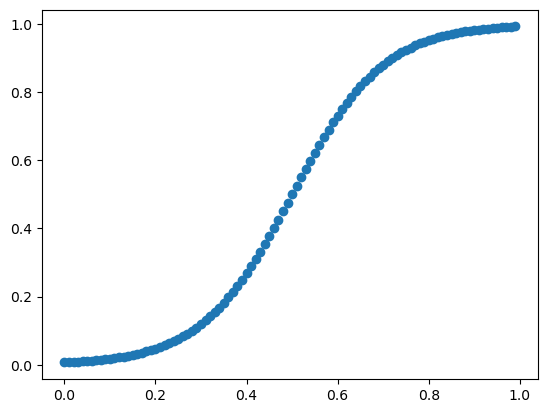

0.9626731126558706

In [67]:
plt.pyplot.scatter(np.arange(0,1,0.01), sigmoid(10*np.arange(0,1,0.01)-5))
plt.pyplot.show()
sigmoid(3.25)

Plot the impact factors per isoform per tissue

ENSG00000179943


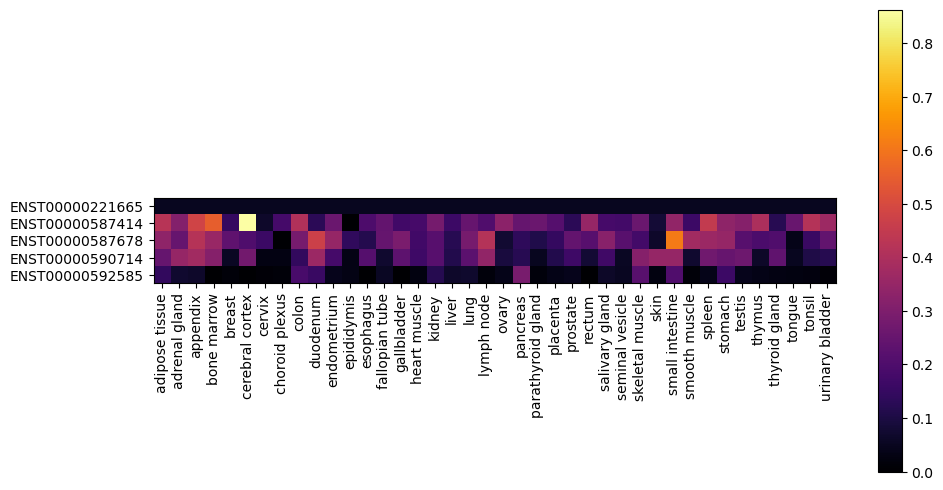

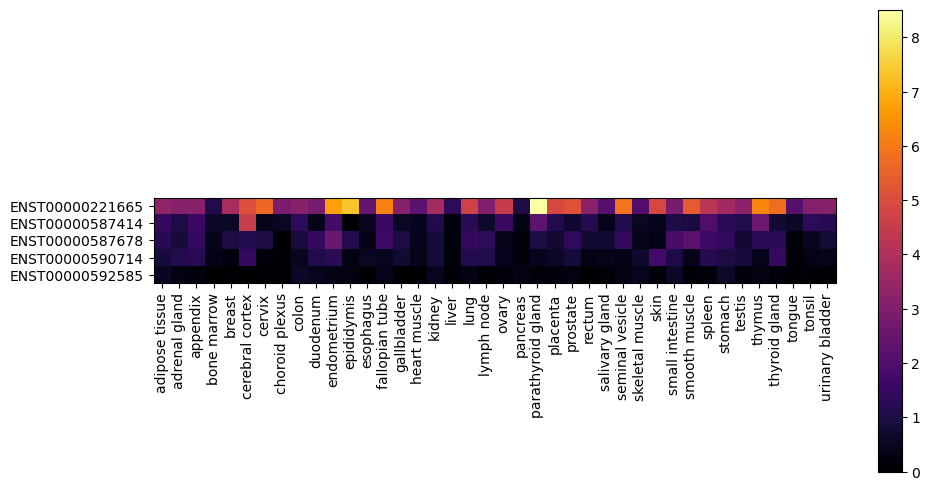

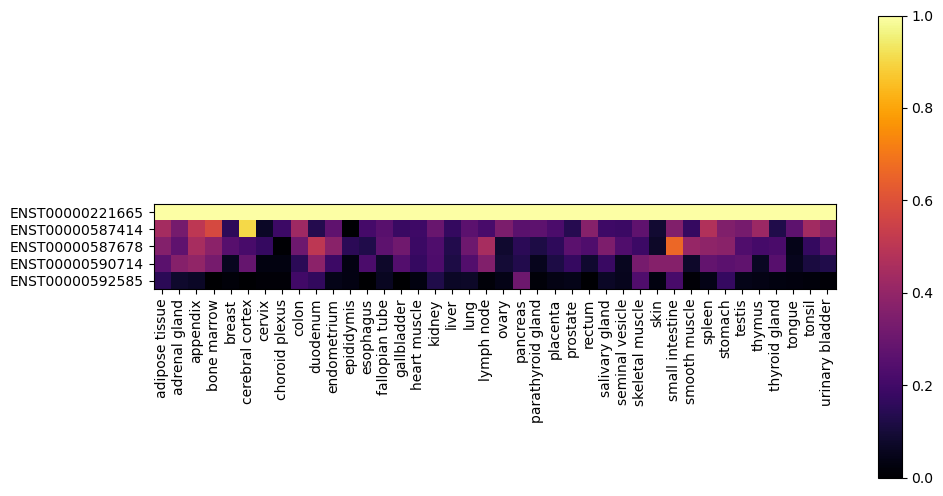

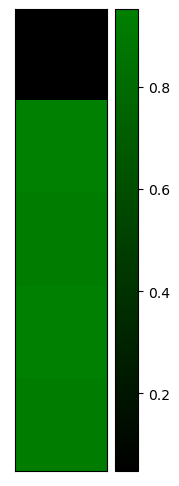

ENSG00000196628


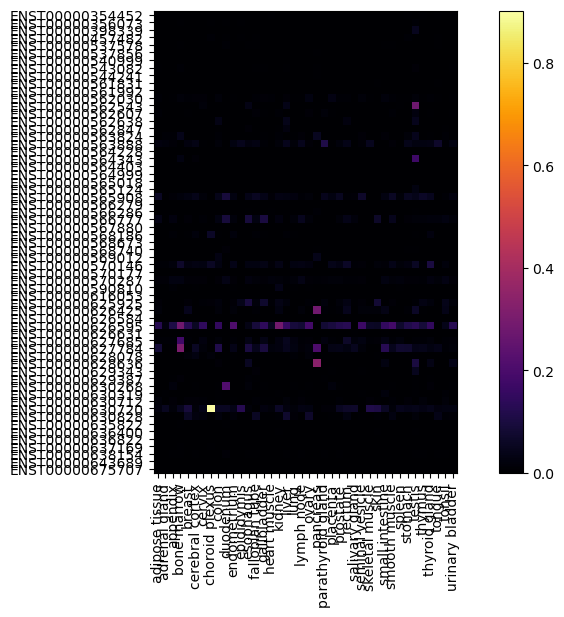

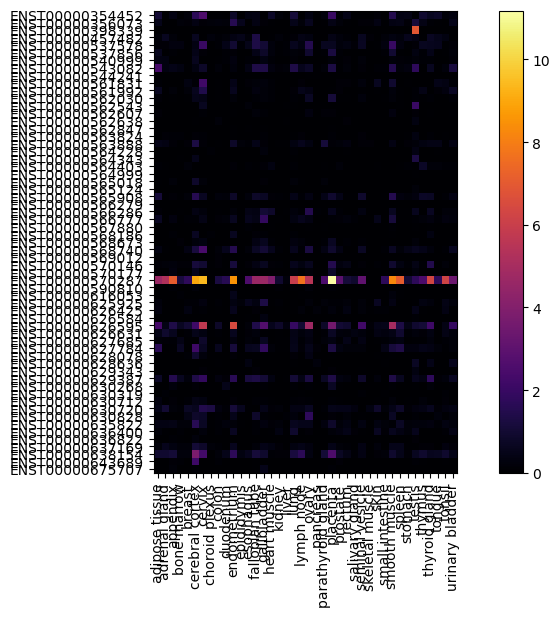

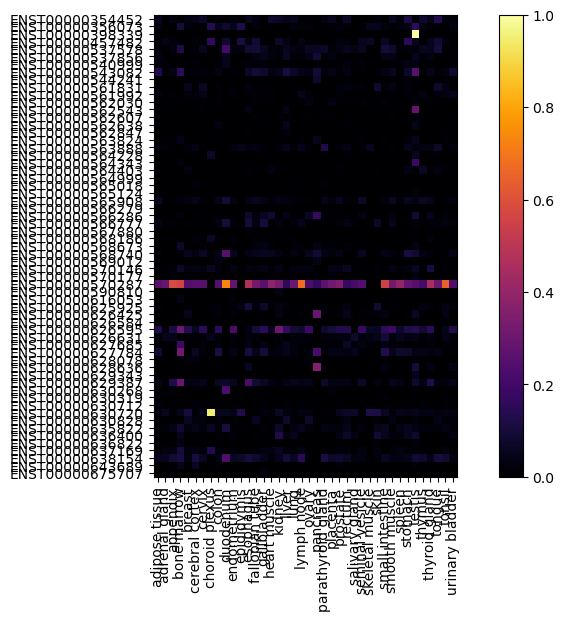

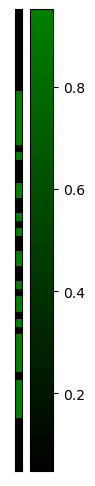

ENSG00000126456


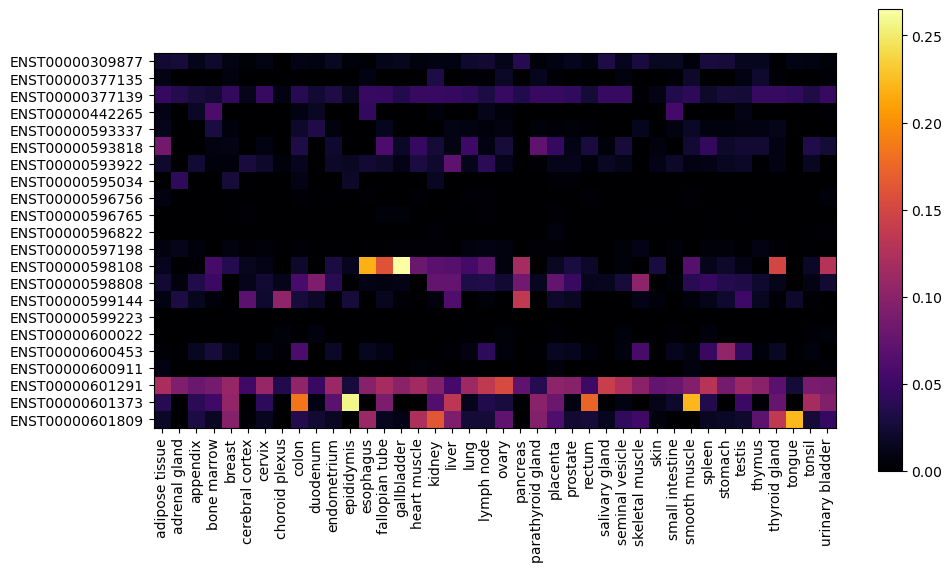

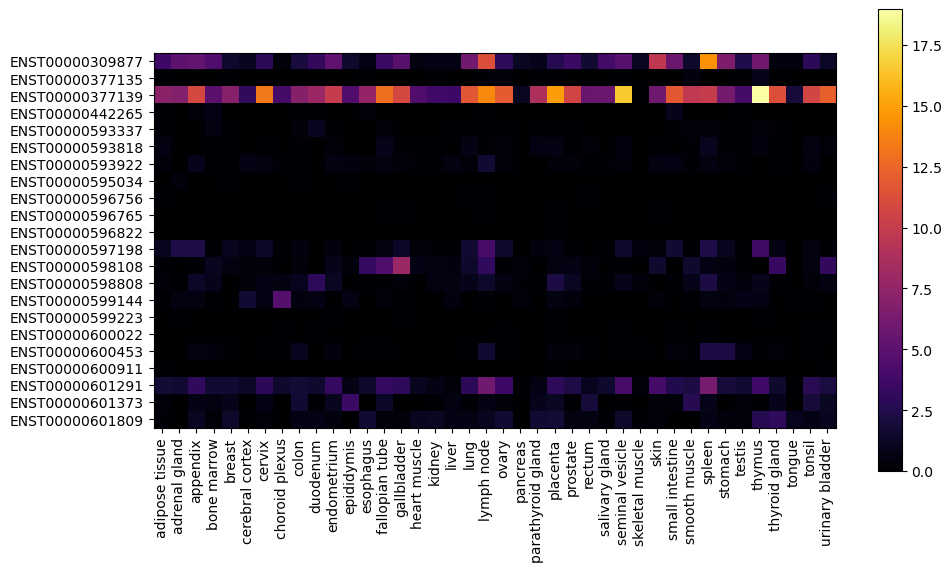

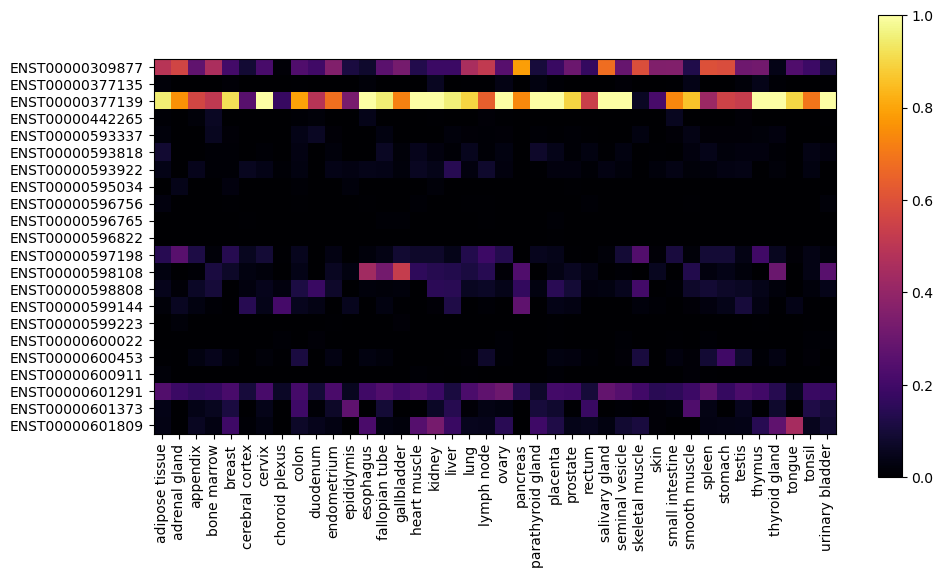

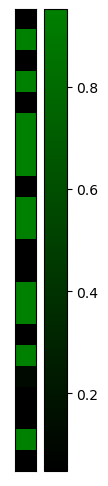

ENSG00000185507


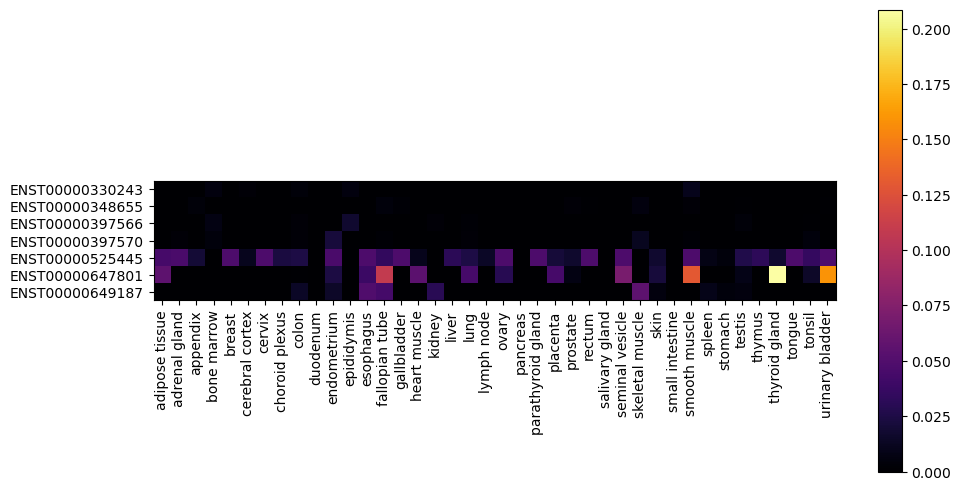

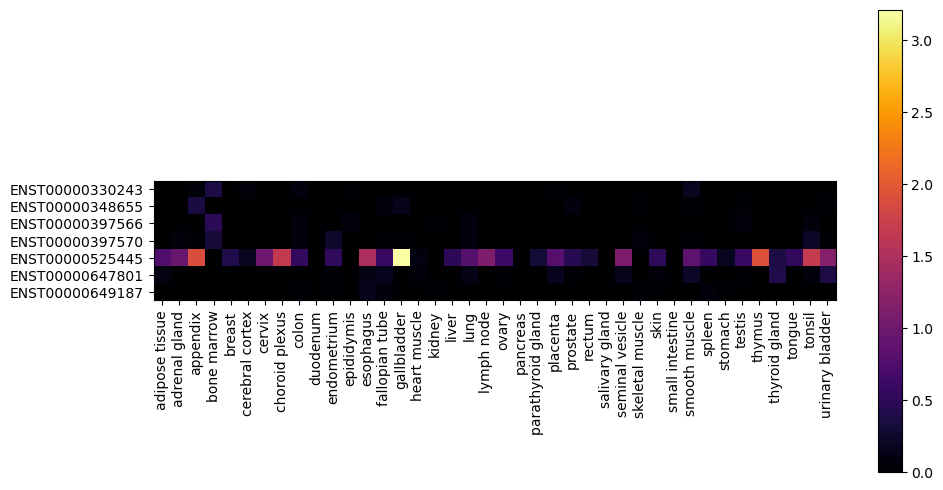

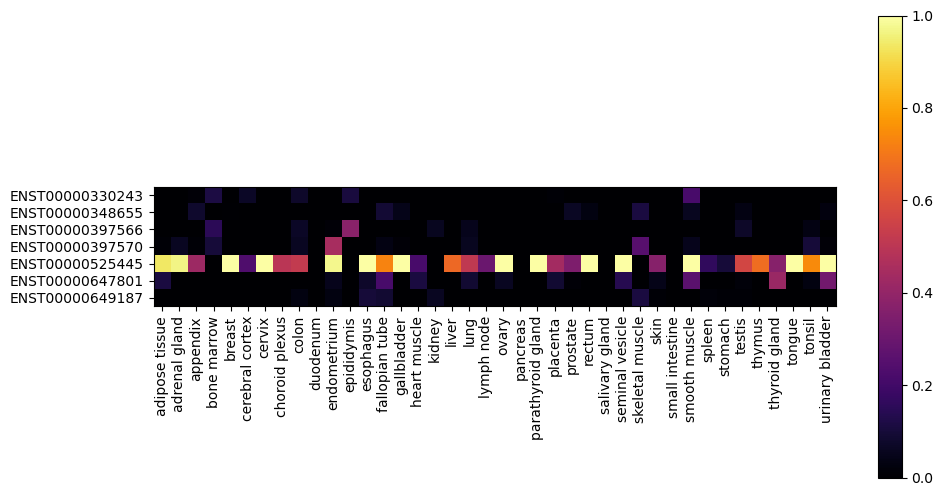

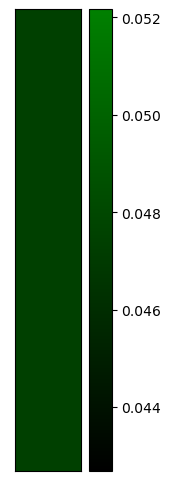

ENSG00000109320


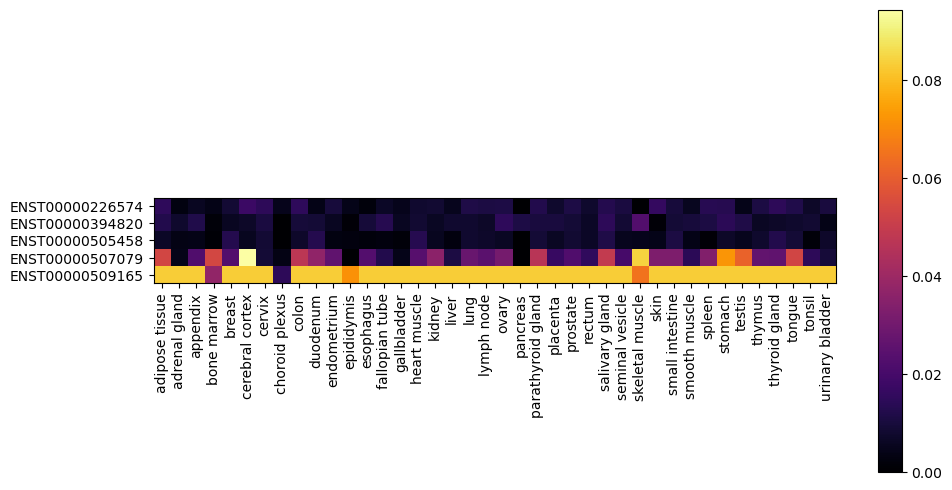

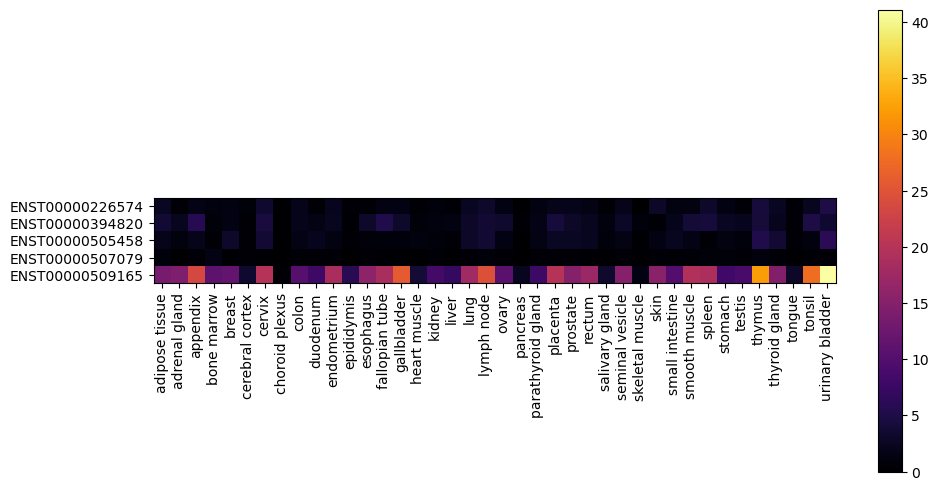

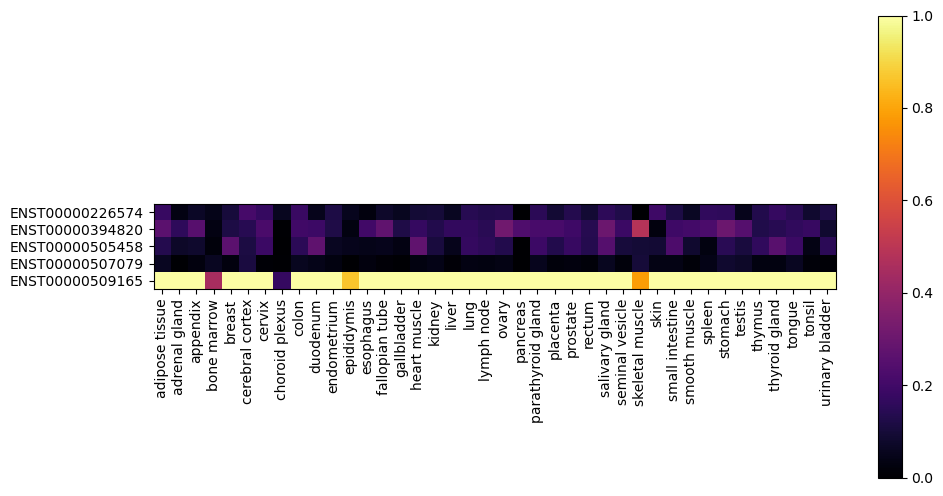

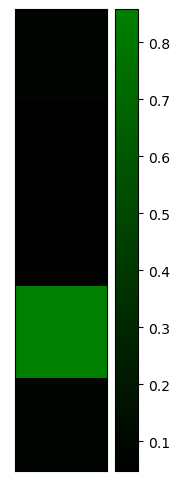

In [16]:
#print(impact_factor)
#for gene_id in impact_factors:
#FIZ1: ENSG00000179943
#TCF4: ENSG00000196628
for gene_id in ["ENSG00000179943", "ENSG00000196628","ENSG00000126456", "ENSG00000185507", "ENSG00000109320"]:
    print(gene_id)
    heatmap_values = list()
    exp_hm_values = list()
    rel_exp_hm_values = list()
    DBD_lost_hm_values = list()
    prot_ids = []
    for prot_id in impact_factors[gene_id]:
        #print(prot_id)
        these_factors = {tissue: rel_impact_factors[gene_id][prot_id][tissue][0] 
                         for tissue in rel_impact_factors[gene_id][prot_id]}
        these_exp = {tissue: impact_factors[gene_id][prot_id][tissue][1] 
                         for tissue in impact_factors[gene_id][prot_id]}
        these_rel_exp = {tissue: rel_impact_factors[gene_id][prot_id][tissue][1] 
                         for tissue in rel_impact_factors[gene_id][prot_id]}
        if len(these_factors)==0 or max(these_factors.values())==0:
            continue
        #print(these_factors.values())
        #print(these_exp.values())
        heatmap_values.append(list(these_factors.values()))
        exp_hm_values.append(list(these_exp.values()))
        rel_exp_hm_values.append(list(these_rel_exp.values()))
        DBD_lost_hm_values.append(DNA_binding_lost[gene_id][prot_id])
        width = 0.35
        #plt.pyplot.figure(figsize=(11,6))
        #plt.pyplot.bar(np.arange(len(these_factors))-width/2, 
        #               np.array(list(these_factors.values())), 
        #               width)
        #plt.pyplot.bar(np.arange(len(these_exp))+width/2, 
        #               np.array(list(these_exp.values())), 
        #               width)
        #plt.pyplot.xticks(range(len(these_factors)), list(these_factors.keys()), rotation=90)
        #plt.pyplot.show()
        prot_ids.append(prot_id)
    
    if len(heatmap_values)==0:
        continue
    heatmap_values = np.array(heatmap_values)
    row_sums = np.sum(heatmap_values, axis=1)
    #keep_rows = row_sums>0.05*sum(row_sums)
    #heatmap_values = heatmap_values[keep_rows,:]
    
    plt.pyplot.figure(figsize=(11,6))
    #TODO: adjust the colors of the heatmap
    plt.pyplot.colormaps()
    plt.pyplot.imshow(heatmap_values, cmap="inferno")
    plt.pyplot.colorbar()
    plt.pyplot.xticks(np.arange(len(these_factors)), list(these_factors.keys()), rotation=90)
    #plt.pyplot.yticks(np.arange(sum(keep_rows)), np.array(prot_ids)[keep_rows])
    plt.pyplot.yticks(np.arange(len(prot_ids)), np.array(prot_ids))
    plt.pyplot.show()
    
    #print(heatmap_values)
    average_tpm_hm_values = list()
    for prot_id in impact_factors[gene_id]:
        average_tpm_hm_values.append(list(average_tpms[gene_id][prot_id].values()))
    average_tpm_hm_values = np.array(average_tpm_hm_values)
    #print(average_tpm_hm_values)
    
    plt.pyplot.figure(figsize=(11,6))
    plt.pyplot.imshow(exp_hm_values, cmap="inferno")
    plt.pyplot.colorbar()
    plt.pyplot.xticks(np.arange(len(these_factors)), list(these_factors.keys()), rotation=90)
    plt.pyplot.yticks(np.arange(len(prot_ids)), np.array(prot_ids))
    plt.pyplot.show()
    
    plt.pyplot.figure(figsize=(11,6))
    plt.pyplot.imshow(rel_exp_hm_values, cmap="inferno")
    plt.pyplot.colorbar()
    plt.pyplot.xticks(np.arange(len(these_factors)), list(these_factors.keys()), rotation=90)
    plt.pyplot.yticks(np.arange(len(prot_ids)), np.array(prot_ids))
    plt.pyplot.show()
    
    DBD_lost_hm_values = np.expand_dims(DBD_lost_hm_values, axis=1)
    DBD_lost_cmap = plt.colors.LinearSegmentedColormap.from_list("DBD_lost_cmap",
                                                                 ["black","green"])
    plt.pyplot.figure(figsize=(2,6))
    plt.pyplot.imshow(DBD_lost_hm_values, cmap=DBD_lost_cmap)
    plt.pyplot.colorbar()
    plt.pyplot.xticks([])
    plt.pyplot.yticks([])
    #plt.pyplot.yticks(np.arange(len(prot_ids)), np.array(prot_ids))
    plt.pyplot.show()

Calculate the impact factor per tissue per gene

In [10]:
impact_factors_gene = {}
rel_impact_factors_gene = {}
for gene_id in impact_factors:
    print(gene_id)
    impact_factors_gene[gene_id] = {}
    rel_impact_factors_gene[gene_id] = {}
    for prot_id in impact_factors[gene_id]:
        for tissue in impact_factors[gene_id][prot_id]:
            if tissue not in impact_factors_gene[gene_id]:
                impact_factors_gene[gene_id][tissue] = [0,0,0]
                rel_impact_factors_gene[gene_id][tissue] = [0,0,0]
            if impact_factors_gene[gene_id][tissue][0] < impact_factors[gene_id][prot_id][tissue][0]:
                impact_factors_gene[gene_id][tissue][0] = impact_factors[gene_id][prot_id][tissue][0]
                impact_factors_gene[gene_id][tissue][2] = impact_factors[gene_id][prot_id][tissue][1]
            impact_factors_gene[gene_id][tissue][1] += impact_factors[gene_id][prot_id][tissue][1]
            if rel_impact_factors_gene[gene_id][tissue][0] < rel_impact_factors[gene_id][prot_id][tissue][0]:
                rel_impact_factors_gene[gene_id][tissue][0] = rel_impact_factors[gene_id][prot_id][tissue][0]
                rel_impact_factors_gene[gene_id][tissue][2] = rel_impact_factors[gene_id][prot_id][tissue][1]
            rel_impact_factors_gene[gene_id][tissue][1] += rel_impact_factors[gene_id][prot_id][tissue][1]
#print(impact_factors_gene)

ENSG00000004848
ENSG00000005073
ENSG00000005102
ENSG00000005513
ENSG00000005801
ENSG00000005889
ENSG00000006194
ENSG00000006377
ENSG00000006468
ENSG00000007372
ENSG00000007968
ENSG00000008083
ENSG00000009709
ENSG00000009950
ENSG00000010030
ENSG00000010539
ENSG00000010818
ENSG00000011451
ENSG00000011590
ENSG00000012504
ENSG00000012817
ENSG00000016082
ENSG00000018869
ENSG00000019549
ENSG00000020256
ENSG00000020633
ENSG00000025156
ENSG00000028277
ENSG00000032219
ENSG00000037965
ENSG00000039600
ENSG00000043039
ENSG00000043355
ENSG00000048405
ENSG00000049618
ENSG00000049768
ENSG00000050344
ENSG00000052850
ENSG00000053254
ENSG00000054267
ENSG00000054598
ENSG00000056277
ENSG00000057657
ENSG00000057935
ENSG00000060566
ENSG00000061455
ENSG00000062370
ENSG00000063438
ENSG00000063515
ENSG00000064195
ENSG00000064218
ENSG00000064835
ENSG00000064961
ENSG00000065029
ENSG00000065970
ENSG00000066336
ENSG00000066422
ENSG00000066827
ENSG00000067066
ENSG00000069011
ENSG00000069667
ENSG00000069812
ENSG0000

ENSG00000186564
ENSG00000186766
ENSG00000186777
ENSG00000186790
ENSG00000186812
ENSG00000186814
ENSG00000186951
ENSG00000187098
ENSG00000187140
ENSG00000187187
ENSG00000187559
ENSG00000187792
ENSG00000187801
ENSG00000187815
ENSG00000187821
ENSG00000187855
ENSG00000187987
ENSG00000188033
ENSG00000188095
ENSG00000188171
ENSG00000188227
ENSG00000188290
ENSG00000188295
ENSG00000188620
ENSG00000188785
ENSG00000188786
ENSG00000188816
ENSG00000188868
ENSG00000188909
ENSG00000189042
ENSG00000189079
ENSG00000189120
ENSG00000189164
ENSG00000189180
ENSG00000189190
ENSG00000189298
ENSG00000189299
ENSG00000196081
ENSG00000196092
ENSG00000196109
ENSG00000196110
ENSG00000196132
ENSG00000196152
ENSG00000196172
ENSG00000196214
ENSG00000196233
ENSG00000196247
ENSG00000196267
ENSG00000196268
ENSG00000196345
ENSG00000196350
ENSG00000196357
ENSG00000196378
ENSG00000196387
ENSG00000196391
ENSG00000196417
ENSG00000196418
ENSG00000196437
ENSG00000196453
ENSG00000196456
ENSG00000196458
ENSG00000196466
ENSG0000

ENSG00000126456


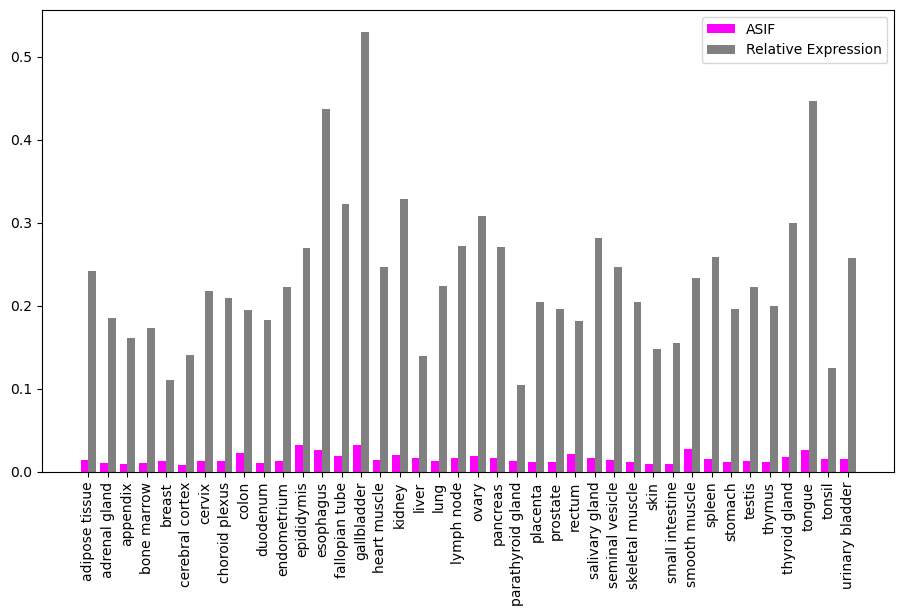

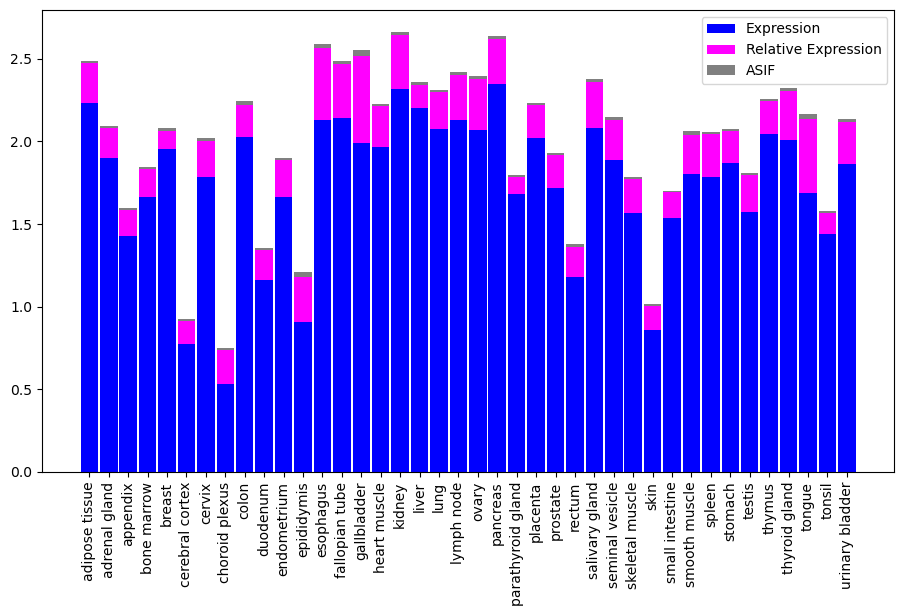

In [11]:
#for gene_id in impact_factors_gene:
for gene_id in ["ENSG00000126456"]:
    print(gene_id)
    these_factors = {tissue: rel_impact_factors_gene[gene_id][tissue][0] 
                     for tissue in rel_impact_factors_gene[gene_id]}
    these_factorexp = {tissue: rel_impact_factors_gene[gene_id][tissue][2] 
                 for tissue in rel_impact_factors_gene[gene_id]}
    these_exp = {tissue: rel_impact_factors_gene[gene_id][tissue][1] 
                 for tissue in rel_impact_factors_gene[gene_id]}
    width = .4
    plt.pyplot.figure(figsize=(11,6))
    plt.pyplot.bar(np.arange(len(these_factors))-width/2, 
                   np.array(list(these_factors.values())), 
                   width, color="magenta", label="ASIF")
    plt.pyplot.bar(np.arange(len(these_factorexp))+width/2, 
                   np.array(list(these_factorexp.values())), 
                   width, color="grey", label="Relative Expression")
    #plt.pyplot.bar(np.arange(len(these_exp))+width, 
    #               np.array(list(these_exp.values())), 
    #               width, color="blue", label="Expression")
    
    plt.pyplot.xticks(range(len(these_factors)), list(these_factors.keys()), rotation=90)
    plt.pyplot.legend()
    plt.pyplot.show()
    
    width = .9
    plt.pyplot.figure(figsize=(11,6))
    plt.pyplot.bar(np.arange(len(these_exp)), 
                   np.array(list(these_exp.values())), 
                   width=width, color="blue", label="Expression")
    plt.pyplot.bar(np.arange(len(these_factorexp)), 
                   np.array(list(these_factorexp.values())),
                   bottom=np.array(list(these_exp.values())), 
                   width=width, color="magenta", label="Relative Expression")
    plt.pyplot.bar(np.arange(len(these_factors)), 
                   np.array(list(these_factors.values())), 
                   bottom=np.array(list(these_exp.values()))+np.array(list(these_factorexp.values())), 
                   width=width, color="grey", label="ASIF")
    plt.pyplot.xticks(range(len(these_factors)), list(these_factors.keys()), rotation=90)
    plt.pyplot.legend()
    plt.pyplot.show()

In [49]:
for enst in average_tpms["ENSG00000126456"]:
    print(enst)
    print(average_tpms["ENSG00000126456"][enst])

ENST00000309877
{'adipose tissue': 3.673632, 'adrenal gland': 5.037216666666667, 'appendix': 5.327793333333333, 'bone marrow': 4.386055, 'breast': 1.5708225, 'cerebral cortex': 1.1026033333333334, 'cervix': 2.87669, 'choroid plexus': 0.301681, 'colon': 2.032288769230769, 'duodenum': 3.16568, 'endometrium': 5.232177999999999, 'epididymis': 1.48466, 'esophagus': 0.5983666666666666, 'fallopian tube': 3.5521138, 'gallbladder': 4.8641966666666665, 'heart muscle': 0.5910584999999999, 'kidney': 0.7029580000000001, 'liver': 0.7091253, 'lung': 5.980912222222223, 'lymph node': 11.302597, 'ovary': 3.0084114285714283, 'pancreas': 1.249992, 'parathyroid gland': 0.8895306666666668, 'placenta': 2.711637375, 'prostate': 3.579476666666667, 'rectum': 1.7470807499999998, 'salivary gland': 3.85476, 'seminal vesicle': 4.839484333333333, 'skeletal muscle': 1.208493, 'skin': 9.6934, 'small intestine': 5.74403225, 'smooth muscle': 1.4343763333333335, 'spleen': 14.413791600000001, 'stomach': 6.5380375, 'testis

In [9]:
with open("impact_factors_gene.pickle", "wb") as f:
    pickle.dump(impact_factors_gene, f)
with open("rel_impact_factors_gene.pickle", "wb") as f:
    pickle.dump(rel_impact_factors_gene, f)

In [3]:
with open("impact_factors_gene.pickle", "rb") as f:
    impact_factors_gene = pickle.load(f)
with open("rel_impact_factors_gene.pickle", "rb") as f:
    rel_impact_factors_gene = pickle.load(f)

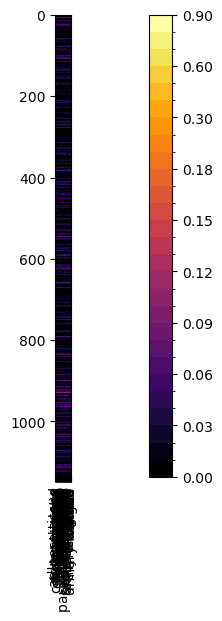

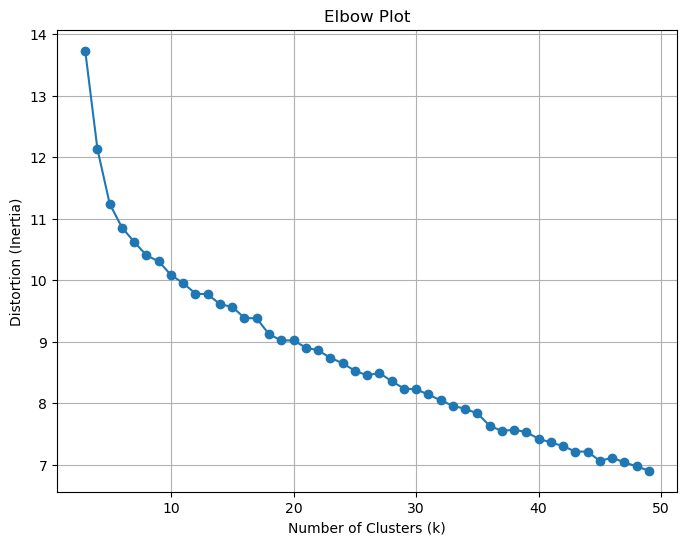

[[ 2  2  6  7 11 11  1  4  2  2  1 11 11  1  2 11 11  2  2  6  1  3 11 11
  11  2  6  1  5  9  2  2  6  2 10  0  1  8  0 11]]


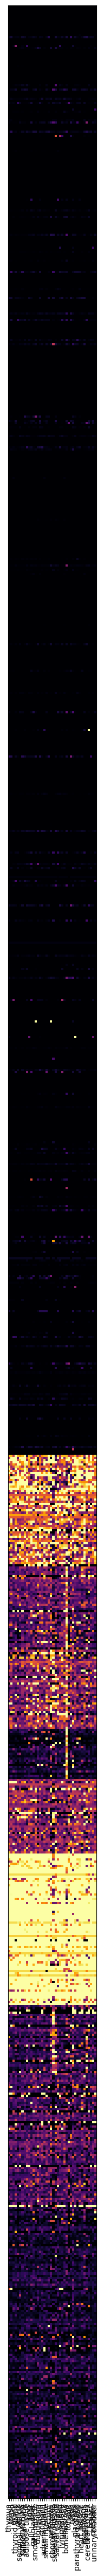

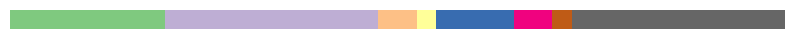

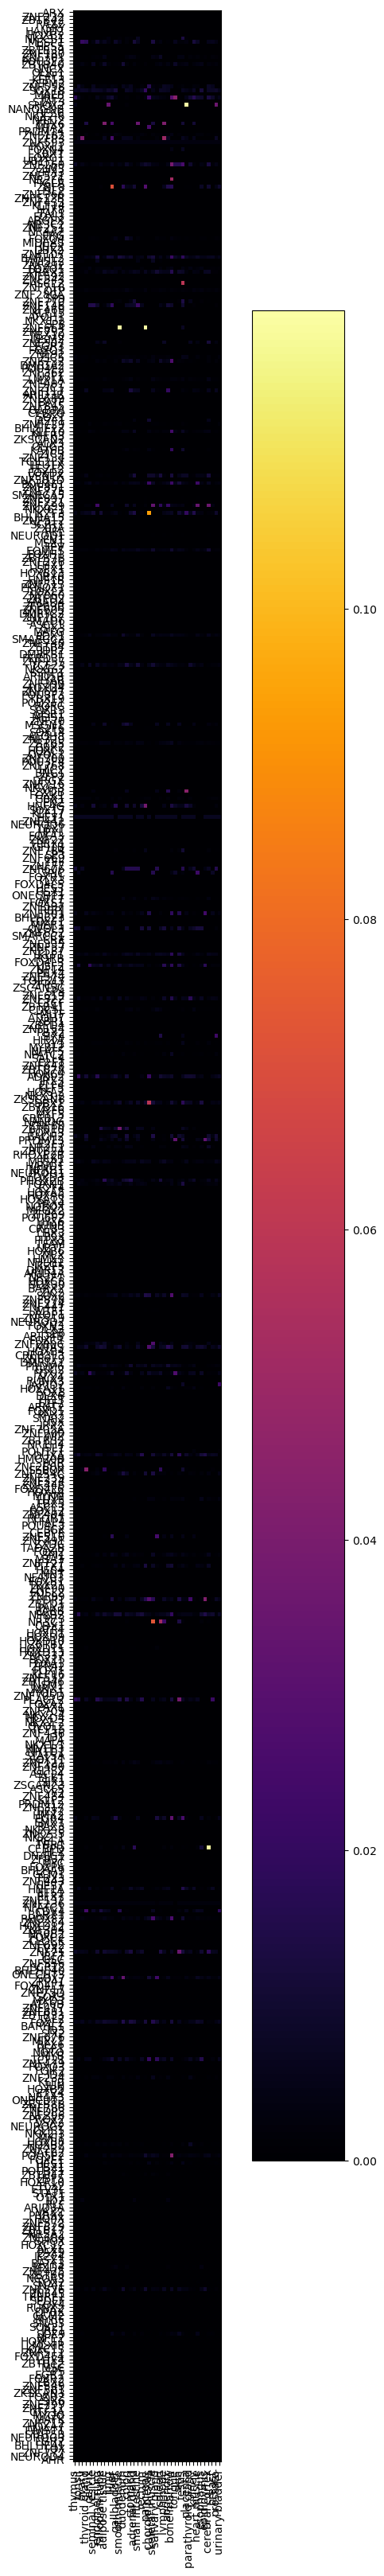

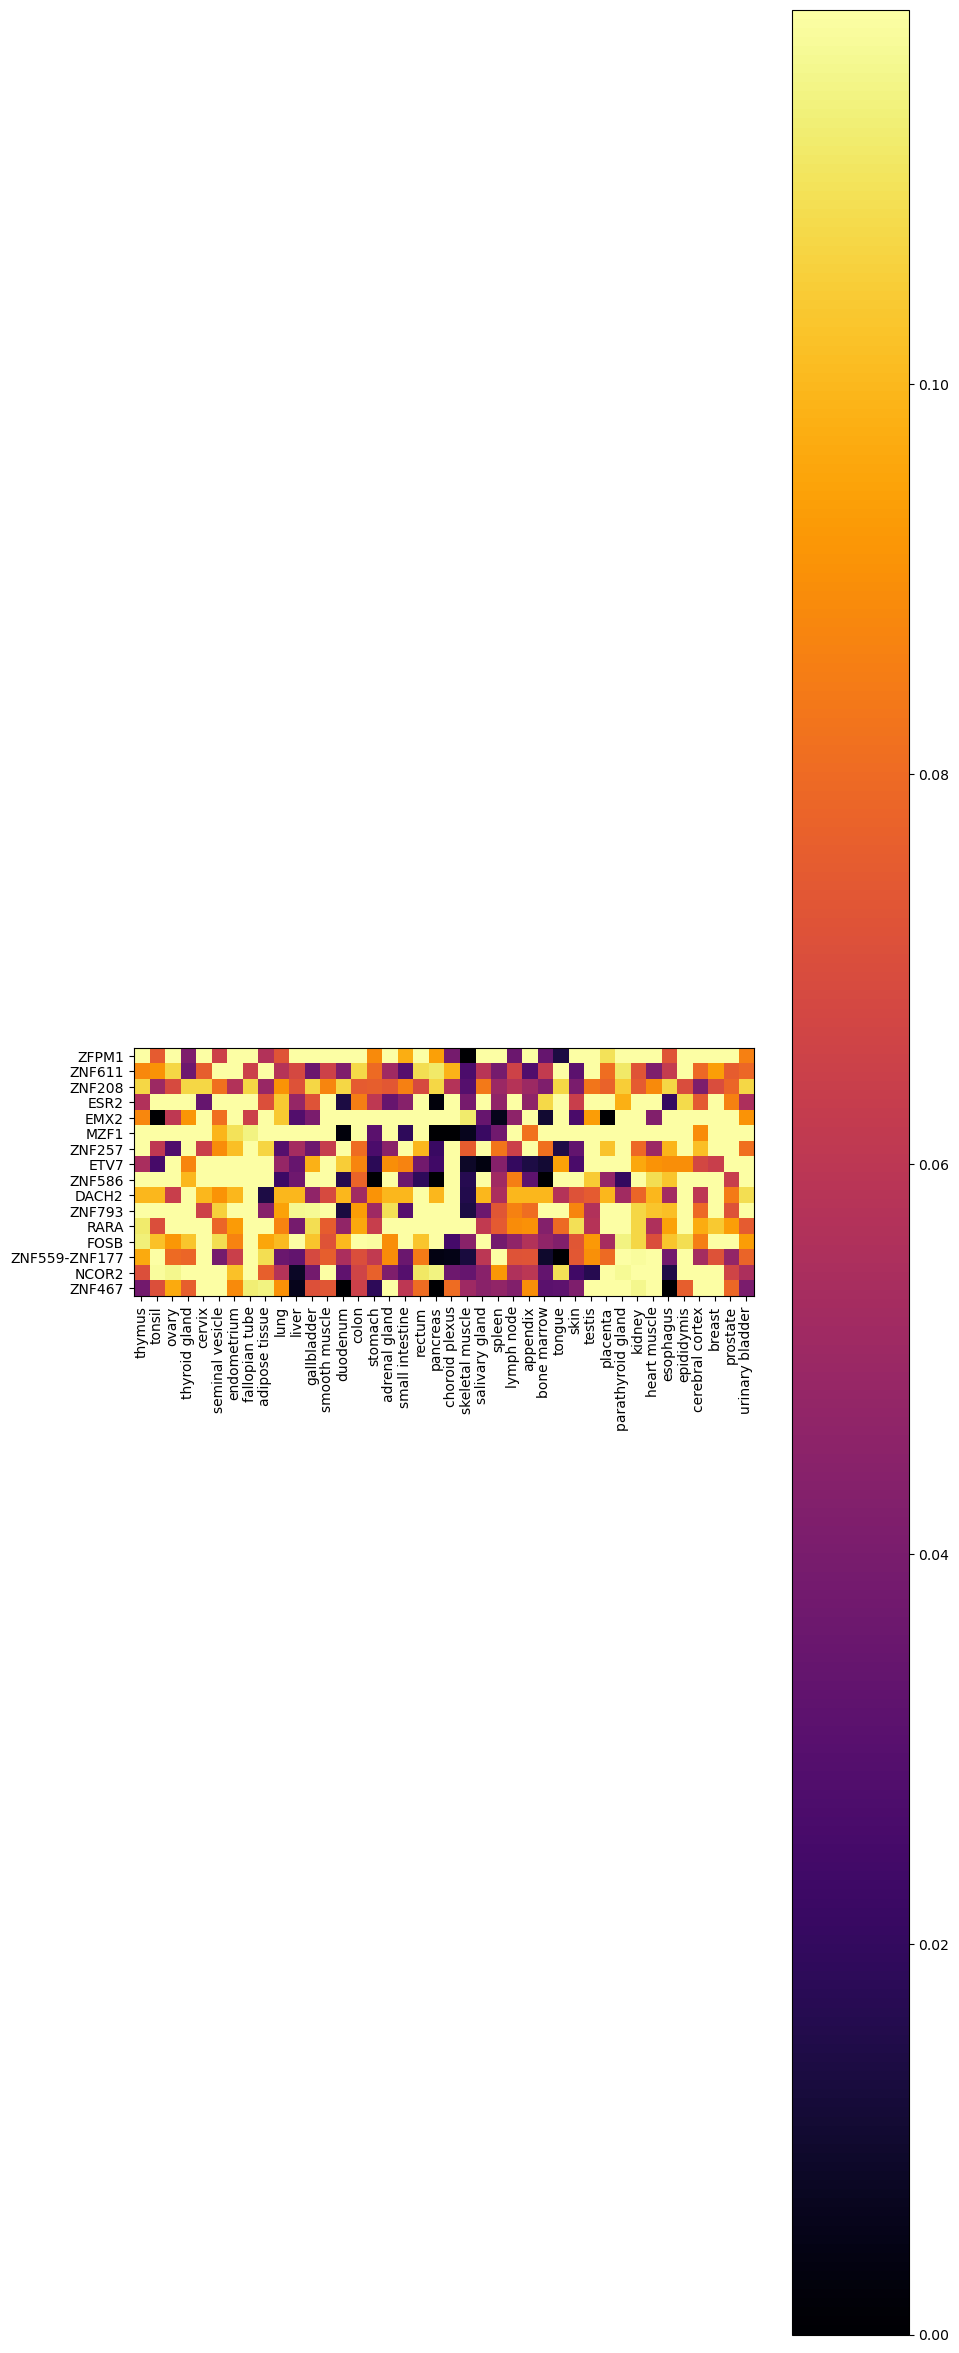

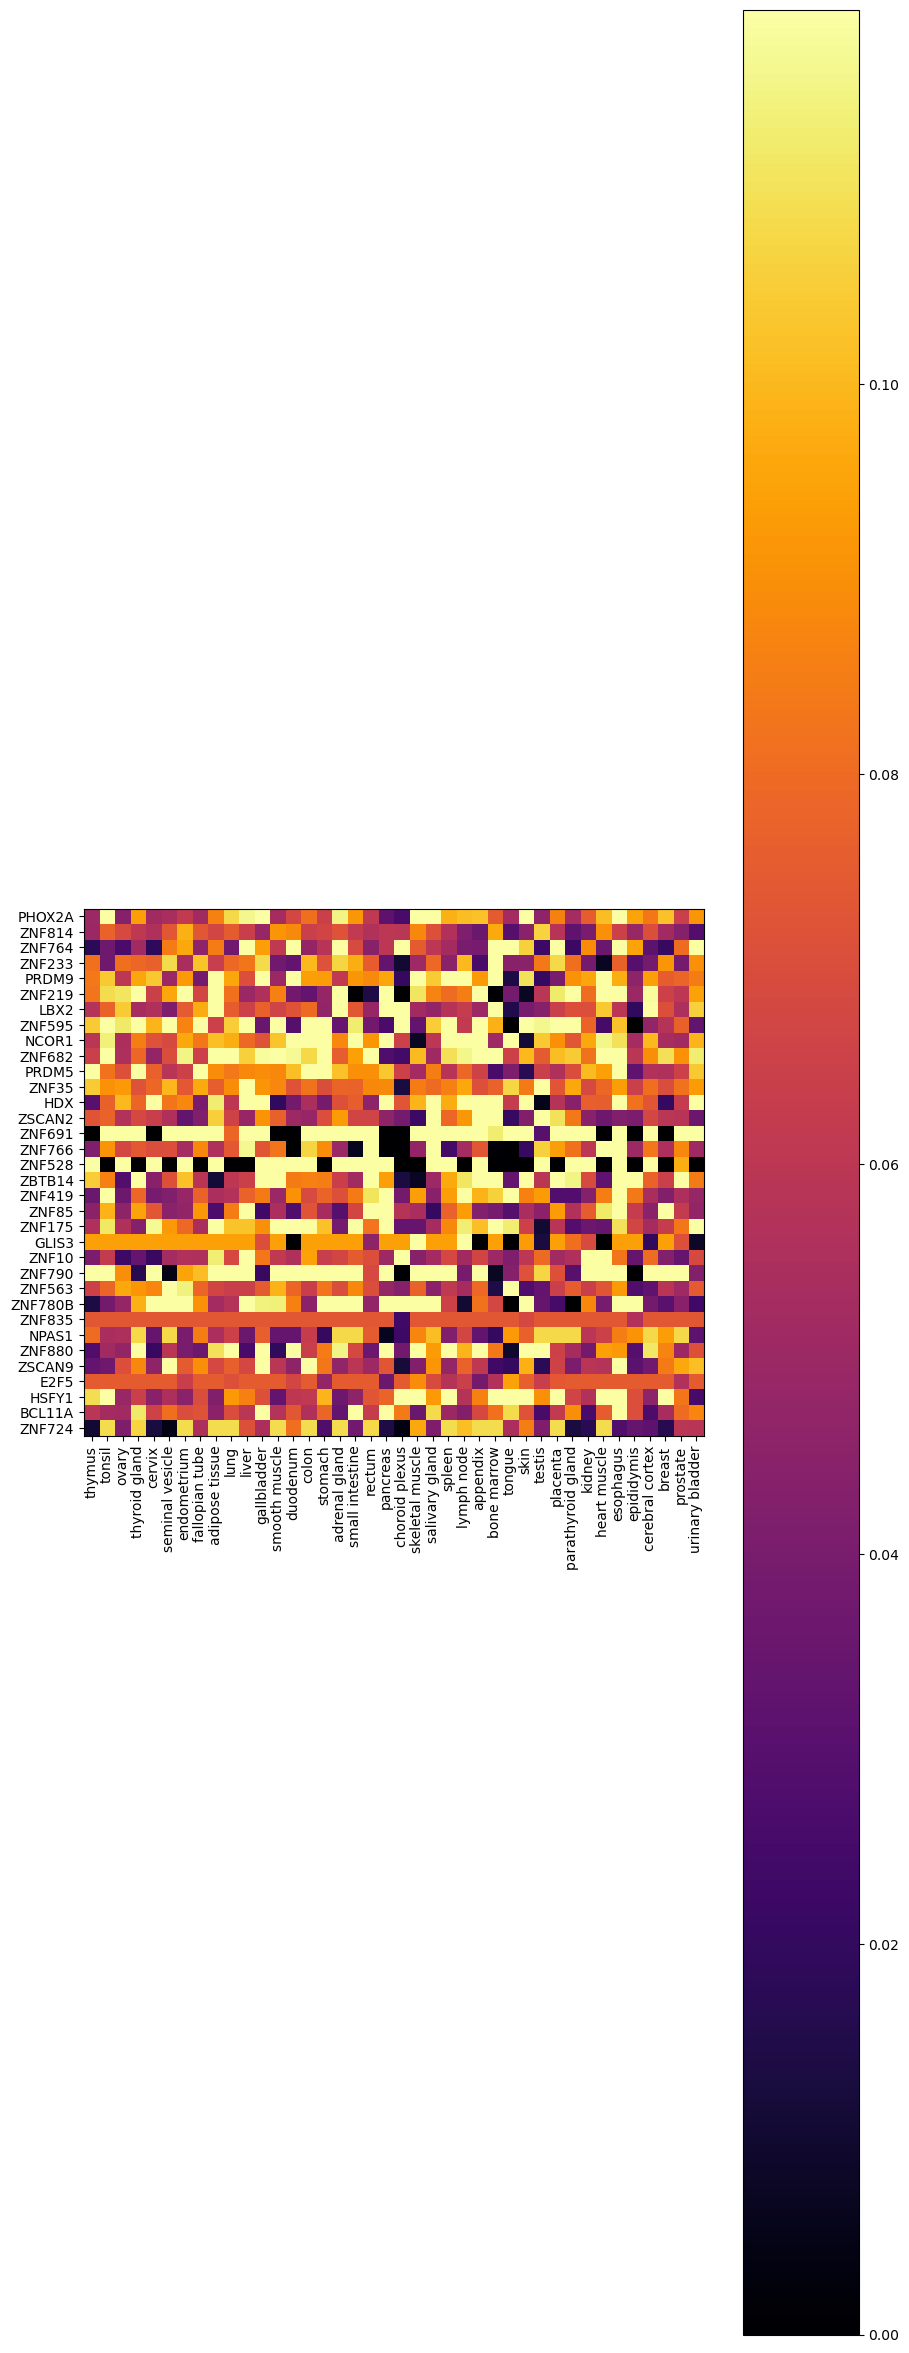

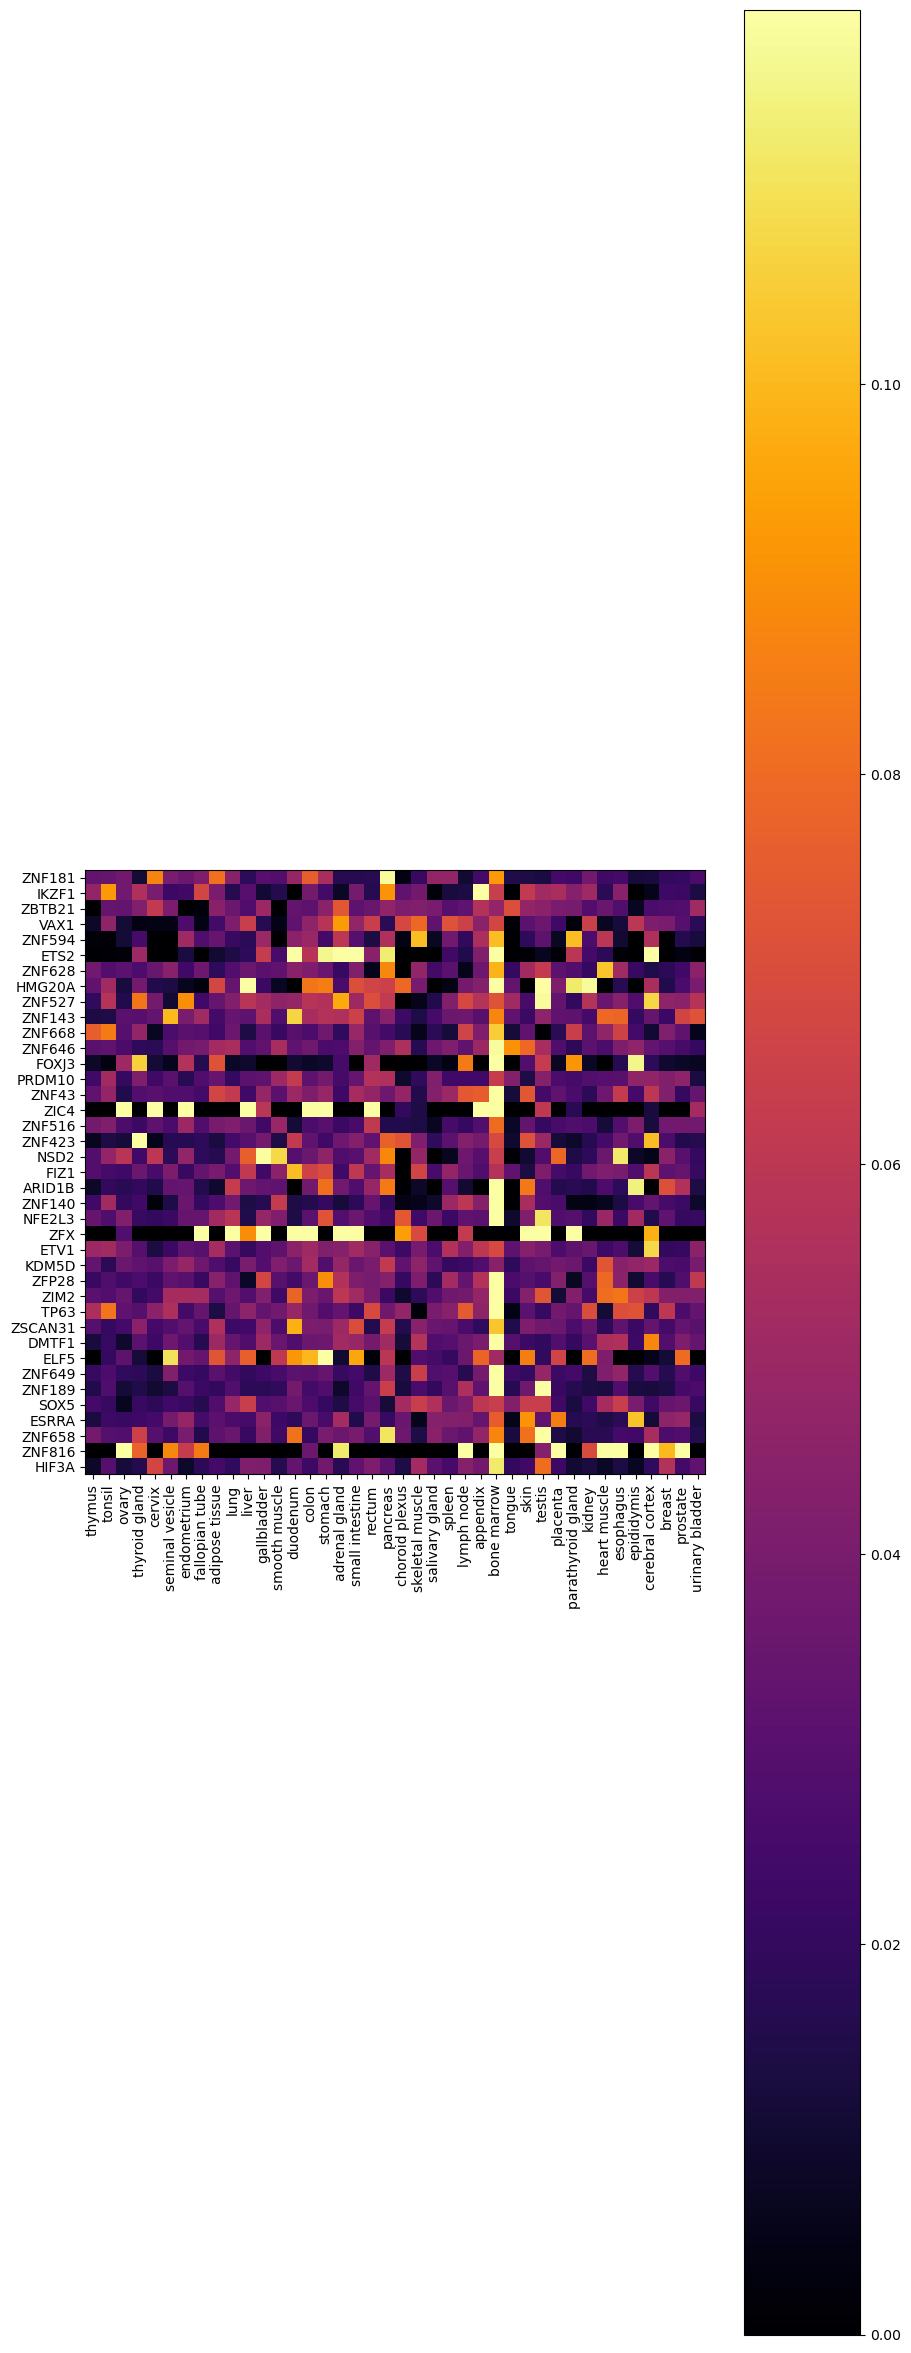

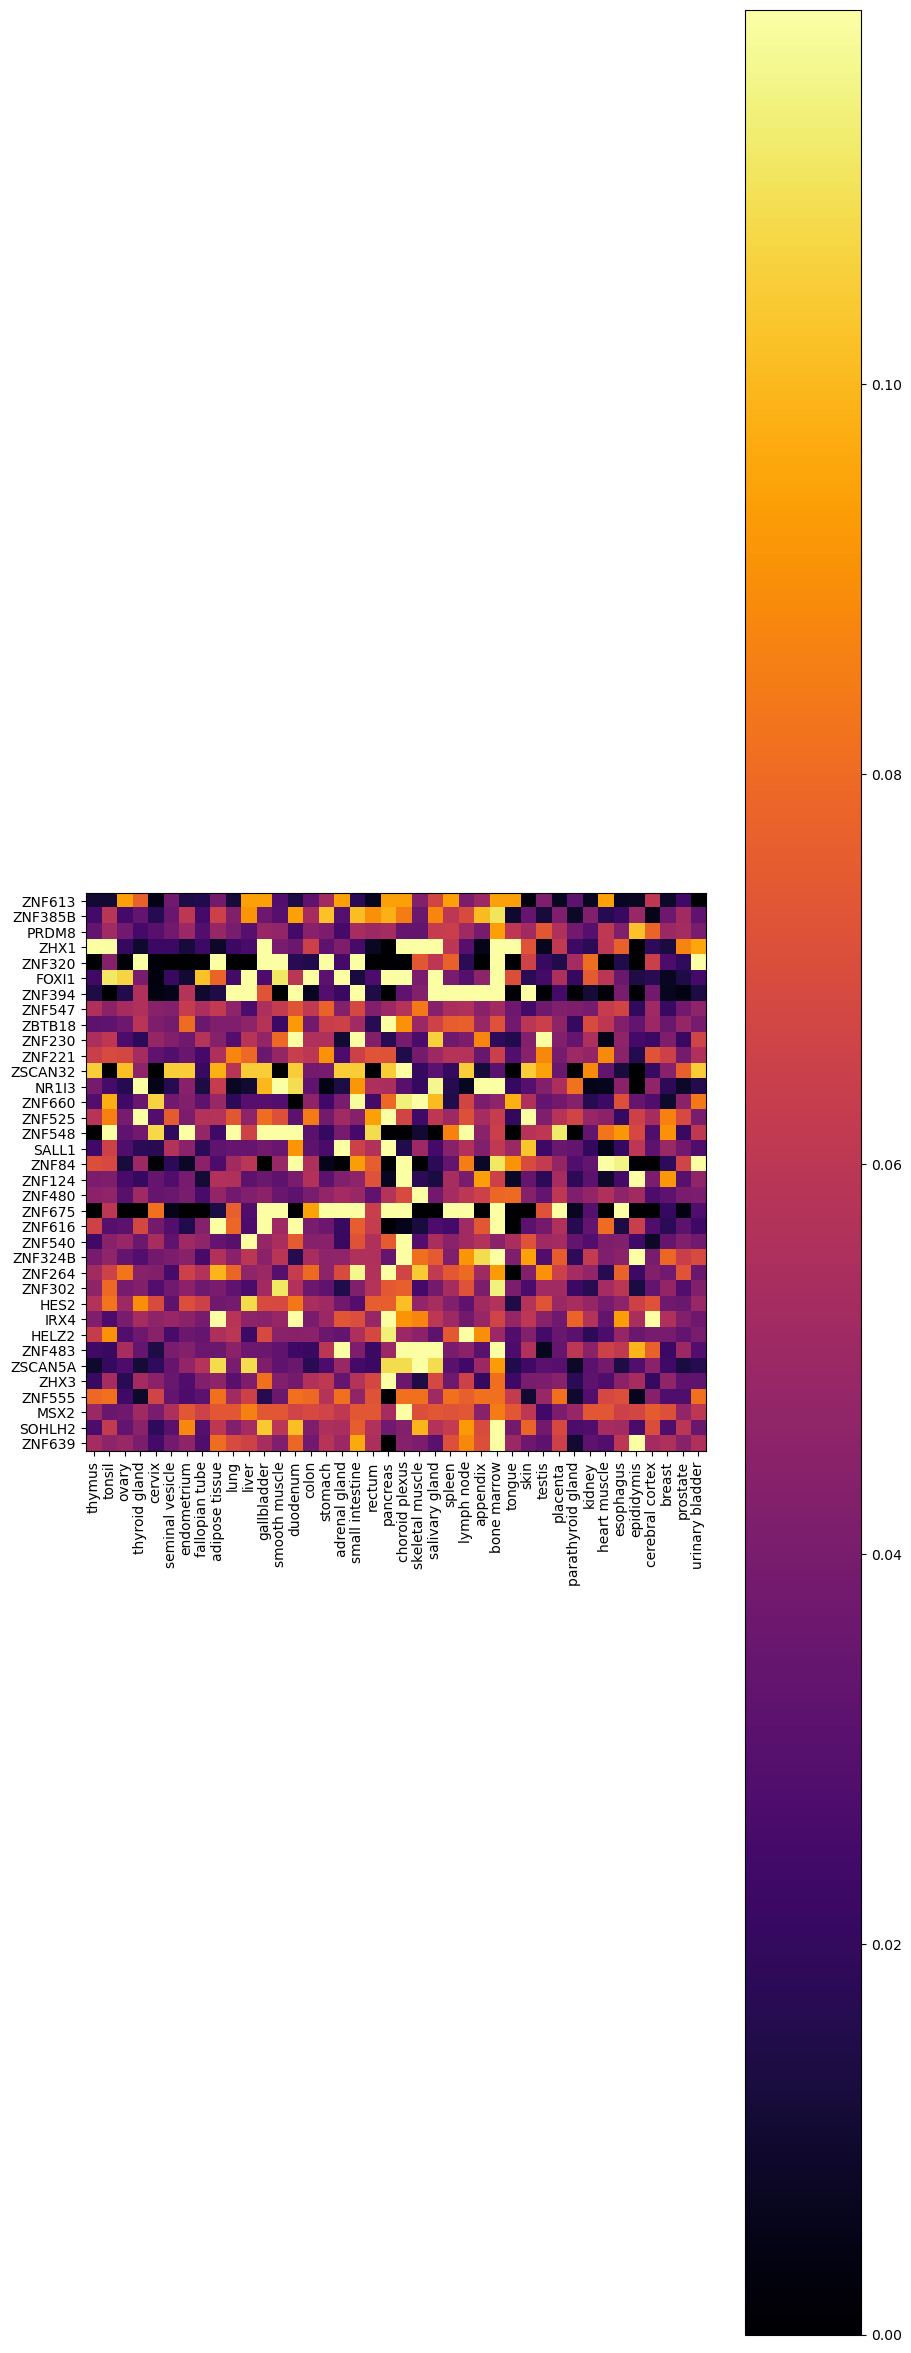

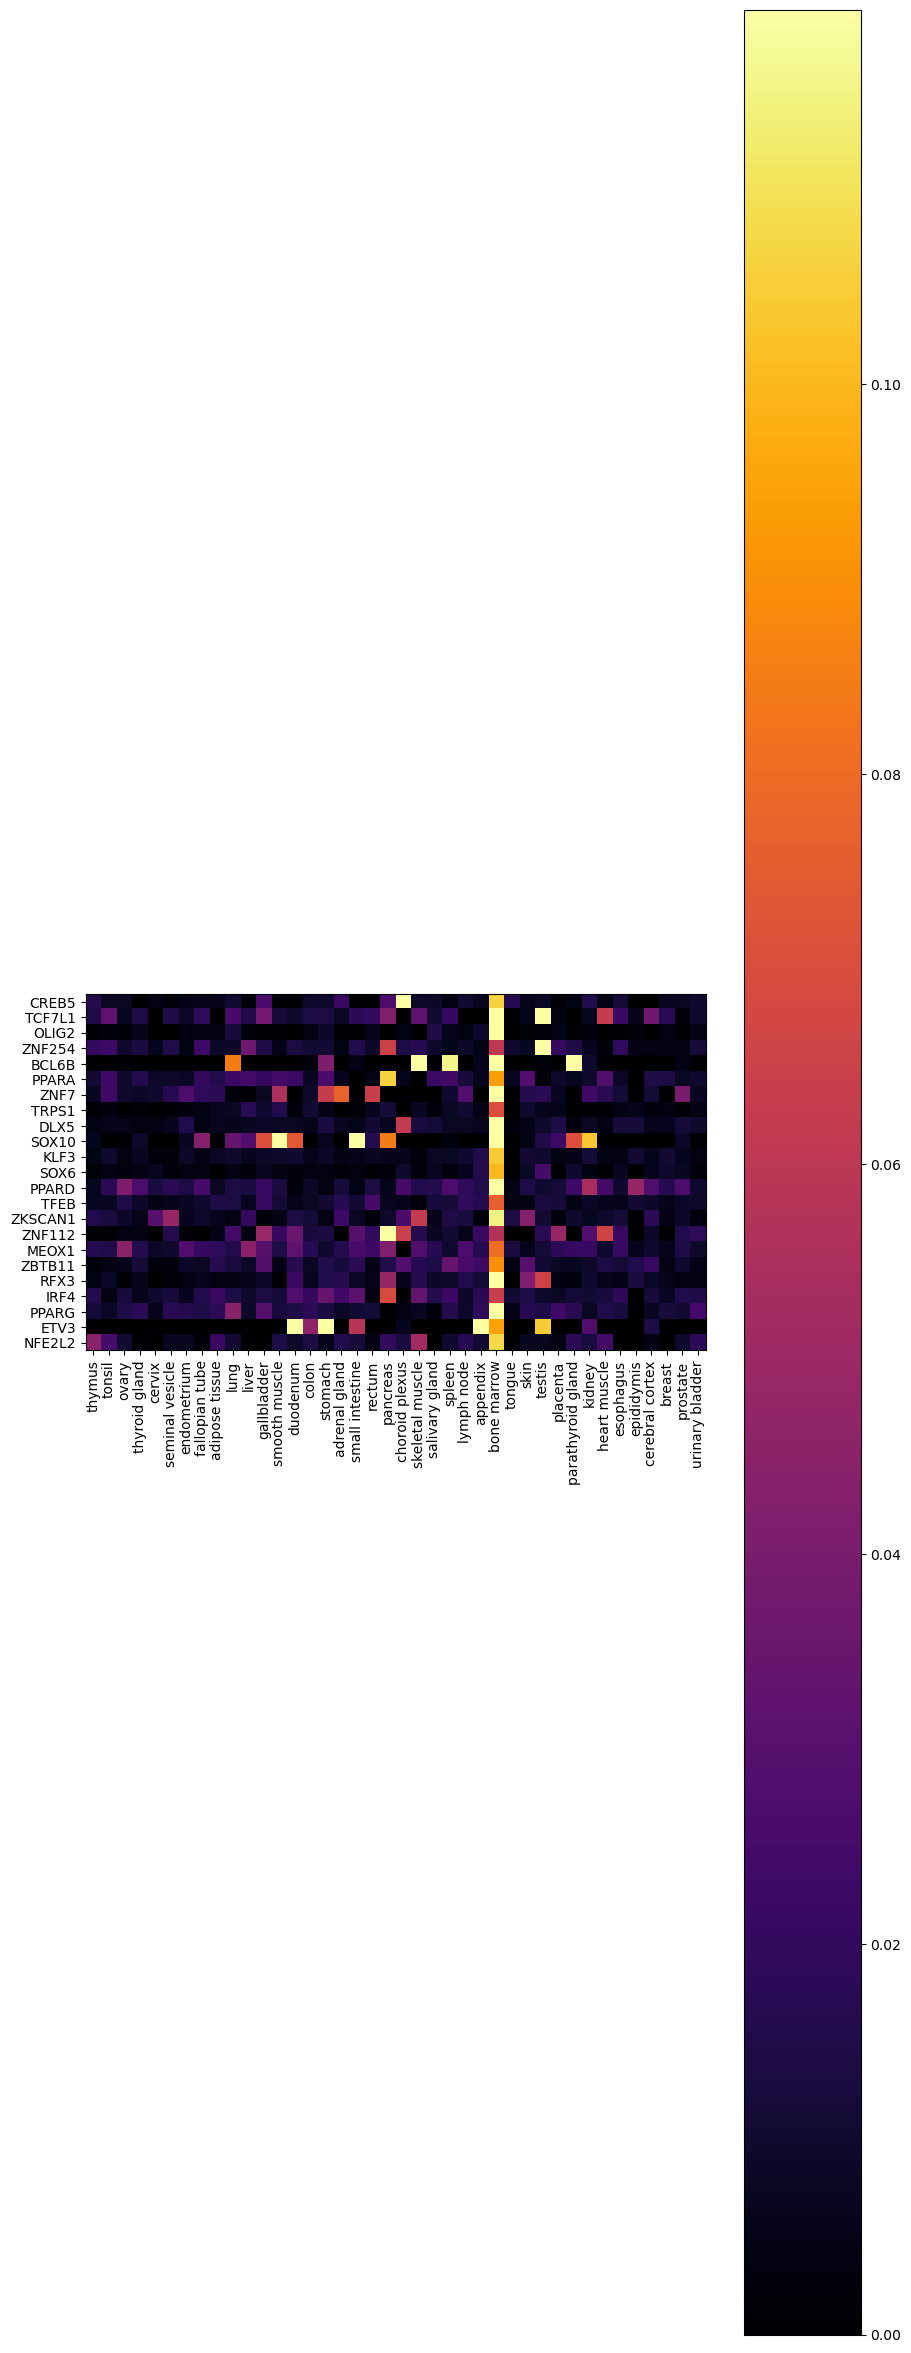

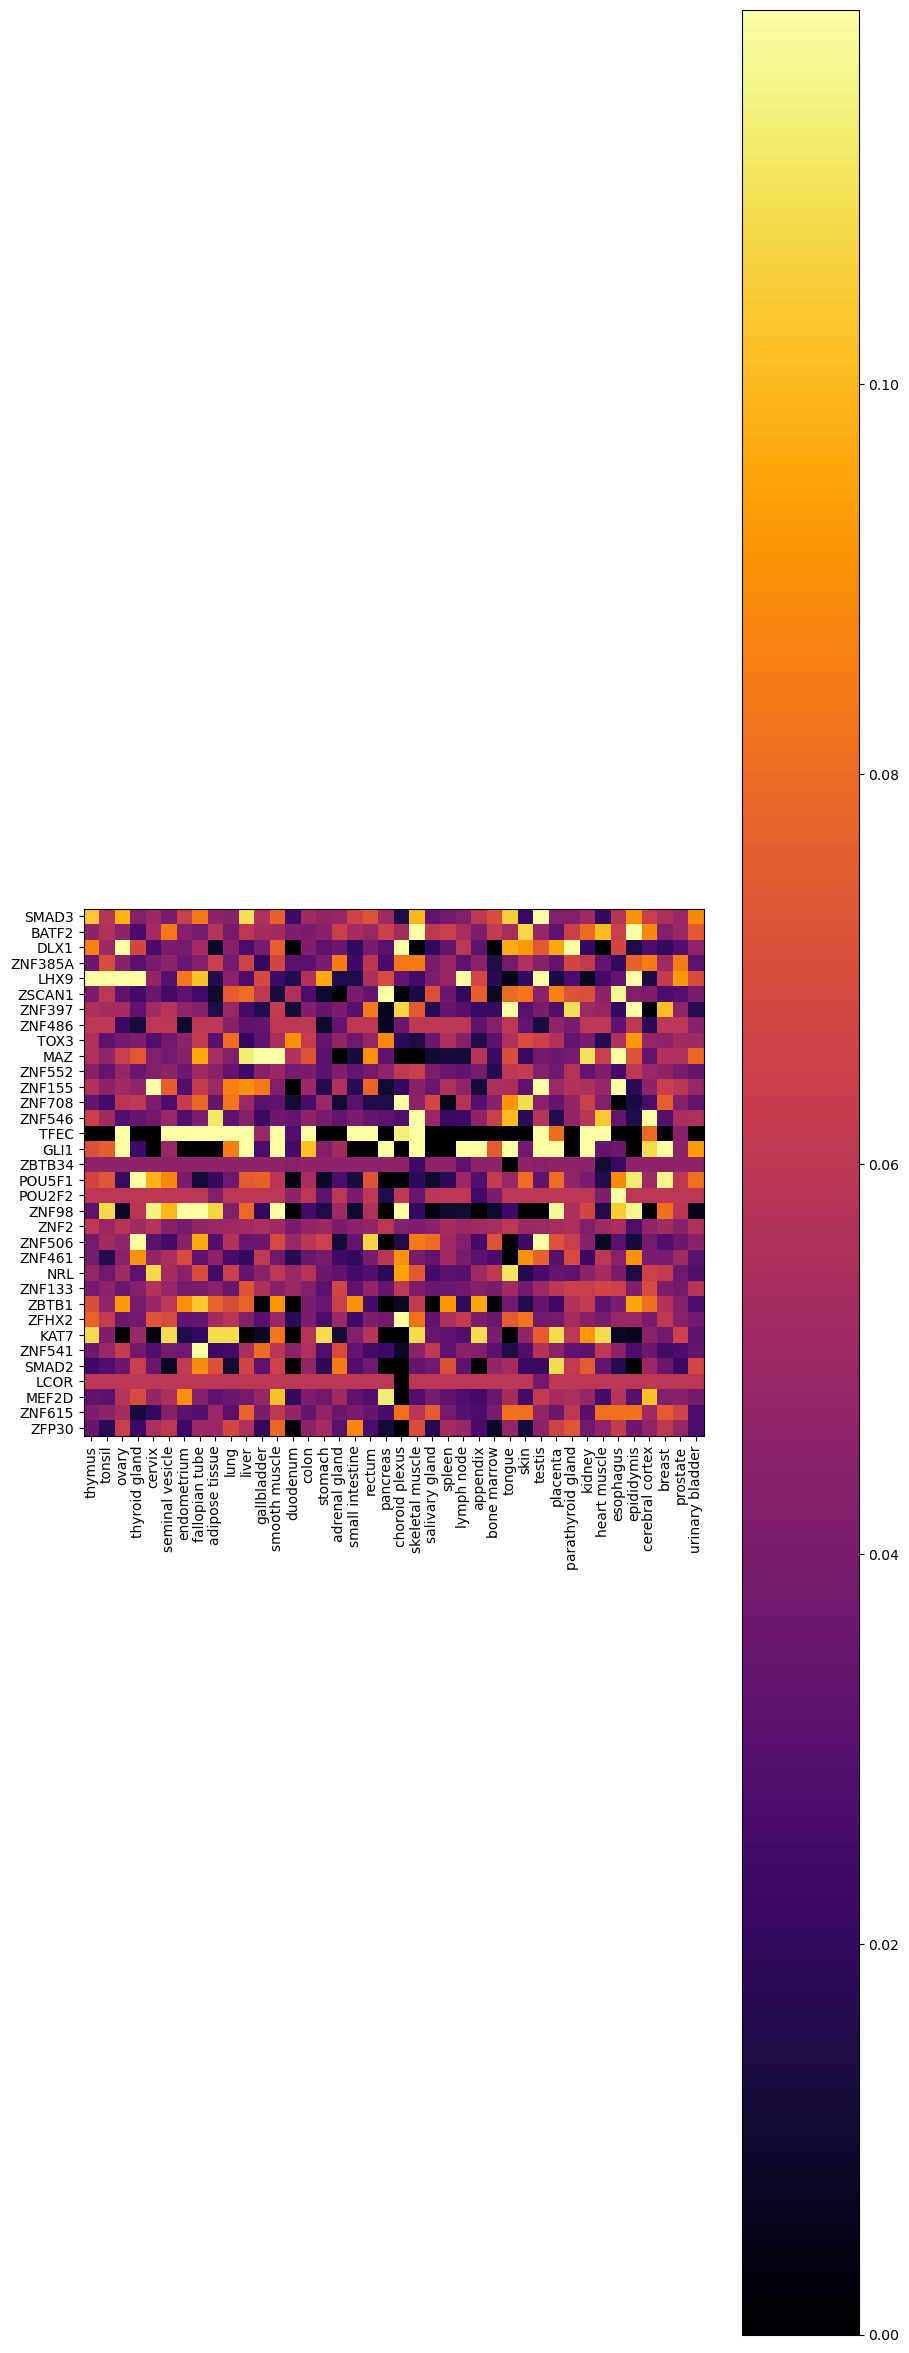

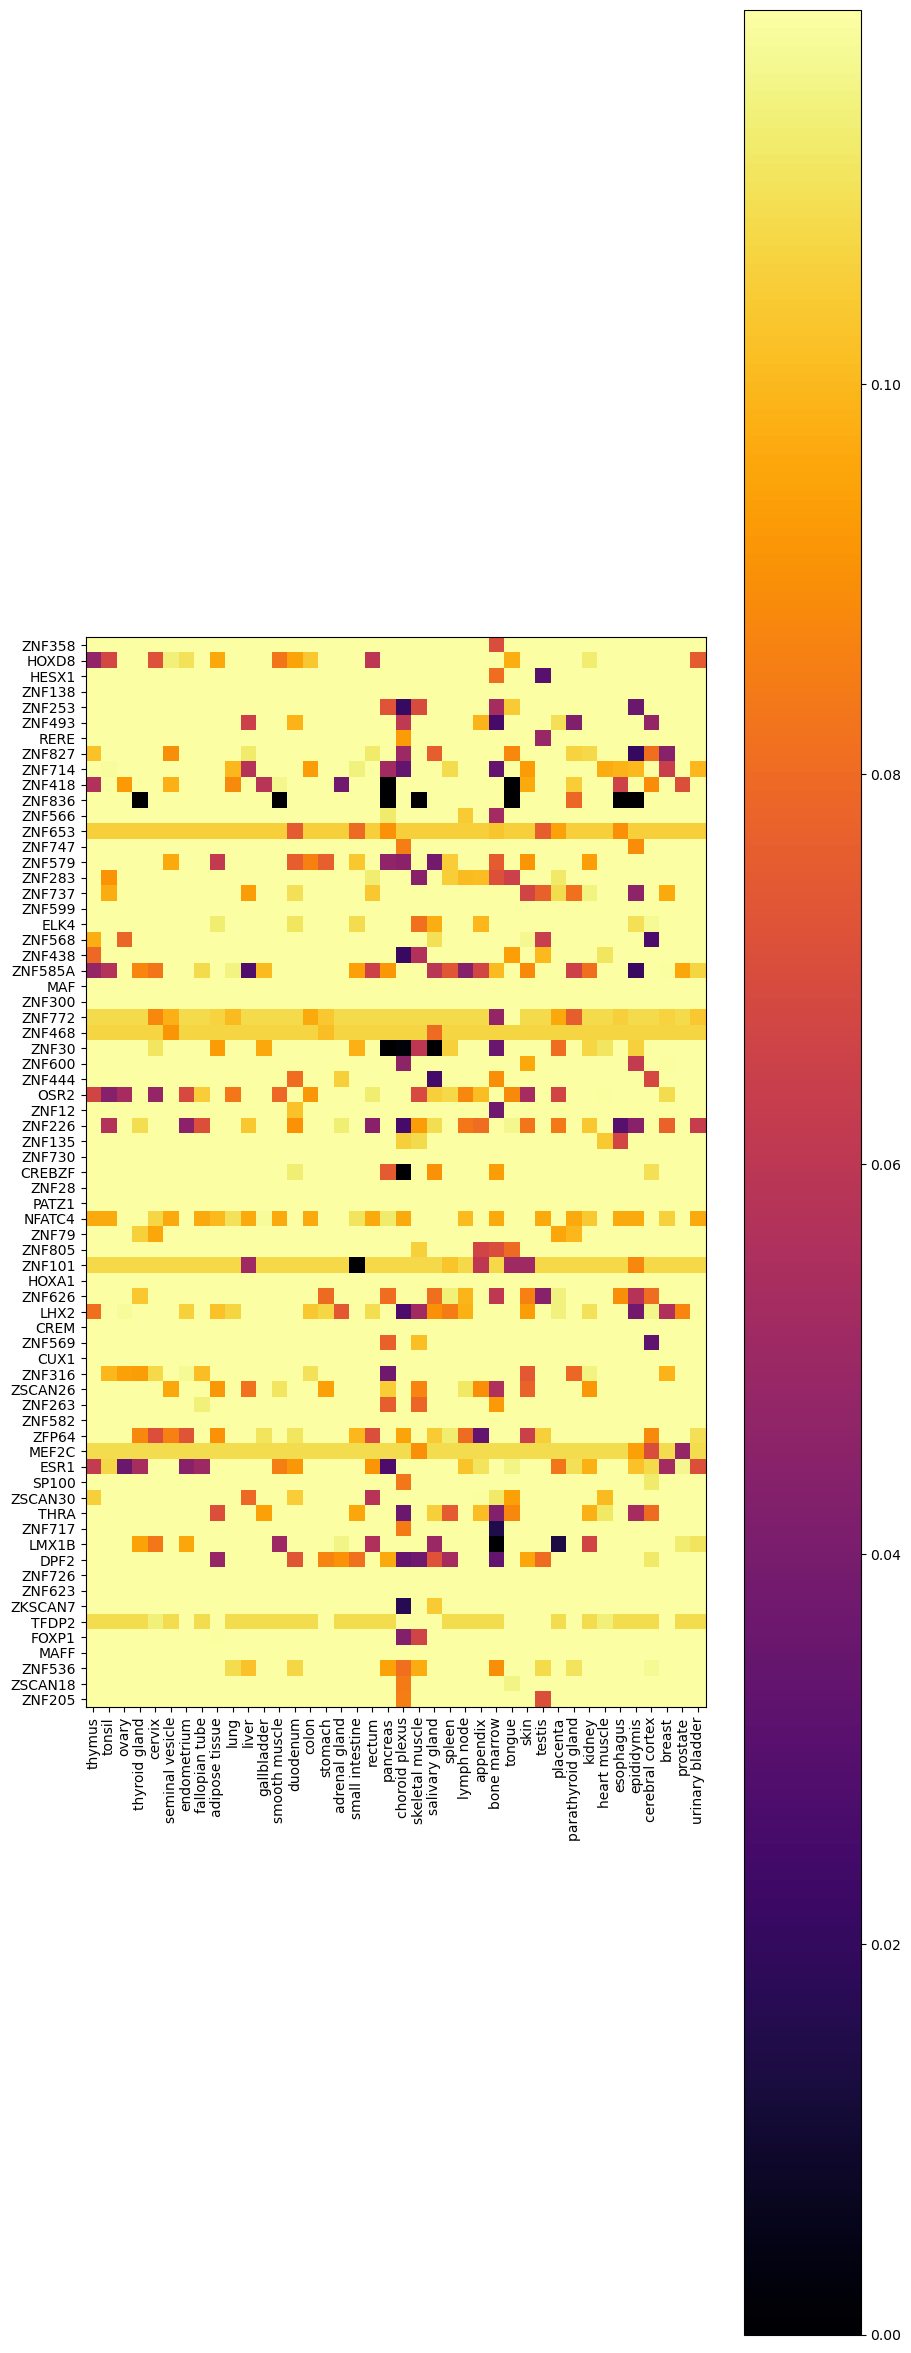

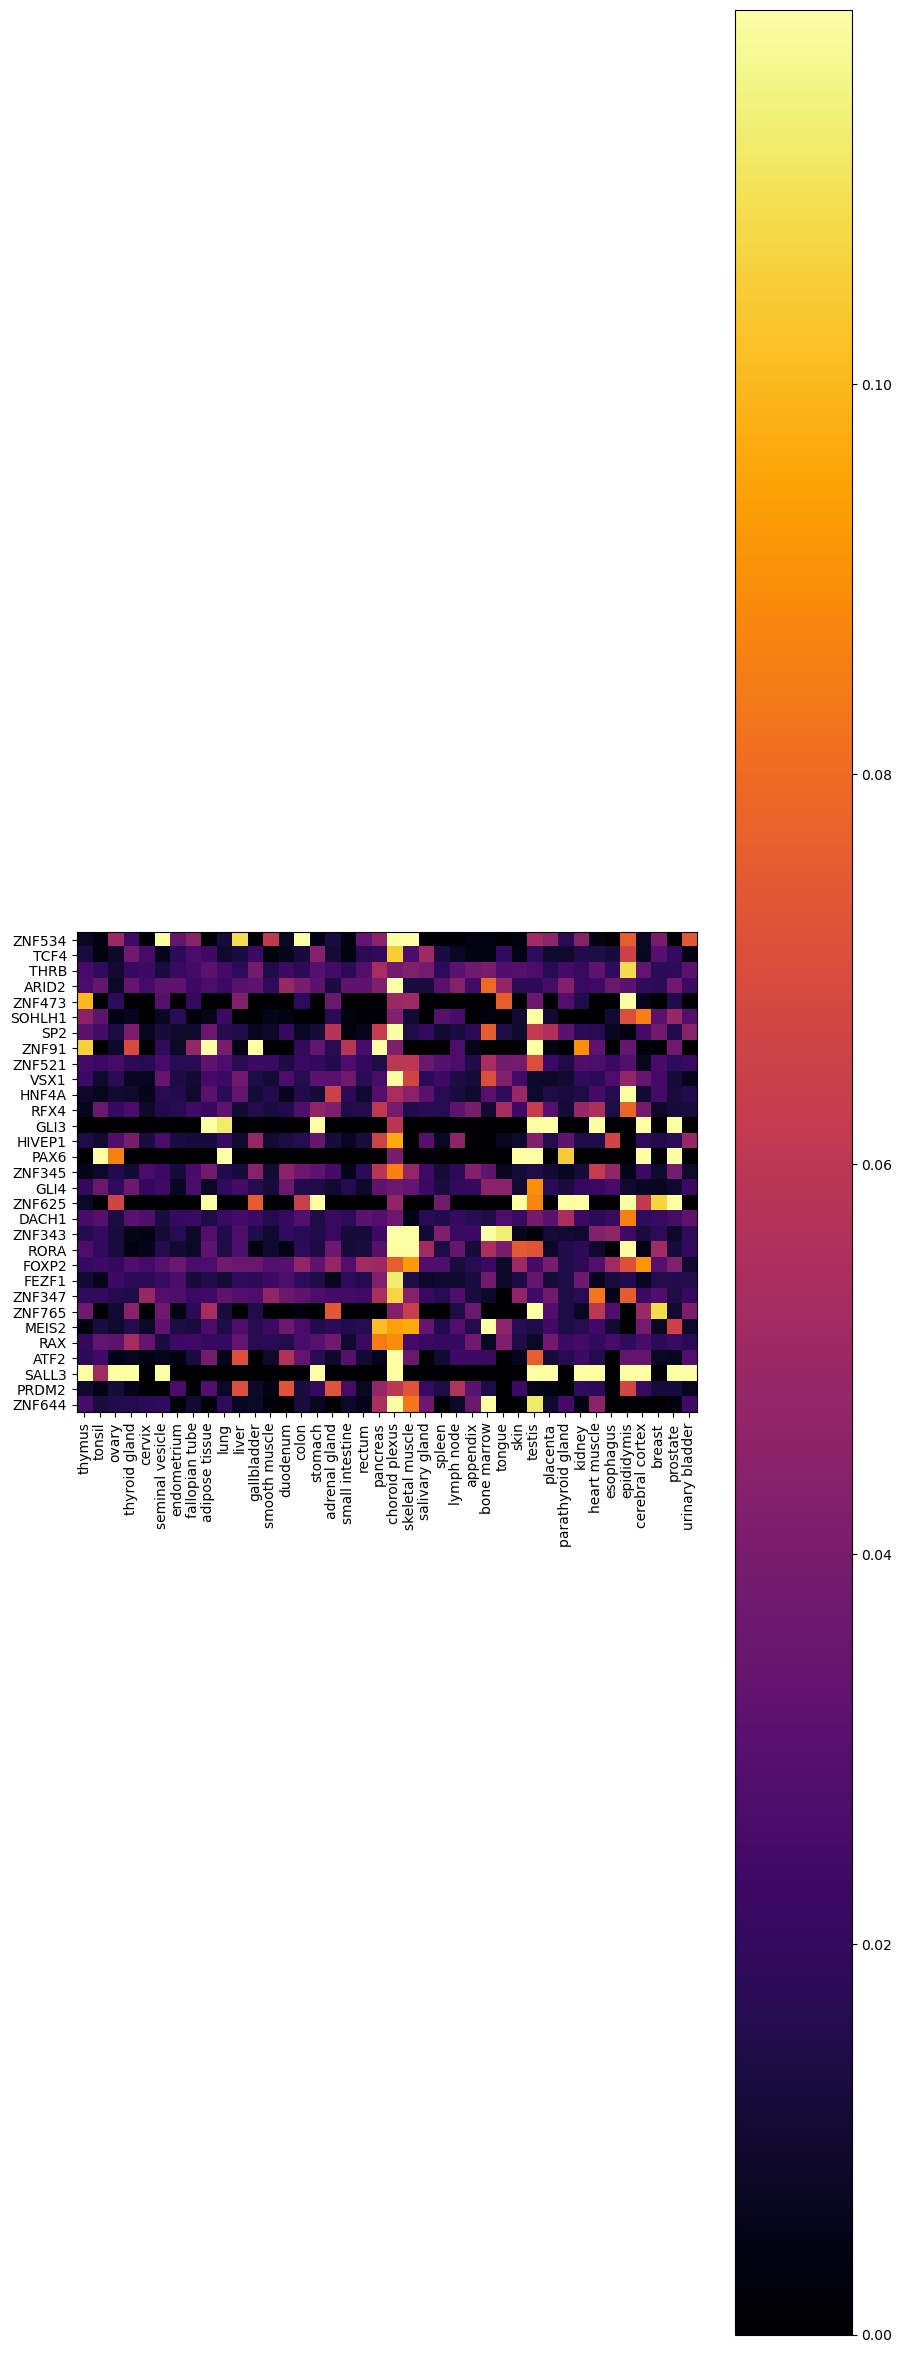

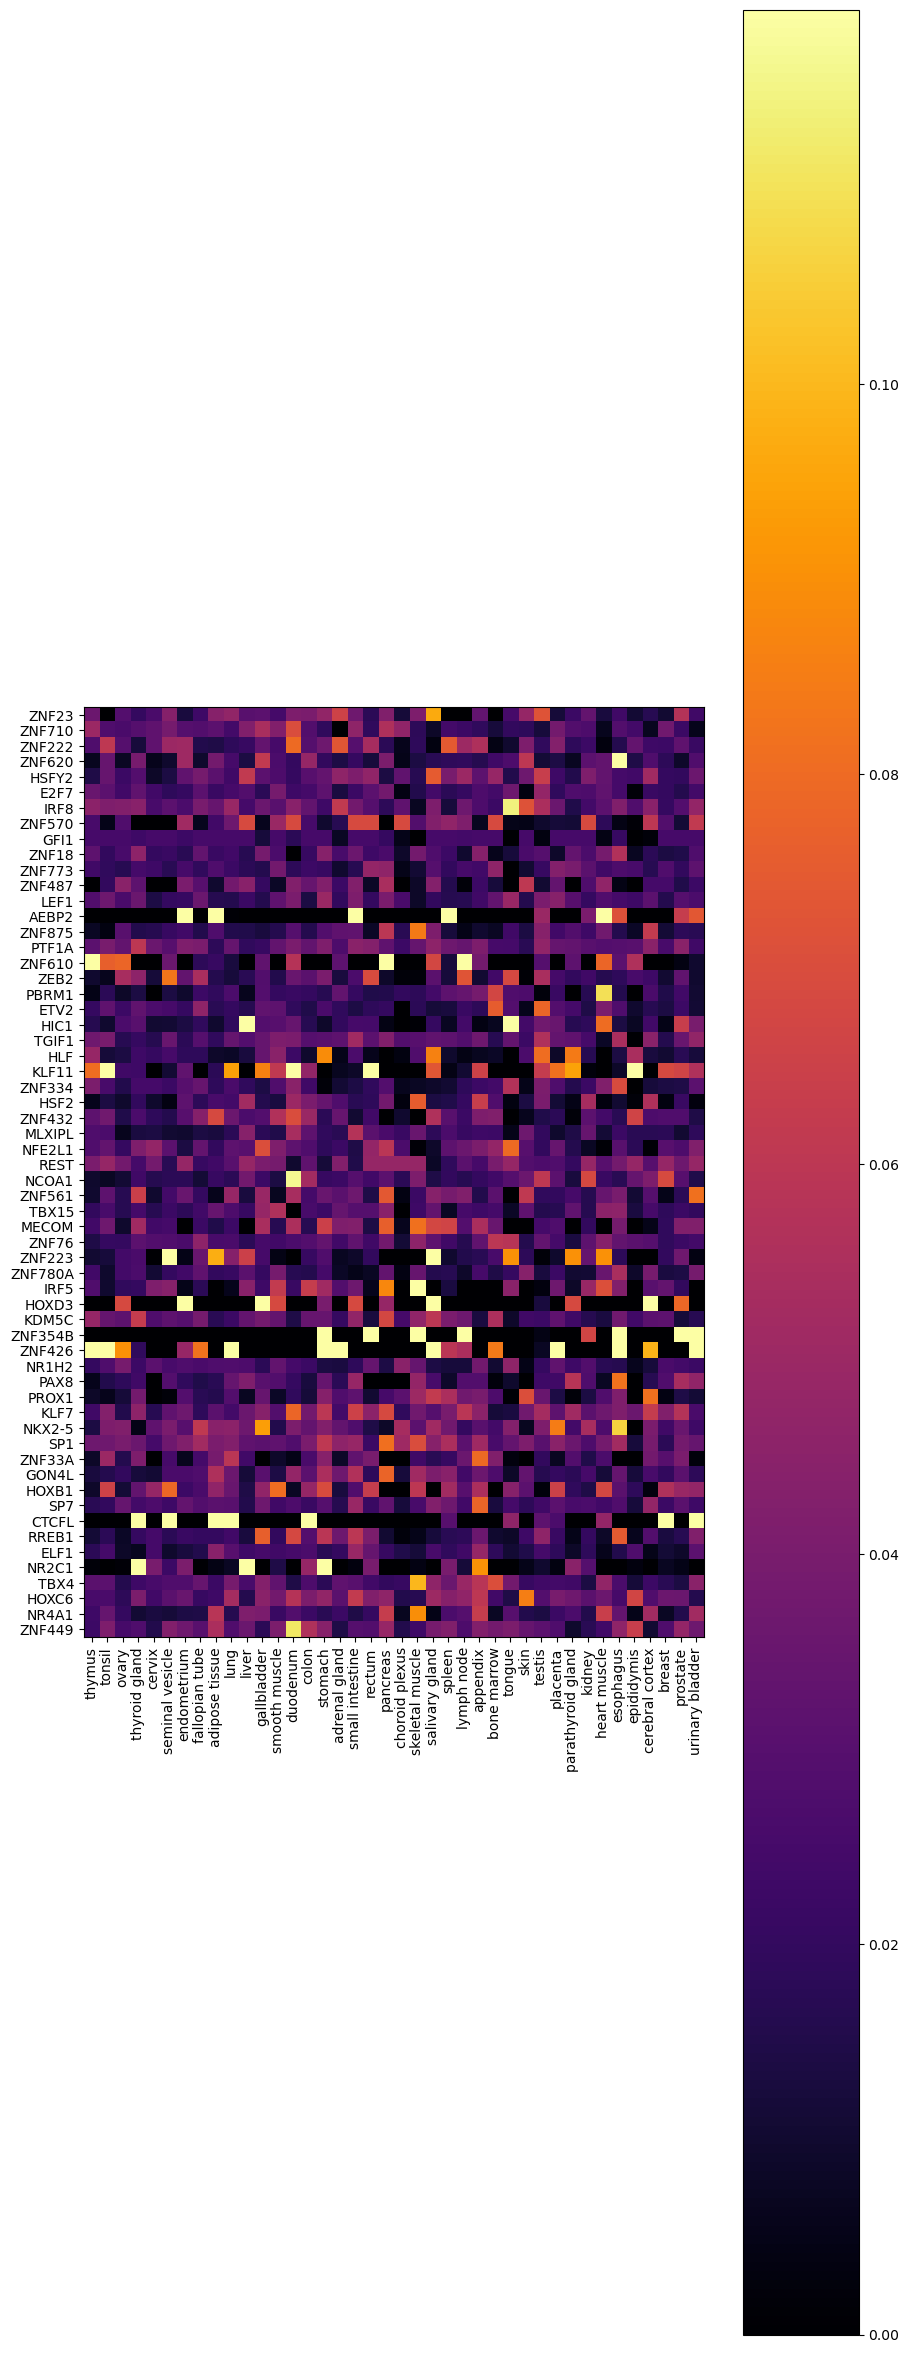

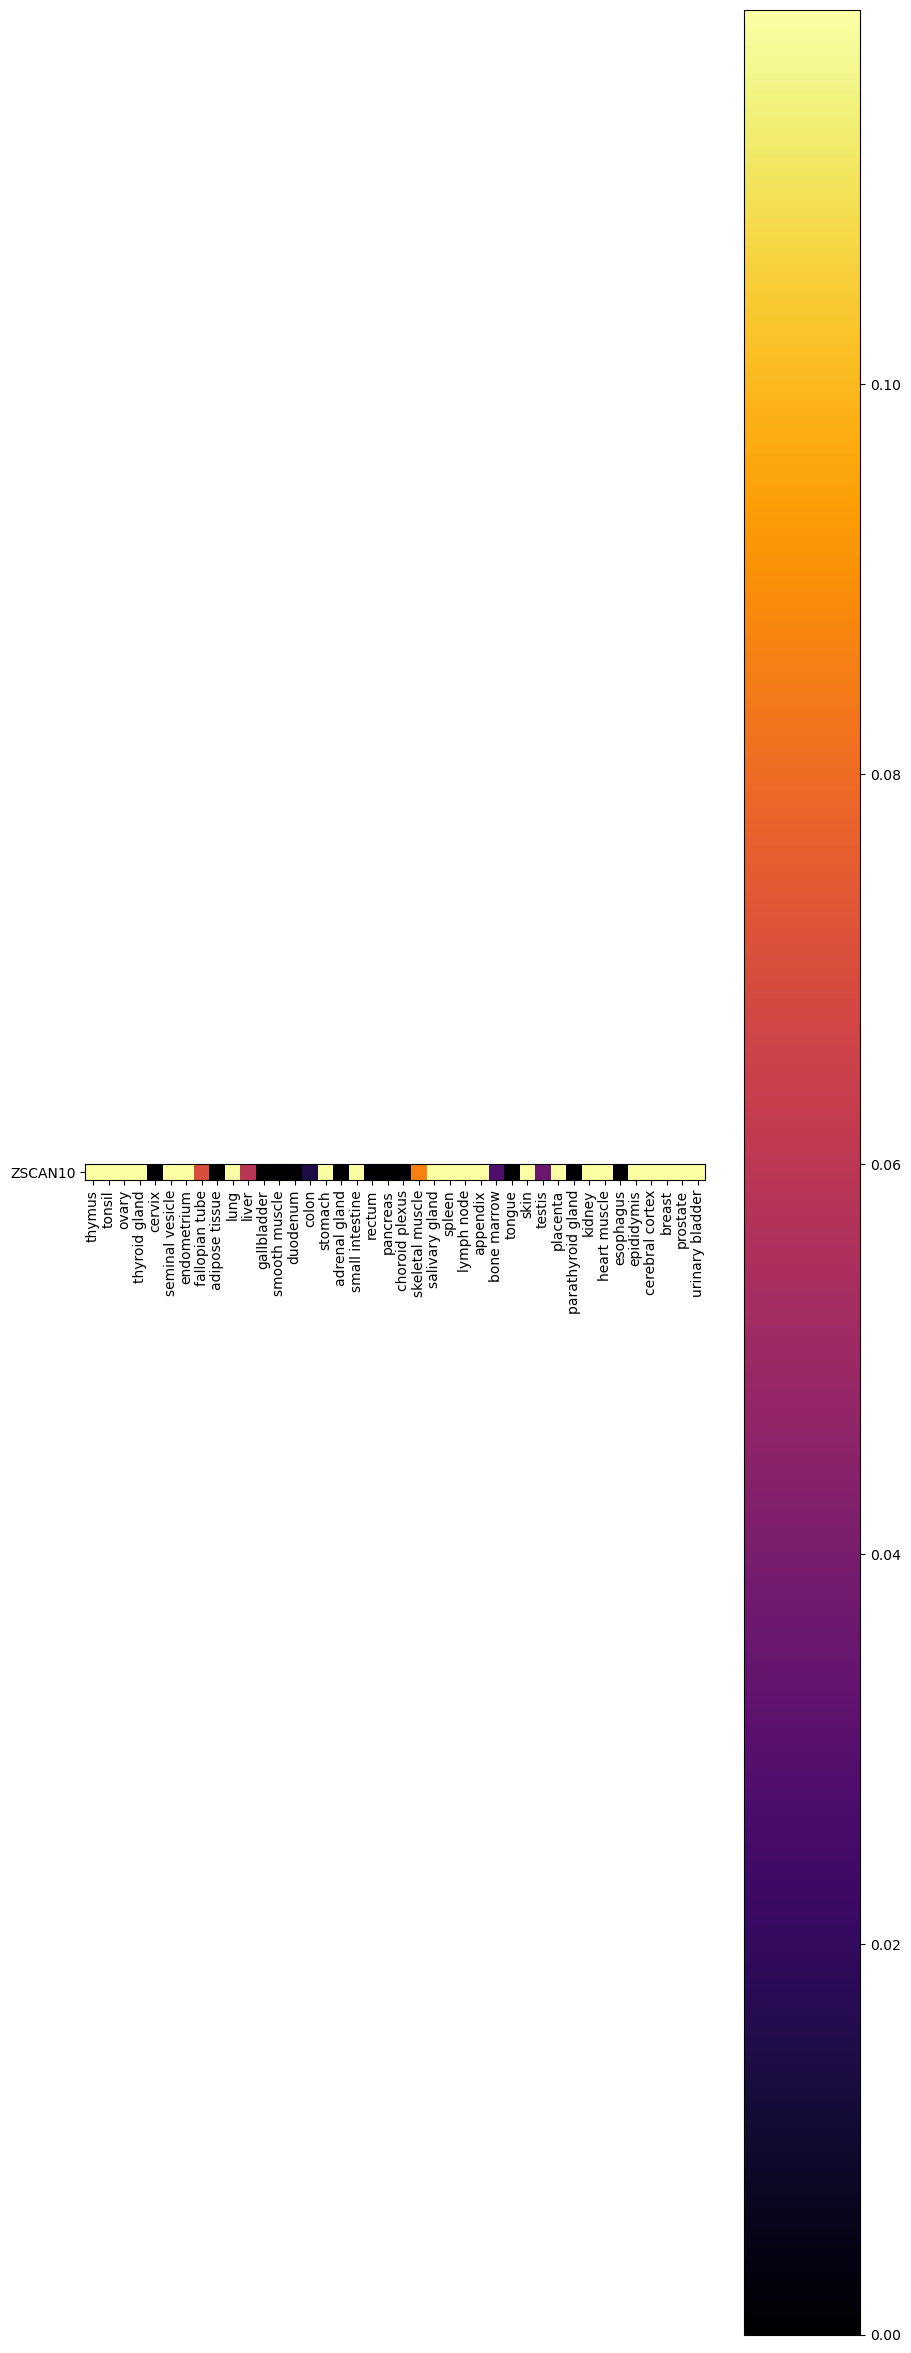

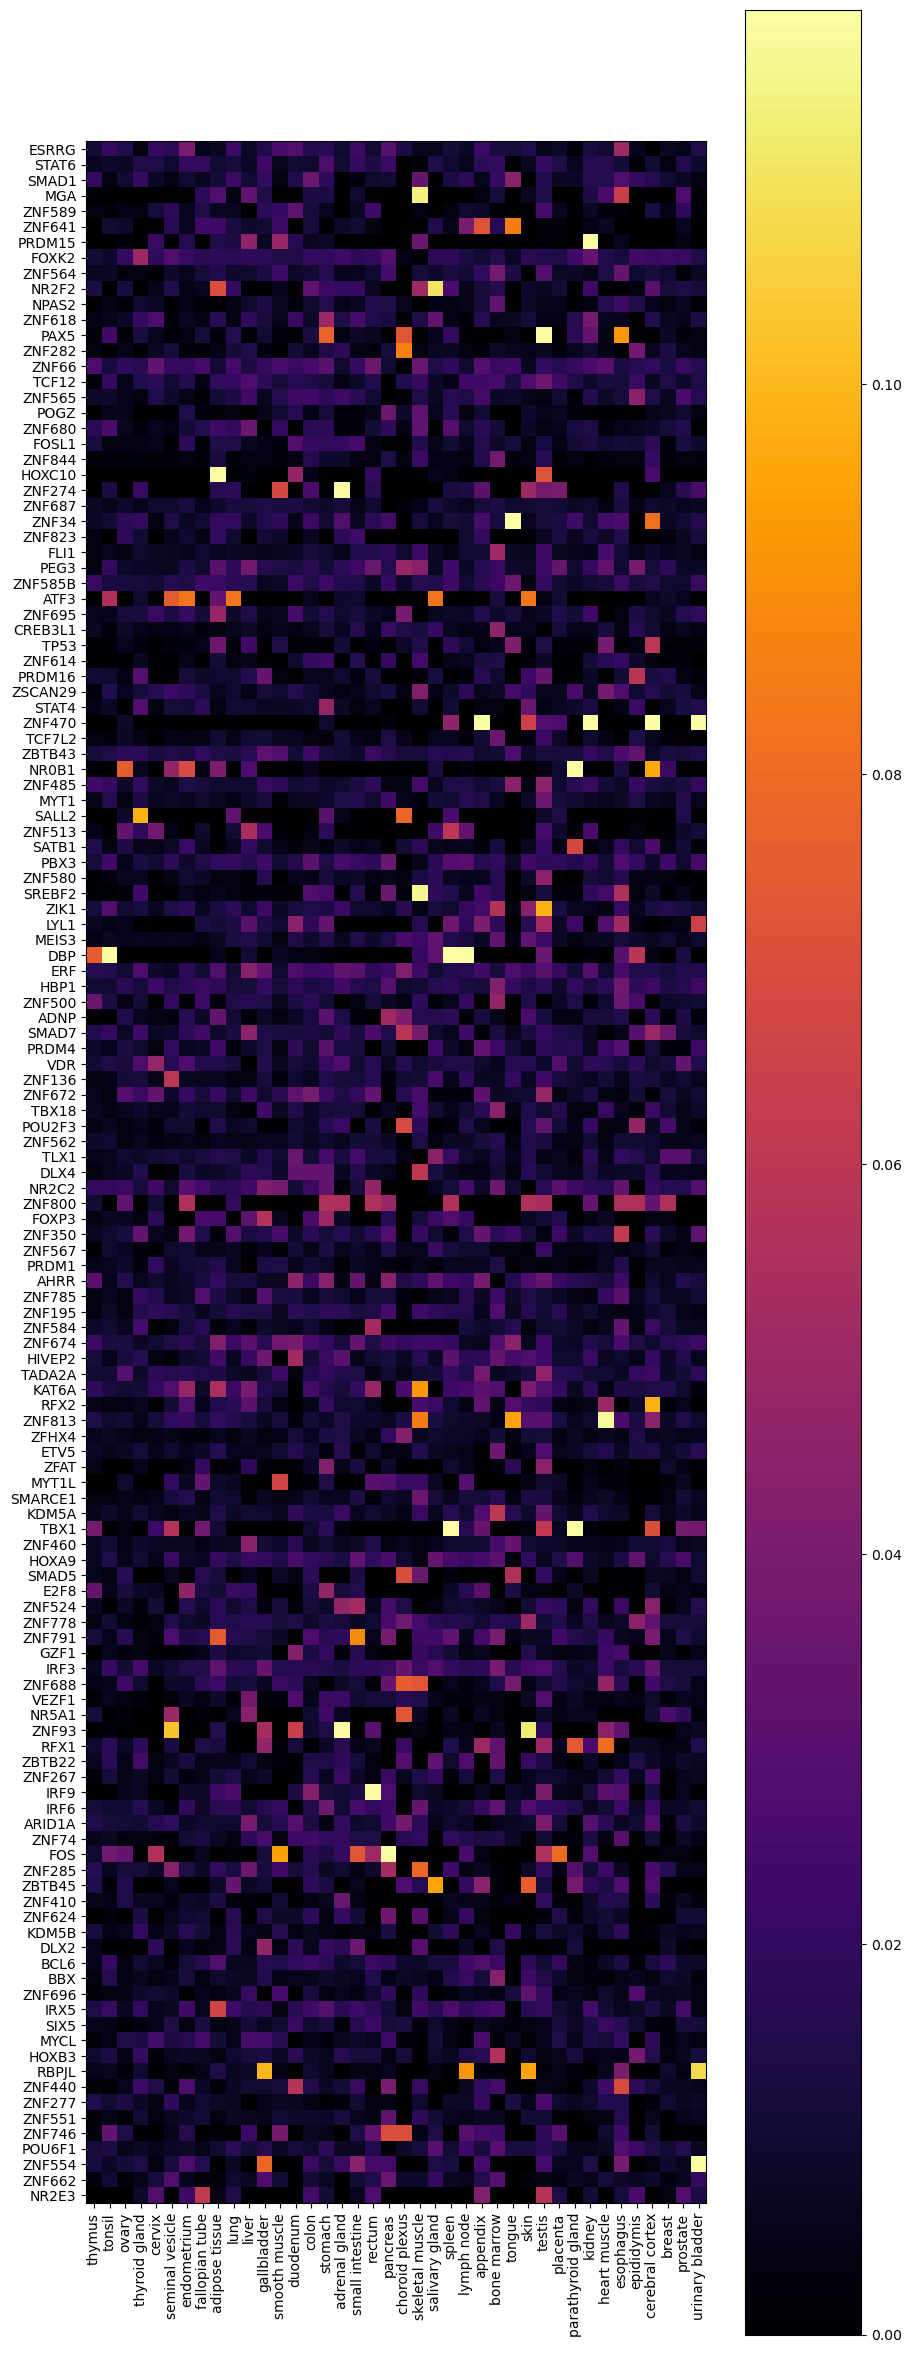

In [5]:
mg = mygene.MyGeneInfo()

gene_IF_table = np.empty((0,40))
rel_gene_IF_table = np.empty((0,40))
row_names = []
TF_interpro_dict = {}
for gene_id in impact_factors_gene:
    #print(gene_id)
    these_factors = np.array([impact_factors_gene[gene_id][tissue][0] 
                              for tissue in impact_factors_gene[gene_id]])
    rel_these_factors = np.array([rel_impact_factors_gene[gene_id][tissue][0] 
                                  for tissue in rel_impact_factors_gene[gene_id]])
    if(len(these_factors)==0): continue
    for prot_id in DNAbinding_seqs[gene_id]:
        if not prot_id.startswith("ENS"): continue
        for domain in DNAbinding_seqs[gene_id][prot_id]['domains']:
            #print(domain['interpro'])
            if domain['interpro']=='':
                continue
            elif domain['interpro'] not in TF_interpro_dict:
                TF_interpro_dict[domain['interpro']] = [gene_id]
            else:
                if gene_id not in TF_interpro_dict[domain['interpro']]:
                    TF_interpro_dict[domain['interpro']] += [gene_id]
    gene_IF_table = np.vstack((gene_IF_table, these_factors))
    rel_gene_IF_table = np.vstack((rel_gene_IF_table, rel_these_factors))
    row_names.append(gene_id)
    #break
for gene_id in impact_factors_gene:
    tissues = list({tissue: impact_factors_gene[gene_id][tissue][0] 
                    for tissue in impact_factors_gene[gene_id]}.keys())
    break
gene_IF_table = pd.DataFrame(gene_IF_table, index=row_names, columns=tissues)
rel_gene_IF_table = pd.DataFrame(rel_gene_IF_table, index=row_names, columns=tissues)
#print(gene_IF_table)
#print(tissues)
'''
for interpro_id in TF_interpro_dict:
    print(interpro_id)
    print(TF_interpro_dict[interpro_id])
    plt.pyplot.figure(figsize=(12,6))
    plt.pyplot.imshow(gene_IF_table.loc[TF_interpro_dict[interpro_id]], cmap="inferno")
    plt.pyplot.colorbar()
    plt.pyplot.xticks(range(len(tissues)), tissues, rotation=90)
    plt.pyplot.yticks(range(len(TF_interpro_dict[interpro_id])), TF_interpro_dict[interpro_id])
    plt.pyplot.show()

plt.pyplot.figure(figsize=(12,6))
custom_breakpoints = list(range(0,50,1)) + list(range(50,200,5))
cmap = plt.pyplot.get_cmap("inferno")
norm = plt.colors.BoundaryNorm(custom_breakpoints, cmap.N)
plt.pyplot.imshow(gene_IF_table, cmap=cmap, norm=norm)
plt.pyplot.colorbar()
plt.pyplot.xticks(range(len(tissues)), tissues, rotation=90)
plt.pyplot.show()

gene_IF_zscores = gene_IF_table.apply(zscore, axis=1)
plt.pyplot.figure(figsize=(12,6))
plt.pyplot.imshow(gene_IF_zscores, cmap="inferno")
plt.pyplot.colorbar()
plt.pyplot.xticks(range(len(tissues)), tissues, rotation=90)
plt.pyplot.show()

k_values = range(3,50)
distortions = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(gene_IF_zscores)
    distortions.append(kmeans.inertia_)
plt.pyplot.figure(figsize=(8, 6))
plt.pyplot.plot(k_values, distortions, marker='o', linestyle='-')
plt.pyplot.title('Elbow Plot')
plt.pyplot.xlabel('Number of Clusters (k)')
plt.pyplot.ylabel('Distortion (Inertia)')
plt.pyplot.grid(True)
plt.pyplot.show()

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(gene_IF_zscores)
#print(kmeans.labels_[:5])
cluster_labels_matrix = np.expand_dims(kmeans.labels_, axis=0)
cmap = plt.pyplot.cm.get_cmap('tab10', n_clusters)
kmeans_order = np.argsort(kmeans.labels_)
plt.pyplot.figure(figsize=(6,20))
plt.pyplot.imshow(gene_IF_zscores.iloc[kmeans_order,:], cmap="inferno")
plt.pyplot.colorbar()
plt.pyplot.xticks(range(len(tissues)), tissues, rotation=90)
plt.pyplot.show()

for i in range(n_clusters):
    rnames = gene_IF_zscores.index[kmeans.labels_==i]
    rnames1 = []
    #print(mg.getgene("ENSG00000156273")[0]['symbol'])
    for rname in rnames:
        try:
            symbol = mg.getgene(rname)['symbol'] 
        except:
            symbol = mg.getgene(rname)[0]['symbol'] 
        rnames1.append(symbol)
    plt.pyplot.figure(figsize=(10,40))
    plt.pyplot.imshow(gene_IF_zscores.iloc[[lab==i for lab in kmeans.labels_],:], cmap="inferno")
    #plt.pyplot.colorbar()
    plt.pyplot.xticks(range(len(tissues)), tissues, rotation=90)
    plt.pyplot.yticks(range(len(rnames1)), rnames1)
    plt.pyplot.show()
'''
plt.pyplot.figure(figsize=(20,6))
rel_custom_breakpoints = list(np.arange(0,0.20,0.01)) + list(np.arange(0.20,1,0.1))
rel_cmap = plt.pyplot.get_cmap("inferno")
rel_norm = plt.colors.BoundaryNorm(rel_custom_breakpoints, rel_cmap.N)
plt.pyplot.imshow(rel_gene_IF_table, cmap=rel_cmap, norm=rel_norm)
plt.pyplot.colorbar()
plt.pyplot.xticks(range(len(tissues)), tissues, rotation=90)
plt.pyplot.show()

k_values = range(3,50)
distortions = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(rel_gene_IF_table)
    distortions.append(kmeans.inertia_)
plt.pyplot.figure(figsize=(8, 6))
plt.pyplot.plot(k_values, distortions, marker='o', linestyle='-')
plt.pyplot.title('Elbow Plot')
plt.pyplot.xlabel('Number of Clusters (k)')
plt.pyplot.ylabel('Distortion (Inertia)')
plt.pyplot.grid(True)
plt.pyplot.show()

kmeans_tissues = KMeans(n_clusters=12)
kmeans_tissues.fit(rel_gene_IF_table.T)
tissue_cluster_labels_matrix = np.expand_dims(kmeans_tissues.labels_, axis=0)
tissue_order = np.argsort(kmeans_tissues.labels_)
print(tissue_cluster_labels_matrix)
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(rel_gene_IF_table)
#print(kmeans.labels_[:5])
cluster_labels_matrix = np.expand_dims(kmeans.labels_, axis=0)
cmap = plt.pyplot.cm.get_cmap('tab20', n_clusters)
kmeans_order = np.argsort(kmeans.labels_)
#fig, axes = plt.pyplot.subplots(2,2,figsize=(20,60), 
#                                gridspec_kw={'width_ratios': [1, 20], 'height_ratios': [1, 50]})
#
#axes[0,0].axis('off')



In [41]:
with open("rel_gene_IF_table.pickle", "wb") as f:
    pickle.dump(rel_gene_IF_table, f)
with open("tissue_cluster_labels_matrix.pickle", "wb") as f:
    pickle.dump(tissue_cluster_labels_matrix, f)
with open("cluster_labels_matrix.pickle", "wb") as f:
    pickle.dump(cluster_labels_matrix, f)
with open("kmeans_order.pickle", "wb") as f:
    pickle.dump(kmeans_order, f)
with open("tissue_order.pickle", "wb") as f:
    pickle.dump(tissue_order, f)

In [4]:
with open("rel_gene_IF_table.pickle", "rb") as f:
    rel_gene_IF_table = pickle.load(f)
with open("tissue_cluster_labels_matrix.pickle", "rb") as f:
    tissue_cluster_labels_matrix = pickle.load(f)
with open("cluster_labels_matrix.pickle", "rb") as f:
    cluster_labels_matrix = pickle.load(f)
with open("kmeans_order.pickle", "rb") as f:
    kmeans_order = pickle.load(f)
with open("tissue_order.pickle", "rb") as f:
    tissue_order = pickle.load(f)

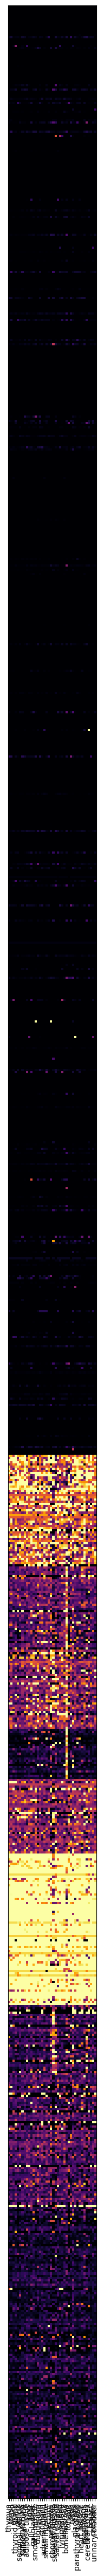

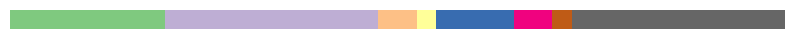

AttributeError: 'KMeans' object has no attribute 'labels_'

In [9]:
##need to fix still

for gene_id in impact_factors_gene:
    tissues = list({tissue: impact_factors_gene[gene_id][tissue][0] 
                    for tissue in impact_factors_gene[gene_id]}.keys())
    break
n_clusters = 12

plt.pyplot.figure(figsize=(20,60))
#axes[1,1].set_position([0.0,0.05,0.9,0.85])
plt.pyplot.imshow(rel_gene_IF_table.iloc[kmeans_order,tissue_order], cmap="inferno")#rel_cmap, norm=rel_norm)
plt.pyplot.xticks(range(len(tissues)), np.array(tissues)[tissue_order], rotation=90)
plt.pyplot.yticks([])
plt.pyplot.show()

plt.pyplot.figure(figsize=(10,15))
#axes[0,1].set_position([0.1,0.95,0.10,0.05])
plt.pyplot.imshow(tissue_cluster_labels_matrix[:,tissue_order], cmap="Accent")
plt.pyplot.xticks([])
plt.pyplot.yticks([])
plt.pyplot.axis('off')
#plt.pyplot.show()

plt.pyplot.figure(figsize=(20,60))
#axes[1,0].set_position([0.05, 0.05,0.1,0.90])
plt.pyplot.imshow(cluster_labels_matrix.T[kmeans_order,:], cmap="tab20")
plt.pyplot.xticks([])
plt.pyplot.yticks([])
plt.pyplot.axis('off')

#fig.subplots_adjust(wspace=0.01, hspace=0.01)
#fig.colorbar(plt.pyplot.cm.ScalarMappable(cmap="inferno"), ax=axes)
plt.pyplot.show()

for i in range(n_clusters):
    rnames = rel_gene_IF_table.index[[lab==i for lab in kmeans.labels_]]
    rnames1 = []
    #print(mg.getgene("ENSG00000156273")[0]['symbol'])
    for rname in rnames:
        try:
            symbol = mg.getgene(rname)['symbol'] 
        except:
            symbol = mg.getgene(rname)[0]['symbol'] 
        rnames1.append(symbol)
    plt.pyplot.figure(figsize=(10,40))
    plt.pyplot.imshow(rel_gene_IF_table.iloc[[lab==i 
                                              for lab in kmeans.labels_],
                                             tissue_order]
                      , cmap="inferno")#rel_cmap, norm=rel_norm)
    plt.pyplot.colorbar()
    plt.pyplot.xticks(range(len(tissues)), np.array(tissues)[tissue_order], rotation=90)
    plt.pyplot.yticks(range(len(rnames1)), rnames1)
    plt.pyplot.show()


In [30]:
rel_gene_IF_table_melted = rel_gene_IF_table.melt(ignore_index=False, 
                                                  var_name="Tissue", 
                                                  value_name="ASIF")
#print(proteome_atlas)
print(rel_gene_IF_table_melted.index.to_list()[:5])
print(average_tpms[rel_gene_IF_table_melted.index[0]])
print(rel_gene_IF_table_melted)

['ENSG00000004848', 'ENSG00000005073', 'ENSG00000005102', 'ENSG00000005513', 'ENSG00000005801']
{'ENST00000379044': {'adipose tissue': 0.0160744, 'adrenal gland': 0.018484999999999998, 'appendix': 0.053719666666666666, 'bone marrow': 0.028491000000000002, 'breast': 0.02401075, 'cerebral cortex': 5.791083333333333, 'cervix': 0.025693, 'choroid plexus': 0.0588775, 'colon': 0.252067, 'duodenum': 1.0995025, 'endometrium': 0.0229654, 'epididymis': 0.158846, 'esophagus': 0.133232, 'fallopian tube': 0.3558006, 'gallbladder': 0.014319666666666666, 'heart muscle': 0.0079665, 'kidney': 0.035550111111111116, 'liver': 0.005862399999999999, 'lung': 0.27448177777777777, 'lymph node': 0.0238364, 'ovary': 39.078742857142856, 'pancreas': 0.297979, 'parathyroid gland': 0.8518699999999999, 'placenta': 0.079891, 'prostate': 0.23420577777777776, 'rectum': 0.40629899999999997, 'salivary gland': 0.012925666666666667, 'seminal vesicle': 0.050633000000000004, 'skeletal muscle': 6.634054000000001, 'skin': 0.047

In [40]:
rel_gene_IF_table.iloc[kmeans_order, tissue_order].to_csv("ASIF_byGene.csv", 
                                                          index_label="Gene")
rel_gene_IF_table.melt(ignore_index=False).to_csv("ASIF_melted.csv", index_label="Gene")

np.savetxt("tissue_cluster_ordered.csv", 
           np.vstack([np.array([tissues])[:, tissue_order], 
                      tissue_cluster_labels_matrix[:, tissue_order]]), 
           delimiter=",",
           fmt="%s")
np.savetxt("gene_cluster_ordered.csv", 
           np.vstack([np.array([rel_gene_IF_table.index[kmeans_order]]),
                      cluster_labels_matrix[:, kmeans_order]]), 
           delimiter=",",
           fmt="%s")

In [39]:
print(rel_gene_IF_table.melt(ignore_index=False))

                        variable     value
ENSG00000004848   adipose tissue  0.000335
ENSG00000005073   adipose tissue  0.000335
ENSG00000005102   adipose tissue  0.005991
ENSG00000005513   adipose tissue  0.000335
ENSG00000005801   adipose tissue  0.007534
...                          ...       ...
ENSG00000276234  urinary bladder  0.019680
ENSG00000276644  urinary bladder  0.023638
ENSG00000278129  urinary bladder  0.000335
ENSG00000278318  urinary bladder  0.000265
ENSG00000278570  urinary bladder  0.013768

[45480 rows x 2 columns]


Playing with Vasilli's ENCODE stuff

In [8]:
cerberus_gtf = pd.read_csv("../ENCODE_FILES/cerberus.gtf", 
                           sep='\t', 
                           comment="#", 
                           header=None, 
                           names=['seqname', 'source', 'feature', 
                                  'start', 'end', 'score', 'strand', 
                                  'frame', 'attribute']
                          )
cerberus_gtf.head()

seqname source     feature      start        end score strand frame  \
0    chr1    NaN        gene  169794680  169854130     .      +     .   
1    chr1  TALON  transcript  169794680  169853135     .      +     .   
2    chr1  TALON        exon  169794680  169795213     .      +     .   
3    chr1  TALON        exon  169798919  169798958     .      +     .   
4    chr1  TALON        exon  169800883  169800971     .      +     .   

                                           attribute  
0  gene_id "ENSG00000000460.16"; gene_status "KNO...  
1  gene_id "ENSG00000000460.16"; gene_status "KNO...  
2  gene_id "ENSG00000000460.16"; gene_status "KNO...  
3  gene_id "ENSG00000000460.16"; gene_status "KNO...  
4  gene_id "ENSG00000000460.16"; gene_status "KNO...

In [19]:
mg = mygene.MyGeneInfo()
for i in range(cerberus_gtf.shape[0]):
    if cerberus_gtf.loc[i, "feature"]!="gene": continue
    ensg = cerberus_gtf.loc[i,"attribute"].split(";")[0][9:-1]
    gene_object = mg.getgene(ensg)
    if gene_object == None: continue
    print(gene_object["symbol"])
    break
    handle = Entrez.efetch(db="nucleotide", 
                           id=gene_object['refseq']['genomic'][0],
                           #seq_start=start_pos,
                           #seq_stop=end_pos,
                           rettype="gb")
    record = SeqIO.read(handle, "gb")
    print(record)

KeyboardInterrupt: 

### Below is old stuff in case I need it

Get the transcript counts per tissue (thanks Vasilli)

In [9]:
import geneminer

listofgenes = DNAbinding_seqs.keys()
if 'genes' not in locals():
    genes={}
for s in listofgenes:
    if s in genes: continue
    if s=="ENSG00000204060": continue
    #print(s)
    g = geneminer.Mygene2(s)
    g.fill()
    genes[s] = g
genes = list(genes.values())

calculate impact factor per isoform per tissue

In [28]:
alpha = 6
beta = -3
def sigmoid(x):
    return 1/(1+np.power(np.e,-x))

impact_factors = {}
rel_impact_factors = {}
for gene in genes:
    N = len(DNAbinding_seqs[gene.name]["superdomains"])
    if N==0: continue
    if gene_id=="ENSG00000204060": continue
    impact_factors[gene.name] = {}
    rel_impact_factors[gene.name] = {}
    for transcript in gene.transcripts:
        if transcript.protein=="No Protein" or \
          transcript.protein not in isoform_coverage_percentages[gene.name]:
            continue
        #print(transcript.protein)
        #print(transcript.gtex)
        if len(transcript.gtex) == 0 or max(transcript.gtex) == 0: continue
        impact_factors[gene.name][transcript.protein] = {}
        rel_impact_factors[gene.name][transcript.protein] = {}
        for i in range(len(transcript.gtex)):
            tissue = transcript.columns[i]
            tissue_expression = transcript.gtex[i]
            rel_tissue_expression = tissue_expression/max(transcript.gtex)
            impact_factor = [0, tissue_expression]
            rel_impact_factor = [0, rel_tissue_expression]
            for domain in isoform_coverage_percentages[gene.name][transcript.protein]:
                #print(isoform_coverage_percentages[gene.name][transcript.protein][domain])
                #print(sigmoid(alpha*(1-isoform_coverage_percentages[gene.name][transcript.protein][domain]) \
                #                            + beta))
                impact_factor[0] += sigmoid(alpha*(isoform_coverage_percentages[gene.name][transcript.protein][domain]) \
                                            + beta)
                rel_impact_factor[0] += sigmoid(alpha*(isoform_coverage_percentages[gene.name][transcript.protein][domain]) \
                                                + beta)
            impact_factors[gene.name][transcript.protein][tissue] = \
              (tissue_expression*(1/N*impact_factor[0]), impact_factor[1])
            rel_impact_factors[gene.name][transcript.protein][tissue] = \
              (rel_tissue_expression*(1/N*rel_impact_factor[0]), rel_impact_factor[1])

#print(impact_factors)

Generate consensus domains of interest

In [ ]:
for gene_id in DNAbinding_seqs:
    for prot_id in DNAbinding_seqs[gene_id]:
        if prot_id=="ref":
            continue
        #for each domain, classify it as certain type
        for domain in DNAbinding_seqs[gene_id][prot_id]['domains']:
            if 'DNA' in domain['description']:
                domain['class'] = "DNA"
            elif 'PPI' in domain['description']:
                domain['class'] = "PPI"
            elif 'Transcription' in domain['description'] or 'transcription' in domain['description']:
                domain['class'] = "TR"
            else:
                domain['class'] = "other"
        for classification in ["DNA", "PPI", "TR", "other"]:
            domain_queue = [domain for domain in DNAbinding_seqs[gene_id][prot_id]['domains'] 
                            if domain['class']==classification]
            consensus_domains = []
            #pprint.pprint(domain_queue)
            while len(domain_queue)>0:
                currDomain = domain_queue.pop()
                removeList = []
                for i, domain in enumerate(domain_queue):
                    if (currDomain['start'] <= domain['start'] and 
                    currDomain['end'] >= domain['start']) or \
                    (currDomain['start'] <= domain['end'] and
                    currDomain['end'] >= domain['end']) or \
                    (currDomain['start'] >= domain['start'] and
                    currDomain['end'] <= domain['end']):
                        currDomain['start'] = min(currDomain['start'], domain['start'])
                        currDomain['end'] = max(currDomain['end'], domain['end'])
                        removeList.append(i)
                        #print("currDomain")
                        #pprint.pprint(currDomain)
                #print(removeList)
                #pprint.pprint(domain_queue)
                for i in removeList[-1::-1]:
                    del domain_queue[i]
                consensus_domains.append(currDomain)
        DNAbinding_seqs[gene_id][prot_id]['consensus_domains'] = consensus_domains
    #break

Original domain type counting

2.3396275556713113
0.17801797108998568
0.21169739351557534


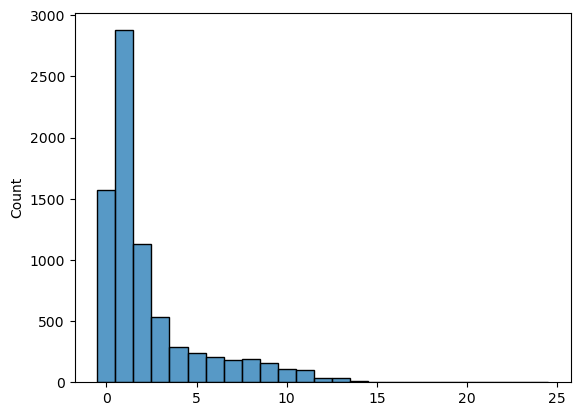

In [3]:
total_domains = 0
total_isoforms = 0
domain_type_counts = {}
isoforms_with_DNAbinding = 0
genes_with_DNAbinding = 0
geneList_DNAbinding = []
domain_counts = []
for gene_id in seqs:
    for prot_id in seqs[gene_id]:
        if not prot_id.startswith("ENS"):
            continue
        total_isoforms+=1
        domain_counts.append(0)
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['type']!='SuperFamily':
                continue
            total_domains+=1
            domain_counts[-1]+=1
            if domain['description'] in domain_type_counts:
                domain_type_counts[domain['description']]+=1
            else:
                domain_type_counts[domain['description']]=1
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['type']!='SuperFamily':
                continue
            if "DNA-binding" in domain['description']:
                isoforms_with_DNAbinding+=1
                break
    has_DNA = False
    for prot_id in seqs[gene_id]:
        if not prot_id.startswith("ENS"):
            continue
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['type']!="SuperFamily":
                continue
            if "DNA-binding" in domain['description']:
                has_DNA = True
                break
    if has_DNA:
        genes_with_DNAbinding += 1
        geneList_DNAbinding.append(gene_id)
print(total_domains/total_isoforms)
sns.histplot(domain_counts, discrete=True);
#print(domain_type_counts)
print(isoforms_with_DNAbinding/total_isoforms)
print(genes_with_DNAbinding/len(seqs))

2.1952077093371534
0.17801797108998568
0.021617398098710768
0.21169739351557534


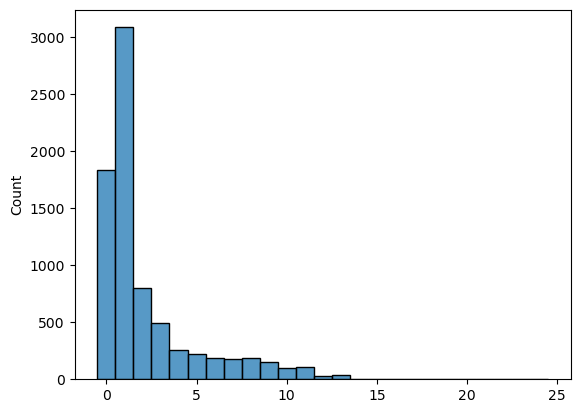

In [3]:
total_domains = 0
total_isoforms = 0
domain_type_counts = {}
isoforms_with_DNAbinding = 0
isoforms_with_PPI = 0
genes_with_DNAbinding = 0
geneList_DNAbinding = []
domain_counts = []
for gene_id in seqs:
    if len(seqs[gene_id])<=1:
        continue
    if 'Swiss-Prot' in seqs[gene_id]["uniprot"]:
        uniprot_id = seqs[gene_id]["uniprot"]['Swiss-Prot']
        if type(uniprot_id)!=str:
            uniprot_id = uniprot_id[0]
    else:
        #print(seqs[gene_id]["uniprot"])
        uniprot_id = seqs[gene_id]["uniprot"]['TrEMBL']
    if type(uniprot_id)==list:
        uniprot_id = uniprot_id[0]
    interpro_url = f"https://www.ebi.ac.uk:443/interpro/api/entry/InterPro/protein/UniProt/{uniprot_id}/?page_size=200"
    req = request.Request(interpro_url, headers = {"Accept": "application/json"})
    res = request.urlopen(req)
    json_res = json.loads(res.read().decode())
    interpro_domains = {domain['metadata']['accession']:domain for domain in json_res['results'] 
                        if 'ssf' in domain['metadata']['member_databases']}
    for prot_id in seqs[gene_id]:
        if not prot_id.startswith("ENS"):
            continue
        total_isoforms+=1
        domain_counts.append(0)
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['interpro'] not in interpro_domains or domain['type']!='SuperFamily':
                continue
            total_domains+=1
            domain_counts[-1]+=1
            if domain['description'] in domain_type_counts:
                domain_type_counts[domain['description']]+=1
            else:
                domain_type_counts[domain['description']]=1
            is_ppi = False
            if interpro_domains[domain['interpro']]['metadata']['go_terms'] is not None:
                for go_term in interpro_domains[domain['interpro']]['metadata']['go_terms']:
                    if go_term['name']=='protein binding':
                        is_ppi = True
            if is_ppi:
                domain['class'] = "PPI"
                isoforms_with_PPI+=1
                break
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['type']!='SuperFamily':
                continue
            if "DNA-binding" in domain['description']:
                isoforms_with_DNAbinding+=1
                domain['class'] = "DNA"
                break
        for domain in seqs[gene_id][prot_id]["domains"]:
            if 'class' not in domain:
                domain['class'] = "Other"
    has_DNA = False
    for prot_id in seqs[gene_id]:
        if not prot_id.startswith("ENS"):
            continue
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['type']!="SuperFamily":
                continue
            if "DNA-binding" in domain['description']:
                has_DNA = True
                break
    if has_DNA:
        genes_with_DNAbinding += 1
        geneList_DNAbinding.append(gene_id)
print(total_domains/total_isoforms)
sns.histplot(domain_counts, discrete=True);
#print(domain_type_counts)
print(isoforms_with_DNAbinding/total_isoforms)
print(isoforms_with_PPI/total_isoforms)
print(genes_with_DNAbinding/len(seqs))

Identify a reference isoform for each gene, with priority given to:
 1. DNA binding domains
 2. Protein binding domains
 3. Transcription regulation domains
 4. Number of present domains

In [18]:
i=0
for gene_id in DNAbinding_seqs:
    domainCounts = {}
    
    for prot_id in DNAbinding_seqs[gene_id]:
        nDNAbind = 0
        nPPI = 0
        nTrans = 0
        nDomains = 0 
        for domain in DNAbinding_seqs[gene_id][prot_id]["consensus_domains"]:
            nDomains += 1
            if domain['class']=='DNA':
                nDNAbind += 1
            if domain['class']=='PPI':
                nPPI += 1
            if domain['class']=='TR':
                nTrans += 1
        domainCounts[prot_id] = [nDNAbind, nPPI, nTrans, nDomains]
    maxDNAbind = 0
    maxPPI = 0
    maxTrans = 0
    maxDomains = 0
    ref = ''
    for prot_id in domainCounts:
        if domainCounts[prot_id][0]>maxDNAbind:
            maxDNAbind = domainCounts[prot_id][0]
            ref = prot_id
            continue
        if domainCounts[prot_id][1]>maxPPI:
            maxPPI = domainCounts[prot_id][1]
            ref = prot_id
            continue
        if domainCounts[prot_id][2]>maxTrans:
            maxTrans = domainCounts[prot_id][2]
            ref = prot_id
            continue
        if domainCounts[prot_id][3]>maxDomains:
            maxDomains = domainCounts[prot_id][3]
            ref = prot_id
            continue
    DNAbinding_seqs[gene_id]['ref'] = ref

Identify the most common sources of domain information as a way to get a source priority list

In [7]:
types = {}
for gene_id in DNAbinding_seqs:
    for prot_id in DNAbinding_seqs[gene_id]:
        for domain in DNAbinding_seqs[gene_id][prot_id]['domains']:
            if not domain['type'] in types:
                types[domain['type']] = 1
            else:
                types[domain['type']] += 1
print([k for k, v in sorted(types.items(), key= lambda item:item[1], reverse=True)])

['MobiDBLite', 'Seg', 'sifts', 'PANTHER', 'Pfam', 'PRINTS', 'Gene3D', 'SuperFamily', 'Smart', 'Prosite_profiles', 'CDD', 'ncoils', 'Prosite_patterns', 'alphafold', 'PIRSF', 'TIGRfam', 'TMHMM', 'SignalP']


In [15]:
print(seqs[gene_id])
print([domain['description'] for domain in seqs["ENSG00000140987"]['ENSP00000483210']['domains']])

{'ENSP00000483210': {'seq': 'MAEGLWEQGFLRTPEQCRTKFKSLQLSYRKVRRGRVPEPCIFYEEMNALSGSWASAPPMASDAVPGQEGSDIEAGELNHQNGEPTEVEDGTVDGADRDEKDFRNPGQEVRKLDLPVLFPNRLGFEFKNEIKKENLKWDDSEEVEINKALQRKSRGVYWHSELQKGLESEPTSRRQCRNSPGESEEKTPSQEKMSHQSFCARDKACTHILCGKNCSQSVHSPHKPALKLEKVSQCPECGKTFSRSSYLVRHQRIHTGEKPHKCSECGKGFSERSNLTAHLRTHTGERPYQCGQCGKSFNQSSSLIVHQRTHTGEKPYQCIVCGKRFNNSSQFSAHRRIHTGESPYKCAVCGKIFNNSSHFSAHRKTHTGEKPYRCSHCERGFTKNSALTRHQTVHMKAVLSSQEGRDAL', 'domains': [{'end': 284, 'type': 'Gene3D', 'translation_id': 1145084, 'feature_type': 'protein_feature', 'seq_region_name': 'ENSP00000483210', 'align_type': None, 'id': '3.30.160.60', 'Parent': 'ENST00000618425', 'description': '', 'hit_start': 7, 'hit_end': 40, 'hseqname': '3.30.160.60', 'interpro': '', 'cigar_string': '', 'start': 257}, {'type': 'Gene3D', 'end': 256, 'translation_id': 1145084, 'feature_type': 'protein_feature', 'seq_region_name': 'ENSP00000483210', 'align_type': None, 'id': '3.30.160.60', 'description': '', 'Parent': 'ENST00000618425',

Write to fasta

In [6]:
#gene = 'ENSG00000001167'
#prot = 'ENSP00000345702'
for gene_id in seqs:
    for prot_id in seqs[gene_id]:
        with open("fastas/"+prot_id+".fa", "w") as f:
            f.write(">" + prot_id + "\n")
            f.write(seqs[gene_id][prot_id]['seq'])